In [1]:
%matplotlib inline

In [2]:
import sys
import os
import pickle
from tqdm.notebook import tqdm
from collections import Counter, defaultdict
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import networkx as nx
import powerlaw
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.pairwise import euclidean_distances
from networkx.algorithms.community.quality import modularity as nx_modularity
from joblib import Parallel, delayed

sys.path.append('../../pygkernels')
from pygkernels.measure import kernels
from pygkernels.scenario import d3_colors

In [3]:
import datetime
print(datetime.datetime.now())

2020-08-27 09:24:41.068677


In [4]:
resolution = 200

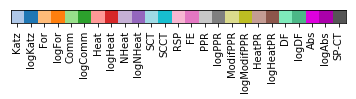

In [5]:
a = np.zeros((1, 25, 3), dtype=np.uint8)
labels = []
for idx, kernel in enumerate(kernels):
    a[0, idx] = np.array(colors.to_rgb(d3_colors[kernel.name])) * 255
    labels.append(kernel.name)
plt.imshow(a)
plt.xticks(range(25), labels, rotation='vertical')
plt.yticks([]);

In [6]:
def create_krondecker(partition):
    n = len(partition)
    kron_mask = np.tile(partition, n) == np.repeat(partition, n)

    return np.reshape(kron_mask, (n, n))


def modularity2(AIJ, partition):
    n = len(AIJ)
    m = np.sum(AIJ)  # no of edges

    k = np.sum(AIJ, axis=1)
    expectation = np.reshape(np.tile(k, n) * np.repeat(k, n), (n, n)) / m
    kron = create_krondecker(partition)

    # Q = (1 / 2m) * SUM(AIJ - (ki.kj / 2m)) ∂(ci, cj)
    return (1.0 / m) * np.sum(kron * (AIJ - expectation))

In [7]:
def np2nx(A: np.ndarray, partition: np.ndarray):
    G = nx.from_numpy_matrix(A)
    nx.set_node_attributes(G, dict(enumerate(partition)), 'community')
    return G

def partition2communities(partition):
    result = defaultdict(list)
    for idx, class_ in enumerate(partition):
        result[class_].append(idx)
    return list(result.values())


def estimate_mu(graph, partition):
    n_out_edges = 0
    n_nodes = graph.size()
    for n1, n2 in graph.edges():  # links:
        if partition[n1] != partition[n2]:
            n_out_edges += 1
    return n_out_edges / n_nodes


def power_law(values, maxval=200):
    tau = powerlaw.Fit(values, verbose=False).alpha
    if tau > maxval or np.isnan(tau):
        tau = maxval
    return tau


def modularity(A: np.array, partition):
    """
    Simplified version only for undirected graphs
    """
    n_stubs = np.sum(A)
    deg = np.sum(A, axis=1, keepdims=True)

    Q_items = A - np.diagonal(np.diagonal(A)) - deg.dot(deg.T) / n_stubs
    Q = 0
    for class_name in set(partition):
        mask = np.array(partition) == class_name
        Q += np.sum(Q_items[mask][:, mask])
    return Q / n_stubs


def redetect_params(data):
    A, partition = data['A'], data['y_true']
    G = np2nx(A, partition)
    
    n = G.number_of_nodes()
    average_degree = 2 * G.number_of_edges() / n
    node_degrees = [d for n, d in G.degree()]
    min_degree = np.min(node_degrees)
    max_degree = np.max(node_degrees)
    tau1 = power_law(node_degrees, 250)
    modularity = nx_modularity(G, partition2communities(partition))

    # Community-based parameters
    k = len(set(partition))
    mu = min(max(estimate_mu(G, partition), 0.), 1.)
    community_sizes = list(Counter(partition).values())
    min_community = np.min(community_sizes)
    max_community = np.max(community_sizes)
    tau2 = power_law(community_sizes, 250)
    
    return {
        'n': n,
        'k': k,
        'average_degree': average_degree,
        'min_degree': min_degree, 
        'max_degree': max_degree,
        'tau1': tau1,
        'mu': mu,
        'min_community': min_community,
        'max_community': max_community,
        'tau2': tau2,
        'modularity': modularity
    }

In [8]:
root = '/media/illusionww/68949C3149F4E819/phd/pygkernels/montecarlo_lfr'
    
def perform_one(fn):
    with open(f'{root}/{fn}', 'rb') as f:
        data = pickle.load(f)
    A = data['A']
    item = {}
    for kernel_name, kernel_results in data['results'].items():
        kernel_best_ari = -1
        for parameter, parameter_results in kernel_results.items():
            if len(parameter_results) > 0:
                if 'new_modularity2' not in parameter_results[0]:  # add new_modularity if not exist
                    for init_idx, init in enumerate(parameter_results):
                        partition = init['labels']
                        init['new_modularity2'] = modularity2(A, partition)
#                 print(sorted(parameter_results, key=lambda x: -x['new_modularity2']))
                    with open(f'{root}/{fn}', 'wb') as f:
                        pickle.dump(data, f)
                param_best_ari = sorted(parameter_results, key=lambda x: -x['new_modularity2'])[0]['score_ari']
                kernel_best_ari = max(kernel_best_ari, param_best_ari)
        item[kernel_name] = kernel_best_ari
    
    return item, redetect_params(data)

dataset = Parallel(n_jobs=6)(delayed(perform_one)(fn) for fn in tqdm(os.listdir(root)))

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [9]:
# generate additional features
for item in dataset:
    maxari = np.max(list(item[0].values()))
    item[1]['maxari'] = maxari
    item[1]['average_degree/n'] = item[1]['average_degree'] / item[1]['n']
    item[1]['min_community/max_community'] = item[1]['min_community'] / item[1]['max_community']
    item[1]['min_degree/max_degree'] = item[1]['min_degree'] / item[1]['max_degree']

In [10]:
dataset[0]

({'Katz': 0.1429144148835836,
  'logKatz': 0.4409365359200871,
  'For': 0.011806037718625746,
  'logFor': 0.31984318212926616,
  'Comm': 0.16101858587315618,
  'logComm': 0.3654948835662535,
  'Heat': 0.008029119101342626,
  'logHeat': 0.09278927135814646,
  'NHeat': 0.3426004146382099,
  'logNHeat': 0.42626930796187673,
  'SCT': 0.6402286022746339,
  'SCCT': 0.6723689518427769,
  'RSP': 0.578839306718301,
  'FE': 0.4361064096048135,
  'PPR': 0.021378616857131837,
  'logPPR': 0.4282238544368487,
  'ModifPPR': 0.0018484419692191478,
  'logModifPPR': 0.4282238544368487,
  'HeatPR': 0.41810265887494713,
  'logHeatPR': 0.42626930796187673,
  'DF': 0.1429144148835836,
  'logDF': 0.005508380245445584,
  'Abs': 0.033755033080549994,
  'logAbs': 0.49289815801917974,
  'SP-CT': 0.5537528493741254},
 {'n': 1372,
  'k': 6,
  'average_degree': 262.3250728862974,
  'min_degree': 146,
  'max_degree': 1023,
  'tau1': 6.0327809625039075,
  'mu': 0.7097441026923398,
  'min_community': 147,
  'max_commu

In [26]:
ctr = Counter()
for item in dataset:
    item_won_measure = sorted(list(item[0].items()), key=lambda x: -x[1])[0][0]
    ctr[item_won_measure] += 1
ctr.most_common(30)

[('SCCT', 480),
 ('logKatz', 174),
 ('NHeat', 139),
 ('Katz', 70),
 ('logComm', 46),
 ('SCT', 46),
 ('Comm', 44),
 ('RSP', 36),
 ('logNHeat', 24),
 ('logDF', 20),
 ('SP-CT', 18),
 ('logPPR', 7),
 ('logHeat', 6),
 ('Heat', 6),
 ('logModifPPR', 6),
 ('logFor', 6),
 ('Abs', 6),
 ('DF', 5),
 ('FE', 4),
 ('logHeatPR', 4),
 ('For', 3),
 ('HeatPR', 2),
 ('PPR', 2),
 ('ModifPPR', 1)]

# My own knn

In [11]:
class MyKNN:
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        
    def predict(self, X_test):
        output = []
        pair_distance = euclidean_distances(X_test, self.X)
        for test_idx in range(len(X_test)):
            chosen_indices = np.argsort(pair_distance[test_idx])[:self.n_neighbors]
            weighted_results = np.zeros(len(self.y[0]), dtype=np.float32)
            for chosen_idx in chosen_indices:
                weighted_results += self.y[chosen_idx]
            output.append(weighted_results)
        return np.array(output)
    
    
class MyFilter:
    def __init__(self, distance=0.05):
        self.max_distance = distance
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        
    def predict(self, X_test):
        output = []
        pair_distance = euclidean_distances(X_test, self.X)
        for test_idx in range(len(X_test)):
            chosen_indices = []
            for train_idx in range(len(self.X)):
                if pair_distance[test_idx, train_idx] < self.max_distance:
                    chosen_indices.append(train_idx)
            weighted_results = np.zeros(len(self.y[0]), dtype=np.float32)
            for chosen_idx in chosen_indices:
                weighted_results += self.y[chosen_idx] * (self.max_distance - pair_distance[test_idx, chosen_idx])
            output.append(weighted_results)
        return np.array(output)
    
    
class MyGaussianFilter:
    def __init__(self, sigma=0.05):
        self.sigma = sigma
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        
    def predict(self, X_test):
        output = []
        pair_distance = euclidean_distances(X_test, self.X)
        gaussian_weights = np.exp(-np.power(pair_distance, 2) / (2 * self.sigma**2))
        for test_idx in range(len(X_test)):
            chosen_indices = []
            for train_idx in range(len(self.X)):
                if pair_distance[test_idx, train_idx] < 3 * self.sigma:
                    chosen_indices.append(train_idx)
            weighted_results = np.zeros(len(self.y[0]), dtype=np.float32)
            for chosen_idx in chosen_indices:
                weighted_results += gaussian_weights[test_idx, chosen_idx] * self.y[chosen_idx]
            output.append(weighted_results)
        return np.array(output)

# Plot knn of two features

In [12]:
all_feature_names = [
    'n',
    'k',
    'tau1',
    'tau2',
    'mu',
    'average_degree',
    'min_community',
    'maxari',
    'modularity',
    'average_degree/n',
    'min_community/max_community',
    'min_degree/max_degree'
]

fnc = {
    'n': lambda x: x/1500,
    'k': lambda x: ((1 - 1/x) - 0.5) * 2,
#     'tau1': lambda x: ((np.log(x) - 0.7) / 3.6),
#     'tau2': lambda x: ((np.log(x) - 0.4) / 5),
    'tau1': lambda x: 1 - (1 / x**0.5),
    'tau2': lambda x: 1 - (1 / x**0.5),
    'mu': lambda x: x,
    'average_degree': lambda x: x/850,
    'min_community': lambda x: x/750,
    'maxari': lambda x: x,
    'modularity': lambda x: (x + 0.5) * 0.75,
    'average_degree/n': lambda x: x / 0.7,
    'min_community/max_community': lambda x: x,
    'min_degree/max_degree': lambda x: x / 0.7
}

real_limits = {}
limits = {}
for fname in all_feature_names:
    min_max = np.min([info[fname] for _, info in dataset]), np.max([info[fname] for _, info in dataset])
    real_limits[fname] = min_max
    limits[fname] = fnc[fname](min_max[0]), fnc[fname](min_max[1])
    print(f'{fname}: {real_limits[fname][0]:.2f}, {real_limits[fname][1]:.2f} | {limits[fname][0]:.2f}, {limits[fname][1]:.2f}')
  
# real_limits['tau1'] = (1, 200)
# real_limits['tau2'] = (1, 200)
# limits['tau1'] = (0, 0.99)
# limits['tau2'] = (0, 0.99)
    
def point2plot(x, feature_name):
    vmin, vmax = limits[feature_name]
    return (x - vmin) / (vmax - vmin) * resolution

n: 10.00, 1499.00 | 0.01, 1.00
k: 2.00, 224.00 | 0.00, 0.99
tau1: 1.96, 205.57 | 0.28, 0.93
tau2: 1.51, 250.00 | 0.19, 0.94
mu: 0.00, 1.00 | 0.00, 1.00
average_degree: 1.33, 874.69 | 0.00, 1.03
min_community: 1.00, 729.00 | 0.00, 0.97
maxari: 0.00, 1.00 | 0.00, 1.00
modularity: -0.49, 0.91 | 0.01, 1.06
average_degree/n: 0.00, 0.77 | 0.01, 1.11
min_community/max_community: 0.02, 1.00 | 0.02, 1.00
min_degree/max_degree: 0.00, 0.80 | 0.00, 1.14


In [13]:
kernels_order = [x.name for x in kernels]
kernels_order

['Katz',
 'logKatz',
 'For',
 'logFor',
 'Comm',
 'logComm',
 'Heat',
 'logHeat',
 'NHeat',
 'logNHeat',
 'SCT',
 'SCCT',
 'RSP',
 'FE',
 'PPR',
 'logPPR',
 'ModifPPR',
 'logModifPPR',
 'HeatPR',
 'logHeatPR',
 'DF',
 'logDF',
 'Abs',
 'logAbs',
 'SP-CT']

In [14]:
def prepare_plot_knn(dataset, feature_names, n_neighbors=1):
    X = np.array([[fnc[fname](item[1][fname]) for fname in feature_names] for item in dataset])
    y = np.array([sorted(item[0].items(), key=lambda x: -x[1])[0][0] for item in dataset])
    
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X, y)

    plot = np.zeros((resolution, resolution, 3), dtype=np.uint8)
    for xidx, xval in enumerate(np.linspace(limits[feature_names[0]][0], limits[feature_names[0]][1], resolution)):
        for yidx, yval in enumerate(np.linspace(limits[feature_names[1]][0], limits[feature_names[1]][1], resolution)):
            pixels_kernel_name = knn.predict([[xval, yval]])[0] 
            plot[xidx, yidx] = np.array(colors.to_rgb(d3_colors[pixels_kernel_name])) * 255
            
    return X, y, plot

def prepare_plot_myknn(dataset, feature_names, n_neighbors=1):
    X = np.array([[fnc[fname](item[1][fname]) for fname in feature_names] for item in dataset])
    y = np.array([[item[0][kernel] for kernel in kernels_order] for item in dataset])
    
    knn = MyKNN(n_neighbors=n_neighbors)
    knn.fit(X, y)

    plot = np.zeros((resolution, resolution, 3), dtype=np.uint8)
    for xidx, xval in enumerate(np.linspace(limits[feature_names[0]][0], limits[feature_names[0]][1], resolution)):
        for yidx, yval in enumerate(np.linspace(limits[feature_names[1]][0], limits[feature_names[1]][1], resolution)):
            pixels_kernels_results = knn.predict([[xval, yval]])[0] 
            pixels_kernel_name = kernels_order[np.argmax(pixels_kernels_results)]
            plot[xidx, yidx] = np.array(colors.to_rgb(d3_colors[pixels_kernel_name])) * 255
            
    return X, y, plot

def prepare_plot_filter(dataset, feature_names, distance=0.05):
    X = np.array([[fnc[fname](item[1][fname]) for fname in feature_names] for item in dataset])
    y = np.array([[item[0][kernel] for kernel in kernels_order] for item in dataset])
    
    knn = MyGaussianFilter(sigma=distance)
    knn.fit(X, y)

    plot = np.zeros((resolution, resolution, 3), dtype=np.uint8)
    for xidx, xval in enumerate(np.linspace(limits[feature_names[0]][0], limits[feature_names[0]][1], resolution)):
        for yidx, yval in enumerate(np.linspace(limits[feature_names[1]][0], limits[feature_names[1]][1], resolution)):
            pixels_kernels_results = knn.predict([[xval, yval]])[0] 
#             pixels_kernels_results[11] = 0
            if ~np.all(pixels_kernels_results == 0):
                pixels_kernel_name = kernels_order[np.argmax(pixels_kernels_results)]
                plot[xidx, yidx] = np.array(colors.to_rgb(d3_colors[pixels_kernel_name])) * 255
            else:
                plot[xidx, yidx] = np.array([1, 1, 1]) * 255
            
    return X, y, plot

In [15]:
def doplot(ax, X, y, plot, feature_names):
    ax.imshow(plot)
        
    n_ticks = 10 if feature_names[1] not in ['tau1', 'tau2'] else 2 
    ax.set_xticks(np.linspace(0, resolution, n_ticks))
    ax.set_xticklabels([f'{x:.2f}' for x in np.linspace(real_limits[feature_names[1]][0], real_limits[feature_names[1]][1], n_ticks)], rotation='vertical');
    ax.set_xlabel(feature_names[1])
    ax.set_xlim(0, resolution)
    
    n_ticks = 10 if feature_names[0] not in ['tau1', 'tau2'] else 2 
    ax.set_yticks(np.linspace(0, resolution, n_ticks))
    ax.set_yticklabels([f'{x:.2f}' for x in np.linspace(real_limits[feature_names[0]][0], real_limits[feature_names[0]][1], n_ticks)]);
    ax.set_ylabel(feature_names[0])
    ax.set_ylim(0, resolution)

    ax.scatter([point2plot(x, feature_names[1]) for x in X[:, 1]], [point2plot(x, feature_names[0]) for x in X[:, 0]], s=1, c='black')

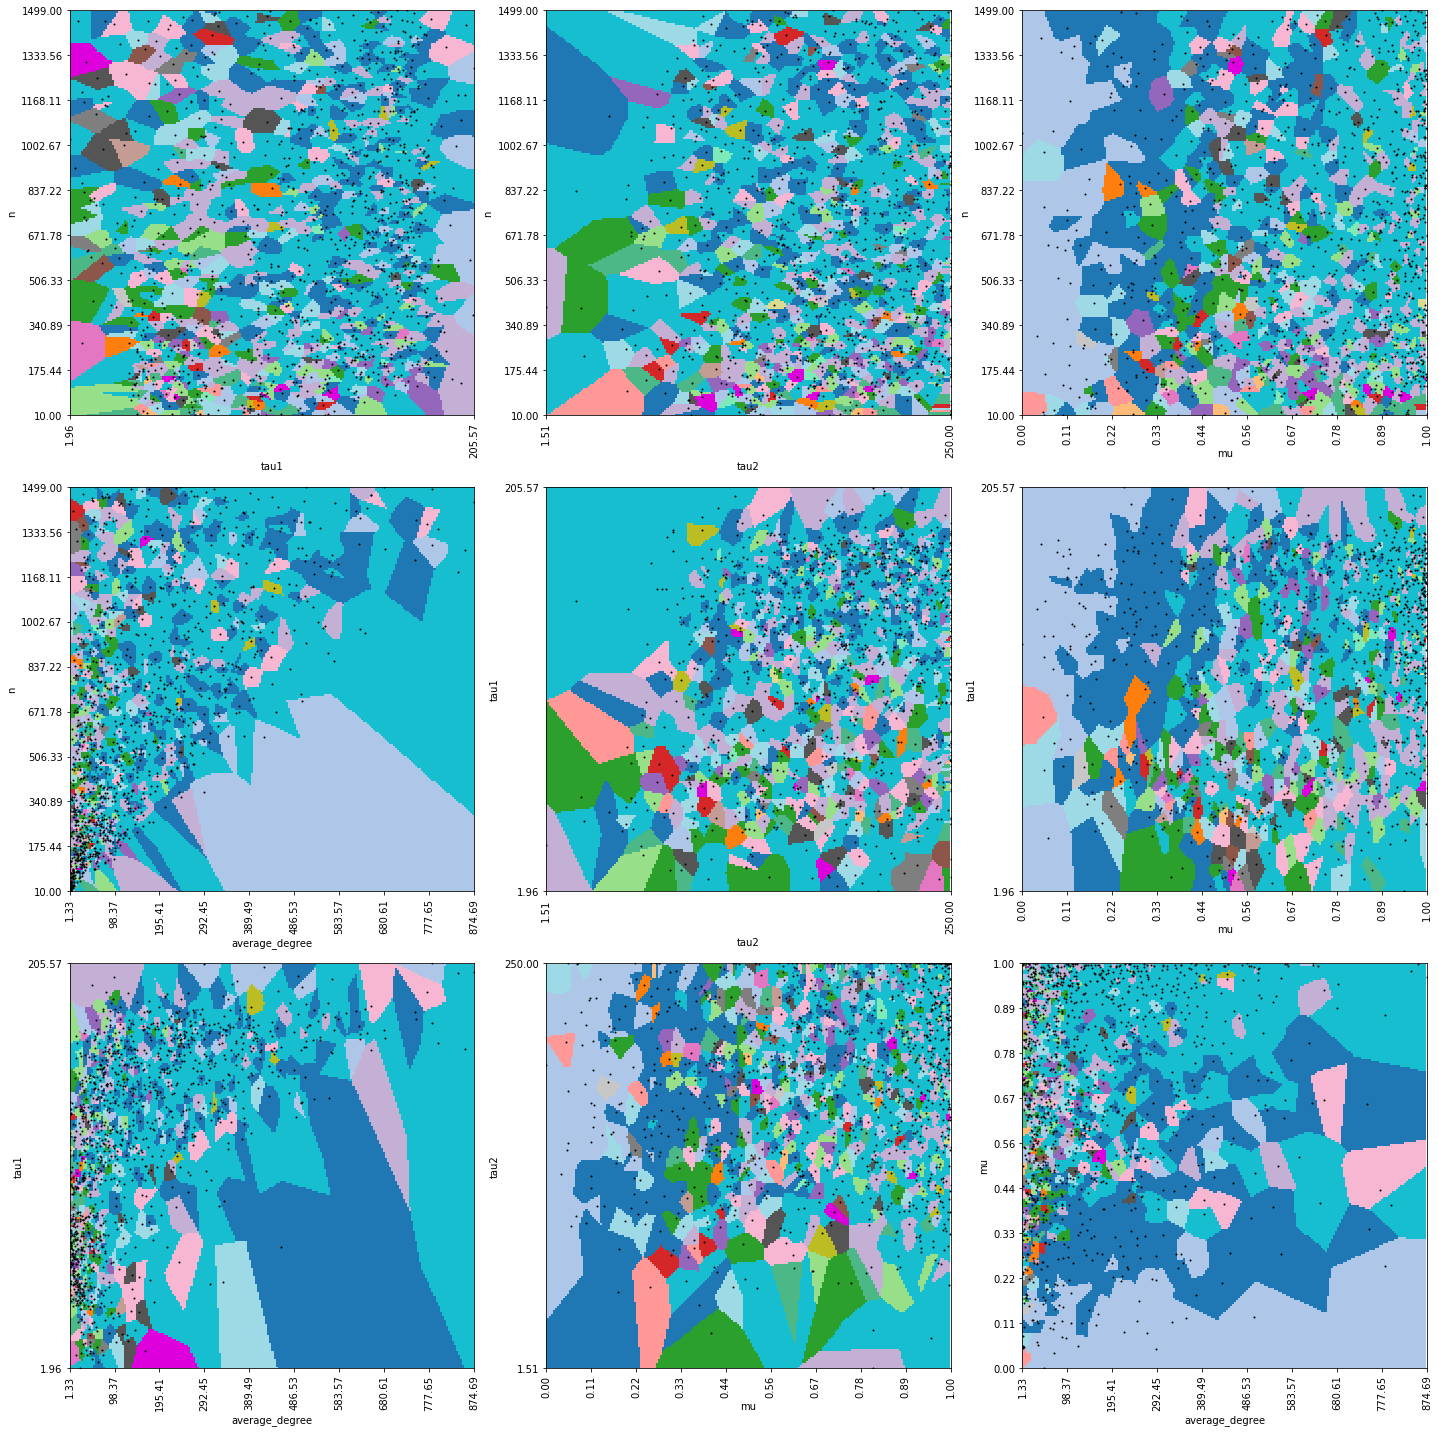

In [27]:
n_neighbors = 1

fig, ax = plt.subplots(3, 3, figsize=(20, 20))

feature_names = ['n', 'tau1']
X, y, plot = prepare_plot_knn(dataset, feature_names, n_neighbors=n_neighbors)
doplot(ax[0][0], X, y, plot, feature_names)

feature_names = ['n', 'tau2']
X, y, plot = prepare_plot_knn(dataset, feature_names, n_neighbors=n_neighbors)
doplot(ax[0][1], X, y, plot, feature_names)

feature_names = ['n', 'mu']
X, y, plot = prepare_plot_knn(dataset, feature_names, n_neighbors=n_neighbors)
doplot(ax[0][2], X, y, plot, feature_names)

feature_names = ['n', 'average_degree']
X, y, plot = prepare_plot_knn(dataset, feature_names, n_neighbors=n_neighbors)
doplot(ax[1][0], X, y, plot, feature_names)

feature_names = ['tau1', 'tau2']
X, y, plot = prepare_plot_knn(dataset, feature_names, n_neighbors=n_neighbors)
doplot(ax[1][1], X, y, plot, feature_names)

feature_names = ['tau1', 'mu']
X, y, plot = prepare_plot_knn(dataset, feature_names, n_neighbors=n_neighbors)
doplot(ax[1][2], X, y, plot, feature_names)

feature_names = ['tau1', 'average_degree']
X, y, plot = prepare_plot_knn(dataset, feature_names, n_neighbors=n_neighbors)
doplot(ax[2][0], X, y, plot, feature_names)

feature_names = ['tau2', 'mu']
X, y, plot = prepare_plot_knn(dataset, feature_names, n_neighbors=n_neighbors)
doplot(ax[2][1], X, y, plot, feature_names)

feature_names = ['mu', 'average_degree']
X, y, plot = prepare_plot_knn(dataset, feature_names, n_neighbors=n_neighbors)
doplot(ax[2][2], X, y, plot, feature_names)

plt.tight_layout()

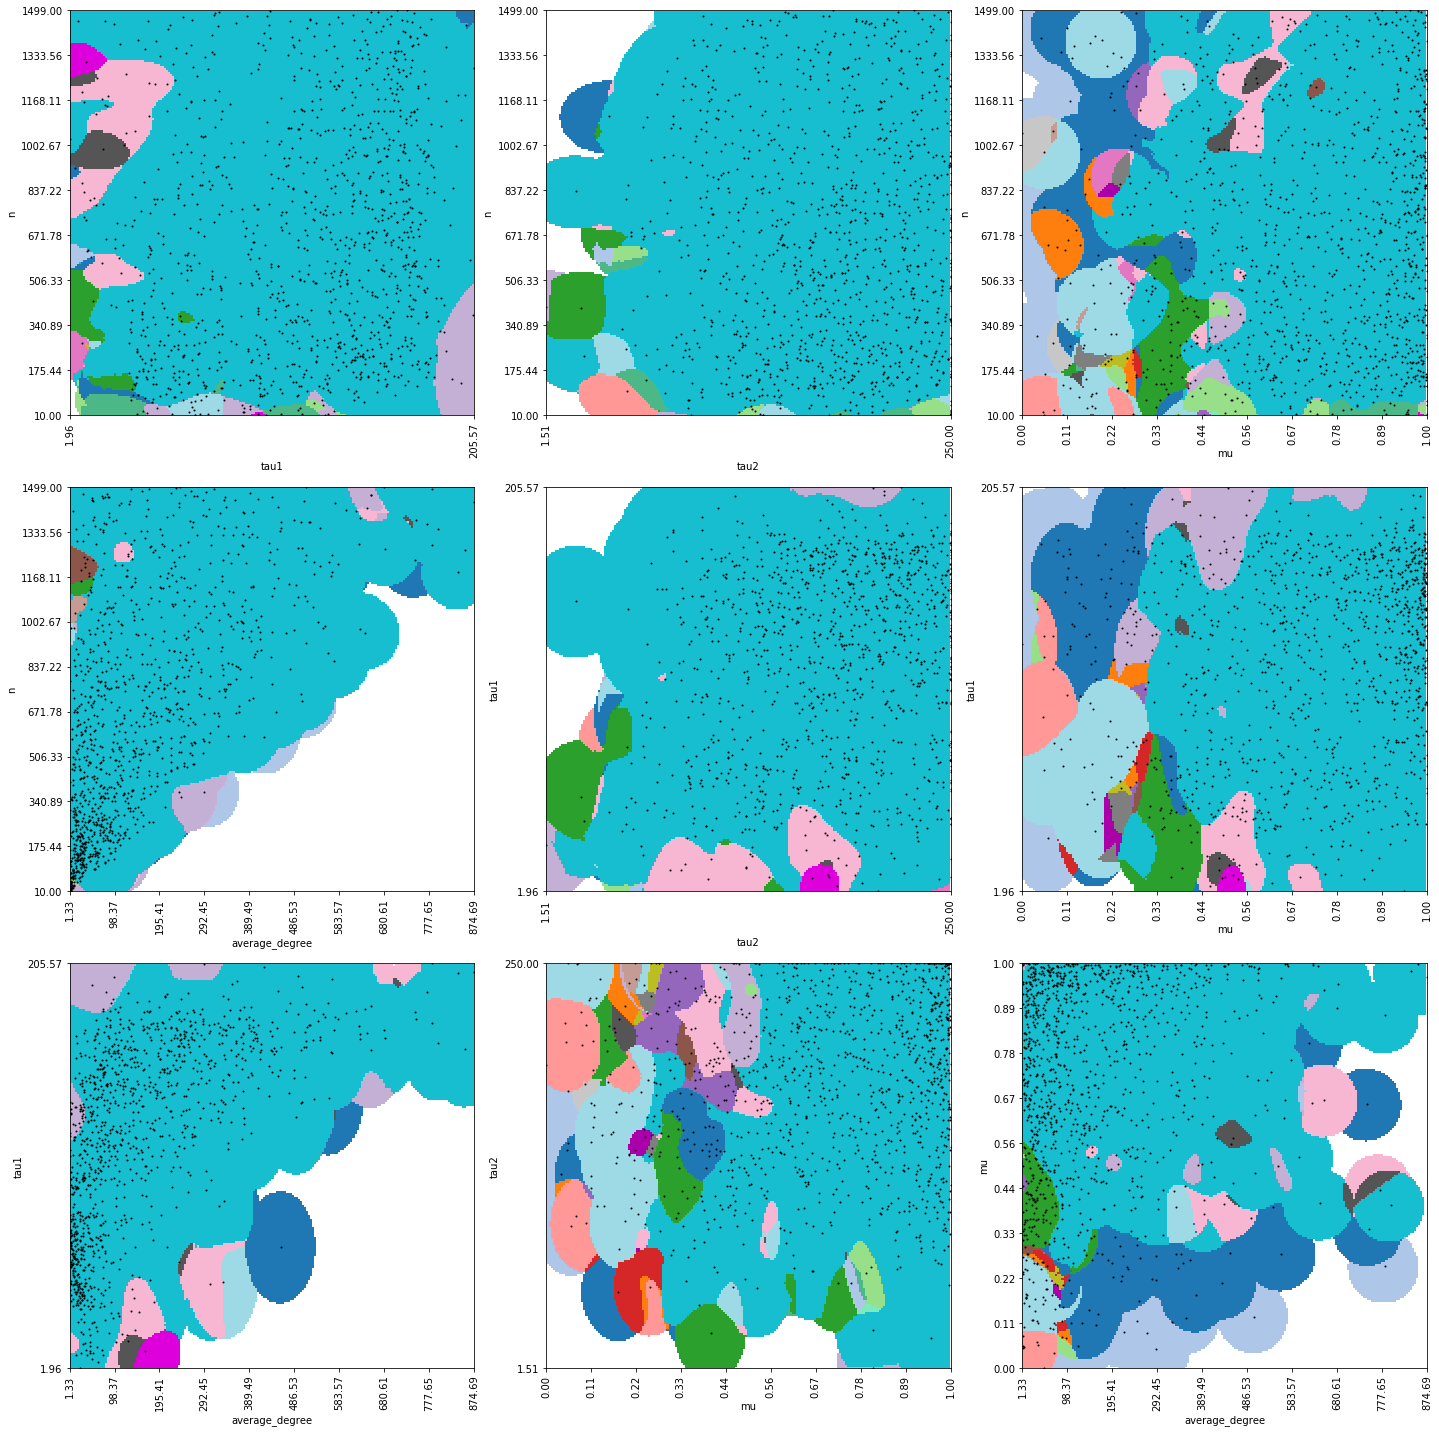

In [16]:
distance = 0.03

fig, ax = plt.subplots(3, 3, figsize=(20, 20))

feature_names = ['n', 'tau1']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[0][0], X, y, plot, feature_names)

feature_names = ['n', 'tau2']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[0][1], X, y, plot, feature_names)

feature_names = ['n', 'mu']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[0][2], X, y, plot, feature_names)

feature_names = ['n', 'average_degree']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[1][0], X, y, plot, feature_names)

feature_names = ['tau1', 'tau2']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[1][1], X, y, plot, feature_names)

feature_names = ['tau1', 'mu']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[1][2], X, y, plot, feature_names)

feature_names = ['tau1', 'average_degree']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[2][0], X, y, plot, feature_names)

feature_names = ['tau2', 'mu']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[2][1], X, y, plot, feature_names)

feature_names = ['mu', 'average_degree']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[2][2], X, y, plot, feature_names)

plt.tight_layout()data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABZ8AAAWYCAYAAADZcbi9AAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvOIA7rQAAIABJREFUeJzsvX+cXVV57/9ZE2Ayk4FJwkR+09iigNcItLmG+02uKTaoY2kMP9pgvzoyYKO03nsDfjOFUn5E5UrJLdDWVkiVIVNvDZWSdC4w2tBW+A6V2KEaolWUtqkEBRwyOTK/IbPuH3N2cmZn73P2j/Vz78/79eJ1yJl99n72Wms/z7Oe9exnCSklCCGEEEIIIYQQQgghhBCVNNkWgBBCCCGEEEIIIYQQQkjxYPCZEEIIIYQQQgghhBBCiHIYfCaEEEIIIYQQQgghhBCiHAafCSGEEEIIIYQQQgghhCiHwWdCCCGEEEIIIYQQQgghymHwmRBCCCGEEEIIIYQQQohytAafhRD3CyFeEUJ8J+JvnxRCSCFER/Xfi4QQO4QQzwohvimEeHvNsf9DCPEdIcR3hRAbY64lhBB/LIR4vnqOX6z520eEED+s/vcRHfdKCCGE2IL2lhBCCNEP7S0hhBCSHt2Zzw8AeF/4SyHEGQDeA+BHNV//HoBvSynfAaALwB9Vj307gN8C8E4A5wG4RAhxVsS1OgG8pfrfBgCfr/5+MYBbAayonuNWIcQiBfdGCCGEuMIDoL0lhBBCdPMAaG8JIYSQVGgNPkspnwRwIOJPdwPoASBrvnsbgL+v/u77AJYKIU4CcC6A3VLKcSnlGwCeAHBZxDk/AKBPzvI0gIVCiFMAvBfALinlASnlCIBdiHAYCCGEEF+hvSWEEEL0Q3tLCCGEpOcY0xcUQnwAwItSyj1CiNo/7cGs0f3/hRDvBPBzAE4H8B0AtwshTgQwAeD9AIYiTn0agBdq/r2/+l3c91GybcDsqjIWLFjwS+ecc07q+yOk6LzxxhsYHh5GR0cHjjnGuAohFnnppZfw4osv4rTTTsPJJ5+c+7iy8MwzzwxLKZeYvi7tLSGEREM7lR8X2/CNN97Anj17xqSUbSavS3tLCCEkK6btaaPrJY33pJ3jGo0cCSFaMfv60Xsi/nwHgD8SQnwbwF4A3wJwSEr5PSHEHwD4WwBjAL4N4JAO+aSUWwFsBYBjz36b3L/lCzouQ0rITGUEEwP9aOlci6Z2v9+KG9u+DaNb70HlV38dC65kiTkXqDe+VI69mcoI2gb6Md25FvvrnCvpca4z/2svqjnRM5f8h5oTJccne7t8+XI5NBQ15yYucvI/fNu2CMQBfPdrimKn8pC3D11pw9r72PTDIezZs2eByev7ZG/POvc8edPnHk31++t2+mefb73mAtsi1OW1Awcw+PCD+MbEuZjX2q7lGpPvjVyLKAx5ffQkY+TG/a/kuoZp9k3Osy1CQ5bO16LmvCerPc1qxxtdrzbe09K5NvIaL110PoQQqea4ums+h/kFAG8GsEcIsQ+zK7//LIQ4WUr5Myllt5TyfMzWxFoC4N8AQEr5RSnlL0kp3wVgBMAPIs79IoAzav59evW7uO8J0cZMZQRj27dhpjICAJgY6Mfo1nswMdBvWbL8tHSuRduGjWjpXGtbFFKl3vhSOfaa2hdhwZUfaWjc6h0XfjaINmhvCSHaqLUtPur1pPasyOT1D8JtaGsc1N5Hd3c3MJsFbBLaW5KKwYcfxFfu/AxG9z6e+reHxiuo7P5rHBqvaJCMEKKLejYyq0+S1Y43ul5tvEdlLMFo5rOUci+ANwX/rhro5VLKYSHEQgDjUsppAB8F8KSU8mfV494kpXxFCHEmZl9dujDi9P0APiGE2I7ZzRcqUsqfCCG+BuB/1mzC8B4AN2q6RUIAHFEEALDgyo8cDtQWIWAbKCviDvXGl2tjL/xsED3Q3hJCdFJrW6jX/US1f2BrHNTeR0dHBwC8bOziKK69ZcazPlZdtv7w5/GLF2PzF7+V+Lejex/Hwa/3AgDaV1yuRT6X0Z3x7Fu2M/EHHTZS1zy/Nt6j8hpag89CiC8D+GUAHUKI/QBulVJ+MebwcwFsE0JIAN8FcE3N3/66WhPrdQC/I6U8WD3/xwFASnkvgMcwWy/reQDjALqrfzsghPg0gH+qnutTUsqoTSIIUcJMZQRycgILujYcfkgZsCVRqHptud74cm3suRYMLwq0t4QQkySdmPhenqPIqPYP8tr3rGPFtJ9De0vycvzixej86LWZftu2bM2cT0J8pyx+go45sAn7F3WNmcoItmzZAqSMJ2sNPkspP9jg70tr/v8bAN4ac9x/jfn+3pr/lwB+J+a4+wHc31hiQvIzMdCPsb770LZhozUFqlqJl8UomMbVbDGd/e1aMLwo0N4SkgzaM/XU0+um7Vxc/7Lf9ZPXvrvqE4WhvXUPXzKe4wjkT5IBPa+13buMZxf0LzOe7VKv1rMN3W9jTNqaA+u414mBfvTM9tmJaX5ntOwGIaawaeRcyOxUrcR9mRDYIM9Yc2GsRMH+JoQUFeo3MwS2sXnlasjJccjJCcxURrT7ZHH9y353H1d9IkJIPqh/3WO4MoK+XTvRdfE6dFhekLWh+22OSdNxKl3lPm4561T09PS8muZ3DD6TQmJTobiQ2alaiXNCEE+esebCWImC/T1LsFN43vpyhBB3oH4zQ61tFPNbMbr1Hoj5LdptXlz/st/dx1WfqGz4VOvZ94znMGkyoH2C+tc9+nbtxE333w0AuP6Kbm3XqZfxHGBD99sck6bjVLrKfWzatAk9PT1vpPkdg8+kkJTdyKlW4j5NCEyvJtoYa7rLqrje3y68vkcI8RPX9VtRiLKNJuxkXP+a7HebNsol+6hKFpfuiRCSHtpd9+i6eN2czzAuZUbroHZM2ogd6HojLOpeXHr+mmwLQIgOgoes3sM8UxnB2PZtmKmMGJSM6GZ8x3aMbr0H4zu2G7lekrGmmmDFdGKg3/r5bDxHqu+/EZPvPe1wFjQhhJhEp47Vee5a22jDTtrEtI1Kcm2fbbXN9iRucus1FxQu67mWot9fQBq9NP9rL2Z6E7FRW964/5VS1nvuaF+E66/ojg0sB5nRfbt2pj730vmHDv/nA6ptTKNx3dS+CGJ+K8b67lNu11yf0zPzOQMmV0d8Wu33SVaA9adcQf24EaHP4uFSWZWo50i3Lij7mw2EkPKgU8cm8YN88+1coHnlakzvGULzytVzvg+3pY62jbOPNnxeVbaaNp+QYqJaLx0ar2B07+NoW7YG81rbc5/PR1RlLIczo21mQvs2r0wyrnXZtXrnbdSOJvwEBp8zYNKB8ylA6pOsAJ1ZV1A9blovXQ8xv6XQ/ar6VaE8r+NEPUe6A9IuvT5ESFno/eGPbYtQSpLqWFXnDuObb+cCU089gendg5g6bzmOuXLp4e/DbamjbePsY21fm1pQUGWr05xneHgYAE7KfVHiJGXIBq6lqDWgA1TPxUf3Po6DX+8FANy19TNKzukbqmo5B5nRac6rK9NZtx+iel6ZZFxnvWYj+13vvI3aMenzGMgwvOz0tOIz+JwFk0FLnwKkPskK+BfAKmr2kepxE9evptqvCDvYpiGqvXUGSwghpEwk1bGqzh3GN9/OBZJsejhTGYGcHMeCro/NOS6LD5HkN7V9PbZ9W2HtcW9vLwCknxETQoyjei7etmzNnM8y0qiWc57zjk1OYHxyAsOVEaPZz775ISrGdZxdzzOfbtSOjeQOZJKTExjruw+9Z52a6voAg8+ZMBm0THItV4KSvgVzfaOowTtT4yZL+2V5tnzfwVZXJrVvjkMUjeo+h2vRHT7+D3RJRIh+ypbx7IpP5Qr07dKTZNPDse3bMNa3FW0bNs4pwSEnxzHWtxVAch8ird9RBHscR3d3N3p6evbbloMQYp55re2JM56LWuc5nLGs8rwL5rfgpvvvRuv8ljnXiMp45huvyYhqp5nKCCp33ILp3YMA5tr1PPY7bzsGvsaCrg1o27AxsLepzsHgcwEoalAygBPBWVyYLPjcF1naL8uzZbqfVBtkXfqkqI5D7TNBCPEfH3yqRjKqsNU+23sfCPsKRyZ1H0Pbho2pbEpcjek4imqPAaCjowMAXrYtByGE+Ei92s5psqp98KVcIKqdJgb6Mb17EMetWHWULxC23yb9vVq/pal9UWBvU8HgcwFwISipE9+Vl6oJnAuTBZ/7Ikv7ZXm2XOinRtQbk0XXJ6oJnoljflABVlwOoHGGNCE+EJfx/NnT3wSguFlDtnVgEp+hkYwqbLXP9t4Hwr5CeFKXhrga067DBQ6SlLLVeg5T9NrPqnntwAEMPvwgVl22HscvXjznb0X1XVRRr7ZzOKu6Xo1nm76UT7Ylqp3S+AMm/T0VMQ4GnwuAD8GuPNieCOalSBM43/siLUV9tuqNSVv37JOjUEtL51oc84NKqevLEVIkbOv9JD5DIxlV2Oqy2Xvb5Nmvwte+KpJ/TAhxh8GHH8RX7pwtv9H50WstS+MXqmpG2/SlfLItUe2Upu1s+HvccJAUGtsTwbz4OimIwtW+8DVwaQsXx6RPjkItTe2L0M6MZ1ICmC3UGBW2SIV+VmGrXbX3ZUPFYoSruOiLELc4NF7B6N7H8dqlP3dUBispB+H9VOKozY5fddn6OZ9lIchE3jc5L/M5ktSMrpfx7AJlsi02/L3AL8my4WBT6l8QYoiZygjGtm/DTGXEtii5CB5oBkX1ESjBiYF+26J4gYtjsqVzbeo6l4QQ4hIqbJGL+pnYo8i2sXasF8XnJ2oZ3fs4Dn69F4MPP2hbFOIRxy9ejM6PXssFi5QMV0Zw10O9GPZcD9OP0kvgl3R3p9/YkpnPxFl8zYQk5inTCmdR8TVzC2DGMykWQa1nZjqnh7aIqMZn25gG+vwkis13XI/Bh08rXQarCoKMYd991ED+pBnQcdCnaUy9es+A+xnPxAyBX5Jlw0FmPhNnKXK2B1FLkVc4VWYD6cosYsYSIYQU2xb5Bu1SY+q1ken2o89PomAGKyHm6Lp4HW6/+rpU9Z5dtLUuyuQDJtqNmc/EWcqS7UFIPbJmA0XVHtWVWRScV06OQ8xvZe1tQjzk5H/4tm0RCFGGjUxa3/afqNdGptqvts3o8xNSn6Cu8eYvfsuyJGpQoTNraz1HwYzn5MTVe66X8eziWysuymSaLM+WiXZj8JkQEolvk6iikvU17igDouuV8OB8cnKi9MaeEEKIfZLaO5W+jm8T3nptZKqEjG9tRghRB59//3Gx3JiLMpkmy7NV22664kAMPhNCIqFD4AZZ3wCIMry63iYIzjtTGYGY36LE2HPxgxAzMOOZFJGk9q6Rr5PGFvk24a3XRqbePvStzQjxDZdrP6d5/uPkDzKbP3v6myK/10FZ5ihJajy7+Ka6izKZJottrW23se3btMSBGHwmRBFFM0ScEPjdpzYMr8prspQHIYS4jc82MqCRr5NmIV613S1C+zZCdZsNDw8DwEnKTkgI0YavQUImaJlHhz0sso3N82zNVEYgJ8exoOtjyuNADD4TooiiGSJfHYIweQxL0frUBlnbn6U8CNELM55JXny3kUnsk82FeB3tW+TJNgD09vYCwOm25SB+8tqBAxh8+EGsumw9Nzn0DJO1nYueoJUk49k0Ouyhjb0NfLC7EwP9GOvbirYNG5XLy+AzIYoouiHSjS7FnMewsE/zM75jO8b6tkJOjqPtqmsT/05HKQ9CCCkLJiY7vtvIJP6BzoX4Rn2ko319XzBoRHd3N3p6evbbloP4yeDDD+Ird34GAND50eQ+KykXJhK0fAtY6kaHPSzj3ga2F90ZfCZEEUXJFG6Ei0HieuRRoGXpU72I0OcRkowl9gEhamHGczkI21Qdttt3/Ww7eN7I71HRvuF+t33Puuno6ACAl23LUXQOjVcwuvdxtC1bg3mt7bbFUcaqy9bP+SwSLtd+LgKqbayNgKWLGc8BOvyNMu5tYHvRncFnQkgqXAwS18P3ybHvtF66PjZz2aWVYEIIKRJhm0p9ezS2/QMTE9Jwv9u+Z1IMRvc+joNf7wUAtK+43LI06jh+8WJmPJNMqLaxLgUsST5csru2xxWDz6QhfO2D1GIjSFzkMZjm3nxsh3r9atsAElImip7xnFQ/+qhHsxDWvdS37mFiQlrkfo96lrnhoBnalq2Z81kGWA+a1EO1rs1jH4IM5n2T81IdT47Ghs+o85rhcWX6/pq0X4F4T7CSNzHQn+s8M5URjG3fhpnKiCLJiA0CpWVy0q5qDLpImntzoR1UPsc2xhIhpJgk1Y8u6FEblEHf0s88Gpf6XXX/RD3L3HDQDPNa29G+4vJCldxoRFAPevDhB22LQhzEJV1L1BHYmfEd2435Fyb91DzXyrLYy8xn0hBVK3l85ZNkpciZO2nuzYV24HNMiF8UPeM5IKl+dEGPEj3QPrmNidfSueFgfu5etxwAcN3OIcuSuEWR60GTcsKM58YE9kVOThjzL0z6qXmulWWxl8Fn0hBVrwVywucmPryC7FKtJNWkuTcX2qF55WpM7xlC88rVVuUghJBakupHF/Qo0UPZ/cxG/pxtf8/Ea+nccJAkJW0ZDdaDJqR8BHZmpjISu4eRrmuaIO5aSfyFLIu9DD7HcM4P5uFv3n1CrnP8P3//M0XSZMO2kxmGEz43YaaQf9h8tqeeegLTuwcxdd5yHHPl0tznc01PEVIUypLxTMpJlO0w7We6Zr8a+XO6/b1G7cF5AHGJoIwGgFIElSffe1qq413TbyQ5jWo9u5Dx7Fst5bLZryT+QpbFXtZ8LjBlrWuYBNYFPEJL51q0bdg4ZyXPVvuwX5Jh89mOGi9Jiepf6ilCiCpM2RCfbZXPstfigu1wbU+URvY5j/1Oggt9QkhSVl22Hr/e8/ssoxEDn+cj6LSbRbHJjQjfp43xVYQxbWq86PIXmPmskX8MZU6bzoQu++uH9WC27xGiVvJstY8P/eJCJoDNZzvryu9MZQSVO27B9O5BAEf6l3qKEKKKLDYki073wVbF4bPstbhgO1zbEyXKPofHt84+d6FPiDpcr/2ctmxGGJbRqA+f5yPotJsmbbLNjOfwfdoYX1mv6cLcP8DUeNHlLzD4XGDK9npAGmhQ62OrfVo610JOjkNOTmCmMmJdwUfhwsTdx2d7YqAf07sHcdyKVXPGVdlfkyaEqCOL7cqi033yIcI6z6bsKvWvC3bQhz1RTPosLvQJKQ9lK5thGlefZxt+vE4d7ZM/kYfwfdoYX1mv6cLcP0DXeDH1XDH4bBDbmdBFg3V79GGrfZraF0HMb8Xo1nsg5rc42UdlcRJUU9tuNoO+LjkQhOigzLWes9iuLDpdt41UOQkI6zyb/g/1bzQ6+4Q+CykqQbkMls0oFzbsiE4dreLcjWo8u4DPsReXAr662tHUc8XgM8mFzSxCTmKKiesTJZ+Np01caTfXxxchxCyu6KZaVPo3Luk8FbLw7ZV0uDi+CVEBy2aUE9s2jTaofPge8E2CqeeKGw5a5B/ffcJR2dC+4evGZyQZNjZBCBS8LYPuysYPrshRNGyPL0J0cfI/fLvUWc86Ma2PVfo3Lum8OFnStG8RNgxyEfocJI671y0/XP+ZENvYtmku2KB9k/Pm/OcaPtgTF2R0KZYV9VzpaCMGn0kubD40to1PGXDBwJrGlXt2RQ5grvGJ+39CCCkqqvRxUp1ZNv8mTfu6NFkrEuM7tmN06z0Y37E98u+094QUCz7T2aANaoxLc9g4XJAxia8X9ZyaenZ1tBHLbpBc8HW+IxTxNRzbrzbZwJV7tlVfKurvta8FAYj8f+oBQkhRUaWPXXrF0iXStG+t35nW7yqin6YOEfqciy9jd3h4GABOsi0HSceh8QpG9z6OtmVrMK+13bY4pcCXZ9o1GPtojCtz6Xq4IGMSnyTqOVX57NaTQUcbaQ0+CyHuB3AJgFeklG+vfvdpAB8AMAPgFQBXSSl/LIT4AIBPV79/A8BGKeWgEOLnAOzAbJb2sQD+REp5b8S1bgPwWwB+Wv3q96SUj1X/9g4A9wE4oXr+/yylnNRz1+nhRoR6MTXZKKIRd83AmuhLV+7ZVn2pqL83r1yN6T1DaF65Gk0nzE4Kag2Ry85FWaC9LS8staEfVfpY56LibMaqQOul670LrJragb6IfpoqWi9dDzG/JXZsmpqo5/Xzent7AeB05YLVUFZ7G5TeuG7nkPJzj+59HAe/3gsAaF9xufLzm+a1Awcw+PCDWHXZehy/eLFtcSKxGXzzbSHQtryqSmsE51k6/5CS88Xhyly6Hi7ImMQniXpOVT679WTQ0Ua6M58fAPA5AH01322RUt4MAEKI/w7gFgAfB/B3APqllLJqTP8KwDkAfgLgv0gpp4QQbQC+I4Tol1L+OOJ6d0sp/1ftF0KIYwB8CcCHpZR7hBAnAnhd6V0SpzE12QgUQPPK1Rjbvs0bg+oTnDgeIasj1MhgRf196qknML17EFPnLceCKz8yp+2zZqAR5TwA2ltCnEbnouJY31YAgJjfouUaLur4NBOwmcoI5OQEFnRt4IJpBI3GpqmJel4/b+3atejp6amolivEA6C9VUrbsjVzPn1n8OEH8ZU7PwMAzm6KaDP4pms+p8tO6Z5/umhffcPHNkziw0Q9pyqfXdOLUFqDz1LKJ4UQS0Pf1ab1LgAgq9+Pxnw/XfN9M9LXqX4PgGellHuq53s15e+NE2RCMwNaDcZ276wqgrHt2xggTUAWI+HCKzKukNURyjLBTNLuXBiwC+1t+WDGMwlo6VwLOTkOQGizjy7q+DQTsNkA/X1o27DRm4lp2VCxQNDf3w8AWus2lN3e6siAntfaHpnxvPmL3wIA3HrNBcquZYJVl62f86mKoD18R9d8Tped0j3/DMutexNBUxnQJnHRR2mEC9nXcTLoCuZbqfkshLgdQBeACoCLar6/FMBnAbwJwK/WfH8GgEcBnAVgU8yqMAB8QgjRBWAIwCellCMA3gpACiG+BmAJgO1Syjtj5NoAYAMAnIpTc90jaYypFSrTDzYDpMnIYiSy9KWPK6FJMDnOkrQ7x72b+GBvzzzzzFz3SEjZaWpfhLarorPrVNlA33W87/KXARULBIYynyPxwd4uOVlrRRJS5fjFi53NeHYBXXNzXXpedyyB9ik/rrahK3GItHLoCuanXWVVgpTyJinlGQD+N4BP1Hy/Q0p5DoB1mK2PFXz/gpTyHZg1zh8RQkRtJPF5AL8A4HzMvsr0h9XvjwGwCsD/W/28VAjxKzFybZVSLpdSLl8M+/WZ/vHdJxxVD7pIuLDLaFqS7C5atl3qs2Jqt2Afx1kSXBtnrslDZvHB3i5ZsiTvbRJCYshqA8P+ju863nf5y4AKv9BE5nMcPtjbExaqm9/evW754Sxoko7XDhzAwBc+j9cOHLAtSiz7Jucp+c8kvur5HzV34KfrrsaPmjsStVlX76fR1fvphsc1wkYf6cLVvnclDpFWDl1xGivB5xr+N4Cj3rGRUj4J4OeFEB2h738M4DsA/mvEb16WUh6SUs4A+HMA76z+aT+AJ6WUw1LKcQCPAfhFtbdBsmAq+KgSVxRIETBlJHSOsySLEXnPl+caKuRTfY/EGrS3xGmoa/SQ1QbS31GDjXFt+prh62W9vgq/sLu7G5i1RTahvdWID4HbRgQ1oQcfftC2KN5BX6E4lKEvdce7krZhIEewN1mj43XFaYyX3RBCvEVK+cPqPz8A4PvV788C8K/VDRl+EbP1r14VQpwO4FUp5YQQYhFmV3fvjjjvKVLKn1T/eSlmjTgAfA1AjxCiFcA0gNVRv3eZotaAdqHOTVpcfaWDxKNznKl+JSXqfPWu0egVGhXypTmHK68WkVlob4tJUWs9+1ivzwey2kAd/k4ZbET4Hm2Ma9PXDF/P5rPc0dEBAC8bvSjKbW911IAOU1v72YfN/BqRtia0jlrPcfpYdSZs3Pmy1hsugq+QtI0bZTeH/97XfXMueUzXgNbRl675GbrjXUnb0JW9ybQGn4UQXwbwywA6hBD7AdwK4P1CiLMBzAD4D8zuBAzMrhB3CSFeBzABYH3VUJ8L4A+FEBKAAPC/pJR7q+f/AoB7pZRDAO4UQpyP2Y0c9gH4GABIKUeEEHcB+Kfq3x6TUj6q875JcfExYE70oXpyHnW+etdoZHBUyBf8NlgprWfM8wTKST5ob4nvcHHXLXT4O2knmj7ajfA92hjXsxtQTkBOjmOmMmLkDbN6n0WD9tYuujbzM4kLNaF9DeKa0i8+2h/f0NGXvo7rrKRtw+aVqzG9ZwjNK1frFCsWIaW0cmHXWSaWyb/B39gWYw6nPjZmW4SjKNIuqYT4hknHKFgpbduwMdaY15Mnye+LysvvvuAZKSULI8awfPlyOTSkL2OqaBQ185kUn7Q2y0e74UrAwse2U8FLF50PIQRtbgxnnXue3NL7t1qvoTMD+tZrLtB2bpdRkfk8+d7T5vw7rKts1/51LaagUoembVsV9ZyjSJoZ7VpfpMEVG+wqKsd1FntrvOxGGTiAA3gID+EKXAEXNi4khBQTk5n4SVZW68lT9EwoQggh9Ulrs1TZDZOTUVfekKPNJYTUwxVd5Sr1dCgDnO7CcV0f274Bg88aeAgP4Q/wBwCADdiQ+3wuZjwHJF3J83kFjRAfUe0Y5TXmdAYIyQcznknZUGU3fHsNV4X9ps0ltghqQAeozISurf1cBlRkPG862AIAiMultZ3xHGCr7nAc9XToxv/zf3DT/ffgxjcErr+iW9k1dWU8x50/yIQeroygb9dOdF28Dh3ti/DZ098EALhx/yta5SHmse0bNFm7coG5Alfgd/G7uAJX2BalcJRhV1QbsF2LRzDZnhjoty0KIYQQYg3du82rxkf7bcKPpK9KSPlw8bnvungdbr/6OnRdvM62KEro27UTN91/N/p27bQtSmlxcZzrgJnPGliMxYXPeE6Lqp1ufcte8QW2a/Gw/VoNIYQQ4gK2M33S4qP9NuFH0lf1k3AmdIDO2tC+kzXjOchyToIrGc9hwhnQpp/7RO3SvkhpxrNtgiB624ar8eXFR0rGBhnQAcyE1kdwwcRpAAAgAElEQVRZ7BuDz8QrfHTIfYDtqg5X6oCpmGy7ci+EEKID6jh/KFNf+RYsB8z4kfRViWu8duAABh9+EKsuW4/jF3OfJx2w9rJ+OqrB9C9zDFujLPaNwWcHKVLGcyPCq4uNMqFVO+Q0WrP4ONFxlSKtXKq6Fz5nhBAXKZK+jqMo+telvipKm6rEhB9JX7VY5KkN7Urt58GHH8RX7vwMAKDzo9dakyNJxvPNDx4AAFzzgSW6xVFKvedepV2wmQmuu9ZzUi5+5nn07dqJtg1X4/jFi0uV6WzbrpfFvjH4TEqNS5MZ0hjbhiEJJlcuVbVH3HlU3UuZn7Nq7a6TbMtBCDmaImSaNLIDRdG/tvoq3L4zlRFU7rgF07sHAfjdprX44F8R4hqrLls/5zMLzJ7OThFseC1TU1PYt28fli5diubmZuPXD2o//3rHAquLKaYpkl133ZYz+OwQZcp4jsP0Trd5jJbrD3dSfLoPHybRJlcuVbVH3Hmi7iXLeCmac5iG6oZRp9uWg/jLyf/wbdsiFJYiZJo0sgOu6N+8voatvgrad3rPENpv+BQmBvoxvXsQx61YZb1NVeKaf+WTb0rsYTsD+vjFi3MH6Wqzp78pLkz12zQ1nn0jSUxAhV1wKeN53759ePbZZwEAZ599tvLrBcHtR2/8E3RE6NXDtZ9zLKb4SJRd99UGqbTlOtqAwWdSavIYLdcc9az4dB+NJtG+Goo01N6jqqBCmvNEjZdG7V6EAE9WWjrXYnTrPftty0EIKaaNaKS/XdG/PvkatbR0rsX0niFM7x48PHaC74swhoJnonnlagDuLFLIyXGM9W0F4Nd4ISQttdnT39zxH5alITZZunTpnE/VBMHtvl07IzdMLGvt5yi77qvP0rxyNab3DB226XmoN+dvXrkaW7bsAlLGkxl8tggzneMxnQGdBVeyifLi0300mkT7aijSEL5HFfeZJjgRNV50tHtRgkRV2V+2LQchtnDpWS6ijXAluNwIn3yNWpraFx3OeA7GsA/tnRTXnolAngVdH0Pbho3ejReSndoa0GnqPwNHMqADbNeCTsphucWFqQLPWTKes9Z6/vJZJ2b6XVI++PyrWs/vE83NzVoynvu6bwYADFdG0Ldr5+EM5zCH4y4lqvUMRPtRvvosU089gendg5g6bzmOuXJprnNFtcH4ju0Y69uKqaFvoOefdwNAKgXB4DMhGSnKBKQo9wGYMxQ2gym2jWFT+yK0dK6dc/86ZHJtQkwIyYZLz7Jt/akblwL9YXz2NXyWvRE6n4m8ZbpcG8OEkGJQq5vQ3GFbHGMEmc2kMb7a/TibnsUeR7eBAAAce9bZuP3Ky9HT05Nq9YjBZwPc8Os3RH7fh5sNS+IfPmRA+4DLE1KVmDIUNoMpLhjD8P3Xkynr2Ct6kIiQRhSl1rNLz7IL+lMnLgX6k1IW/8RVws+Eyv7IMh6L/ozaZuGCY3HphbN7IO942t2XsmqzoIHsmdCuZkCHM7WTUpvxPDpRwdPPfRUXnv0+tLW0qxLtMLoznuOuE86E1hELCHTTjW8IwEIwNlzr2TZ525Z23B3ibKgq/7D10vUQ81vQ0rkWm9ZdhJ6enjfS/J7B5xJS+8pFVLF5Ujx8nJDqQJVxdCmYooo0bZO3RnQSOAElpBjwWTaHj7ZJt39ic1Ls44RcZX/YGI/Dw8MAcJKxCxJiiaef+yp27p6ti77m/HJtEJeXls61uPENcVT5CcZIssE4g/tktcdhPybw6WcqI9iyZQvAms/mictsbkSw6hXU4TFF366duOn+uwHAm1cvmAGdDx8npDpQZRyLGExJ0zZ5a0QTQghRj4+2SbeNsDkp9nFCrrI/bIzH3t5eADjd6EU9JciADvAhE9rXWtBZM50Domo8X3j2++Z8qsJUxnPS6+uoCd0UU35Cd4zEdMZzoxiTqrgK53ruk9Uex/kxEwP96Jn9PpXCaEotAfGerovX4farr4stNl9mZiojGNu+DTOVEduiKCVQOD5k3ujsg5bOtdzAJgZVbfPGC/swcuN/wxsv7APg19gjhJSTotp+H6hnI1T0iwm7Hyenjz6HazY77Rjo7u4GgP1ahSLEAdpa2rHm/PVaSm74Sl6bwRhJNlyzG0mh7zeXqPaI8mNmKiOQkxO49dZbAYA1n3WRNcPZNXwuNq87A9rHLJWiobMPfMwKM4Wqtnntz/4Q07sH8RqARZ/9k/yCEVIyilLr2Sdo+91ERb+YsPtxctLnyE/aMdDR0QEA7qbwOowPmdBZM6ADTGVC5810Vsk1H1iS6vgg09h2BnTAYTn2v9Lw2Lw2w+cYSS2mMp59h77fXKLaI8qPmRjox1jffVhw550AwJrPPjE1NYW7HuplbSFH4Gsj9ilrH/hYGzKK43/7k3it+kkIIarQqSPLandcx5d+8UVOH2nUtkXxnQgh+SmCLp6amsK+ffuwdOlSNDc32xan0BRhvKgkrj3Cdjb4e3d3N3p6elJdg8HnGF5c9CJuWKM307mv+2bc9VCvd/WXiwyzVOxT1j4wvfpab8KWZzJ3zBlLmfFMCFEO34ohruLK+CliILZR2zJzTR9BJrSLGdCqcClDOYqoWs8kHld0cZg0tZ737duHZ599FgBw9tlnp7qO6X3EVLLp3t+f8+8tH/+M9mu6Ol5sUbuZ4Nj2bYd9ibCdDQLQ1T0WuOGgTwQ1hVhbKB1FdLDJLL73bVb5Ta++1puwcTJHCHEN0zrSd1tUBFTZorL0ZRltd1gvDA8PA8BJ8b8ghBSBpHrdN/2/dOnSOZ+EmCbsS7R0roWcHIecnMBMZeRwQDrLhoMMPlumKLWFTFNGB7ssmOjbNI5IWqclq/ymV1/rBXL4GhIh6lh6w6OJjvv+6jNn/2e+RmE8xrSO9NXP0PVWiw1U2SJf+zItZbTdYb1QzcQ63ZpABcTFDOi8tZ9d5dB4BaN7H0fbsjWY18qNBOuRVK/7pv+bm5u1ZTy7VOs5nOkc93cTGdBkLmFfoql9EcT8VoxuvQdifsvhgPQnT2nH5s2bm9Kcm8Fn4iVldLDLgom+TeOIpHVafBmb9QI5fA2JEFJ2fNHlYYr0VosqW+RrX6aFtvtwDcr9tuUgJAujex/Hwa/3AgDaV1xuWRq3SarXy6L/CVFFlC8RFZBesGABAJya5twMPhvE5zo8SRmujKBv107tGyjSwS4uJvo2jSOS1mkp8tj0LWuOEJ0kzWgmfuKrLudbLUfja182QpVNLpJt7+joAAB3UnQLhIsZ0EWjbdkaAMANZ/4a2izXe/7g868CAL58Vqq36o3RSK/X6jXf9H/STQd9zHhOCzOg3SDqecuy2JsqTZqQRvTt2omb7r8bfbt2zvl+uDKCux7qxXBlJNF50h5PSBoCBZpkkpXmWJsEmwPMaHxmgqy5iYF+bdeoxcQ9EULUYeuZpa44Qj2bldWesX3dRJVNDs5TueMW9jEhFpnX2o72FZejraWYJTdeO3AAA1/4PF47cED7tUzPWeoxNTWF5557DlNTU4mODzYd3Ldvn17BaqCd9xdbfZdlsZeZzwopQ2ZzI+I2UAyC0gAS1bhOezwhttCVMWSq1nQaXNoUkRATmMhuPlzruQDYemapK/TC9j0aF7KFVdnkls61mN4zhOndg5gY6LfWxy60KYmHGc8kL4MPP4iv3Dmbwdr50Wu1XsulN32CYDKARPWcG206mCfjOU7P6rbzwXU3vfxdLGg+Tvn5y4xPPhqDz0QpcRsoxgWl40h7PCGN0PV6aqDwp/cMof2GTymbMLlYa7r2lRsTr/u65DgSQhqj45lNomtqr8sAlnpU9GvR+sWFyZ6qciJN7YvQfsOnDvePLfK26UxlBLfddhsAnKJUMEI0kWWDwdGJCp5+7qu48Oz3eZchveqy9XM+deJSuaVGweQwWTYdTEqUnp2pjEBOjmNB18e02YDgut98xzm46Jxf0HKNsmLSR6s9LgsMPteBmczqiAtKpz3e55pFxC5hY5t1Ihw+j66MIddrTauaeNc7j0uOIykHrOOcDx3PbBJdU3vdse3bcuumogVK86KiX10I1qqkaIujLtjbvG06MdCPzbNjLNUGSKQ+Lmc8371uOQDgup1DliXJRpYNBp9+7qvYuXsrAGDN+fqDuCo5fvFi7RnPSQliCvsm52m7RlfvpwHkDyanjUnVi5dE6dmJgX6M9W1F24aN2nyeTS9/F998xzl455vPmPP92NQ0vvnvL+Cdbz6DGdEZMemj1R6HdRelvg6Dz4SQUhA2tlknwlG7verIGLI1EUwadFE18W5euRrTe4bQvHJ1rvMQQopJWl2jQjcVLVDqAj4Ga+vZQxeCtSYwuRCTt01bOtfik6e0Y/PmzT9WKBYh2gg2GAw+k3Dh2e+b80lIGqL0rAn7vKD5uMiM52/++wt49NnvA0DqjGgmCuSjtv2SjoG8Y4UbDsbw5hP5xhYhRSK80VJL51q0bdiYWnmGM+xmKiPObkqYZQOCeht01J4vqh2yMPXUE5jePYipp57I9HtC8rD0hkfn/EfcI61+VaGPa+0DN+FRQ6N+ydLOuvsm7YZVRRwrLm3a1Yim9kVB2Y2fWBaFGObudcsPZ0H7RLDBYNKSGwDQ1tKONeev967kRkDaTQdv3P8Kbtz/Subr+ayX+7pvNvImvs157DvffAZ+NSIjOgk+2Sfd5J3zJx0DtccNDw8DwElp5GTmMyGklOTNsPEhMy6LjPVWNKPOl7cdfMyGI4QUG9VlPEhjstgS3XY4rX3ywS9IC200IUQlJjcdBIqpl4tEXEZ0EmifjqB6zp+E3t5eADg9zW8YfCZe4HutZ74WUjx8MHhZZKwXlI86X+7Xb0ry6jJxCxeynL+/+kzbIpAE+KDri0CWdtbdN2ntUxHHig0bTZ+ZlJVNB1tsi3AUH3z+VQDAl886Ucn5km46mCfbuZZGetlE7eek5M1ydjFesune38/1+y0f/0zs3ziHPEKWMpZ526+7uxs9PT370/yGZTcUMFwZwV0P9WLYw9c5iBn4WkjxyPuKkonXwFS/RhV1PldLjhBCSFLq6WPqODNkaWfX+sY1eVym3jNHn5mQ4hJsOnj84sVGrke9TMKonIO7UtbFRhnLjo4OAEi1Iy0znxXQt2snbrr/bgDA9Vd0W5amWLi4gpeFImbDkHy4/hoYM49IkXAh07kRRbF3PuK6PiakaNR75vL4zFlqUJJodjydKqbgBEHd5+t2Dlm5/qHxCkb3Po62ZWtS1XEmR1CV8ZwWGxnQquo5039Mh0qfzxX/0ZdYE4PPCui6eN2cT2Ie1wNlfC2EhHHdSISNqevPGCHELEXSCTb1cZHakZCk1Hvm8vjMWWpQEqKK0b2P4+DXewEA7SsutyyNGoYrI+jbtRNtG642lq1M9EB/YxaVPp8r83lfYk0MPiugo30RM54Vk3YFz5VVJ0KS4rqRCBvTsj5j9Rw1OnHuw4xnfRRJJ5jUx2G9UaR2JKSWejZS1zOXpQYlKR62MqDblq2Z81kEgje8bwew4YpuZbWfw9jKeA4T5ZNlzYZWldmsijT+hq05Tr0az6pQaX9cn8/nRfU4YPDZI4KVx66L16GDgY45uLLqREhRCBvTsj5j9Rw1Bo1ImSmrTshLWG+wHYlObC6S2rCRWWpQEqKKea3thcl4DuAb3u6TVM+n8Tc4xyGA+nHA4LNHlKG2dNYMsKKvOpFi40MGbVmfsXqOGoNG7sKMZ/2UVSfkJaw32I5+4YO9rsVmAIE2ktjCRs1n1+o9X/OBJUrOo/sNb1cynusR56+ZrA8dRSDXxM5kej6Nv6FKfweZzJvu/f26fyduotqONyk5SwRCiPuFEK8IIb5T892vCyG+K4SYEUIsDx3/DiHEN6p/3yuEmF/9/oPVfz8rhPiqEKIj4lrnVH87JYT4/xrJ4StdF6/D7Vdfx5VH4g2u7ADrOtzZvTG2xlK9XbJd2kGbNpcQP3BJb5D0+GavWzrXom3DxtIEgE1sOEh7S6II6j2P7n3ctiikZOjQ86p9lbGpafzD9/8VY1PTSs5HjqBzjqx6HOjMfH4AwOcA9NV89x0AlwG4r/ZAIcQxAL4E4MNSyj1CiBMBvF79/o8AvE1KOSyEuBPAJwDcFrrWAQD/HUBUVDZKDqeJK69R5NrSvmeAkWhcfmXHpewlndlBRalZ7PJYcoQHQJtLSohqPeaTXrRB2dvHt2xem5n1uu121Fg0tOHgA/DU3h4cex07nmZVEh24UO9ZVbZzPT74/KsAkLv2sw8Zz40Ixy9MZUKHr1ur59PYaJP2fMtJ/wmjf7MLT1z4PiM2qei+Su39+TRH1pb5LKV8ErMGs/a770kpn4s4/D0AnpVS7qke96qU8hAAUf1vgRBCADgBwI8jrvWKlPKfALyeRA7XCcpr9O3aaVsUUkOaVSVm/M7icsaNS9lLOjPh6t1nkjZwZSy7PJZcgDaXFJVGOki1LldxPlf0pg5csp02YOZ6crLY7TTPTtRY7O7uBgCtGw7S3pIognrPLpTcIOUljY0e3/EgRrfeg/EdD2qXy/Q8TpWvosqfU+0X1t6fT3NkV2o+vxWAFEJ8DcASANullHdKKV8XQlwLYC+AMQA/BPA7uoQQQmwAsAEAznjTKYl/pzprd+bXfg1tx0jc0/lr+GOFO666hO1M5yyrYWlWlXxagdKJzYybRn3sW/ZSVvLWLA6PZVsryarGUtFXwhNi3ebW2tszzzxT2Xl9qPVM0tHInqrS5YFuaF65Ovf5iuwDlMV21uKa3QjL45p8AVnsdppnJ2osOrjhoFP2dsnJupPC9fGzg6/i7x/ZjndfciVOWJgv69ZVtiycAABsOthiWZLGpM2AzpPp7KqOC1MvEzruzXbVpLPRMvSpD9MxAVW+iip/TrVfWHt/Jtu29lnMgivB52MArALwnwGMA/g7IcQzAJ4EcC2ACwD8G4A/AXAjAC2VyaWUWwFsBYBfest/Sv0UqlKM3HxGP+M7tmOsbyvk5Djarro20W/SKLEyTs5co5GSL8tzVu8+k7RBeCz7HlTxXX5FWLe5tfZ2+fLl+r1e4i2N7KkqXa5SNxTZB/DVdubx0V2zG4E803uG0H7Dp5yTLw9pnh1PxqJT9vasc8/z1t7+/SPb0fennwYArPuQtlw04iCmdZyOYHfwZjsArWVU0+jF1kuvhJjfSl+lDqr8OeUb91myf7UxNKy7KPXvXQk+7wfwpJRyGACEEI8B+EUAPwMAKeW/Vr//KwA3mBDo2SaZOjvXlGKMksuXbGjbGc9HEKHPxqR5yD1xiAtNkSf/JgmPZd/b1Xf5FeGczc2LTxnPk+89zbYIXmHKnqrUDfQB3COPj+6a3WjpXIvpPUOY3j04JwPJFfnyUMBnp3D21hbvvuTKOZ9RXLdzyJQ4TmGi1nNaVNZ0Nq3jVMV0grjHvsl56Lp4tmx78JnnfKoooL5Vjqo2Kk5bp4+h1eJK8PlrAHqEEK0ApgGsBnA3gBcBvE0IsURK+VMAFwP4nj0x61Mk56/otF66HmJ+i5N95curRa5THCXvFr63q+/yK6IQNpcQlVA3FJs8PrprY6OpfdHhjGfTr9y6zvDwMACcZFuOGmhvFXHCwhOZ8VxSfC3ZUEtH+yKtGc+EmCCIoTWvXI0tW7YAKePJ2oLPQogvA/hlAB1CiP0AbsXspgh/gtmaV48KIb4tpXyvlHJECHEXgH/CbNGZx6SUj1bPsxnAk0KI1wH8B4Crqt9/HACklPcKIU4GMITZzRpmhBAbMbt78M+i5JBSflHHPetQjAxE6sFlR71Ir0+SePhsE5WU0eb6BjOeCbGHzZqIOmy9y36sTXp7ewFAa2Fj2ltCjhDUfjbxdrOpuVNZ9SvnpqQRwbMxtn0bembjVakK8GsLPkspPxjzpx0xx38JwJcivr8XwL0x3wf//xJiHI06cnhBEIiUk+OHa/JQGRQbZtCXAy4yEJXQ5hJSfDgx9INa+w6Att4g3d3d6Onp2a/zGrS3hNiBcye9mGpf+jL+09K5FrecdSp6enpeTfM7V8pukBiCAKScnIhUBqz1XDzKutpaNrjIQEh+fKr1TEheOPH2gyj7Tltvho6ODgB42bYchJQFk3N8zp30Yqp96cv4T1P7ImzatAk9PT1vpPkdg8+OEwQiZyojztYodh2urhEbNBp3XGQghBCShjJNvH323cL2XYet97l9CCEkC5w76cXHDZ7zQDuajaDdhpelr3DF4LMnNLUvwk/XXT37j0m7sqTBhYxnrq4VB9VGQqfR4bhrDI0+IYQkx/WJt0qdTht6NDOVEYzveBCzpYOBsb6tANg+hBSNLQsnAACbDrbUPe6aDywxIQ7JiOo31Isyb3LFl7HtZ/jYnzOVEVTuuAXTuwfRe9apqX/fpEEmQpyipXMt2jZstL66RvITGInKHbdgpjJS99iZygjGtm+re1xwvomBfmUyBtdtXrm60OMuSfs2Qkf7E0JIGBX6SuV5iopKnV5E3y3v+JkY6MdY333VoLNwun34rJCyc2i8gsruv8ah8YrW6wxXRnDXQ70YdvhZoz5QQ1nmTabGi20/w8f+nBjox/TuQRy3YhW6u7tT/57BZwfZNzkv8r8yoVLpBKtrrqwo0QDXp177tHSuxXErVmF69yDGdzxYtx2TKHQdRie47tRTT1gZd+H2i2vPJN/X64usBrP2nLaNPiEmmHzvaZh872m2xSg19fRVGpus6jw2MBGAV6nTXfHd8rZb7e/zTjRbOtdiQdfHsKBrA1ovXe90++ieVMdd97nnngOAs7RclJAUjO59HAe/3ovRvY9rvU7frp246f670bdrp9brhFk6/1DiN5zT6ANXbWkauXTEboYrI/gfo5P4vd/8eOHnTY3Gi6oxYtvPyOsz5WmHRnGAN17YF/n3Y99xAeadsRQLPvxbwR4LqWDZDeIktl+D0EmR700F9dqnqX0R2m/4FCYG+iEnx+u2Y5J6Ujpe+7FdxyrcfnHtmeR7ALFtnOY+a18rGt+xHWN9WyEnx9F21bV8Bggh2qmnr9LYZFXnsYEq+RrZaBfvPQ9p2i3qFdra3+f1D5raF6Htqo9n+q1Kau8zrn10+0Jx173++usBoF3LRQlJQduyNXM+ddF18bo5ny6SRh+4aktty9W3aydu/8t7cfvV11lfdNRNo/GStC9cL2uR12cK2mF6zxDab/hUqntsFAeY3jOE6d2DR/197C/+HIde2Iexv/hz4He6UsvM4LNFypbNnAbbATydFPneVNCofeZuwtna8DjT2J58h9svrj3TfB/Vxmnuc25AW4Q+CSFEL/X0VRqbrOo8NlAln+v3qZq8QZPa39v2D1SRJKCu+17jrnvXXXfhscce01vngJAEzGttR/uKy3OdI0nt5472Rbj+ivSvv5skjT5w1cYkkUtnbKd2keGPtV3FDRqNl6RjxPaCgW5aOtceDhJPDPSnusdGcYDmlasxdd7yo/5+/G9/Eq9VP7MgpJSZflh0jj37bfLEe/9S6zWGXv4Z+nbtRNfF69Dh4GqMClzYcJAQn3F91TYJtfcAwPv7ScvL777gGSnlcttyuMry5cvl0NBQpt8uveFRxdKohyU3CCkHRbDXSYi6T1fu/TvLTseSJUv2SynPsCaEw5x17nlyS+/f2hZDG9ftzOZLuE5c8NnmhoNlmuMn1W+mEgvL1PZpKduc06btfemi8yGESDXHZeazQcIK6a5qjSYAzq9YEkLMEDYiRVi1Da9g+3ofxB18CDoTYhtXAoJloSiZzY2Iuk9XfJXe3l4AON2aAEQrRQ0uE7dppN/4Nrs7hPuq6DZZt9+h2o/khoMW6bp4HW6/+jqnazSlxYcddwlxmfAmC65uypd0kwNXNw4hxDZlfzbKdP+27tXHndSJn7jiq3R3dwPAfqtCEFJiimjbXdFvpDEu9ZXvz8JMZQSVO25R6kcy89kAcathPtRoSksfs7mJw/iQBRauweRqJlXSLCdXsqEIcQ1Xnw1TetLV+9eBrXt1tXYmKR6u+CodHR0A8LJtOYrIKfj3TL/7Cd6c+jfMcJ5LktrPpmhU8qGItj1OvzHj2T1csUVA/LPgQzwCmJV/evcgjluxSpkfyeAzUYoPO+4mwRelQNLhg0PkktGsR9KgBoMfhETj6rNhSk+6ev9R5PUJbN2rL/aEEEJIMfDJtutmuDJS+P29SDxxz4IP8Qjg6A2TVcDgM1FKOJs7WBH0rTC+LqXAoLZd6BCpIy6oER7jDH6QstJoo0FXnw1TetLV+48i8Ank5DjE/NbUNtyneyXEZ4aHhwHgJNty+EjWzOa05/3eiWcCABa+OjdrlNnOjbGZAZ10Lu+KvdM5537X5/8nAKCr+u++7psjj+Mb4eUm7lnwJR5RK7+q54nBZ0Ii0KUUfFnpKiquOERFJukY93EhxkeZCUkL9eTRBL6AnJygDScE7trDz33ucwA3HCTEGK7qAhfm3EV5I5yoxUc/OyoJIwsMPmuEdYD8y3gO0KUUfFnpIiQrSce4C05hWnyUuajsu+NXAQBLb3jUsiSkDAQ+wUxlBGJ+C204KT20h/6jK9M5KQdP9HOO6AJBBvQ1luUA3NUFOubcQcZzUoq4vxcpJ1FJGFh3UerzMPhMiEF8XOkC3F3VJu6RdIz7uBDjo8yEkHjS2jZfbTghqnHVHn7iE5/A5s2b99uWg5Cy4KouoL0mKil7LERVEgaDz4SQhri6qk0aG0PTxjLp9Xx0Cn2UmZinUa1n4g60baQsqPYVXLGHYbk7OjoA4GXbcrmM7Yzntz65AwDwg3ddOuf7W6+54KhjN3/xW0Zk8pVznvgRAOD7q8/Ufq24fZxc0QUqCeuVtBnPpHjk8RfLHriupcm2AIQQ92npXIu2DRudWNWeqYxgbPs2zFRGbIviBIExnBjoz/R30/KogGOAEP9x4Tl2ybYRkpQsz45rvoIqfJWbEOIu1LmEP5MAACAASURBVCskbGfz+Iuujac8/nfee2HmMyGkIS6tahctUy3vamij191Mvw4XdT3VK75FGwOkWCz50YcBAD898y8sS+I2LjzHLtk2F2G2jptkeXZc8xVUEZZ7eHgYAE6yJ5HbHItpa9c+9N1nUv8myIZmBnR9TGZAlwFf9SFRR9jO5vEXXRtPSXyIsP8X/Lt55WoA2e+FwWdCiFe4psDzkjcA08gYmg6uRF1PdZAp6Rhg4IQQdymaLi8iLiwQ+IYJu5Pl2XHNV1BFWO7e3l4AON2aQIQQ77GlD4crI+jbtRNdF69DB+ctVlHpo7pmX5PcW9j/U+UPMvhMiAYY9NKHawo8L1mNm09jTHWQKekYYOCEkMbY0iVF0+VFhAt96TFhd/jsxNPd3Y2enh5uOOgQWTKewzADOhlBBnQtSbOhg1rOcbWdy4jpWs99u3bipvvvBgBcf0W30WsH0J7PktXO+tB+Se4t7P+pmsuz5jMhGnCtto+LzFRGMPrA5zH6wL1444V91mt/qiZpPaXAAKQ1UD6Nsaz3mBfWcyWkMaZ1SRLd6EI9aJJcd/tkj1RQb3zS7qghqw7ghoOElIcoPeGz/9B18TrcfvV16Lp43VF/G66M4K6HejGs+b7KZs9VU5T2C/t/4X/PVEawZcsWIGUyMzOfCdEAXyduzMRAP8b6tgIAXn/uu5jePQjg6EyhmcoIxndsByDQeul6Z1cRw8RlPyVdEW10XBkypvPC7LDis++OXwUALL3hUcuSAMefe4NtETJh2l4lyQzVkT1aJt1nmrLZo3rj06Tdcbn90sgWdSzfXCJRMAM6PeFs6HAmdDjD2aeM5yg9kVd3mM52rqWjfVFsxnNtVjQ+1KVNhrw+oct2SQe19wsAcnICC7o2WI0BmeiDiYF+9Mw+Z0vT/I7BZ0I0wKBXY1o610JOjgMQmP8r78PUecsjFXVtkFrMb0nUriqUbtQ50pw3zngndYoaHZd1jHFCRwipxbS9SjKx0REQd1n3ZbFZLk3wymaPXEkwyNJ+psZNGtmijnWljQkh7hKlJ5pXrsb0nqHDG6MVhSAbuuvidfhjjdfJ6xP6atezUnu/ADDWdx+OW7HKokRHZJreM4T2Gz6lxda3dK7Fu/b/AI899lh7mt8x+GyQrt5Ppzq+r/tmTZI0Jm/Be59WTYkdmtoXoe2qaw//+5grl0YeVxukTjoJyWr4aidleVfT44x30glV2olX0gklV7QJMcOSH30YAPDTM//CsiRukWRioyMgHqX7XNFnWWxWESZ4ugKMuvvVlQSDRu1nM6M4Td9GHZuljbO+Bkz0c/C1UTz21NN4/8oLsfD4ttznYwZ0do6qC/3e0+wIooAoPTH11BOY3j2IqfOWx84to8iS8WwyVjM3K1ptnEWlzSzbwmH4fqf3DGF69yAmBvq12NgkfdXSuTZSDpX93NS+CNu2bcOSJUtS7bFA40wicaHgPSHA0UHqJGQ1fLWTsqhzqDCoSSdUaSdeSSeUXNEmhJSRKN3nij7LYluKMMHTFcR1pV9106j9bGYUp+lbVeOg5jXgE3OfjCjlsaeexp89tBMA8JvvW2NZGlJkimAbTaPSZrqyOGuK8P223/CpOWU4VJOkr5raF0XKodo3yrLHAoPPJSRJVnPtqx2E+Eac4UtTRznqHC4bVFM1N+nUEUKKgiv6LIttyWuPXMn61iGPiX51rf2iUJVR7AstnWtxy1mnoqen51XbsrjKq6++ioMHD2LhwoVGr/v+lRfO+SREF7Z0XN63xm3iii/kAnltu+7xl7SvouRwoZ8ZfNZI2jIbWX6f5XWPJFnN9QreE+Iruuoou4Cpmps+txEpLjY3HozbaJDlNtynzPrMtexg3zKvXGu/KMo2vpvaF2HTpk3o6el5w7YsrvLTn/4UjzzyCD70oQ8Zve7C49u0ZDyz/AbJiuqNBX1+a7xstqIertv2PH3lQj8z+FxCipDV7EPGCXGP2hU/W2PItbHrwiooIYSQ/KjYFNcWOuXRYXddaz8yy/DwMACcZFsOV1myZAkuueQS22KQjBwar2B07+NoW7YG81pT7fNFNONTfMW1uahLBDa9eeVqjG3fxjZSDIPPGlC9klaPcHZ0kkxonVnNpjYaNLUqFVbOVNZ+U7viN7Z9m5WVTddWVF1YBSVEFTYyoF/73h0A4jOgiXnKaqtVbIprC53yuGZ3iT56e3sB4HTbcrjKiSeeaLzkBlHH6N7HcfDrvQCA9hWXW5bGL1TGZ6LiLarjKzrLeNAmxhP4IrbiBLYw5Tcz+Ey8xFTGSaCc5eQ4xPxWyMlxjPVtBVAORVRkbGUtqb5uWYMshBASh8qJlU86ltm40eRtl6gxwMm7m3R3d6Onp2e/bTkI0UHbsjVzPklx0VnGg75CY8rWRkl9mpnKCMZ3PAhAYnjZ7amvw+BzwQgyobPUgs6DqYznAFMZO4HCkZMTGN16DxZ0fQxtGzaWRhG5hOoAgK2sryzXDe69eeVqTD31BCfAhDTAZg1o1nq2j8pJg0861rVsZlfI2y5RY8DmxDTOH3J1ocSkXB0dHQDwstaLEOcoS+3nea3tiTKeWZ7D7JvoOtBZxoO+QmNMtJFLNjupTzMx0I+xvvsAAJ978ympr8PgcwwzB17FTGXE+kAgdgkUz0xlBGJ+ixPKoaz4FABQTXDv03uGML17EICeCbBLRpAQQrKictJQpuwX2oBoosaAjcl70D9xb+G56ie5KhchRSVveQ7aAvvoLJNK3MCEbUz6LCf1aVo612Jq6Bt4/Z93Z5KHwecYZoZfwcRAf6qB4NIKW5Za0CQerhDap0wBgDC1mx9Mnbdc2wQ4bARdcj5dkoX4g8kMaGY8F5Oi2/9a3cogYTSujIGgf8Jv4dW+HQW45yeV2X8jR/ODd11qW4TCMvne0wAAx174YbS9tR3Hdq4Fnh6ve2wUPtsCnfEYn+MpRZpHFeVeTNhG1c9yU/siLLz5s5gY6McnPvEJbN68OdXvGXyOoanjTXSSCKmSVcmrNA6uTP5sUHvvx1y5VNt1wkbQJefTJVkIIe5SlEmJKWp1K4OEblPbP7Vj26R9zPJ8ldl/I8QGc5+56OBzPWzZAtpvfRRpHlWUezFhG+s9y1mft0DuapmrVDD4HEPT4hMLpfR01YI2XeuZRKPbWGdV8kUxDmUhbARdCkS4JAvxDxMZ0PO/9iKA+tlERD+0O+kIBzTZZu4S1z9p7WMen5HPF8kKM57tkMUnsWULqF/0YXIepTsuwTlhcuo9yzaetyZdJxZC3C+EeEUI8Z2a7xYLIXYJIX5Y/VxU/V4IIf5YCPG8EOJZIcQvVr8/XwjxDSHEd6vfr69zvd8QQvxL9di/rH53kRDi2zX/TQoh1FdtJ0QxM5URjG3fhpnKSKLjA+UxMdCvRZ6WzrWZNlrM+jviBoHBcmEhziVZXIQ2l5BZXLQ7aW26Sahb/SdtH+bxGV18vkxDe0uIHqhf9GHS1mexMWn8JPotarDxvAkppZ4TC/EuAKMA+qSUb69+dyeAA1LKO4QQNwBYJKX8XSHE+wH8NwDvB7ACwB9JKVcIId4KQEopfyiEOBXAMwDOlVIeDF3rLQD+CsC7pZQjQog3SSlfCR2zGMDzAE6XUjZ8/+TYs98mT7z3LxPdq0u1npOSNwPat4xn317jGdu+DaNb70Hbho2JVqJcuz/X5CH6YZ/H8/K7L3hGSrlc5zV8trnLly+XQ0NDClohOSZqQDMDulzU04FpbbpuqK/Ljen+N3m9ly46H0IIrTbXZ3t77rnnyt7eXgWtkJzvnXim0esBwOYvfsv4NV2gzH6HiXiMKzWfXY/D1NP5cX/L4yeVwadx8R6z2Fttmc9SyicBHAh9/QEA26r/vw3Auprv++QsTwNYKIQ4RUr5AynlD6vn+zGAVwAsibjcbwH4UynlSPXYVyKOuQLAQJLAc1GZmprCc889h6mpKduiGEd3ZrBq0q5EubYC6Ft7k1nSrDqHj9W9yk3qQ5tLiF3q6UDXsrnS6Gvq6eKR1mdMMgaCY954Yd9RxxbNJ6S9JYToYrgygrse6sWwIzY3iw9Qz8bE2YPmlatx3IpVhzfOTSNL0WxMFEW5R9M1n0+SUv6k+v8vATip+v+nAXih5rj91e+CYyGEeCeA4wD8a8R531o95ikA8wDcJqX8auiYKwHcVU84IcQGABsAoOmkUxrejG8Zz/v27cOzzz6b6xyur7TF4VttIN/rLvrW3mSWNLWfwsdm6XOXa7u5uMKcAWdtbq29PfNM81lRJmpAk3JRTwe6ZtPT6GuX9XRWCqLfjZFkDATHTO8ZwvTuwTnHlsQn9MLennzyyQlvh7jAofEKRvc+jrZlazCvtd22OE7z5LW/B8C/+EyYvl07cdP9dwMArr+i27I06n2AOHsw9dQTmN49iKnzluOYK5emkqUMNqYo92htw0EppRRCJKr5IYQ4BcBfAPiIlHIm4pBjALwFwC8DOB3Ak0KIZcGrS9XfLwPwtQYybQWwFZgtu5HwVrxh6dKlcz7LhGsTv6LD9k6GaxPgNIZNhRF02ZAWLeDims2ttbfLly8vnL0l5UOV3TNhF9LIqkpPu2TviqbfdZNkDAR/a165GlPnLZ9zbNl8Qpft7bnnnkt76xGjex/Hwa/PlklpX3G5ZWlIHMOVEfTt2omui9ehI6d967p43ZxP26ieq+XZODfumDQ2xiVfJA1FsaOmg88vV181+knVWAavDr0I4Iya406vfgchxAkAHgVwU/V1pSj2A9gtpXwdwL8LIX6AWUP9T9W//waAHdW/l5bm5macffbZAICu3k8DcKd2ESG+GoM82JwAR7V3GsMWPjbLvbhsSF0OjKeANrcBQQZ0gMpM6PlfexFAuWswkvS4FhhVpafr3Zdp+18Q/V4XlW2aZAzUHhOXtVZwaG9D2Kj1XDTalq2Z89mIwO+Igr6IPlRmK3e0L3Ii4znA1FwtrZ3JSiMfy4Q/UsaYR4C2ms8x9AMIevkjAP6m5vuu6o7AFwKoVI33cQB2YLZW1kN1zrsTsyvCEEJ0YPYVpX+r+fsHAXxZ2V0YoMz1mUk5KUotozTorgNar05XuL3z1vXMey+u1RV1rY56RmhzCfEM1+pD15JHT9e7L9P2P06/27BD9a6ZR54y+lSWob11iEPjFVR2/zUOjVdsi5KLea3taF9xOUtuaCIq3pIlBtN18TrcfvV1zmQrk3ga+VgmbKeOa7g2j45DW+azEOLLmDWWHUKI/QBuBXAHgL8SQlwD4D8wu1oLAI9hdhfg5wGMAwiWe34DwLsAnCiEuKr63VVSym8LIT4FYEhK2Y/ZV43eI4T4FwCHAGySUr5alWMpZlecn1B1byZqCdXWZw6ylXWQNAPa11rPxB/KmImkezW53upuuL3zZtvlvRfXsv18o8g21yThTOhasmZFMwOapCGvLtWZUZNHT9e7L1fsvw07VO+aeeRxpU2LCO1tfVzIeDZdrmIQJ2g57yr8TNm5yuKLpKn9HBVvCX83NTWFffv21S1baipbmfGY/DTysUzYTh3X8GUerS34LKX8YMyffiXiWAngdyK+/xKAL8Wc/5bQ76+v/hc+bh9mN3bwijLXZyblxOUSDKowbRiaV67G9J6hyJ2Dw+2dxxCqCHaEr1/mV5KyQJtLiFlM66ik19NpZ3RNylyx/zYCtvWumUceHW1KuzwL7a37pC1XQcpJVLwl/F1tMJoUHxP+iIprhO1x3nn8+I7tAARaL12v1b5b23DQR0zunlpbn9kmvq2wJXWM6UATG8QZBl3jMcnOwQF5DOH4ju0Y69sKOTmOtquuzXQOFTWkCdFJXFa0yjrRxCx5dK9pHZX0ejoDqK4EiXVh4/7qXdO19lY15nX64M899xwAnKX0pKQuBw8exCOPPIJLLrkECxcutC0OgCPlKnShK9M5oGP1bDt+H3Pb85wnfpT73EXLgI7TJ0EGdEBUHKe5uRkv37MNL0ecN/hupjKCtoF+/KRzrbK4yL7JeUrO4yKMsZghbI/z+AsTA/0Y69sKABDzWxqeJ+jj4WWnp74Wg8+kUCR1jBnYIjaIMwy6xqO5LC4BAJCTkxjbvi23wzFTGYGcnMCCrg18ZZgQog2fyhokvZ5LAUtOQs1gqp1VjXmdPvj1118PACyQa5BHHnkEf/qnfwoA+NCHPmRZGlI2dM/pXbKpPsAYSzwqbXVSe5zkmi2dayEnxwGIRPY96OPes05NLTeDz3UwmensGq5mPDd6gJI+iKyFR0yRVOnXfqrClMPUeul6iPktkJMTShyO2RXY+9C2YSMDFsR56tWJruXkf/i2ZklIWlwra+DS9VRgehJahmB31D2aamdVY1CnD37XXXfhscce83uXOc+45JJLAABv/fDH8b3Fiy1Lowfdmc4BX5j/d7P/s3v244ZQ9nY4WznIYk5DcI6iZEAn1SfhTGibuBpnUQFjLPGotNW19jjO95mpjKByxy2Y3j1Y95pN7YtSvbkc9G13dzd6enrSyZ3qaEIs02h30LgdzLMeV4svu4iqpIz3rJokO9omGY+1feFavwTyt166vu4OwkmJ2onYtXsmhOTDhWc6iy9AktNoV3nVZNlBXsc41Dm2o+4xTTv78NzlkbFasvD5fBKSNCxcuBAf+tCHcHxBA88kHaZ1DO24W9joDxfsWhJ0+ERBgDnK95kY6Mf07kEct2JV5mtGxR+A2UB2R0dH6vMx8zmG43/6EoC32xbDOK6vxNlcTSvjayRlvGfVqKrzHPSFnBzH68/9S8NVzKTMbjLwIACJ1kuvzOUsqMqKijqPirrSpHykzTZ+6aLzrctQFmhfio/pbO0sPqKOcWh608c07RwlW1p/RHeGeVz7NbruTGUEt912GwCcolwoEsv3TjzTtgjaMJ7xnJIsmdC6M55p24lp0o45mxtGq34m6gWYa/2FtAmXgby1bQugGuTeiYWfuRtA+jkTg8/EK2y+dqo68O3D5oguvTrj6+u0quo8B30gJydyr2KG5Rjruw8AIOa3OucoBv0uJyer3wir8hBCGqOy3JCvup+YJ4uPGIy/5pWrlexZUHtOFzd9jJItrT+iI7hU+5zHtV+j604M9GPz7N/TF6IkhCjBpbljEaAP1Ji0Y87kAknS0hfBsWn7ul6AOau/UNs+QT1oOTmB+b/yPkwM7MShF/bhtT/7Q6BrXepzM/hccvq6bwbgfsazC6gOfPuwOaLKe45SqGmUbN52sG28w9dPayiDvpipjEDMb1F2H7NGZQKAdNJRDPp9QdfHjL6+TdxGVzZxlvOGs6WZ6ZxMXye1L2XMogrbC9v2Kym+yFlLMA7Htm/TUovRNaJkS7sQ1LxydaLj0xB+zqPar5GcLZ1r8clT2rF58+YfKxOMxFLEjOd9838TALB/8hEj18ua8RxHbTZzlnrQKjCt/3y0O2nI6gPZzO413Q9px5zJBZI0pS+y9LWO5y0c0BbzWzG69R6I+S1Y+Jm78bM/ugPH/NzPY3h4OPW5GXwmxBJl2xwxSqGmUbJ528F2ACN8/azGQrWRmd1k4OPKzqearK8MEULsodJuFcUGpiFsL2zbr6T4ImcUZRxnAS4sBCVp/0ZyNrUvwm233YbNmzf/RKlwhBBn8dnuJCGrbTLdLj71g8kFkjTzWFf8kHD7hO+hefl/wejWe9C7PH2JYiGlVCZokVi8eLFcs2aNbTG049LOr6TY5M181nF9k9i+virS3EdR7jkvL7/7gmeklMtty+Eqy5cvl0NDQ5F/Yxaxffgcm8dW5nPe63CsFBsf+veli86HEII2N4Zzzz1X9vb2KjmXy5nPm7/4rVTHBxnPAbozn5NmPN+w4nIA+d5QbpQBrav2syl80Es2KFPms02KdN9pS8L+++03YcmSJansbZMSSQkhpAFRu9+a3BHX9m7Itq+vaifgYGU7vKNu3mOj8GX3YkKKTN7nmKQnbC9M2Y+8fW3bzrlMEeyZK/1bhLYkhGQj/Py7opdcw3S7lLUfiuQjm7gXlt0oKUXJeC7SahPJTr1xUKbs6iiObNg3jrG+rQDyvQ6V5pUg30ulEPMw09k9XHkNMAoXda7PqOprZlAfjQv2zNda4mFcaMsy43LGc15cyXhWSZDZHJcBHXzvSwY0n/9k+Krf82I6JpDHb3IlfhGQ9F6CZ7D3rPR7+zL4TLxGtwEqq+L2jXrjwKST4qJDpHrDvjR1svLW1HI56EVIWXB58zQXda7PqOrrvP1SxH51wZ75Wks8TFxbzlRGsGXLFoDzW0IKiwu61Ad81e95MR0TyOM32YxfRMW4kt5L8Ox1d3ejp6cn1XVpnGMYaz7RtghaKErGc4BuA1RWxe0b9caBSSfFRYfI5w37XA56EXXseW2cGc8kEy7qXJK/X4rYry7Ys3C7+trOcW05MdCPnlmfvZiTOMv4kPGct9azLmxkPKfFlwxoF3SpD/iq3/PiSkwgCTZlzRPjCp7Bjo6O1NflhoMxNJ/yFvmB/3qBbTGUU7Tgs26Y+awPH9vWR5mLiG/9wA0H63Ps2W+TJ977l7bFICXAN91BCEnGTGUE4zsexG+fdAK2bNnyYyml2xE0S+TZcLAMwWddZTeyBp9VbDgY0GjjwQDXg88uQZ8iO2w7u9S2P4BMfZFlg19mPtfhmz8/dxXgnf+2zZIk2enrvhmAGqNVRlSsrlK5zkV1DWKTMBPeDdgPhJAsUHcQUkwmBvox1ncfdr/rXQCQvhAlicWHoHNaTGU850Xl/L1R7ecAXzKgbRCe09OnyA7bzhyNSmyMbd9mrC8YfCZEEz4HWXWiugaxSVx7XaesBO3fvHI1xrZv48IOISQR1OHlhEkAxad55WpM7xnC66+/blsUQkhBCQdM6VNkh22Xn6S+TaNAf5q+CGdMp4XB54QcGq9g10/b0LZsDea1tgMAvr967kpwV++nbYgG4EiGM3EHn4OsOmENYpKXoB9MrtQSQvyHOrycJMmwYoDab6aeegLTuwexatMmfOMb36jYlqcIFDHjOQ7Xym24QDhD2rdMaB06PRyko0+RHbZdfpJmjzcKLqfpi9prYt1FKaSdhcHnhIzufRwHvz5bI6u9Wn+JZKMsDr7PQVad0NgQVXDVnBDiK2XxhVwgia3gK8B+E/RtT08PtmzZ8rxlcQghFpmpjKByxy2Y3j0IQJ1O5xyWuETSebDKcZt37s3gc0Lalq2Z8xmFi9nHLtZ6LouDTwPlHwwG+AWfMUKIr5TFF3KBJLaCi5lH8NEXCvq4o6PDtijeUYQM56QbDfpS61knjTKY42pC+1QLemKgH9O7B3HcilXU6aSw2JgHB9ecqYxgy5YtQMp4MoPPCZnX2s6MZ0XQwSeuwmAAIYQQE9AXcgsuZh6BvhAhxGf49jEhepkY6EfPrJ9wYprfMficg3Oe+BGAo2s/u4CLGc8BPjr4PmaBkPT4HgzgOCWEEPsk0cU++kIkniLZX999IRLPxDHHFSLTmegjLrM5yHx2OQO6Vg/TvpIi4oqv0dK5FrecdSp6enpeTfO7Jl0CEVIkgiyQiYF+26IQzCrese3bMFMZUXreIBiQR5nnlS3P77OOU13t6cv1CSEkK1H6qyg+g07dXDS9b6vPdbSjCl/IFsPDwwBwkm05CPGNIujkOD1chHsrMuyf5Izv2I7RrfdgfMd249eu7aem9kXYtGkTALyR5hzMfM4BM57LA7NA5mJ71c3lV0Lzypbn91nHqe32tH19QgjJSpT+KorPoFM3F03v2+rzorVjWsL+aG9vLwCcblsuYgZXaz1/Yf7fGb2eClzVJWnmnHF62NV7I7Owf9IgQp/mUNFPDD4TkgCVr8faDtyqwLaRcGViH9WXgUzNK1djbPu21P2c596SjNN6Mqe5pspx7Ep/EkLKR1ZdFvyueeVqAHP1V1FKaujUzUXT+7b63Jd2TPKc1Tsm7m9hf7S7uxs9PT379d0JIcXEVV2SZs4Zp4ddvbckFCFu0Agb/eNru7Zeuh5ifkvitmp0n2n+rqKfGHzOADOei4EtpWM7cKsC20bclYl9VF8Gso1t35apn9PeW9pxXE/mNKgcx670JyGkfGTVZTZteRb/JctvdOpm6n01+NKOSZ6XesfE/S3sj3Z0dADAyyplJ+6RNOPZV/7s/NWz+rr6ersJGumSoMZzUPPZFCrmnL7oySiKEDdohI3+adSurgan07ZVo/tM+/e8/cTgMykttpR52Ii6qtzq4bMRV0k9h8hUgD7tOFYlV/PK1ZjeM3Q4688WPj4/hJBs6Hje43Rio2vZXITN4r+UYQJL3CXJ81J7TPj5i/s9/VFSRKivj1D2Z9x2wldRadSuRXkGG91neD4fZXvl5ATk5PjhWs95YPA5AS5mOpP82FLmYSNaFOUWUKZgYD2HyISzNFMZgZycwIKuDYnHsSq5pp56AtO7BzF13nIcc+XS3OfLStGeH0JIPDqe9zid2OhaNifEWfwXTmCJKaL8wCTPS+0xow98HmN9WyEnx9F21bWlD0CRWYqe8Xzv6nUAgJbqxmvU14S6Tw+N2tUXn6lR3KXRfYbn82Hft6l9EcT8FoxuvQdifisWXPmRw9ccXpZ+ewUGn0lpcUWZ+6LckhI1YfctIO2LvBMD/Rjruw9tGzYal9OVceuKHIQQ/Zh83qOu5YptyOK/qPB5XLl/4jZqFonsbapEis/w+Ax6v/U6ui84Fh2tTbbFOQpX5qimoY0hruDLM5jX3oZ93SjfN/xdcM3es05NfT0Gn2N4e9txeMqDjGfWevYfX5RbUqKUlm/Zqarl1eVM2Qy8xo1b045j0Z4fQkg8Jp/3qGv5ZstUU/b7j8LHYIlumVX4Jmk3VSLFRnXGc++3XkfP41MAgE0rm5Weu6gEemNGo66jjXETH+1cWchrb8O+bpTvG/4uuFZ1g99U12PwmZAcUBkfTZTS8i07VbW8upwplYEYVWOZOXxIJAAAIABJREFUjiMhpKj4ZstUU/b7j8JHm6dS5qwlNhqR9RzDw8MAcFKui5PC033BsXM+SWNMJObQxriJj3auyISfHdN9ElyzusFvKhh8Jplh4JXKOCm+ZaeqltcHZyrrWE66KRAhpDwU1T/wzZapRtf9+zxefLR5KmV2zQ/u7e0FgPSFKEvCMW/YliAdumo8d7Q2lSrjWYWONZGY45ON9dlupcVHO1dkXLO7aXCvyJGHDFdGcNdDvRiubg5QFoKBPzHQb1sUa7R0rkXbho1UxqQugTMVdk5mKiMY274NMw7ojqxjmXqAEBKGeoFEEWfzGo0Xl2xlmDj7rgJd961SZtf84O7ubgD/l713j9OjqvK9f7vToS/p0OnQ4SbxxNcoqJOJGeKgJkwGAbVhJkPwkgzjRFp9gzJ4DoYPPfj6HhDOeGCMICOIkI/SJr5HO8AQJkcTlXjJ0FH7GMRMvIGMZiCOBhqePPQ1nU7v94/uaqorVU/tXbWvVev7+fB5yNNP1V77ttbau1atjUO25SCIvKic/ypssmpd55rukG3vMvk5Ou0cIY+puaPDB6HIZwVsffQRfOL+zwIANr67U3t5ruR5du0pmI0nkKqf0JbpKSrh1pPLrGM56RACQKxONOYJoni45h8QbpBkH9LGiyu20rS9cqXetcjqO5Dtt8e8F2YBAI6c4sZ6Mg5dEc+6+OE//mHGv9+ANwAAfn7Tz0/47fDwMJ544gksW7YMzc3NAIB7V112wu9Uzn8XbbKJKGcZPSPb3i62KenVcmDqDQEdPghtPitg/cWXzfgsC669GqMrF1XDilU4undPqiJXofB9WGgQapioVsBHRzBn/QanHBdZkg4haFixCkM9W1LnA415gsiPawsO1/wDwg2SFutp48WVRX6SvYrOP1Xz0ZV6B6jUM7ps/9133w1Q2g3CYZ544gns3r0bALBixYrE36mc/2W1ySJ6JrzeB8Tb21ab1tLDptZUrvmchB6SdNBEtYLh7dvwyT2nA5L7ybT5rID21rZSRTy7iq5cVGP792GsrxdAbUWuQuG7ttDQic+GS9WDhqGt96Flw7Xe1b8WgTM21LNFaD6UacwThC7oIQ7hA1kX6zoW+VnseJK9is4/VfPRtQ0jmXqltS/ZfvsEEdABtiKhfYtyDhONeI7yhpvfMOPfP7/p51i2bBkAYNmyZbERzwGuzX8fEdEzvvlPteQ1pVd9azMiG0k6aKjnyxjethU3T/7zFJl70uYzURh0HRLXsGIVji5dnqrIVSj8MjkaPhsuetCQjmj9yjTmCUIXRdcnBKGaLHY8yV5F519R56NMvdLaV5ftv+aaa3DzzTdTzmfCWZqbm2tGPBPqENEzvunrWvKaWlP51maEWo79+kkAwOLFi/H000+/IHMt45xrEapmoYx9DMCHAHAABwB0Avg8gOUAGICnAFzJOR9kjH0WwAVTlzYDOJVzPi9yv2YADwJ4NYDjAP435/yGqb9tnCprHMDzAD7AOf+PNBnPfc0b+N7P9eStqlIo8jkenyNok/ChTnlljLve1XrreqWWEMNUe+sq5/Dblj3OOV+u7IaSuG5zZ5/9en7KvV9VUVWC0IqojnDJRuiw1UUgrV5Z+7qo7SWLrXb4wwVvBGPMms113d4uft1Svqn721J1UhURbTPC+WDjFUK/OzT6daHfpUU8pxHkgq4V+ZyHMumhMtW1aFDfuUWQTgPgaF6zLrFPRv/PXrx063/Hzp6voqOjQ8re1qkSVhTG2CsA/FcAyznnfwRgFoB1AD7GOV/KOf9jAM8AuAYAOOcf45y/kXP+RgB3AXg44daf4ZyfA2AZgBWMsY6p75+YKuuPATwE4NO66kbYwfZpszpOArVdJxHyyhh3cu7w9h4Mbr4Tw9vdevATrSud+vvyuB9/9qDy8R/F1HzwYd7JQjaXINQhqiNc0CWBjg7salZZXKiLDbL2tc72Uulv6vBdw5TRTyJ7S7hCmfS2q3XVrWOLgKt9J4uJvjZRRpASdGjrZlRvuzGxrJHtPeDVCu666y7pMmyl3agH0MQYO4bJJ73/yTl/CQAYYwxAEyafGEf5awA3Rb/knA8D+N7U/48xxn6CqcMmOOffC/30RwDep7AehAPYfvVDR/oI23USQY+MLPLpBj70hwg6DgsSzYmeB1PtX5R+joFsLkEoQFRH2NAlUf0e6Og5669Cy4ZrM8tSVL2Y5rtl7Wud7aXS3/Q59ZnjFM7eRnNDJ/GxR/bpKN4p8kY8B+iKeA4oqt6Ow9W62tCxvkUSu9p3spjoaxNlNHWsBh8dwdjPfoqxvl6M7NoRW9bcq6/DAIA77rgDO3fulCrD+OYz5/x3jLHPYPLJ7wiAb3POvw0AjLFuAJcA+AWA68LXMcb+C4BXAfhurfszxuYB+EsA/xTz5w8C2FXj2g0ANgDAwlPPEKwRYRvbOWN1KE7bdRJBh4zNa9aCNTYJt6UpI2ujP3TULTBcfHQYrLE5171lc6LnwVT7+zDvZHHV5obtbd1p5u2tbw46oQ+ZsSCqI2zokujCJOyb5BnjRdSLQLrvlrWvdbZXw4pVGNu/Dw0rVuW+V1EW/S7hg71dcPpZEjUifKWoejsO03UV9Rls6FjfHioWZZya6GvZMrKkN61rbUPLlR+e8bs46hcuQtutd+Hss8+WroeNtBttAP4Kk0b2TABzGGPvAwDOeefUd78EsDZy6ToAD3HOExNPMcbqAXwNwOc457+J/O19mMy3tSnpes75Zs75cs758gUnyzvq/dUK7nioG/2Kw+EXNR6nfM8OU8ZXC3Uh25aBka31aoiv6HgVqWHFKpx03krw0dHc9w76qn7hIqvjn15rq42rNjdsb+ta58X9RCtFedWPyI+usWBaNzV1rJ4R4ZxmT8uuO8PtY6MtspR5dO8ejPX14ujePbnLJ99VPT7Y25Pnzc9Ut1p87JF9hYl6PqvxL3BW41+c8P0P//EPSqKeP/rd1+Cj331N7vu4QhntiKjPYEPHRv0Awgwm+jrrHsnIrh2xadiiczf8b531Mb75DOAiAL/lnD/POT+GyfxWbw3+OGV4ewC8K3LdOkwa3VpsBvBrzvmd4S8ZYxcB+ASA1ZzzoznlT2Tro4/gE/d/FlsffURXEQRBhGjqWI2Tzls5/WqIKUw4W8FGsYoIp4Bg4coam7xyTmq1N20iplJYm5sHctCJAF1jwbRuilsskO4Uw0ZbZCnTdb3lwkZUf38/AJxmqXiyt4R2XJhnAWW0Iy7rYdcfKroydl2RQyfhcfpyRDw74TsT51WEsZHz+RkAb546vXcEwIUA9jHGFnPOn57Kh7UawK+CCxhj5wBoA/DDpJsyxv4BQCsmT/0Nf78MwH0A3sk5f051ZcKsv/iyGZ95oWhnvdBr1/5T19qG1htuqflqiA5UvdZUawxORzgtXY76dYvyiDuNyGvYLs6LWu1Nrw6nUlibm4eivOpH5EfXWHBBN5HuFMNGW2QpU2Ss2rThMr6RKjmj9+nu7gamciJboFT21qdo5/7hCXQ/cQydy2ajvVk89k5VjmeV0c4upVYoox1x1X/Upft1nBcE2B27rsihk/A4jVv/mzyvIoyNnM99jLGHAPwEwDgmT+rdDOC7jLGTMXnS2H4AHwldtg5AD+d8xgENjLGfcs7fyBg7C5NPfX8F4CeTth13c86/iMlXkFoAPDj1/TOccy2t2t7aho3v7tRxa6IGWZViGRRPGbDhBKhS0Fk2BvI4ASJt5eK8qNXerjqBrlBkm0sQLuOCbiLdKYaNttBVpogN17VJIeMbZfU1kg7WDO7T2dmJrq6uQxnEzw3ZW3fpfuIYunZPBoZfv6LBsjT5cGnDl+yIO+hav6m8r6qxm9eGuTSHTBA3T7OeV5GWDzoNG5HP4JzfhBNP9F1R4/efTPj+jVOfhzBp0ON+c1E2KQlfyKoUy6Z4yozqhZYqZyvLxoDuzWEX5wU5t/kgm0sQ5YR0Zz5cfBMoDREbrsuPkBlvWX2NWgdrAkB7ezsAHJa6qULKYG99ingO+Nzr7se88d3oXPag0O9fzvv8xVzl6sjv7Lpe91FvFgFd6zeV91U1dvPaMNfnkMuE2x6XXSB9vZXNZ8J9fDIcWZUiKZ7y4GI0L5BtDOreHKZ5QRBEWfDJ1yHM46rvUAsRG+7CQ+asvkZUdvJZCBFmNbei9bx3ob3xn22LUnh81JtFIEvkqojf46KOdcGGlZW8bU+bzxbor1aw9dFHsP7iy9AeM+ldyPVMhoMoEkUyUi46AQRBEC6TtNhy3dehzXG7FMl3COOzH+Gz7L7jY8RzXt5z04fSf1SDj2KPIkn8oah6syi45vdk8XNs2AHyxybJ2/biGfcJZWx99BF84v7PYuujj9gWJRGVJ7mGTxSNO10074mjZTxpl5DD9dN/i8r4swdR+fhHMf7sQduiEEQhKcOJ3SpI8hNcPrUeIP9GFlXzIbgPAPIdapDm3xMEUT7KsOayre/ylJ/k99iqky9+ji9yyiDT56rGB0U+GyAa6bz+4ssAYPozwIWI5wCVT5Rm5IYBTnjalvcJHD1hJXymyE9SB+65HWN9vRgA0HbrXVZlKXI7E+XFtQiWNGzNwyQ/wfUoSvJv5FA1H4L78NFhsMZmqfFaJluT5t8TBEG4QpxuzqqvA903tn8fWm+4xbiuz2PrbJ0plIQvfo4vcsog0+eqxgdtPhsgiHQGgI3v7kR7axs2vrvTslTmiJuscf+fdTK7vngkxCjTgi1golpB9bYbMdbXCyBdmbvaRtGTb4P/n3v1dRgAMPfq6+wKCP826QhCBN+cYVvz0Fc/wQe5XbJLquZDcD0fHZEer2ljPGt7yV5nol/S/HtbchEE4R+6dUOcbs7qkzR1rMbY/n0Y6+vFyK4dxu20Dt/PpD8Z7WvX/Rwgnz9myu7L3kOmz1WND9p8NkBSpHNZiE7W6MT1RekQelG5KeHL4mZk1w6M9fXipPNWCilzmxuotdq0VvST7YjnAN826QhCBN/sJ83D4hG1Szbtr6r5ENxnoloBa2ySGq9pYzyrHZe9zoS/kObfy8jli99WRoqU63nR6FcBAAcbr9BazumrypfrOS+6dVath2WyPkldaxtab7hlRuCNCKr0nA7fz6Q/WbaAoKx+kop2qnUPmT5XNT5o89kAZYt0JogsqNyU8MWohess4oSY2LjJcjBXlugn0/i2SUcQRYTmYfGI6v88KStcI8t4Tbsmqx2Xvc7VBz1JcvnitxEEoQfdOitON+fxSbJcS3puElftky6S/CSg9jiIXpfl4YVrbc0457ZlcJJzX/MGvvdzPUbKisv1XLQIAF/q44uctvClfXyR00WGerZgcPOdaNlwLUUlKeLw25Y9zjlfblsOV5l99uv5Kfd+1bYYBOEUvurcQG4+OoKhrfedYEuy3k9nO/ja1rK4XE9Vsv3hgjeCMUY2N4HFr1vKN3V/W+i3RYp4jlLGyGeX579NTLaLyrKoP/0l6LuGFatwdO8e4T5MWqPbIou9rdMpEFGb/moFdzzUHXtqZNFO1LRRnyyncpqQ0+cTcn0Zl2U4aVkXSacgU5sSBEGYwxd7GyWwFc1r1sbaEllUt0OcD5RURvS3tv03GWTq6QLkYxCEXlye/zaJa5esuj7tOpV6jvrTX4JxcHTvHqk+TFqjiyIzrnX5O5R2wwJBpPPQI9sxeP+daKnnQq+x+4yN+mR5tcWEnLZfuclTftHGZRJljrSi1+IJgiDs47u9VWVLVLdD2Adq6lg9HX0UV0bUX7Ltv8kQJ2tcW7rqixCETkzlflZJ3rnqu03RRVy7mMrNnwcVKRkIu8jOybx+lcz41DWWafPZIrUGXNE2gGzUJ4uRNSGnbeOfp3yXxqVOI2vCechSho+OhY8yEwRRPHzTRS7ZW5vItINIH4d9oDQ7HPWXbPtvMsTJGteWZTzsmVDL8eEqBg/sRsuSizCrudW2OF4jerh3lrlKNiWeuHYxlZs/D1G5fXo4Skxiek7KjM+k34Z1VBZo89kg0dzOZAT04mr72pbLdvmq0GlkTTgPWcqIi9hyfZFXpMOnCILwF1GbYXsDzXb5PiPSx2EfKM0OR/0ln/wnUVnLeNgzoZbBA7tx5PvdAIDW895lWRo5XIuAlj3cm9BDVl1v00akjQ/yLQgV4zOso3DZBdLX0+YzQXhOHmMyUa1gePs2ABzNa9Z5ZYxknDDZNjLhPGQpo1bElmgdTTsfgcx8dIQWpQRBWEPUZtjeQLNdvk9E7ZnpV1hFZHIdlW0g2v6q2ijuPk8++SQALM58U0KaliUXzfgkslOmt6JN4ptezkLa+MjjWxS5/Ypct6xMVCs48j8+jmM/6QMfHUbLlR+Z/ltTx2rw0WHw0RH09/dL35s2nzUSjXQmCB3kMSYju3ZgaOt9AADW2OyVUyPjhPkS8ZZGrYgt0TqajkQOZJ6oVsAamyhigyAIK9iIBM2CjfJdt31JRO2erc2ZcPuV+eGBaPuraqO4+2zcuBEAKPdDDj72yL6afz8hSrgRwCoA+GepcoKo41qYSulx+qo9AIA/7Fml5H7BfYL7ikIbzHrsUZn1ckAe36LI7VfkumVlZNcOHPtJ39S/2Iy/1bW2gTU2Y3Dznej+o1dL35s2nwkpfF2g+IZMO+cxJpNPr0YA8EJvCvoS8SZD1EEVraOtSGRyqAmC8AHbuspG+a7YPlkf0/aDgoBoSqzwZxlJ60dVbRR3nzvuuAM7d+6s5rox4Qw+p/QgktGZ2zoO0sv5fIsit1+R6yZLMC8bVqya3h9qXrP2hN8FbdXZ2Ymuri6pMmjzWSFliHR2ZYFSdGTaOY8xqWttQ8uVH850rShRB8PGA4y4NoqTI48Bsv1gRnQcmIpElmkP221HEAShGhG9plL35bmXK4svWR9T1UZ93n4It5+ov+E6eWRO60dV/RZ3n7PPPhsAns59c0J7HuTo/eMioU2n9FAdAU3EYzq3temHuj7pfJF1us2H8rrb0nbAgWlqtefw9h4Mbd18QqqNKEGbtbe3S5cvtPnMGGsA8C4Ai8LXcM5vkS6R8BoRg+CTwnUVVxaCKog6GK6crB4nRx4DJFsv2/NEtK5Z5JyoVlC97UaM9fUCSG8POpTwZcjeEkXDtq6zhYhNUGkP89zLlcWXLd8n72G+WXJt5nk4YeKhRZ7x5JMPSzbXbWY1t1LEcwEpem5rn4L1dK7TgezryFqprGz6lT76tHHtObZ/H1pvuCVSBxb5VI9o5PO/AKgCeBzAUW3SEM4jYhB0K1zfJ70rB96ZIupgqFyUqFocqTisT7ZevjgmWfJlj+zagbG+Xpx03kqh9qBDCWdA9pYoFL7oujCTh/H2AGBoXrM2dzRsnt+oLM8kWXw1WwcAhtvO1CvfeR5OqHxgm1RGnvHkmQ9LNpewQppu8nG9K4pnOkIa1+xxLXSu04FsPmBaKiubfqWusnXN92hAWFPHaozt34exvl6M7Noxow7Na9ZOvxWtSx7RzeezOOfvVFZqQShDmo0s6Fa4Pi5kfZRZBbpf3VG1OBrq2SIU9VSrH2XrZcsx0ZVTM8lRkHnYQocSAiB7SxQMnxZhAZOH8W4GALDGpkw2S8QmqLSHri3mTfk9aTZNRI5ah/mqIK5v8jycUPnANqmMqMy+bIT19/cDwGkSl5DNjaA73YZMuSKHEurARPqNNN1U1rVjEXDNHtciKqtq2ZNsjGhAV1b7qQtdZeua79GAsLrWNrTecMt0buehni3T3yftjST5AlkQ3Xz+AWNsCef8QKZSiFKhW+H6uJD1UWYV6HacVI010agnlf1oyzER6ZOoQyAiZ5qjIIJPzppGyN4ShcLHed3UsRp8dBgAK53dVoUpvyfNpsnKYWq85nk4EXw//uxBHHvy52hYkX2DTLS+vmyEdXd3A8BZEpeQzSWskKabyrp2JIpFko3JE9Bl069MKlvl2REqiQsIC+qQtMFcS55wv+GyC6TlYZzz9B8x9gsAiwH8FpOvJDEAnHP+x9IlesK5r3kD3/u5nti/JUU8+xIVQBCm8HFO+CizDCL1C4xRy4ZrnV5k+sLhty17nHO+XOS3ZbS3s89+PT/lXjvRTQRB+E3RbXYtTNpqX9p5z5lNOOecc6qc83kivy+bzV38uqV8U/e3a/5mzTdfa0gaeXRFQo++4xVCv0uKhA4ipQmibGS1Db7YFFF8XDvnzcf93GUXgDEmvMYFxCOfO0RvWGZ8iQogCFP4GPHmo8xRahkTkSe2FG1hFbK3BEEQgvhqs1UsvE3aal/a+Wtf+xoAtEpcQjaXIAgiI1n3v3yxKaLksce2NuJl+0CFnEKbz5zz/8h0d8+RzelMGzbFomhP5MpIWfsw7+EOc9a937gxIiYpq70lCMJtSM+rRUXAStEW7yKkjcPh4WGp+5HN9YsgL7TtXNAEQUxC+1+T1LLHKs6mEEGHnxa+pxK/RYlUBIATDzCbqFYsS5SNiWrFa/lVEUywkV07bItCZCTow+ptN5ZqPDd1rEbLhmtjHYGk+V3rmjR0zRXSRQRBFBmXdVxUNvKJxBDt08DmBgf+uDIGXB6TQPo4bG5uNiwRoZP+4Qls2nsU/cMTtkUhCOO4ro+Bl/e/XH4oLdKOOts6zW5F1+BZZdHhp4XvmWevIIA2nxP4t7r0XNhJ+O6g+y6/KlRMMFP4YJxs0NSxGiedtxJjfb2lGs9hR0B0AyGP86BrrpAuIgi7kG3Ri8s6LiqbTz6RSbJu0gc29+jePU6NAZfHJJA+Dq+55hoAOGRUKEIb3U8cQ9fuo+h+4tiM7w82XjEdBa2Cxm/9Do3f+p2y+xGEClzXx74g0o462zrNbkXX4FllyRJ8Fkf4t+F7qnjQIJrzmZDA99cPfJdfFVlfZ7TxairlG4+nrrUNrTfcMt0fZSQ6NvLM7/FnD2Lgntsx9+rrUL9w0fT3InMly7wgXUQQdimLbbGVUsJlHReVLc8rpUVlolpB9bYbMdbXCyCbjXVtDLgmT5QyphopM53LZs/4JIpBWW2GLK7rY18QaUedbS1rtxpWrMLY/n1oWBF/wGkcKlN7pKXiDMrqX3KWsHwBtPmsAZuOkQplTo5dPmws1n0yTqYdjrKPZ5kNhDQG7rkdY329GADQdutdUtdmmRdl77uysHRuM/Zd8EYAwOnf+6llaYgwPtmWPNjaZHdZx8nIVpaHFFFGdu3AWF8vTjpvpbSNDftCLrVZIH8Q+eTb5lB3dzcAyK+ICSdpb67D9SsaEv9uOwc0kQ3bNsOXzW+XfQSfEGlHl9r66N49GOvrxdGly1G/bhGA/JvLMv582m+DsroXnylUnzC0+VwwbCtzws5i3SWFmQaNUbOoHBtzr74OA1OfsqTNC18cQYIoEz7ZljyUZZNdJWGdXdb2C9db1m657gu5Ll8SnZ2d6OrqorQbBOEwtm2Gr/otDK2bikvc/Mi7uSzjz6f9Nihjyt4K3TOANp8LBm3w2MenxbqN8WDb4SCyU79wkXTEc0DavLDlCJJOdIs/TEVAR/EpIvrg6KwZ/17UeNySJOUky5z2yW7rIEubpb2W6SsybZFn3LjuC7kuXxLt7e0AcNi2HIRZKAJaHBf8Xts211f9FkZ03eRCfxNyxM2PuDEb7VtTcyooa8reSkGbzwUjzwYPKafyYWPDz7bDQbiJLUewCNEPBEG8DM1peaJtJuIPFmHxHoep8eO6L+S6fARBZINsZDH0m6gNLnp/l2X/Km7M+ti3tPlcMmopKh8HMJEP3YtHHw2CjzK7jGh72nIEi7qBUjRcjIiORjjn/R1FSM8kqy62Oad9tR/RNhPxB4uweI+DbIJefJ0jBFEUyqbjiqpzRG2wrv52pV3LvH8V7VtX+qQWdbYFIMwSKKq4AdnUsRotG64tvDEKDlGZqFZsi6IFmfrVGg8qCAzCyK4dWu6vAx9ldhnX21P3HCAIl3HZHmbVHTbntOv6LolomxXBH8w6tskm6MXXOUIQRcEHHafSNym7ztHV3660qwv+ii1fOtq3rvRJLSjymZimqFEsUYr+hMyl+rn+dD3uCaHrMvsG5aEndJIUEZ2VJVuWCP/2TZF///hU/3JNumQvovioi32UOY4i+IMuj21dqLKnOu1yUeYI4SZ5cz83fut3AIDRd7xCmUyEPCr1d5l1Thl0uSl/pVZbuuJvuNIntaDNZ6J0+DAx8+BS/epa29DUsVqb4ctrVOOMRREW3SKY2vR19aBBgiDcshdRfNTFLslc9gd7Lo9tXaiypzrtctocyTNuJ6oVbNq0CaD1banoH55A9xPH0LlsNtqb6aXuIqBSf4d1Ttnsok1dXjRqtWWe8apyTPrQJ2ScidLhw8TMg2v102n48t67SItTWeNlctO3lmxF6gOi3LzpuStyXb8g8u/nX/mVXPcTwYS9EMl5TfmuX0bVQqTsD/Zc84VMoMqe2rTLecbtyK4d6Jq8dpFywQhn6X7iGLp2HwUAXL+iwbI0RJQkH6CW3delv8tmF2mNpY5abZlnvA5v78HQ1s3go8NoufIjuWTMi4mHM/R4kCAiuJwD00d05mLKe2+RPFiujoeoXNE8T2lyq+6XcHlpsoXxIfccQfiEqzqLECNvzr6g/xtWrLKeB9E1xp89iMrHP4rxZw/O+D7LnHFxnqmypzbtch7fpKljNS655BIAaFUuGOEsnctm49MXNaBz2Wyj5bqoA1ymv1rBHQ91o99ie7mQH9gkRVtj2Zxz+tqSAQDGfrbfSL2S2nCiWkH1thu154y2svnMGJvHGHuIMfYrxtgvGWNvYYxtY4z9dOq/g4yxn0799hTG2PcYY4OMsbtr3DPp+tmMsS2MsQNTZX3cVD2JeFw31j4ka8+KjbavpazzymPCqNoYD2ntEmcgog5VmtzhtlMxLsLlRcsum7PnGmRz/WTBM38b+18aOnWWiK44ODprxn+EHHn1ZdD/R/fuKdSiMyBWJxwuAAAgAElEQVSPvRq453aM9fVi4J7bZ3yfNmfiyiySr5i1TXX4lGl+Xa0y61rbsGXLFgA4pEwgSYpgb7e/8ylsf+dTKm5lhPbmOly/omFGyo2DjVdM53/OQuO3fjed/zmJIukAFQRtFvwX9QG2PvoIPnH/Z7H10UcAwJiPENYZRdmMtb2XYqt8H+acTNsEv5n9J+fh2E/6jNQr3IZhWUd27cBYXy9OOm+l1vW6rbQb/wTgm5zzdzPGTgLQzDlfG/yRMXY7gOrUP0cB/HcAfzT1Xyw1rn8PgAbO+RLGWDOAXzDGvsY5P6iyQoQ4rr/yUuRXVFxre9fkicPGeEhrlzgDEX3lR0ZuFf0QV16SbIRxyOaWCJ06ywed7Tt59WWRfRgg3xice/V1GJj6DJPWZnFlFqmds7apDX2QVmZ7ezsAHDYiTDxkb0tCkXSACdZffNmMT1MU0W+xXSdb5fsw52TaZmTXDgxtvQ9z1l+FhuVvMVKvcBuGZQ1/r/PhjPHNZ8ZYK4A/A3AlAHDOxwCMhf7OALwXwNum/j4EoJcxtljw/jOuB8ABzGGM1QNomirrJRV1IbLhuuIo8kaZa22vSh6dOYpsjIe0dhExEKJyjz97EEf3/RDN712fqx+i5RV1DvkG2dziEUQ/J+WE1qmzRHR2kMfR5VzPKm2GawcY6ex/F+qax2+oX7gIbbfedcL3aW0WV2aRfMWsbWrDp3TNjw1D9rZc+KoDkt6gkj1nIi0y/Jw9zwAAfrXqlQCA9tY2bHx35wm/C3wFXf6AyzojKw0rVmFs/z40rFhV83e6bLatNvVhzsm0jakN3zDhNoyWL9u2/f39AHCaVPlSJajhVQCeB9DNGHuCMfZFxtic0N/PB3CYc/7rjPePXv8QgCEAvwfwDIDPcM5fjLuQMbaBMbaPMbZvonokY/FEGnGvvNh+fUSEIsjo2utGquTx4TUcGdLaRWU/DtxzO479pA/j//Eba+PCh7nlMU7a3LC9ff755zMWTcShM3+tazYkKyptRtHsTy3KVNcwRRn3SfM8a/1stIvjfeG8vX3pSOwSmCAKi+M6IxNH9+7BWF8vju7dU/N3umy2TJvW8i+LuP5Lapu4utoem3nLv/vuuwHgLJlrbKTdqAfwJwA+yjnvY4z9E4AbMPnaEQD8NYCv5bh/9Po/BXAcwJkA2gA8xhjbzTn/TfRCzvlmAJsBYPbZr+c5ZCAksf36iAgko7tkeQJrKoLL9XKSXkPOW1bcb5KuK+u4NYSTNjdsb5cvX072NgPR6KUgainLfNIxB21FNYuQNWonTocVMaoqjolqBXx0BHPWb7BaV7IX2e19Wtu5ENmelyeffBIAhCKJNeC8vV38uqXC9jbI+7zmm6/NIbLfBNG9o+94hWVJTiRtvoqcESHy+8C3SIt0TiKIgA4IIqGj6I6ANoluXSrqd9j2T4Izisb6ejG2fx9ab7iltOs/23XNOyZVjWkbm8+HABzinPdN/fshTBpmTL02dDmAc7PcOOH6KzCZe+sYgOcYY3sBLAdwwuYzYQ/bylEEktFdsrwqYsoImC4nzrjXIuk1ZJGygOQ6xf0m6bqyjltDkM0tGVnmU9nmYNZXN+N0mA+vgaogyE3YsuFaqxuTZRurcWT1K7LktvZtQ3rjxo0A0GqpeLK3hDFsb2YRyejuG1G/w7Z/EpxRNGvhIoz19WJk1w4r6z8X7Jht3yXvmIy7/pprrsHNN98sdcCv8c1nzvkfGGPPMsbO5pw/CeBCAL+Y+vNFAH7FOc96SnHc9c9gMjfWV6ZefXozgDsz3t8KWaMMfcK2chSBZCwWgfJvWLEKQz1btM2vOGOjY742dazG2P59scZdNSIGtNYBhNHraNzqg2xu8YnmaZSdT777DyaxvXiwhStRz4B+e+Hi20rR32Ydh1lyW/u2wXXHHXdg586d1fRfqofsrXscbLwCALBo9Ku57uNiBHR4vspGOcuQNeI5iWgk9AnlTX261Nay+O4rqLKD4bX20b17lK//ROUc3t6Doa2bwUeH0XLlR3LfLwu217oyY1L0Lb8sB/zayPkMAB8F8L8YY/8G4I0A/ufU9+sQ8zoSY+wggDsAXMkYO8QYe/3U919kjC0P/TTu+s8DaGGM/RzAjwF0c87/TWVldCOSr6esefiI4qMrH1RgBI7u3aNkfsnkUtQxX+ta29B6wy1o2XCtMmdHpE4y9bad26rEkM0lEnHNf3A5B2BZdVgQ9cwam43W3cZYEJ0PeWWTmXfR3+o6OyXuvk0dq5X6Fbo5++yzAeBpiyKQvVVM//AENu09iv7hCduiOEVZ7ZEP+N43qvzCoB3qFy7S0h7icrLIZ7b7ueSfBrKMP3tQ+Zktce2gakzbSLsBzvlPMflaUPT7KxN+vyjh+w+lXc85HwTwngxiOkPWKEOCKAK6o25UzS8ZOXXNV9VPVbOm1yDcgmxuMZE9mT4J1/wH0inuYWuM2BgLonXNK5tMm6r2QWSwHa3lG0W0t7ZzP3c/cQxdu48CAK5f0WBFhgDbEdA6I5yjDPzyNmNlEW7hml+YhKiczWvWgjU25c6R7ZJ/Gk63OdbXq1Qmnf1vZfOZkEPE8SPnkBBholrB8PZtADia16zz4omsbgOoan7JyBm9n63X3pPKDb5vWLEKAD34Iogi45r/UFSd4nN6E1tjJPzK7uCX74UJ30W0rrXGqUhfy7Spah+kyPT39wPAabblINTRuWz2jE/CL44PVzF4YDdallyEWc3i6dh9tpkmSGufPO3nml+YhOrc11lSU9liRkqTpcuVypTUDirmJG0+E0SJCF6dBQDW2Fwow2KbPHJmfZKa1wgklSsjjy/9QxAiHHj/AQDAki1LpK+95ezdAIAbn7xIqUxRVEU8u0pRdYpLETOi2F78B2NhqGeLc75LrXFqo6+LOm9k6e7uBoCzbMtBqKO9uc56xHMU0xHQMhHP4wPjqDxWQdv5baifK7/VozriefDAbhz5fjcAoPW8dwlfd+yfvoLBqetIt51Imp3x0edwHZfsbFiW+nWLjJSpYkzR5jPhBLYXOGWhqWM1+OgIAO7EUztfUT1eRZ6kxpWp67Vfl57sEgRBFAEf9WqcjclzUF5WXPVdkurnY18Xhc7OTnR1dWU91I8gvKfyWAWHH5g8A2zBJQssSwO0LLloxqfsdbNJj8aSZmfIDrmJa287y1ynYkzR5nMC/6VuNjY1nRH7t4+M/N6wNPlxfXOXns6Zoa61DS1Xflj4966PG1uIjleR9hNt47gy8xoBl57gEgRBiKDaLpmycz7q26iNmahWUL3tRoz19WJs/z603nCLtN3KgqzvYoqk+vnY1ypwwWdsb28HgMNWCi84ormf+4cn0P3EMXQum4325joTolkrX1cEdJ7czm3nt834FEVXjudZza1SEc/R60Zp/XkCKlM7uaC3deBqvWzteWUtN3pdXplp87kkmBroWSc6PZ1zE3ooEI/KA4lE2ziuTF0LXOp3giBcRbV+sq3vXF0gASfamJFdOzDW14tZCxdhrK8XI7t2eJMfUQdFr58stucS4Qa2Dwi0Xb5t6ufWOxHxXHZ02naVuraoetvVetnyG7KWq1pe2nzOwBemIqJ9ioA2NdCzTvSyRom4jgsLKxcX5ioOJJL5jWnyHqSU5bcE4StBrufov1Xlfr5m1frIN48que9Nv71YyX1Mo1pn2tbBri6Q4phxwM3ePWjqWF1Tz8fZyiLZkKL5rnnb2/ZcIsyQFgEtckCgzuhkGwcUBhHQAbKR0NHrB6AnCtkWWQ8d9AUdqRFroVLXuqK3baS0tIEtvyFruarlNf8uDKGFiWoFQz1bMFGtxP49GDi6nfemjtWYs34D+OhIoiyEP5gaN7UIjPfIrh0zvk8b8y4Qbb84mUXbOKkddFBLJhk5TMpMEIQcPujQOFTbJdt2rqljNVo2XOvcAimOoK3qFy6abjNZPS/6+yDFB9mQmeict+G+yVKO7blEuEFwQGCtTeUgOrn7iWNWyifMEhw6OHhgd/qPPSTOrkVtu0rdrVLXqriXirqpXjOKrMHLiO12oMjnHHwhISd0gMnIaFciZ+pa28AamzG4+U6wxqZCRYT4jOvRQ7VIenLpwpiXbdc8MrvyBDcsR1r9XZGZIGQ58P4DAIAlW5Yk/iYa8Zz092gEdNp1z52+VUTE3Jzf9xk8vHkn3j7/Kbz9qj+f/t7XiGhf8T16VlbPy6StGuvrxUnnrTRiQ0z7SaLlRX9nKprOBR+LcBvRHNBx2IhONklSJHT0+7KQ9dBBQF9ebZWIpEYssk5VUTdda8bAhvLRYQxt3QygeO0vQ9a+Gn/2IAbuuR1zr74O9QsXZS6fNp81YtKRdWmTZ/JU8uHp6GffNjuLiM8GL2lhLrMJqgvZds0zT/O+vqyKsBxDPVtq1t8VmQmCOJG3vudNMz4JIoyorpbdPM+StsqErTB9NoroQjgql05/P+ibiWoFfHQEc9ZvqFmOSntOvkG5CKKTk7B9aCGhlqyHDupEpc4RWe+4tFejGhV1032O0Zz1V3nzlllWksZ0+PusfTVwz+0Y6+vFAIC2W+/KLCNtPmvipSMvYOGnP4Wf/PA7APRv+LkUOUPRz+5RRIMnswmqC9l2VT1PbT9UyDKubMtMEKoIIppFI6Bdo2X+nBkRzwE3v2oypzRFQJcb27ratF9r+mwU0YVwVK5gE0PnRu3Irh0Y2nofWjZcW/P+dOgVoYuiHRpY1ohnl9Gtc6L3d2mvRjW665bnQYHpB9k2SRrT0e+z9NXcq6/DwNRnHmjzWRPf/XoPfvLD7+BP3nIhni3Qhp8oRdzs9JkiGzzA3niz3a6251mW+tuWmSAIgkinbLralD2XXQjHyaV700S074t46BXhBkVPy0HYR7fOIZ2mjjw2z/Za3SRJY07FWKxfuChXxHMA45znvkkRWfy6pXxT97czX//SkRfw3a/34G1/sQ4nzztlxt9M5oIuAqpei6FX+giCsMHhty17nHO+3LYcrrJ8+XK+b98+22KkkpT/WXVks6mcz2lQ5HN2yN8gdELjK5mfLTkLCxYsOMQ5X2hbFhfJu76NI0vOZ9MsGv2qbRGInLic85nQiwqbZ8pulsk+/+GCN4IxJrXGpSRKmjh53im47H1/d8LGcxlQfYqmqtNPVZ+i6jq2TzMlCIIgiDLio79BPoNadLZnEMlV9IVtFrq7uwHgLNtyEARBuITPNl6FzTPhl01UK6jedqN3/p9JaPPZAl9oOgNfaDoDB0dnKf/PBVRP7qaO1ZkTxAeKdvzZg4mHp/isjGvh4+K36BR1rIUpQx2JcnLg/Qdw4P0HbItBwH09k8dvyUKW9ohe46rP4FJfy8jiansWnc7OTgA4ZFuOMrH9nU9h+zufsi1GLItGv5o56vn4cBXVvn/G8eGqYqncoOj1C+OSHbFF2W2SSr8saTyN7NqBsb5enHTeSu/SrZiaI5TzmVCO6hxHeXL1BIp2bP8+jPX1xh6eUtRDTijXlHsUdayFKUMdCYKwi+t6xnSOwSztEb3GVZ/Bpb6WkcXV9iw67e3tAHDYthyE/wwe2I0j3+8GALSe9y7L0qin6PUL45IdsUXZbZJKvyxpPPl8uKGpOUKbz4YI54C+6fu/BQB0rHql8nKi0c+LGo8rLyOJcI4bVxR7oAQaVqzC0aXLYxVuUZVxmRLs+0JRx1qYhhWrMLZ/HxpWrLItCkEQAnz9VzP9hB83vNOSJDOplTevDLpUhiztEb1Gl8+QN/+hK309Ua0kvkEXB/lgBOE3LUsumvGpgl9F1v7n7HlG2b1laVlyEfixUUyMjeL4cBXzzr215u8HfnmbIcnU44odsQnZpHiy+ChJ4ymujX3JAW1qjlDaDUN89+s92Pr5/4Hvfr3HSHn91QrueKjb6OslLr7OESiB+oWLEnMFUe48eh3JFGUYa0f37sFYXy+O7t1jWxSCIDymlk9RBl0qQ5b2MNWGeX1DV/p6ZNcODG29D6yxuaYs5E+Zg9qa0Mms5la0nvcuzGputS2KFmY1t4LNbsRLP/gaBg+oPTg5K7pSgbhiRwj3yOKjyIwnF/fH4pCdIxPVCjZt2gRIBjNT5LNGPvbIvun/P153Dub9eSe+W3cOTGRm3vroI/jE/Z/FpwBsfHenkQhoeqroJiJP3Oh1JCJMnqe0uvWAL0+QieIS5H1esmWJZUlqE41oFuVNR78JwH4EtEmfgvSKPoriG4rWw3d/yvRcyFOe721NFIebPris5t//+ukXYr8PIqFtRUC3LLkIDafuRNv5P0TattDc190AQG8EdJlSgRBuoNtHkb1/kk1UZZtV3Wdk1w50TdrfU2Suo81nQwRPT02x/uLLZnyagF7ncBMR57woi0PiZWwt6HTrgTTZbG8i2S6fIIqCSZ+CNrH0YcM31KGHRethw59SWV/TcyFPeXFt3d/fDwCnqZKPIFzj+HAVgwd2o2XJRbmjsmc1t2LeJQsUSZYfHalOXIfWDXbR7aPI3j/JJmaxlXFjS5WNb+pYjRsXn4murq74J2sJ0OazQsKRzrZpb23Dxnd3Tv87yAVtMgc04QYiCyF6cDAT154uZkH1gk41WdsmTTbbm0i2yyfMEURAB2z/Ub4zrp47fWvs90EE81+cMyv2e9XYjni2QdEfwLq2uNUtT149nEc+G/6USrtjei7kKS+urbu7uwHgLAWiEZJsf+dTAIA133ytZUmARaNf1Xr/tEhnWXpxMgBgJV5K/a2q6OAgkjnrdToioE0H67kArRuKQVa/IXpdkk3MYivjxlb0Plnlrmttw/XXX4+urq5x4YtAm88EUXhoY1keVY6ATYdC9YJONVnbJk0225tItssnCEKeottJ1xa3uuXJq4dda680VNod03NBdXmdnZ3o6uo6pOyGBOEYZYwOLjK0bigGWf2G6HVJNjGLrYwbW9H7mPZ3aPM5Bx8Z+T0AoPFbv5O6LnrSbZT+agVbH30E6y++DO2KI0KKGAGtI4LGtSghwixpjoDo+FD1dDELrm6mBG3QsGIVAPXOlu162y6fsMf9RyYjkT4wr3PGv6MEf4+SFsmsK9I5oIwRz2VB9eI2ry3TvdjOq4d92wzwwe7kGTMy1z799NMA0J5dUoI4kbyRzl9bPJkWNZr7uX/PkRn/DiKgA8KR0OF0G6oinscHxlF5rIK289tQP1duW8hEDmgAGH3HK7TeP440naNyPee6/qY9ETGy+g06/Y2ksRXuU9P+Tp2RUggpgsMCtz76iG1RvEDHKaK+nExqi6KfMJ524qvo+Ijep0zjKmmMBG1wdO8eOnmaIAjCALKnmKeR15aplkc1teRzyf9xSZY08owZmWs7OzsBoFFeQoJwmyDdxuCB3cruWXmsgsMPHEblMfd1iC7i9GiazinTeq5Mdc1DVr/Ghj80vH0bBjffieHt24yXT5HPGQhyO4t6NmmRzlFMHBYYREAH+BwJLfLERvapnW9RL6Zx9ZVUU09nXXy6KYOudgrfN26MTFQr4KMjmLN+g/U2IAjV/O93TkYB/eU3a0cBRSOkbUMRz35iMxpJ1JaNP3sQA/fcjrlXX4f6hYsMSKYfl/wf07LkGXMNK1ZhbP++6beeZJDxnbq7u/GWt7xlVLoQQhk2cz+rzvUsE/E88OKL6H14G1ZevhZz58+v+dtoxHMS4VzQedNtxOV4bju/bcZnGRHJixvFlfVcFB1+gat1JfLAI58vIzKGgt88eWYTIHnAL0U+O0hwWKDqlBtFReSJTfipnUikiOtRObZp6liNlg3Xxhqi8WcPovLxj2L82YPG5TL1dNanp5txqG6nYE4Nb++Zvm90jExUK6jediOGtt4HfnQU1dtuTB0jWaK6fIoEIwiivOTVVbaikWQWtwP33I6xvl4M3HP7CffQrad1lVHL/zFRfpIsusoL37fWmJuoVjD45Xsx+OUvxMpwdO8ejPX14ujePdIyyPhOb37zmwHg59KFEEROeh/ehgc//Q/ofXiblvsHh/HNam5Vds/6ufVYcMkC6ZQbRSJOp6fpHFXruTi9nUeXJ+noPPfUsXb1ca3m6po0SxnNa9ZhzvoN4KOjGPzyvVJR/+HfbNy4EZA84Le8miaF/5g4dsJ3QcSzKLIRzzaJRkK/8mh/ofL7hJ/auRS1UkSmF5sA2m69y2jZ9HRWDNXtFMypOeuvmnbg4g40GOvrxUnnrcSxXz+JYz/pSx0jWeYqzW/CNrIR0KagCGe3yKurbNk7GbnnXn0dBqY+s97DhJwyiObnzFu+yCZ/WJahni1a6huuR60xN7JrB4a23gcAYI3NJ8hgarz29/cDkpFYhB5sRkDnJUuO55WXr53xGYdoxHOUIAK6fdU8AMA5e54RvjYu4pl4GZs5l+PsRB7bkaRnh7f3YGjrZvDRYbRc+ZG8YufGx7Waq2vSLGXUtbaBNTZjaOtmAABrbJq+VuQtpWB83bHxw9i5c6fUAb+0+UzE4qNSqEXYsNAGZX5qjY+kxaYJXD+0wRVUt1N4TiUtksO/mXipOv0qtuh9s8hCEAThKnl1lS17JyN3/cJFsQ8YTehp27Ygb/myfriu+kbte5IsTR2rwUdHAPBYGUyN1+7ubkAyEosgVDB3/nx0fMj+xh7hD3F6O48uT9azLPJpF9v2OQuurknzpALlo8MA2Ixrp99SWroc9esWxV4bjLOzzz4bAA7LlMs4PzHXBwE0nPEafsb778x0rU8Rz0n0VyvY+ugjWH/xZWhvbcucE5pOSC0m1K9+orvfaFzEc/htyx7nnC+3LYerLF++nO/bJ/dmkQ+kRT7rgiKciYCi6OSi1EMGV+rsihyi/GzJWViwYMEhzvlC27K4yOLXLeWbur9ttEwTkc9JuZ6zRDDHIZPPuRYXf+nfc8kRRD5HiYuENhXxPPBLeV/n+HAVgwd2o2XJRalpREbf8YqsohnD9bO0fNPjRcSXPpCR8w8XvBGMMak1LuV8JmJRlXfalRNSo/lwfMw15BKu5C52EVNjK0s5wXys3najFvlcme8EQRBhVOdV9AVXdLKv+a2TMDF2XPGzXGt7grCB7nzOZWPwwG4c+X43Bg/sBjC5GV3t+2ccH65akafo/oAr9sQEJvtSpixfbGnSWFHVrpR2I4G6xkPSTwx/fKraE3ZdIniiJ/skz5XXKqKvL+pIK+LLE60An+R1SdY0WUylrMlSTlPHaozt34exvl4Mb+8Ba2ymE5EJ6wweGcUP/uUXNX/z1r96vSFp1CGa+zkN1yOZXdLPSUT1ZXAA6lhf7/R3RUSlTs7Tz77mt06iKKnpRPo0aPOGFasw1LPF6XkOUNoNF9GZ+zmIeFYV4ZyESD5nER794KsB5I+AjhL31vWbnlNaRCLBfolMBHTLkotmfAab0QDQet67AKiJeBa1W1l1ejTiOel73ZHQJvwwH3w9wKx9lilLhR9jsw/i6prljAXafCa04koO3uiE17GQ8W0x4pO8LslaS5aJagV8dBhz1l+lfZGcZQzXtbah9YZbMLJrB/joiPI2jZvvvjgrBEFkwyX9nERUX4YPQHVlQ1MHKn0wHYcgiVLX2jZ9YHTYltiyL65thmdFpE+DMaTrQEPVdHZ2oqurS+oAJIJIg/I5q2VWc+v0JjNw4ma0KkQP2lOp06OpS03g6sF2NjBpn2XKUuGP2eyDuLpmedhLm88FR7UCTHuSZ3ujKan86ITXsSnu22LEJ3lNyZo0fsLfp5/2vhktG67VPv6zjuHguolqBayxKbYeKuexL84K4TZpkdEB0QjpJVuW6BBnBgfef6Dm39MioF2PbE7DB1sS1Zcih6RmwbYPpBM9hyCJE2dL8tqXtP4af/bg9OG4dSe3zvitD/YsrX4yferDPAeA9vZ2QPIAJMIMKiOgTUU8u0JSrudaBG9kB2v1Bc/8rVKZAGB8YByVxypoOz+fvYtuRqtD7KA9lTp966OP4BP3fxYAsPHdnQCyv0EuwmTg0wjmrN8wQz+r9kdcsgG16mbSPpv2BbL2gehYkG3XLA97afO54MQpQJ3Y3miyWb4vi5GA8Cak669SirStCiObNH6i39c67T38qUouHdRqU5XzyCVnhSAI9fhm+wB9Mtv2gXSStc1U2cA4W5I3JURafw3cczvG+noxAOCkpcu969u0+sn0qSk/jCAIf6g8VsHhByaf9TS+yrIwMTSvWZsYaKOL9RdfNuNTN5OBT/edEPik2h9xydeLq1sZ7E/SW2BpiI4F0TcFArI87KXN54KjUgGKRFHb3miyXb6PFGWxrKIeSeNHZFwlGT0f21flPHLJWSGKx1VHIvkXt5iXIS26OoiMDiKgA07/3k+1yUTYgXyQE8ljA6N2NXp9lpQQom8yAcDcq6/DwNRn3cmtNX/rIqbHo4/+DmGePBHQ3X/zSwDATUolMo9s7uf+PUcAyEVAR6Nsg0joNz13hfA90ggintvOb8OIg8lubKxB2lvbTgj4C/ZQJv7yL5VvjOZZu/pKXN2Kan+iflDWM5/Cn8mIvSmQB9p8LjhxCjArIlHUtjeabJbv6xM3V4xT3vZTUY+k8SMyrpKMgSvtK0K4D8J10DW2g/s2rFiFo3v3eDd3CIIg0jZIVdzTZ/LYQNFFlkwZ0cieWvetX7gIbbfeNf1vHf6lzr4u2ivBImQ5AIkgiGzUz63HgksWKL/v8eEqhnp2e28Dg03n4dERfOqr96KlnivXyXnWrnmI09umfJdw3cJrScCP9bYMUT9I576CiTcFaPNZIcGTxODJYtEw/RqJb2R5EuXCAtP2A4OAvE8sbRjZMEnGwJX2FUE07YgoaW0W3Hds/z6M9fVK358oHydEOntANDL6+Vd+xZIkhA50RNsUKYInjw0UXWQllRFng/jo6IxP21Bfq22Du+++G5A8AIlwl6LndpaNgM7DdCT0lA+iOgf03NdNvt018Mv48y1EGX3HKzDUs7sQejEI3JPVXjUAACAASURBVPt/rvgwPvWBj+HOjr+0LVIsWfYjdJzDkIUi2dA4on5QFjub1kZxwWe69qisbT4zxg4CGABwHMA453w5Y2w+gG0AFgE4COC9nPPK1O//HMCdAGYD6Oecr4q555cALMdkrPhTAK7knA8yxj4M4O+myhoEsIFzLnZ6ETGNyijqABc2X1WR5UmUKwrThX5wPUJYZe5EV1H96lZam4XzdR5dujxz3k6iNmRvCUKfndNhu1y3h6aI2lXZPoyzQayxacanbZo6VoOPDoOPjmCiWiml7SvSeCd7K07/8AS6nziGzmWz0d5cZ1uc0hE+LLB+rlvxiEXRCesvvgzDoyPgU///udaTbYsUi6pUDjb6rShjJQkV+wtpbWTyQYJtTXMB57w/9O8bAHyHc34bY+yGqX//PWNsHoB7ALyTc/4MY+zUhPt9jHP+EgAwxu4AcA2A2wB8lXN+79T3qwHcAcDv4+ULgiubr7ZwRWG60A9pytX2BrkrfaUT1a9upbVZ+L716xZJ5e0kpPHS3voY6ZwERTzbRZedk4m6TSMp9RExiWwfxtkgGwdQ1aKutQ2ssRmDm+8Ea2wqZb+rfHh/zTXX4Oabb7adfdZLe2uKINfzpieOoWv3UQDA9SsapqOcwxQ14jmKaAR0Wu7naJ7nWhw68E4MPjCpT3WkzpBl9B2vmP5/GwE9OtaZ7a1taG5swifu/yzmNDYB71uv5L6qybLGrXUOg0lsB3/Z3p8QIa2NTD5IsL35HOWvAPz51P9vAfB9AH8P4AoAD3POnwEAzvlzcReHDDMD0ASAh7+fYk7wPWEfUxt6JhRDloWtbYUZ4MPGquwJrKrJ01ey488HQyaCbJv5MA4LBNlbolT4cPiaCw+CXWWiWgEfHcGc9RuE+1D14tiF6Pmi+AeyiNa7vb0dAA4bE0wMsrcxdC6bPeOTMEugb9qWfNOyJG6gy/6G05Z+TvJaGzmUXZDHJ1zw2/L2i6yvFJTXv0Q+w5XNzWcO4NuMMQ7gPs75ZgCncc5/P/X3P+DlAyNeC2A2Y+z7AOYC+CfO+da4mzLGugFcAuAXAK4Lff93ADYCOAnA2xKu3QBgAwDMPiW7ISxy7meZJ6oimNp8NaEYfN44k+0HO8Zn5gmsIjKYklM0tzEgNv5cMGQ2cOVhTAFx2t6etuCME/5epIhnwg18OHzNZz9ChDw2eWTXDgxtvQ8tG661tuitZZvz1E1mbJr0D1zaaAjqzUeHwRqbnZApAaft7YLT7afDno5wrgNwLvB5AIikYC9LxHOUrBHQWdbngd6pYKYeyZsLWjb3czji2SZZ7G+03Q+Ozjrx740nA+9bL73xDOgPvFKRyqrsuOC3yeR0DvdzVhsflNe9+ExpWW1uPq/knP9u6hWjRxljvwr/kXPOpww3MCnnuQAuxOQT3x8yxn7EOX8qelPOeSdjbBaAuwCsBdA99f3nAXyeMXYFgP8XwAk9M+UgbAaAplc1efX0mKiNCcVQpo0zG8Yn+qqsiAym5BTNbSw6/lwwZEShcNrenrP4j8jeEoUji09QdD8ij012wS7WksGUv2GyHVzaaAjqy0dHnJEpAaft7eLXLSV7SxAxuGl/WeRTLSpSWZUdF8ZNlpzOtb4XLa+zsxNdXV1SslrbfOac/27q8znG2HYAfwrgMGPsDM757xljZwAIXj86BOAFzvkQgCHG2L8CWIrJQxfi7n2cMdYDoAtTxjlED4AvqK/RiQQR0AE+RkKriHR2IXLCBcWgGpl2Vd0HNoxPtA9FZAgfaDf45S8AYGhes1b5OFTdHkUcr4Q9ymBvCcIkLvg1LspSi2jaDFm5bdpFkVzcpvwik2+qubTRENR7olpxKmd3FLK3+hh48UX0PrwNKy9fi7nz59sW5wRUyhdEQJ971+N44MAuvHdJB+Y3v5znefk75k79n9o3koGXz6fQFQGtOtLZJRuo+g1x3WcUTB54OwI+Oix04C2tT90hOu5lczrX+j6NoLypNFdy10pfoQDG2BzG2Nzg/wG8HcDPAOzAy09s3w/gX6b+/18ArGSM1TPGmgGcB+CXkXsyxtji4P8BrAbwq6l/vyb000sB/FpHvYh4gqcqI7t22BalUMi0q+o+CJSOTSMvIkPwm6N792Bo62YMbb1PyzhMk2V4+zYMbr4Tw9u3KS+bIGpB9pYg1OOSX+OSLLUI0mawxmbUtbZ5Izcg1sZZ/KKJagVDPVswUa2oEDOWPO3sgq8XxUWZAsje6qX34W148NP/gN6H3fSldcj3wIFd+NT3v4AvP/4w7u37Gl4cPqLs3kXBJ1sii259N3ngbROGtm4uZPsVGZlxnzSObNhTW5HPpwHYPmlDUY/J03q/yRj7MYAHGGMfBPAfAN4LAJzzXzLGvgng3wBMAPgi5/xnAMAY2wngQ5jMobWFMXYyJt9N2A8gSI5zDWPsIgDHAFQQ80qSCVzMBa36CV0cLkVOFAmZdpV9shnFpafKWZis/zAAZmkc8sinn5T14MSsPPzSSQCAFXbFKKW9JQiduOTXuCRLLaJy5vVLgBNtzES1MvWQl6N5zTpldkdXG9N5JIXDeXs7b467h/ul5XleefnaGZ8qURG1rEO+U2+7Gu95+BRg7yF86vuTge0fPu+vld2/FqoioHXndCYdlw/Z9nPpzCWV+Cazr+PeyuYz5/w3mHytKPr9C5jMexV3zSYAm2K+vyT0z9g1Puf8v2WTlFABvaIxiWqlJtOuwZPNwc13gjU2S/dH1gWSK4q8rrVNy0ENYWrVtXnNuukDcnxGx8GJroyRokL2liDU45Jf45IstYjKmdcvAU60MUF0NYDM9xSRXRVlO48kr70Xuf7JJ58EgMX5JM0G2Vu9zJ0/Hx0f0uPLB1HLADKXoUO+4J7njjyO5tlNeO+Sjtz3LJrf7ZKO85FwSqOhni2p40LVmUuujUPfZPZ13Ns8cLC05I2ANhGtTKjH9sEteRY5Wa+1XWeT1KprHgPhkqHTcXBiEcdIEPFMEARBJJN38zUpmhrgXjzsVb14dMlfiCOvvRe5fuPGjQDQmlVGwjxpEc8m0BlVLUtcFPbjHz0Xr8a5mP+lf899f9l5qCoCmnAb0XEhc+aST+s/H2X2Edp8JggBVDj0QeoHPjqS+RXTPORZ5GS91tdXQrLg82u5uhAZNyLt5vqCmiAIgqhNnB7Pu/kaF03dcuWHc8vqK6b8hazpTVQ/bIiT6w1veAN27tz5UqYCiNKiM6paFhVR2LUIzyPyr4kAUf0sYrdVrf9M4qPMgN41ctK9g+/7l5wlfU/afLZIEAEdEERCU2Sze9Ry6EUn/eQrps1Tr5g2ebeRmAVfXwlJolZf+/RablZDpWNhK9JuvmzAU8QzQZQbWsgn44se95Fg3DWsWAVA3l+QHbdZ05uoftgQJ9emyTFGm8+Et+iOwg7Po6GeLcJ6mSKg0/HZBzC9Zre1R5Cnj1yUWadvlXTv4PvuxWdK35M2nwmt+KyEw9TaAJSZ9A0rVmFs/77pBQLhFzYWzzoMXdZ6mIyWCN/fxSfNBEEQUWiDNdnv06XHTeQRdh0T6SzC2EpvktZXTR2rcePiM9HV1fWCMaEIQjHRKOxwGg4ZRHQb+ddqCXRpcMi96sNvifz46KfVklnnHE66d/Dvzs5OdHV1Sd2TNp8doogRzz5O8DhqbQDKTPqje/dgrK8XR5cuR/26RSpFJBQRddZc3ATNu1jOWo+s0RJZiOoOl/UHRTwTBAHQQh5I9vt0RQyZ3nh1Ed3pLMIE/kfzmrXaHzzLRnjVtbYFi+FTlAtGEJYIp+G4nL1d+Lqk+RKdY7J6TzYCOvhdcF2RCXQoHx3RcvitKEV4qKoLH/20WjLrjMZOunfk+9Nk7kmbz4RWfJzgsshM+jK0Rxw+GcGos+biJmicQynTxioMle6xbDtHOkEQhCyupZqyYXtN+zkmN16zorsfdKezCKNrsz5oIz46jKGtm2PvL9JX3d3dACCfiJIgHGVGGo7tFeHrkuZLER64uUqgSyeqQT/Jvx2iwl4UtY9VtI0NPy2v3K75lgFZ7C1tPhNaUTlZfNrATMJV5aGSuH7yyQhGnTWXci4nyQjob+OozLrHsg850inimSDs4qtfICN3njqatL1hOX3KG2nCL/PJB0pD9+HKc9ZfhZYN12aO8JqKfD6kVLiCsebNk4Fq23902Er5n71sOQDgyCnFe+NXlHAqjbnz59f87dz583EHezuwvYLl75grXEbSfLEVCGU7AlqFz375yWNCv8tz+K0Ke1HUYDcbttT2wwBVfq4OfzmLvaXNZ8IbTCicWikXfFrYmiCpbeL6yScjGHXWXMq5XEumrG0sOsZtGHyfxg1BEObxdVNPRu48dTSpQ1X3hc/+V1T2otoylX0UbqM892pvbwcAO7uqBCFIOJVGOL+zbnzWq2VBhb1QsXZ1cazYsKW2HgZE3wYa278PrTfc4lQ0fBZ7S5vPhDeYUDhpKReIl0lqm7h+KkPEtwwuLURFx7juze04aNwQhN/oXry4pEtlkJE7Tx1N6lDVfeGz/xWVvUi2LFw3AMr6KK2NXNwIIYiszEilYRCf9WpZcMVeuDhW4trGBz8zS5+G3wY66byVGOvrxciuHYn3ETmQN/xpC9p8JrSgQxGYUMYmUi4UhaS2ccVouozuaOqmjtXC8090jGeV2UXnJS+UbkMfVx0xuxAzie1XTkVRab91z39f7Y2M3L7UUbWcPvtfPsueZQHrY2Q9Qdhk7vz5QhHPF3/p3wFAKt1GLVzQTdGDCgOfSNcmokqfPXov0TQcPuLCWBGhqH5mtP2DuZGEyIG8Wc6JUg1tPhNa8NVJNJFywXds5XUkahM2UsH846PDYI3NNY2L7jHui/NCEMQkKu03zX8iKz74X0kLOJdkl11kyixgk36jA9IlRBl5cfgIHjiwCxNvfo+STSKXdFMUX/cOiorLYyVMUW2DrK1NagfXzuKizWdCC0VVBERthUWvRdojbKSCecdHR6w7cqacl7ixp3o8UsQzUQZU2m9fFi9looh22ladfNgskZVRdP6bbnPSJeqxffAgkUwQ8XzvgV341Pe/gJbXNhRq/I8PjKPyWAVt57dNR0K3LRlH5b2noW3JN1H/zO7p32Z9W8yEz16mSGhXIdswSVI7pJ3FNVGtYHh7DwCG5jVrtdtz2nwmtECKIJ4iLPpqLUx8WIipwPV+DObfRLUC1tjkzEMgne0WN/bKMh4JQiVkv4tNEfRi1JbYqpPIRq1tfyGQrWHFKgz1bEmVQ3T+F2EcEYTrvHdJBwBgsyN+vCoqj1Vw+IHJhx4LLlkAAKifWz/9/4RadNoh2zbONq7XP+0srqGeLRjauhkAwBqbtNtz2nx2AFfyP7o+eYpAEZz1WgsTmVc+fMaXfnRtE0kmHYgstfJQurL5ThAEIYouu1kEvRi1warqJNvmIjbWtr8QyDjUs0WpHD5svBOE77x9zUJgzQbU2RZEMW3nt834rPnbn//1dJR0/VyJrat522b888DSb0jJCABL9l8q9fsgEtqVCOhAB/PR4ekNRp1nDumycS7bEts2Po00P6WpYzX46DAAZsQvLJouc57xgXE8v/N5jA+M2xYFE9UKhnq2YKJaAfDy5BnZtcOyZMWlqWM1WjZc6/WirxbRJ2lFHVu6+jE6J10kj4xBuwFM+XgIxl5c3k3XHBWCIIg0ArtZve1GpTbBNb2YxaZEbXBcnbLcV4evosJfUOEbqPZbRMZRXHv64OcQRJFwZc6F90CCKGeRzeQgSrryWDl0Rlp/yfTnyxujTNv+g4m9DZf3EXTW38TcrWttQ8uVH0HLlR824hdS5LNh4l4zsYWuyBEiGdciUXVRtLEVfeKqqx9df3oK5JPR1XQgaVCuZ4IgTNPUsRpj+/dhrK8XI7t2OGsT8pLFpuiKONbhq6jwF0TqkhYZZsP/jGtPH/wcgrDNox989eT/HHou971Uz7kgEnlcMhI56x6ITJR0mCyRzkn3MBkBndZfMv0Z1sG6NhZN2BaX9xF01r+I9pI2nw2TVYHqIDqRZSePqlcgXH6VgshG3rHlGqqUf9pYd9m4BqiQ0ffxQBAEoZu61ja03nDLtM1Iw1dfSsamyNQx7b5x93LVNom0kYuL1Lj29MHPIcrJwIsvovfhbVh5+VrMnT+/MOWqnnOmN5FV5IIefHEIP3jwx3jre96Elvlzct1LN2n9JdOfrto0WYpSD1mKaC9p89kwYQVqO9dz3omsytF10WEm8qHKSLiymFal/NPGug/G1QcZVUERzwRB2ERG3/rqS+mqY9p9ZdvLpj8i0ka+LFLL5EO4yJGhY9j+o8O2xXCS3oe34cFP/wMAoONDH7Fa7scVRDwHqJ5zNjeRs/KDB3+Mh2/bCQB4+1V/bqzcLBHQaf1V6++urJsJNRTRXtLms6e4oFxUObq+OMyEWkTGsCuLaVXKn8a6PVzQmQRB2KXIekCFfbHdPibfDpK9lyv+SBJFXKQShElWXr52xmfRy82KzU3krLz1PW+a8VlUXLdTRUGlr2Tb78pCIHP/krOkr6XNZ09xQbmocnTJYS4XMifvFm2ztmxj3SWD6oLOJAjCLkXWA6ZyC+vE5NtBsvfS4Y+4ZCOLQn9/PwCcZlsOwj/mzp9vNOLZdrllomX+HOmI53Cqjqy5n02TZKfI1qhFpa9k2+/KQiBz9+Izpa+lzWdPiVMupFgIHwgU1pz1V6WeDlu2zVpb6NIdLhnUoj3IKBIvHunHkZcqmHcy2S1CL6QHamO7fWyXXwsd/ogpG1mm9UF3dzcAyIdjEQRBhLCVqiMPSXYqamvKZBNEUXmmhAwu+z1JBLJ2dnaiq6tL6lrafLaAilzPccrFpY2eLJAitIPpdjdx8i4hhy7d4ZJBldk4oFzPZnn+hcP4xne242/WfMCqHOMD46g8VkGb5AnuhD/QA83a2G4f2+WbxpSN9HV9kMU/nVoMH9IsGuEpr/3X7QCAp/5sjWVJCMBtv0tlqo4suZ9VErU1pm2CD3s8Ks+UkMFHvyeQub29Xfpat2Y5kQuXNnqy4Ktz7Dum291HJVt0dOmOoK8nqhUM9WxBw4pVOLp3j9POB2GeBaechksvtL8QzHqCO0EQ7uLyoteUP6TLxutu2yz+6dRimE7UIwgPcNnvypKqw1Witsb0npEPezy+76PpIM7Gh7/LAm0+F4i8TqxtB50mvR2KcEiR6/K4ju4FcOB0jO3fh7G+XgBuOh8U8WyH+fPanUi5kfUEd1chPUgElHks+LDo1Y0uGx/XtirHGq0LCFUEEc+u8/FDz9kWYZroXF7wzN/mvmc00rlofpcvmA4E80GXU3DcicTZ+OA7PjqMTb/eB0juJ9PmMzGNbQedJr2/2B47UVTJI7OIKvPiPo3A2WhYsQpHly532vkgyouPJ7jXwjW9XBR81PWiY0Fn3Wy1mw+LXl+Ja1uVeofWBQRhDx0+RDTSuZbf5XJKDkIO3wMkbWKz7nE2Pvh/PjoS5Hs+ReaeNJMNoiLXs05EHXSXFUDSU1nX294mKpwL1xZ3quSRaZsibvSomuthp6N+3SIrMhBE2XBNLxcFH3W96FgY3t6Doa2bwUeH0XLlR5TKYKvdoumfyJaoI25DQZXeIdtPqCAa8Uy5nsXR4UPIRDq7nJLDJkm6sUg6M1oXH/0uVdise5yND/tUN/3Rq9HV1fWCzD1p85mYRvSpVJkVQBFR4Vy4Fp2iSp6mjtXgo8PgoyOYqFZqGvOs7eiys+DCXHdBBoLwEdf0clHwcVNffCywyKc6bLdbkW1JHj9CtQ+iSu8Uub8Iwgd0+BAyb5hRSo54knSjCzpTlT2J1sW2/2ATHXVX0U91rW24/vrr0dXVNS5zHW0+E9I0rFiFsf370LBilW1RpknLQxX9O0VCEyLUtbaBNTZjcPOdYI1NNY15nJMmotxdcBaScMHYm5CBcj0TBCFKkTf1m9esBWts0qJvdbdbmr11wZ7pIuxHNHWsllpUuuqDiPSXyw/vCbv4kuOZSMbXVGhHXqrgG9/ZjksvXKPlPJMk3eiCjVNlT6J1KZrfJWO7ROouawtt2n3afCakObp3D8b6enF06XLpV+gJ93B14eEKeYx5OCk/a2yONQomnIWsCzQXjL0LMmQlcEBBtpYgiClc3jCzrW/ztE2aL2O7brLItEXYj5D16VzYsIhDpL/IfyUIQjeDLw7hBw/+GG99z5uEfv+N72zHPVtuBwD8zZoPKJcnSTe6YONU2RMX6qIT1bZLtd1P8z+Cv/cvOUtaVloQE9K46qjKHEwQjoT2OQpaxSLW1f4MsL1Qz2MAw0n5k4yCCQNreoEW7bO8fWh7DGQl5IBKHcZAEERxsa2PXb0nkP1gxIlqBXx0GHPWXzVtd03YDZ1lyIyTsB8h69P5vMh33X8lajPvhVkAgCOnHNdeli+5nm8961QAwMcPPWel/DidFn172PRBgKrLW7L/0pp/P7D0GzP+/YMHf4yHb9uJ03//OrxFYBhdeuGaGZ9lwmd7kpUsfkAW21WrHBV2P3z/NP8j+Hv34jOF5Z8uW/oKovQEA1ZkggUHvExUK1JlZLkuOJig8phcWT4TTP6RXTsy30OmP5PI2s8iROuosyzVBG3bvGYtWjZcm2uBlKfeTR2rp8s30X7RPsszTieqFVRvuzH3OLfBpReuwdXvvw4ApA5jIAhCLzbtSFgfm0CFn2DinoB428TZmKGtm8Eam6Z9GREZ844DXe0AZB8nKny6gHD7pLXV+LMHUfn4RzH+7MHc5YrK5uNDaYJwGRGdZnq9HZT3wu4X8PzO5zE+IJViNjdvfc+bcPX7rxPeTJ53chv+Zs0HtKTc0IFP62oXiZszaW0qYqejNrXW3Ey7n0gfh++f5H8E92lYsQotG65FZ2dn4v2SoMhnA/gcWZuXrBE+Wa4r48EErkR96IzkitbRx9csVTwJzlPvcPlDPVtq3kdHNH3e1CVjfb046byVyse57lzPgQN6z5bbzXrKhJOU2RdwDddOD9eJDj9Bl+8h2jYiNkZERpFxoDLaSAYXIsjC7QOgZlsN3HM7xvp6MQCg7da7jMpmu50Id6Bcz/kQ0Wmm19tBORNHJ3D4gcMAIJQLOi3CWeY6kYhnXyFdmozImjhuzqho06hNVZEGtJY84fsn+R/R+7S3t0vLQpvPhDRZ89DJEHddWrm+HkyQBxOLk6yKVxXROrqy4Z6FPBu7quqddh8VBjPaZypSl1B0E0EQqvDZjsiiw0/Iek9V0aoiNkZExrwb1C5sEOuk1qZ+mIlqBfWL/i/wY8cw9+rrrMk2Ua3gk5/8JACcYUQIQjsDL76I3oe3YeXlazF3/nzb4hQeEZ1mer0dlDc+MI66hrpSBZmZQKU/ZPqNFN3liayJ4+aMijade/V1GJj6TConjrg2EZFHlc+UBqXdIKSRec0w6+t/cdfper1xwTN/e0I+qzAqXkfx+ZUWkXbP85pnXNvUaq+4snxp3+Ht2zC4+U4Mb98mfa2qV2nT7mP6lfA0VL5CTBAEAdTWK7rsiS92Sic601RkQcS+2LCJsn6RLsLtU6utRnbtwPC2rWhY/hbUL1xkXLawHDfffDMAyCeiJIxzBn6LM/Dbmr/pfXgbHvz0P6D3YXm/GZjM9exLvmcVqNQTaetj0wSb0Gl5n59/5Ve8eNPMFZ9A5TrLtI3XXZ6s/Q/6FEDuNq1fuAhtt94lbVPj2qSutW06l7PoeIuOT1Ub/RT5TEhjK2JIpFwdhyCoiAT1+ZUW3f0d1zayr8L607488mmfqDHxPZKL8kASBJEHXfYkb4qHIuBjxLlqmyjSx1n9IlvY6Nek6K5Td+/Ab37zG2NyEHpZefnaGZ9EbVzWE8RMithXOmyBrdRXQLL9T5JJd5/meRs9kG1s/z603nBLqo8ZrYuqutHmswGCp4YuP4WTWfDY2pyqVW7QtkM9WzD4wOTEqPVKkExf5FFsQbs2rFiV+R620d3fQZs0rFiFoZ4taOpYjaaO1eCjw+CjI5ioVhIjbQIlaGrhk3djoHnNOrDGZi1yZpVN1hi5johx1J3rmZDnqiO0sCTcQMT+ZL1v+DOOIi5Gw/j+cDNKFrsrm3ux1ncuINoG488exMA9t2PO3/7fOPZvT+R+wBLXjnWtbejo6MDnP//5zPcl9BONdr75S08AAG764LITfjt3/nx0fOgjqfcsWq7nW886FQDw8UPPSV3nip4YHxjHC7snz9o+5aJTlAWE1WLjW78FQL7NdHLkpQq+8Z3tePCyS41vnNpAh42PrvdVB0yptOM2AvaiRNskvBc1tn8fxvp6MbJrh3SKDVW+sZXNZ8ZYI4B/BdAwJcNDnPObQn//HIAPcM5bpv7dAGArgHMBvABgLef8YMx9PwbgQ5gMKzwAoJNzPsoYexuAzwA4CcDjAD7IOacDoEIUZcETTJC2Jd/MfA+VkaBFaVedBO0bPQiPNTZjcPOdYI1NsW0nkhhfNXn7U6ecWWVr6lgtZYxUozrSr4jOXB7I3hKEHHWtban2J+t9TeTTI7Ija4+y2N2suRdd3bgXbYPg8KTj/3kIx589mPp7IFvEW5YDkFRB9pawjSt6ovJYBc//y/MAgLqGutKdyRTwje9sxz1bbkdLw/FcOr3ob0XVIqzrdeyr5LXj0b4xEbAn4yOG69d6wy3TsqYRd7aGCt/YVuTzUQBv45wPMsZmA+hljO3inP+IMbYcQHRWfRBAhXO+mDG2DsA/ApgRJsUYewWA/wrg9ZzzEcbYAwDWMca2AtgC4ELO+VOMsVsAvB/Al/RW0S90L3hUKE2RewQTpYLsE1+lYqOF5Ikk9WPcE7bwZ5Q4Ba/bOLvcn1llq2ttkzJGqlHtSLjieDsE2VuCkMSWrjelv8q8kK1FnD1S8cqvqcWpjX4VbYPg8KRw5HMaWQ57vOaaa3DzzTcfEhRfNWRvaxCNeF735OV1aAAAIABJREFUyAsz/h1EQAPxUdC1CPI6BxHQZcrzrBqZPM9J6S7bzm/DxNGJ6f/XyY9P/SoA4GtaS8nGg5ddipaG47l9CRPBbK76BWFdr8M3y3LPsEzR4DlZ4to9qS+y+A8qg/VUtL+VzWfOOQcwOPXP2VP/ccbYLACbAFwBIGw1/grAJ6f+/yEAdzPG2NR9wtQDaGKMHQPQDOA/AZwCYIxz/tTUbx4F8HE4bJxtoHvB41PeZJWKjTbCTiSpH0VOr896b1Wo6k8RAy/rBMjKZvJJbS1c3tAvAmRvCUKeokck6bSVPrZHQJw9yrIBGsWU/2rjbTvRNggOTwKAk17/x0L39s0/IHtLlI3KYxUcfuAwgJnpLuvn1uO0NafZEssZVK2vTOhCH97W1rFeNbUhK5MnOmtfxJWhss3C95qoVrBp0yZAcj/ZWs7nKUP8OIDFAD7POe9jjP03ADs4579njIV//goAzwIA53ycMVbFpNHtD37AOf8dY+wzAJ4BMALg25zzb7PJG9UzxpZzzvcBeDeAhQkybQCwAQBmnzJbbYXhR+5nXahQmqacUN0bcT4vzFSgsx99WaiIGBXdToArTobJje+y5np23d6etuAMLMApaitNEBkxkXrBNjptpY/tERBnj3zyX33xgUTJ4h90d3cDwFlaBBLAdXu74HRrTaOVouV8Dsia+zkLMhHPAUFUs+7o5jBBpLNOglzNl164BvNOtr9WN7FWKpr9MEXeh9Aqz3gw6X+N7NqBrsmypBZwdXrESYdzfpxz/kZMOgh/yhj7MwDvAXBXlvsxxtow+QT5VQDOBDCHMfa+qafH6wB8ljH2fwAMADieINNmzvlyzvnyWXNnZRGjtExUKxjq2YKJaiX278HEzLPZquIetUirgyoCxTCya4fWclxFZz/qHiOqaOpYjZYN19Y0KiK/USnDRLWCwS9/AYNfvlf7HCDM4rq9nXfy/CxiEIQWZG20Tl0t4pdk8V102krR9jDlc+XFB/9Vdzm+9BUAdHZ2AoCttBvO29uT55G9JdRRP7ceCy5ZYORAwSwceamC/7X9fhx5SU53Bbmav/GdYj7UiEPUfvhkD1wiyTdSabfDZejup6aO1fj0pz8NTJ5XIIx1TcE5P8IY+x6ACzD5lPjpqafCzYyxpznniwH8DpNPcw8xxuoBtOLEil4E4Lec8+cBgDH2MIC3Avj/OOc/BHD+1PdvB/Ba/TVLpogR0D5HugT4mNaD8BORp6S6n3JH7z+yaweGtm4GAKWHbBHuUEZ76wJFsvVlQNZG2z5I1jX/y7VUFER+fOqrqQMHD9uWg+zty0RzPYsQ5H+Wzf1MyJMl4tkGWSKeg01kAPibNR8Qvu7SC9fM+JTl8pPHMl3nAz7ZA5eQ8RWztrHKXNQiZV1//fXo6uqSOuTWyuYzY2wBgGNThrkJwMUA/pFzfnroN4NThhkAdmDyEIUfYvK1ou/G5MN6BsCbGWPNmHwt6UIA+6budSrn/LmpU4X/HsCnNFbPO1SkgSjChmpR0noQRBaaOlaDjw4DYF7PY2ImZG+LRdnTNpnAJRst4pf46n/5KncZob4Sg+yt/wy8+CJ6H96GlZevxdz5FCXuO1k3keed3Ca1WV0myB7ox6d0X7KwE22cgUIZ+2NMntA7C5OpPx7gnN8S+c0g57xl6v8bAXwFwDIALwJYxzn/DWPsTABf5JxfMvW7mzF5SvA4gCcAfIhzfpQxtgnAX0yV9QXO+Z1pMjb9/+y9e5wVxZn//3lgYC4MDIMgiRHFaIIYDRoxRFEx3kcJcfACxiyKJnjZ/LKsrhNNTFw3biQajZv1EohmhO+agBcwBBkVTbwgSkQNMdFg4oYE3UTFuTDMlXHq98c5dejT9L2ru6rPed6v17zOmT7ndD9d3V1P1VOfeuqAanHQvx/k97VESFslJUdGahcsLOkFdlRQrufNJAffU8mjO9fz9LM+9bIQYqqOY2fB3x580KFi2LfJ72uZRaVPj+KvywmuTxkrfD84U8rl8o/PHw4i0uJzs+BvD5o8RdzS/ISaEw6Im/J57iPBZ2sHVUDL3MgyV3JYWu65Gw/efCPObboODV+5PNI+kkRl7mcViueBzgG0PdeG+uPqE0u9EVbxPLEql31GR9vfVMVzKdf5UeDyUEMUf6tF+SyE+B1yjtbrO7WW973I5cuyf+f/AJxh+f96ANc7fO9qAFfHMLmkiTIyYtqUi7QqEdPO21S4Ug8O31PJYL0HQeW74jb729LCVCWDKWSpPmU/qY4wq8gndawskaXnJEuwv80+x86eU/TKeNP2XBvefSCX5WbcGeM0W8O4Iet80dsNqqoptCGz7suiosMHlkLbQQXacz6byid698faN+5y/Kxh8hWJHjvtnNBD6upR3TAr1ANhWgeY8zWbBXdsgqPinvJyaOXq7OQ9OK9vKNB4sXErVzOlTxI+3KSUECaSJR/NflIdYVaRT+pYVkz3uzqeExXtFNPLlSkmSq5nN9xyQKtUAgPAyDFjjFQ8q0Rljuf64+qLXlUSJcezLtJWPIetC2VdL3p7Cv4LQKw2SJbrYx0+MOttvsGONnSvWg6AUNM4J/I15+AzAyD8A2FaB5jzNZuF9Xpk2TmlgYp7yuv5zbqzi0p1wyzM6xtayPMWddERhmGyQ5Z8dJh2C/tRb9zKMon7Ich1M93v6nhOVLRTTC9Xhik3KkZWsOJZA1HjNoMdbaCq6iL/FTV2ksX62NqWStvmLIkjnOhpWY2uZUsAAFRVHbn8OPgcgZa8IrqUFNBZfyCcGtKmdNbsdphiV5KkudqqTky5ll7Pb9af7Sis3DE8l2rDEmSOu3I1kxxvDR3EwRiq2wxlXHnM46G+r1q5VSqYUr+qRJ5T5fQZ6Hv+mcDnlsVOnkr87oU0g6lBjlWOftcPFe0ULlfGTQFtx+5Xo+aADovTgoWmLGKoUvGcJFlQPOvO7SzrwMrpM9C1fGngtoTdf8Xxm1msj3W2paK0U0xqB1c3zILo7QZAsa75EHUmMVlGPhB+N/ZgRxu6li/FYEdb4jbFPZasYHpaViu2LJ4dptiV1rWsbpiF2gULA6u70rq/VBD3Wqo6X+vza99n0GdbtU2mIVeu5pQbDJMNdPnKJOtAeU6dd90a6tzC+NEkCFsmKsrQug9T2k123M7TPgBfav40Cl5tkSDtFJM64QzjxvqVK/DgzTdi/coVntuYYGzvaMNtDzVje4nXoWF9pqwz+55/JnXfKG0F4Flv289Jddsqyv50t6XCYlLbZ0hdPWovuhy1F11WuObbt28HgFALK7HyOQZpKaBNwj5ilGRjMO7olCkjcnY7TLErrdG/MCN9Km1Ko6MS51oOdrShY9F30L9xPQB11yBuGZa7wo7Rg5zhkxVljpWwSmc7boqscldE6/KVSdaBVrVS35Sphf/d/JXOKaJWwpaJijK07sOUdpMdv/P0+pyDqeHgtoledrR/gF+tWY4TZ87FqNF7eX5XZa5nN6QCuir/f+9pH3P8XlqKZ4nTgoW6FzHMYrtKsmzdI/jWT38IALjynPmx9xd3/ZekFM9R67ek1w1yImqaJNV1eJT9ZSk1G2Bu20fS3NwMAPuG+Q0Hn5lQ2B+CNDppUR84XRWMvRK322FKxWcvXxM6Qior2TQ6KnGuZU/LavRvXI/h045V6lTilmHcgLrue4hhmOzhVHfo8pVJNvat51Qxd2Jhu5u/MiXgFrZMVJShNVBvql/xO0+nz+W9Lnq7C/kTTWgTmo7pnfBS51drlmPZnd8FAJz15X/WbI25OC1YWA6LGCbFvFPOAgDMnHYCbnuoGfNOOQtjY/gBE9Z/cWrvRK3fkl43yImoaZJU1+Hl4BNMTisLAPPnz0dTU9PbYX5DQoik7Mk0n/7owWLthT+JtY+4iug0cj3HxaQHwBRkjuPaBQsz1aHIqt1uqLo3k7rHVeUCN+kZdLuH0rZx5Y7hiR8jDNPP+tTLQoipuu0wlWGTDhF7/dg5x5/Jip24iuewlLISutT8T1iCKJ+TrDtN8iN2otwbWTifEfMuLSz8ZJqNWeaZfapx8MEHdwghRuu2xUQOmjxF3NL8ROjfJal8nvvIB6Ht8cMvJ3RWCdMOMLn95ISMe2zt3XMNkNseasa3fvpD/OfF/+qrgJ5Y9SEGO9pw7iOP7qFwDqt8TkLpbFp7x2R/qRsTy8bp/tFl5+8P2xfjxo17WwgxIehvWPnMxMIUFa9JZHUkLqt2u6Hq3kxKeWa3r3vVcnQtWwLR243ai4IrJILYl5ZTcruHTFHvMQxjJqXmf8Li5q/C+LE49bzJdXSUeyPp84lT1tbzMaUzW0pceeWVAFCn245SY9TovVjxzGhDKqDlqx89Latx19KcD7AqnOX6Lzoxrb1TCrGcpPq5JraNnO4fXbEATrthGFIVdduG0yL9Xo5YZkEBzewmq5W43W4TR/vi4nVObp+l10gg22swgtin23mmVYamKZ6Z+Jjs/6QCKa2ckvbjlJISOqt+0yTi1PM6OsNB2xhR7o0g56MyWO+3L/vnfK8nx2233Ya1a9d26LaDYVQS1N9nTe0M7NnOm1j1IYBiBfTYuvpQOZ+rG2ZhXt9QnHlSY2h7ksrrLCk3HxDWP0YhbPsn6DFNGygAnO+fsLGA6oZZSmI8UdJuDIl8NIaJSZIrymcdE8omyRVWg56f6nLwOie3z4Kswq6CmsY5qF2wEDWN4RYkCWJfdUM6q/vqLkOGYZhyJU49H7eOjuKrk2hjSDsA+J5PnOPby9pvXyatWJ8WfvdEUu3cSZMmAcCfle6UYRjlDHQO4P2173McICFMiCUA6fjHsO2foMdMuv+q6hqFjQWoapOMHTsWAN4N8xtWPifIKfe+lXtzSbi8kFIpbbLiSwW61ZhRSEsNbELZJDnaF3Wl3Lh4nVPc8417byQ5Ep7WKLuJI8QMU6pIJXQpKaCZ6CRdz3v5uCi+Ogl/EcaOOMe3l3WUhQdVYeosNb9rYUI7l2FKBR2K54HOAbQ914b64+pRMTJ8SOnt107HzgduR+3o1Y51gJMCOihuaTecSFrprAtT0k+l4R/Dtn9M6a+m6QetZaTz/Dn4rIDW7nY88FoLzjusAWNqsrW+hc5GqykPvhNu5ZJWJWFC2STZkfVaAV7F6r9ueJ1T1PMthZXrVdUDbmVoaueYYZhsEaYuyWK9Y7LNXu2fKL46iVRfYexQ2cbx21eS7Smv66LzfqqcPgP9mzehcvoMx8+DXiuTnwkmOO3t7VizZg1mzpyJ0aOz1VdmnGl7rg3vPpATPY47Y1zo3wetA7Z3tOHHv/w5BIDLv3A+xgaoB+Kk3YiKaXVV0rGEoDGRMP4x6TK07l/3OkmAvniPztQvHHxWwAOvteA/n74bAHDZtPOx5dSLAACTnrgv0v7SVDzrVB6YnPPIrVzSqiScykaHU0vqmE7n51TmJt8jEmn3iHmXFk35Ma0Rolq1FgZWODFMcpSTAjpMXZLFesdkm6Vvq5w+A13Llxb5EhW+WkXORt1tBh1+36tdqvN+6nv+GfRvXI++KVNRMXfiHp8HvVZhz2H79u0AMD6kuUzCrFmzBnfeeScA4Mtf/nLRZ8vP2gsAMPeRDyLv//pLjgAA/PX+JfktR0TeV5bQmeO5/rj6otegyDjHEAR7pif/ehV2/uzHAIARVdWuuZ+lUhrI1S8PX/hlPAwAyCmb5bowSSmdw9RVafiKpBcs1j17Kan9pzmgm2abxZS4BAefFXDeYQ1Fr1lCZcURV5EU9aGIm8g+jOJWZ8dGRycizWOmEdhPouK12q1aJa/SXtWqtTBY92+K82OYcsHEZy6qTWHqKhNmEIWlumEWRG83RG8PBrZtRd/zzxhz3WT7p2v50kTaBWGvV9hF/6wE+W6Ue1THNGevdqlXmSZdL6h6/sLup7m5GQD2jXVQRjkzZ84sek2TztZWrF+5AsfOnoORY8akfvxSpWJkRSDFc9z0HNIv/svAEMw75awopvqS9swb0waa3ezxKpckYiJp9kejfMek6yavTeX0GYHaikFtt19z6/9yP3GeEw4+K2BMzWhcNu38PbZLBTTwXKD96FAtqaw44iqSoj4UcfPKZUVxq6MjneYx0yjzJJzGkLp6VDfsuWqsirJTaa+XPXHKPshAknX/SQUugN1qBqluYBjGrMayJKpNYeoqE/24H0Pq6kFVNdi55Hbs2vIH9G9cDyC96xakA67Ct6lQLdvtUK2K153H2qmMwtrkVaZRn8GgQRpVz1/Y/cyfPx9NTU1vxz4wo5TRo0fvoXgOy4fdHdj52pOoPexkDK2pA7Bb8WxHKqD3v2AB1q9cgQdvvhEA0PCVy2PZYApVj78DAOjEIgDAyMnX6DTHE5meo2v0+ZEUwUPq6lF70eW4F8C9ALb2RrPDS/Gsop0Upq5Kqn+temA/7fZj0u22IPuPMqCrQ+Qhr03/5k2B2opB7zn7Nbf+DyD2/cDBZ0YZcRVJUR8Kv9/F/dwUdHSks9h59yLotQ6roOpY9J09Kn4VZafy3nQLkscl7EBSVp43hikVTHzm0rTJROW3G4MdbRC93Rgx71JUnXQ6+qZMTfW6BVU/pZ1iw4mwi/5Ziat+CmpTHJzKSOVzE3VfJg5mWRk7diwAvKvbDkY9O197Eu1PNwMA6qadHfh3x86eU/TKpItMyzGYsiI4jO+PUh/GaVsk1b9WPbDvl7u/3HArJx1+Ud6rldNnBGorBr3n7M+CV8wuChx8TgCZ61kqn6WiWeZllJRafsa4iqSoD0XchV5KLcBaioR18G7fTyLHYE/LavRvXI9hn5kG0duDwY620I2QuPYGJYlUIGEHkvh5Y0oNNx+fNm65n0185tK0yfRgmZWeltXoWrYEtQsWomLCRMdcuXHx8qdpqZ+SGHxQrYpP4h6NGwxRuTBTlH3lBkd6MGLeAqMGs5jSQOZ+BpzzP9cednLRq5XduZ6LKbWUG7++PDfTuuGsH2i2JDgyPcf7ARcKtL46IXM7b+0d6rkvP78Vd1DVxLaFat/ql7s/KFkSAURBpoaJGgeIgvWejXJtgsYe7P/HvdeHxPo1U/IMdrSha/lSDHa06TalgHwIrFP8TbPRBIKUS1bKTjr4npbViXzfTnXDrKLFA4N8d/ihh6Nr2eLAx7SWfVx77fvzs1VFKhBpq/15dNvGMIx6Oltb0XLP3ehsbU392Lr9R9Djq6j30iINW738jVvdrdIutw6P7vspDcL4ej8/at9XnPILalducGQxqKqG/TuTOkNr6lA37exCyo0gyJQb61euSNAyRhWq+g9BBsrS7Cumher+V3XDLIyYt6AQVPXDzQ+p6OeqRmWbQ6ZM84sDmNTOiXpN4p4DK58TRCqgcVruJYtKZ1NG9bxGzEyx0TSSymmog7AjuXGnCUVRUA12tIGqqgPbaC37sOcXNRekjlQgpT7azTA60ZnLMm3/EXa9B4mJym8rqlNa+GFiOgmv7arR6ZO8yj6sXfZ9xSm/oPeEiSl8GMaLrKfc2G/bcQCA3z/2Hppf3YW2gQmor4gXvom7AGBcVNXBUgHthBwoq12wMNL6BUFsNL1toQLrOhRUVR15PQUTfYeOGV0mxV1UpN7CWZ8PfVwOPjOemJLrh3PIhifItctK2YV18KqmCbmherGksL9NOhekFyps1Un7jjY8+tQqnHlSI0aP4mA4k210dqzT9h9h13vICqW2oI8fbtctreup0yepXAAwTs5rp31VN/ivCeFmv+qAfpD98cA2E4SRY8aUxCKDza/uQtOTfbhqXAcuGbOX/w88kAsAAsC4M8apMC8USdbBsl6QfV+v+jCJBVlLkbjrKZhaV6tucwRpW5nUbrWK57qWLy26PlHSswWFg88JMvW0kbpNiE3vU4+hf+N69E76FGovukybHVnPIauj4g0SgM1C2UUh6co97VWR7fjlgjQJkxwtADz61CrctfRWAMAFjRdrtoZh4qGzY512nRN2vYesYFodmTRu1y2t6xmnvJNsy8W9D+KWX/eqFehathiityd0e191oKaUZu4x0ZD5n51yPwPA9ZccEWg/Mhf0/hcsUGNYwkils51Zkyrw9NYBnDhQCwBoeeTfAETL/SwXAJSvaZOkz1NVL5SbX/Yi7noKptbVOtqQSR0zTtvE6fp4XbO458DBZ8YHYXsNj4rGetoVhOoOhs5VUMvRcSZ9vwQt2yj3UalN9TLN1jNPaix6ZRgmG5hWl6hCxXmZqixyQ6e9cco7ybZcFLvUlmP09r7K9mYuV2s3Rsy71HN/5dzGZcqP1VsGsPbPH2LyuJ24pLIy1r7kAoC6SNKXq6oXSqG9YUq7IO41iXoeppx/GoRpm9jLxen6JOlfOfjMeFLTOBdUVRPr5jN1xMuNwY42dCz6Dvo3rgdg7srufqh2nOVUifsRtGyj3PtOv0m77Ev5Wo8eVc+KZ6akuWnfvQFkc50JJhp2v5FWHR71OKa0C+PmWdZtk8pyjNPeV50TvGvZEs9craqPyZiLnwI6KFIB7UdQhXRnayvWr1yBY2fPwcgxYyLb5aZ0lpz07HYAwJQjhgEApv8l+GKL5Yjp9UKa/StT/GzcaxL1PEw5/ygk2Taxl4vT9fG6ZlbbosDBZ8YTHQuUqSJOp6h/43oMn3ZsqnmAdBKkrLJciesiyr3v9Ju0yz6L17rIGdJ43eYwTCYp5YGnUsbuN9Kqw6MexxTVatw8y7ptspdjnOc3yXMLY5cp9wbDeJH2Yr9ja4bg6umVeGObWaGbIIsXyu8Mnt9W9u2KNPtXpVKXRj2PIL8ztc2bZNsk7n3BCw4aSCnkenYi6gMatUEbp0KIo162PpQmVURJEqSSKwUnlraTiXLv2xcAqJw+A6K3ByPmLfAt+4FtW9F5160YecVVqJgwMbLdWXTYRc7wjK/qNYbJPFHub6k0lsrjLJKlgac066Cwx9Lta9Ly11GPE1RVk3TZqQzexiXMQlkSezma+vxKu0Rvd0FdHSWtmGntDsaZv+MAAMBH8Rdl+3RTQAdVNAcl6P7kIr8TRZ/jb447/v8ptcsNmfv5vMl6QjofPPkB3v/F+xjsG8T4Rmfhh1zgsHb0aqPqJR2E9ZlpDiiaWr9GjSMF+V0Y3xQWp/IMWsYq0nu6fRY3xVfc9iUHn5nAZEl92b1qOfo3rsewz0xT2ikqVYJUJKVQLirvYZVO2trp7Hv+GVQ3zCrY2r95U0GJ72dD5123on/jenQCqL/pvyPbE8ZhA2Z0ckthcIQxB9Pu77Qw8Tlyq2vTvEbW+rjumv+IlA4hzY5dWv46ieOkeV39grdZmyJt4vML7LZH9PZ4nqNfeQcpo+3btwMAT39iEkUu9qs6+F0qWBXRcmHDQcPqJR2E9Zk62jlpHMsUgvomK0HbBWEX8rMSdBDWa3/Wz+R3o+bNFr3d6Fq2pHAceawo/paDz0xg0m7UxjseAQCGH3q4UaN3phLEGZo6IhoGlfewSidtDzRbbaycPgOdAPo3rkdPy2rPjvLIK65CJ4CRV1wVy54g19q0dDpF9/COVE1iShBTgzhhiJL72cRBRre6Ns1rVN0wq1A/2+tht+/bbSvHjp0V1YqfJFCZvkRHPmkTn1+geEYXVVW7nqNfeQcpozvuuAMA9o1tNGMkUgH9hmY73ILOcRXPHR0f4rHHOnH66SNRVzc01r7SYK+T98KQyiGFALNEqp0BYNwZ43ILHHZ8HegA3t8vHVV4KZCkPwyy8JxO0og7BPVNVoK2C5zKU0UZ24PKbvuzfhY3b/aIeZeidsHCPY7T3NwMhPS3HHxmAmNPB+BVGdgrjCgVSJxGdE3jnMCVCBOMUug4q+yYqXTS1kBz35SphedE2lp3zX8UlNHWZ89uQ8WEibEUz5LuVcvRtWwJRG83ai9yzmWnq5NbCvchYz6mBnHKEbe61nqNku6kDKmrL9TDUdIhAOYN2KWNCsVP0qhMX2JiPmlVJJWGz6+83X5vTTnGMDqJGzx+7LFO/GRJKwBgzpzRqs1TTsXIilxg2YYMRtuD0kw8VPrzIAvPxSGurTpnQXkRtF0QZyG/oAP0Xvuzfha1LWM/lp358+ejqanp7TD75OCzQko117OdIJVB96oV6Fq2GKK3B7UXXZZ6wKhclLxhiHu+po2I6iauk7am2uh96jEAAkNG1TnuUx6ra/nSRBsKuyHbqznwfcgw5YUpaYDi5skzacBOR/vHWne7HT/s9qSJc81U+irT2qtJPW9Ry9uacuxra1bhhhtuCNUZZpIhidzPpmFXOq9YES94fPrpuVjC9+r6MfbZ7YXtbyzfx/N3D9w0AAA479r4oZ0giwj64RaU1sHKHcM9P589qt/zc531r72uVVn3xvVRfv7anqohbfuSIqm2XNA0GXHWkwqLn/B07NixAPBumH1y8JkJTbDKQBS9mliBmKCgHOxoQ/eqFQAEahrnJurU4p5vllQ5TpjaebOm2qCqmliqIFWkOXMg7HXJ+n3IMIx6TGxjAGa0M0xJAWKtu+0DqXa77Iv/mFCOQDh/pdJXmXL+EtXPW5RFk6xYU45F6QwzTBysamcZPJavYamrG4o5c0YXBZ7Txp4yo9zRWf/a61qVdW9cH+W2FoZfqoa07MsCbgv5mebzd7fNegrxgaixFA4+M6EJUhnUNM4tdByC/iZt0uysei2Y1LVsMQD/wGPc44veboyYd6lxnfO0CJJKQhV+nSXr9ag66XT0TvoUABFpCk8SpPm8+jlY0wYNGIYxDxPbGIAZQfEkU4BErZ/dji//ty/+k2beSy+S6hD62WDK+Uf5fhCCLprkVubWlGO84CCTBlbFsz1VRhLpMibP/T8A/gpoFSSdMmPc3/4JQPK5n/0Uz0HR6cft/ltFW0dVHV7d4LwWhl+qhqTJUr/R7t/ipsmwEiQWYU0lZ/+uU2Bc9HbHbgNx8JmJRaDFvwzFhABbdcMsiN4eBAk8xj0dLv+qAAAgAElEQVR+17IlqF2w0LMizlKFHZ70Ukn4dZas16NiwkTUXnRZ4japyMMeZL9h8XKwgx1t6Fj0nYIy3PQ6hWEYxopTO8MEP6uq/RM1GOt2fLfFf/zsjVOmYc7Br0NoTafV9/wzge0JkhpFlf+z7zfsNUwiAO9VrmE74VEWQGKYOMRVO5uGSSkzTEBnTCPtwb4wuK2FoTsGFPf80myjufk3FWXo166wzjTbteX1Ql9bfmZPmzJi7oUY2LYVu7a8jsrpMyLbxcFnhWx6vBNA+eR+BsybCmgqXpVLGoHHoI13ndczaqctKHFTSYRxRn7lHXVEU2UHW9W1jrMfv/PpaVmN/o3rMXzasXsstuiEKpUDw8Th2rffAwDctO/emi1hTESXny1eZ6AFAKGmcU5s5ZP1VRVhO15xyjTMOfjZ5ZROK0ie7TRTo9j3G/YapplyAwh/L8yaNQtNTU0dSoxjlJBE7ufbNpyWe5PbNc7+y9nK9u2FVDzbFxZUpXY+ySXdRhqK57SJq4De2lu8oOPEqg8BhO8LyO/75X6OStKDo9YFVysmTPTdp0mpO8IQZUG+KJi60GFY/NoV1plmsq9tDUrb06YMdrQV1lfomzIVFXMnRrKLg89MLNwecBOUPSahexQw6PF1Ti3y6rSpQFVuK8DfLr9jRbVFZQdb1bUOuh+nOsHvfEzOf8UwjD/cFtgTXX7WeZ2B6tjKJ1k/67zGccpUZftMHr9y+gz0TZkaOJicZGoUNxuDqsrtqG7Pqvbtq1evBoC62DtijKK9vR1r1qzBzJkzMXq0+rQWYbGn2ihXVCxOWOokPThqXXBVph/yQndMIipByzHu+ZmQLk0Ffu0Kp5lmsk1n/Y7EKgiLUzZcSyjkb0fvlX+XzMiZibg94Lry4jHxSMshOV1Hr06bCdddh1pZlQ2A+7Ud3NERy76g94xTneB3PtZ9l0pjgGHKCR402hNdHT+rj+2ddAgAUlKfmjBjqrphlhH3l/Xa2lVBYX1Y0Psk7GJ99v2qbKNE2Zdq387K59JkzZo1uPPOO/HQ+w85poR4+XNVAIAjX+xVetz9L1gAANhv23FF2/1Sbfz5486zWg/63x9HsiPNnM9hULE4oV0B7VaP2JXOduLOfkxKAZ3k4OhgRxsq9v84xK5dGHnFVZFtNAk3JXdS/UD7/ZZ0G01nTMPp3ILmFXcLSoeFg89MIiRVQWS9I2tCENUEnK6jV6fNhOuuQ62sygYnklaa23GqE8KcT1ZH6hmmnOFBI3Ow1qEqF901YcYUgIKCx9Q2VlI+LO5ifSrbKFH2pbpcWPlcmsycORMA8NTBT2m2JIfKVBtZJonFCU3o86kkyf5LT8tqdD+wrLCGUCngpuTW4UOTIOzxTGnXqCp/LcFnIvopgJkA3hNCHJrftgLApPxXRgNoF0IcTkQTAbwBYEv+sxeFEK5JconoKgA/ADBOCLHdsv0oAC8AmCuEeEjtGeVIKldQFlGh2HDCtI5sWPtLzaFKkr6Opl33MJhqu5fSPAk4eKyHUvW3THBk7mmZizpNyvW5N6WzUOrY/auqNlaWrp9XGyNI+0NlG8WE9s78+fPR1NT0tq7js891J07u56vfvRo4CqjwCV1IBbTEroSWSuaw/G3Cc47b+4fdH2o/dkW0VEK75Xo2HZWLE0oF9GDDjwDsrkf8FM+v9Ht/XsqYUOeqZuQVV6Ez/5oGqsow6CyksMdLMnako62jS/l8H4A7ACyTG4QQc+R7IroVgHXK1FtCiMP9dkpEEwCcCuBvtu1DAXwfwBOxrGYKqLpZwz5Qpk2FCGt/KToJIPnrmOUAhqm2eynN0yZLHf0Mch/Y3zIJUg7Pb7kPNHudv85ztftXVW2sLF0/rzZGkPaHyjaKCe2dsWPHAsC7Gk24D+xzGUOIm5NZR05nE+qRLFCqba+KCRMD5a5Whar7LcwspDDHSzJ2pKOtoyX4LIR4Nj/auwdERADOA3BihF3/EEATgF/Ytv9/AB4GcFSEfboy9TTnPE/lgKopA6YFY1UHk9POI6QLnddRt/PVffxSIEsd/axRKv42S0ilcVqsfGuZ/5ew5wV5qfJ0Jccvh+fX9IHmpP2QPH/R2w2qqnFcr8GEdlyUNpbXGhQmnFO5ktW2Fftcf4IooL+65atKjpVULmhVSCX0Sc/emMj+4+ZkVpHTOSx+SmdJUopna+5oU2a1R1m0XYdNpXS8sMSdheRGkrEjL7uSKu8hyvakjuMAvCuE+JNl2wFE9CoRPUNExzn9iIi+COAdIcRm2/aPAWgEcLffgYloARFtIqJNrd3tMU6h9BjsaEPX8qUY7GgDkJuqP3zasaicPsP1O1ZkBdnTsrpou3ygVCxyYj22ly1eVDfMQu2ChaEXhHGz3+28Sw1V1zEKustY9/FVEfWZUUHY545RhhH+drCD/W2Wifr86qxzwqK6baAaPz8Ut6zl+QO0x3F0+n87Uc7Tqezs5xS1/LJ0j5tG1LbV9u3bAWB8IkbFR4vPtfrbHe2tMU+ByRL1x9Vj/HnjI+dk9vr9QOcA3l/7PgY6B+KaWTb4+QS3z53qQ919p7T7v0m3c/zw279XW8ikdpIVL7tkeXevWqG0XE1ccPB8AD+3/P93APsJIT4goiMBPEJEnxJC7JBfIKIaAN9EbjqSndsBfEMIMZgbcHZHCLEEwBIA+PRHDxZu37Mrnu2rtJYi9tG1vuefQf/G9eibMrUwZd9rBC5pFYn92FFHA1WPLrF6Jnl0l3Gc4/uNKoYddYwzSmnS1GknTB/xzihG+Nthkw5x9bfMboIqnINyVN9jRf9HVUInuRirKc+96bOW/PxQ3Ppdnv9gRxuoqtrYNk2U8wziw6OWX1p+VdVzYsrzBrhfFz8bm5ubAWDfFEyMghafa/W3B02eYoy/tSug46idt76by708+dHJjp/v/5+3R963SUye+38AgDeW7+P4uT1NRtyczF6/V62KfmnvnwX6XpZzPPv5BLfP4y7angRp97+Tbuc4YfU3upXmKgjj42U5i97uwnnLcojTRjAq+ExEFQBmAzhSbhNC9AHoy79/mYjeAvBJAJssPz0QwAEANued774AXiGizwKYCmB5fvtYAGcQ0YAQ4pHkz8h8gt6E9gfeqQLwqhRUVpBBpkjqDkhKdDuGckB3Gcc5ftRGSNT9eWHKM+NGKTh9k2B/y+gmyaBfueHnh1TV77r9rR9RzjPIOUUtv7T8qqrnJM5+VAeu3a5L96rl6Fq2BKK3G7UXXb7H57oXHHSDfS6TBmmmyZBq6Kiq6nLEzye4fW6i703SJid/klY7x4rVJwbdv0mDuHbC+Phi0UGNsgC8UcFnACcD+KMQotBoIKJxAFqFEB8S0ccBfALA/1p/JIR4DcDelt9sBTA1vxLwAZbt9wFYE9Yp++V27nxjUe7NfmH2qhY/9bX83M7WDScHuonsD7xTBZBWxeh04wexz+TKgAlPKVxPv1xLorcHI+YtCOxInfYXtJxMbNhYMT04nkGM9LdZ5h9vvpB786b395pP/GKg/alWOvshldCqckH7kWTQjynGraxLwY9aScqPRd1vGn41SlvBjTjPW3oDRWR7LeaDDz4AABMX5SlZn9u+14fobG3F+pUrcOzsORg5Zky43+c70Fce83hh220bTvP8jZvCOW2G77oAANA/7P5Y+1l80XUAgEvvi5f7Oc2AcFxVtcRkxbPM/6wq97OfTzC9L5YW9qCvrn6s1ScG3X/aookoauaoA/TW3w92tOGWW24BQsaTteR8JqKfA3gBwCQiepuILsl/NBfF05EA4HgAvyOi3wJ4CMBlQojW/H7uIaKpadldiujOFxSFqDYHzU1ULjn6sn6eSeaaSqts/HItdS1bDKqqCRwUcNpfKZQTYG6+LNNhf8tkmXJ77qPmg4xKqaxZEJSkfJbO9lSUtoIbcZ63tPoTNY1zULtgIWoa5zh+fuWVVwJAXaJGeFCuPnf9yhV48OYbsX7lCt2mlDzbuwdxb+sHaBvYM9eyDAhXjDRNX8ikTZb7+VZ/orOdEsUnJukLna5pmPIJej5u94719z0tq9HU1AQAe4U5By01kxDifJftFzlsexi5VXydvv8Vl+0Tg+6/3MniCFtUm4OO9pTLNN8oo4pJEFV5laQizoR7wO/8oqbMCYvXcUwoJ8Yb9rcMkx2c6tQkcw76zb4pJVU0kJzPkvsVvd2F6alplZkpswPS6k/4Hefb3/421q5d25u4IS6Uq889dvacolcmOZpf3YVb398JALhkTKi4D1NGZLmP5qa2zQJBfWGUNpbTNVVZPtIm0duNrmVLCseR2yunz0Df88+gumEWqhtm4TsH7YOmpqYPwhyDh8USxC3Vhd/ChG6/i3PMoN+32jbY0YbuVcsBEGoa57g+GF4Pj+rOi9v+ghwnaGWQtUouKtbz1Omgohxb9UJ9dnTcA3abh9TVew4K+OU9lMTtENqvj9XONMopzLUGmbrAPVNKFNJrRGT+r34R7Ht58d4X9u+IdbywpJ1+o1SJ4oec6tTuVSvQtWwxRG9PQe2Zhm9S3S4wIZgty61y+gx0LV8a2BY/2+V+RW9P6m2pqGnm+l//HXZ8/3qM+sYNGH7Ip32Pk9T1U73flStXAkBV7B0xaNy8MtT3v/7xfYDfPrfH9qCppqxYU3BYafnWwlD7aSiRhQatzJpUgTUvVODEEbWe37MvPqibsPboSLPRvqMNjz61Cmee1IjRo8wbdA2bYkH0dmOwvRU777sbNY1zMzmQbLpQMqoPU7VActjycbJ3d9C5B13LFmPEvEuL1NvS1r5NL2DXKxsL7dH3338fsKR/CoL+mogxltxUvtyoB1VVu97YXg+P6s6L2/5UHsf0Sk4V9lFF0duTc1Idbak6pygBTNUL9dmxJtkP00GNg5PN3ufhnfdQFfbrY7cp6WclzLXGGdFXSmcYhlFJFD/k3P4QhVfV7RMvG1UPLqpop8UNVMry61q+VOlivsUL81RrFS8MdrShY9F30L9xPQD389vx/evx4bat2PH96zF26Srf/SatGle131dffTX2PhjGZFZvGcCzXX04qmYnLqmsdP1emosPBsE0e5x49KlVuGvprQCACxov1mzNngStL6WvBAjdD+TWD6GqmrKIb6RNGB8WV8Clog3oFW8YMW9BIehsbWNJGwc7WrHrlY0ABHpaVuOW3H5GhTk+B59jUPX4O57/v39aTkVsVxfHUTaniRwxA8jzwfAKXKruvLjtr1zUykkxpK4eVFWNnUtuT905RalI/a531PvB3rFNUxFutzm3iFA3Rsy71PE8ahrnxO7kRpkxkPazltS1tmO62oHRT1zFc1R++dfi9KVpKaFZAR0PVXVTTePcQiqHIKhafEZ1oFtFeajyyWHTWoX5vu7OfU/LavRvXI/h0471LOtR37ihoHz2YmDbVnTedStG/NNXE8ljqbpNcccdd+Dggw9Od7pIxgmrcA6L22yfKIpou5I5jBI6zqKIfqhaeDAI848Yhu8NfAkrDjsZD9UUtw9G4prC+zQXHwyC3Z6gCw0G5bUpj3p+ftjmM333ceZJjUWvpmBNewAETyE6Yt4CjJh3KQBhTIzEhFlQKgnjw9IScHmVsZO91llhfc8/s8f+rAPsQ+rGFL5/ed0w3HLLLTvC2MbBZ8aVIXX1ntP5rd9zC1yq7ry4KVJLVa2sooIuSksAhKqMTCWp1YLtTiHNMrHbLGce1C5Y6HjtVeSUUqfMS45Q1zqU+yvGdLUDw6RBf0cXtq17GRNOORLD60boNifTqKorw+4naEqmKPu2ErZ9oqI8VPlkP1vsvtHr+0GVxmlhLSOv6zL8kE8HUjx33nVr4dzqb/pvNUZa8LsWYe+zSZMmAcCf1VnIlApyUUQAaPiKf//WVMbWDEHdtLN9vycXHzSFKPakLQwZPareyD5AkP6ata6snD4D/Zs3oeqkBlRMmJiipf6YnIs6StwlTNsmrbiCVxk72Rt0Vpj1t4MdbRg3bhwA/CWMbRx8dmH4x2qx76Ljcv/8+rdFn91wwDoAwE04xHMfBSX0ZOXmJYZUZfvlpbaTduDS5IrLDakikwRRk6k4z6K0BECoysiPUh+91DmooeqZSnNatZW07o2VO4Yr2Y+paodyYMrIGryt2wgbulTOQUhSCb1t3ct4494WAMCB5xwPgBXQ2SOdlExZbIcFJaySKYjSOCmc1otQeT1GXnEVOvOvOijl+0wXSSud00QqoYMooNNYFDFNBXTWOeq9LwHYUwFtzfUcRBjip3h2+14QJbRE9jVmj+oP/BuVBPFJ9v5+/8b16JsyFRVzJyZtni9prxcUlaT9TVpxhahl7DQL20vA1pQrq1CrnnLwmVFC2kE6VWkVkv5d3H2qqKC9plfEJckFieT+0wxsm6SgV2VLmtOqrWStw2iq2oFh0mTCKUcWvTLZYrCjDQAwYt6CwuKESaGjA5mWX/HzjTIVxcgrrgqsNA6DvX2oegZTGComTExE8RwUkwMVTLYYOWaM0Yrnna1duOX5Psw/YhjG1gzRbY4RZFkYojJ2EKS/Fqa/n7Z4LO31gqyoSkWWJaLOjnaahe0lYPvOQfugqanpgzC2cfA5AP/4/OEAgI/YFNBB6XxjEQBg5ORrfL5pFiarWqMEzQa2bUX7df+KD7dtBRCukZ5E437smlsKCjO3faoIDtr3EWS6TtDrrbqSDqrSThqT7/2w6Aqol4oDt8J5oZMjrp9VZofBimc3pBJahQJ6eN2IguLZjskKaB11tol+IpeuabFruiaV6PAtUfyK23WKc/1kKopO5FJRqCwHpzQecWYwmXifhsEkUUApMLq7XbcJiRBGAZ0GURTQGx58CSuf7MOLU0/Cw1iflGlKGegcQNtzbag/rh4VI6OFle6871oAwOSZ1+7RxvYShgRVPLsRRwkdBK96O4l6OWh/3882L6LarbNPGOZcS9nfWAfNZSoWv7LxE7BdffXVaGpqGghjBwefmT0Y6BxA1/KlEL096Fq2GICalcmB5JSsQSrDzrtuxYfbtmLohImxpyGoQCrLthsSnDMh/2+SKu0wdK9aga5liyF6e1B70WWpHz9t0mgElQKcF5phzETHTAunY+oO9MVtq6iyP6lycPMrUZTBce6ZJFNROKXxiDODKWuzkIDc9exetQKAQE3j3EwGzRkmLMece9Tu19XpBZ+dAsjWbQBcA8xtz7Xh3QfeBYDY+aWz3sYOs1Ct7no5alshqt0mpbF0ai/obrulgX3QHPC/D5K4bhx8TpGsKKDbnmvDzgdux7DPTMOIeQtiBf/SUrIGqQytnYWwFYt0IlEqJnuuZ8nmvc8GLjgbUSdWqa4owziitDqW+jpKwvZa2qhqBJW6887y9L+sIBXQkrSU0FlUPNtRqYD2wkQFtA5VjdMxdXco43YUVNmftk+JogyOc88kmYrCKY1HnDU5KqfPAJBbxd66ULdKVPt+KQAAsMdC5kxp09naivUrV+DY2XMwcsyY0L/PsgK6dswInHrpCQlbtCdOAWTrNgCuAWYZnJavYbho7f5F/wdtY8dVPIfZr10N7ZX7OcxCtbpnh0ZtKwS1O43+YNBjBEklEbTNouK8dPWVnQbNdQwKcPCZ2YP64+rR9tdPoH/jelROPTrWg5GWkjVIZRi3syArJtHbDaqq0R5gU93JDVMBpd3Btnai+p5/JnFVVk3j3MI1LnUGO9ogentiDzQB4e+LrAWrOS80w5iJjga00zF1dyjjosp+Vfux+pTqhlnoXrUCoq8HVFmNmsY5Bb8RRRls6uwcu11R/aTdH/utYh8H9bPFcgP/wz4zLfQ9tH37dgAYr8AIRgPrV67AgzffCABG52cuJZwCyF7brFSMrIiteJZkvY0dxu+Z6n/8CGp30nECp/RUQfGKTfldOxXnpSuGUt0wK1IczGsNii1btgDAQWH2x8HnEOzOSZn7vwrvRNqPVEC7oVsZXTGyAh//8na07T8egzE7DmkpWdOoxGWFJHp7AlUabopn1fbo6OSmfWxZUfdv3hTJ0bjtz20/WW0UREFljtCw94UKB2xVH0hFAlM66FJCZ5m0FNDMnmTdd6iyP4kFc6WvklBVdeEYWS93L6L6SbeUHcm029TOFrMKAMK2S5qbmwFgXyWGMKlz7Ow5Ra9RsSug5f9pMf9XvwAANJ/4RQDRckCHIU7swCmAbN+mKsAch6QUz1GOeUP+9fq/nFLYVsp+KCxJxwmc0lMFxek6Bb12Ks5LVwwFiNbXtv/e+v+VP3kTAOrC7I+Dz4wj0um8r1GNaJoqUqbe6F61HCPmXRqp0ujv6MJffpmb3j14zrRY56XSyYUt67QdrCzryukz0DdlqnJVlmn3WpqodIJh74usqwQZhmGSppT8U9BzsX5P+pTqhlkYbG/Fri2/x7BJhzr6jSTKSnf5R/WTdn+cZLtN9WyxOLbOnz8fTU1NbysxhEmdkWPGuCqe46bk0E1nayueeeRpHHPuUagdM0K3OcbQ1deP3/xlGybvaAu0mPfO1i5sePClTJejbr+SNEnHCZzSU6WBivNKO34Tt6/tNZB92+R9sHbt2lBKFw4+R+CGA9YBAG7CIYns354b2ksprVIlrWLFWpWYluZC2tS1bElklei2dS/jT/c/BQCoHXGYMSOkSSycpNKxWivqirkTY+3Lvj8gnSkwpjY0dI7Us0qACQsroYOTtALaxNzPfphaD7thnVoqentAVdWhbDftfIP6WqfvDamrx5DRY7Br8yuonHa84/kk4ct15PG2XzfT/aRJNo4dOxYA3vX7HpM9oqTkSEvxLJXOXttveWIdVq5ci8+9WYnhi+4AkJwSOglUxwluuSx3Lc9e+j949HfrsP9TqxzTbtjVxxsefAkrF60FAC05sq3ImJBVAR2EJP2KaX4/CUzyOV54paywXhtV6bWciFtWXgPZkyZNAoA/h9mf/ggjYwwqV6xVQdg0F2kQd/RowilHYqA3lyag3SC1ZxILJ+leeCkMTuev2nlnqTwYhmFKkazVw9appYAIbXvc89W1sHHURQKTmE2jY4ZO1u5ThkkDVSk5dDH/mKMLr790+Y5U9Z794SDG1kRdkj4ZkooThF3M+5hzjyp6zSJJ+hX2H+bglbJChQguizOIOfhsMH65oYN+JwgjJ19TtLjA+/v9PyX7jYMcWRnsaCuofXQTZPRoynsPY9u6l9F/ypEYXlc8HWh43QjsuOQHuX0lZmV4klg4Kc0K0a+D7LU6MeB8/qqdt195lMNINcOoxq6ElgRVRP/jzRdUmqOF7Tt3onnDC5h/zNEYW1u7x+esgN5N1hrqdnvDpjaIe766FjaOukhgEmooHQorr+umq63AbRRGN14pObLA2NpaXH1qTiG7Oyf0BUXf+fXSC/Hoj57EYccPx79/vip1G71wWoQwCPZYRe9pHyv6322hQbd8y7VjRmhXPNuRCmiJnxI6Sb+StXaOLtLwaUHXXlCVXktisr82Kf7FaEbmeTYh5YYV+WAFeXgGO9rQtXwpBjvaUrDMmW3rXsYb97Zg27qXtdmggjDlnsTvwyA7yD0tq5Xts7phFmoXLETl9BlK7im/8kjiHEx4HhiGSZbmDS+gaeUqNG/IfiA9SUxujLvV1Va/EcWnxvXD0g9yJ9Yflf7W67ol0VYIgq7jMkxZQbZXgzA1TsAUk2T/u5T6lUF9Wpxztl8Lt2ujOtZlsr/m2iMEi7feotuExLCPSla98Q6APUcnTUfHVJOb9t0bALDyrWUAgP5TjgSQS7FhJQuqMDfidNp1jCxKpbMdPwW0FekIupYvTfSekuVTOX0GALUj1Tz1iilX3BTRdj4iv59hBbR1Kq8XSSug7ZgW7NVZH/qVhal1dVbyKppAkGuo4pnQpWpjNR1TLqS5sOFuBfQXAQCnnv9D1FSuwNdEsFzVKtd+ikvc2dhuSucgmLYIYVgltE7C+CVT2ypRCOrTTDvnIPaY7K85+MwYR5zGedyHTUXHYHjdCBx4zvGRfqsTr3OPU/GmUWlnefpSkuVjsvNhGEYN1qm8JmFag11nKii/suC6OvsESZUhervRtWwJAP9nwq1NpmtAgAcimFLFHmyOsrChKmRqkbH3/yjV44ZB9cKDKlC9CKFpwewkCdNWK6W2SlCfZto5B7HHZH9tRo2RUa697HUAwE0/PsTze4ed8Foa5hTx2tOHRfrdh90d2Pnak6g97GQMralD1ePvFG3b1eh9riqI02GN+7BZj/2jf7s61G9nHzjP+/P867VvvxfFtMSxl7u14xOn4jVhQMBOFAV0UiTp1FTZbpqCkWFUUVBIZ1j5HJa0FNCmNdjTbIzb/alfWSRlm1PdHbU+N9EPmGST1zWU98OIeZcGTmNi2uCNKpK6ZnIWIsOExR5s1rGwoVRAS5oveCO3/f7JqdkQFLnwYN97Z6Bu2tmx9xdH8SxRvQih6mC2VEJLBXQavivoMcK01UwOavoRtcxNO2cve6yzqfuef8aItpEdDj4zRex87Um0P90MAAWHYt1WqTD47FYJ6OywBjl2mtOx0qRy+gz0b96EYZ8+Al3Ll0L09qBr2WIAuY5P1Io3TqU92NGGjkXfQf/G9QU7Sg3TnJoTpdoJZhgmObJQtyWFznaMtW3lVHd71edJzYBKCiebTApIS6z3Q1CbgtxDJp6rHybeR0z50tnair7ubsz62pWFYHPWFzZMGrng4LDxJyey/yiqY9WLEKoOZttJox4M4+vLoS5OosxNG8yX59i/eZOxsRMOPieIDsVz1GNLpXTtYScXvdq3DX38naLfxckJ7VYJ+FWCgx1t6F61AoBATePc2A9tkVpi372BT3krnuNOx5LHm/R6O4Bg6ts06Hv+mUJF1b9xPUbMW6B9oaGeltXo37gew6cdG8gOt1zPft835RoAZnYmTVMwMgwTH9UK6KP6HgNg9voGadWv9nZMmgE3659CTe8AACAASURBVLGc6m6v+twrmJvEugRxcToXE4Ob9vshyH0YJCBg4rn6EbU9wcrm0sOe71gFYQVC61euwOo7bsO5TdfFEhTJc7ArmOMiFdASE5TQPW//AFUHxN+PPS+yRLXqOAqqg9kSec7fTqFfFdbXp4HOPq6f74liW9RyTKr85blVTp+BvilTjWqvSTj4zBQxtKZujyk0TtskOvIz97SsLihyqaom9Qa3julYaeBUYekOfkZRC2UdEzuT5TIqzjBMaaOrfo3a3onSxrL7Tft5etXnWQnmSpzOJQuDparKNAvnaofbE0yShBUIlWqfLsskrTpOgrBq7TTqwbC+Pg10tif8yjyKbVHLManyt55jxdyJSvetChJC6LbBSKZOnSo2bdpUtG3x1ls8fyNzP+tUPKvGL3d0x8aH0f50M2oXLHR8UJMY4YqjfDZJOSGVz36YpMo1nbDKZzsmlLWJyuesEPf6J8X0sz71shBiqm47TMXJ36bO4rv1Ht8AVCmgWfmsjq7lS7Fzye2ubaw0yFqZZYFSLtOo52ZXQQ7fdUGk48//xD4gIva5Lkzdf3+x6ZvX6DajCJ3KZ9UoVz67lM1tG05TepwgdL6xKNbv7bOl3ZTPWeSJxU9j5aK1mH3NGaEU0zIHdKli9wfW/x+h8Z6/TbtPXsp+OSn+8fnDQ/vbIUkaxGSH/o4uvPXQs+jv6Ar1u9rDTsboE+a7jtzIUaSeltUqzASQG9Wpvegy1F50uWvlMNjRhq7lSzHY0RbrWJ2trWi55250trbG2o8T7TvacP+qn6J9RzwbmXjovg72e1WOWrLjYxiGcWawow077/sxdt53dyg/n7X6tbphVlH6K7u/UNXW8SJrZZYFslSmYe4xuU6H6nY/wwRF5msupTV5ojLQOYD3176Pgc6BVH5XDuxs7cIvf/gEfnn7E9jZujtmcsy5R2H2NWdkSq2dBt2rlmPnktvRvWo5gOC+r31H8m0bO1nyy1mG024o5NrLXgcArPmjZkMisG3dy3jj3hYAwIHnHF/Y7qbiloroQkqOF7sBdBc+l6ObuqZ1nPDCr/DgktvRMLo20LQrt5HyuPmdvXj0qVW4a+mtAIALGi92/Z6bmtMEla4pyNFzvzkHh20+c49t1uuAC7+s2DJ/TJ7SnDXkM2GqApphTEZVDug0cj/rTr+VFn65o9l/MEkT5h4Lsk5HULVj/7D7i/4PqoTevn07AHhL6hgmI8TJi932XBvefeBdAMC4M8ZF/l1cxfP1lxxR9L/92c4SGx58CY/+6EkAQGX18ILKOWqOaFkflq4CmmyvwfrsTyx+GjuXrMWpY97E86f+Z6Qjy7aoGybP0jMd2c+O4m85+MwAACaccmTRqwp0Tl/wy+FlDza7BZmTzAV25kmNRa+MHqzX4WENxw86QMPTgRiGYXJUN8yC6O0BIDKV7zYudn+R5AA/+xx/TCwj1TaFucdMWKejubkZAPbVcnCGMYj64+qLXpP+XTlwzLlHoa+7HyD/nNRh80CXIjWNc0BV1ahumFXwTTsvrfMtD2ve7+fVZITTioltBRVE8bec89mFKDmfJWv++GESJhmNU25omQ969AnzUfmdryd6/LC5nFvuuRsP3nwjzm26Dg1fuVxLjrCgOZ/DUo6KaC8ljZfzd1JCA2aWoQm5P7OCacpnzvnsjRE5nyWc+7lAXAU0q0qyjdXnVDfMKsmOU1xM9Mum2JR0Plc3JfQX6odj3LhxbwshJiRqQEYp9ZzPplAKuZ9VK54lWVY+hyFMHujSVT7vZvoT34qUF9uOW1n5KZ3dSKOt6uSXw9rb39GFbetexoRTjsTwOjWDGUHP3a1f/cnpe4f2t6x8ZhKj9rCTC6+7NNtix65oljnCmNJjw4MvYeWitQAQy9npJour2jMMwzDZxOpzOL2HMyb6ZRNtSpOxY8cCwLu67WAYpryxqneZ8i4PFX7ZLUWuTqL4Ww4+J8DMg4cCKC8F9M+OPsD5g5MOz73uKN4cVVkaVuHsRikFm9t3tOHRp1bhzJMaMXpUfegc0SZNBYk6agkMdf3Ey9m9NuVRAMCE545xLEOTFND23J8MwzBJoioHNKMHu/JUqoWCtqOuxe5As86ApkltFDtuflmnzbraCkkrne245YTmnM8ME4+oimc3pXO5EiYPdCnnft7tG6LlxXbbnyyr6LEDFP3eSwUc16cPqavHCY3jAWwE+qLZaU+Rq0IJ7Vd21/YVt/lk3ETyye17AyH97ZAwX2aYtEljJfesIxfMe/SpVY6ft+9ow/2rfupahlLRFHVlctOvkXT+Xvml/MqQYRiGYUxAh8/VuQp8nDaKrvZJqberTIZzPjNh6WxtRcs9d6OztVW3KQxjDOyHdtO9agV2Lrkd3atWaLNheN0IHHjO8YVAs1RCb1v3sjabovhbVj4roJwUznbsIyJB8cvJuuWQ0QCAlscexoNLbkfD6FrlSmUdeZ6TwG/hQhlYvQLABY0XF7ZLVW9cRZPTdNy4o5BhsT+DcvZBUD7+9VrM/ugZOPOQ4jK036cmKaEZhkmAS/N+hnM/xyaImoRxx01pI33uqWPeDKUiCjtzzO/71779Xqj9RSVOG0VXupAk2lWmIdtHdiWULqQSev78+WhqanpbszlMhnBbdD4OMkezqtzPcj9J5Mce6BxA23NtqD+uHhUjw4eGWPFcmmTBD6nEu80qbK/B95cUdiV0Evj59yj+loPPTKrYU0T4Yc/NrJIkGhs6GD2qHhc0XlxQONvL1i84HXeKZlrTcZNItC+R6ujRm82a0sswDMPsicmpGFTh1vGTvvaYc+tSs0XHYL31Gkdto+hKF5KVdlUpwjmfGS+c6jJrX7NUhElhaHuuDe8+kHtkxp0xTrM1jClUTp+B/s2bUDl9hm5TtFPTOBdUVWOUT5ZKaJ1wzueEuXTi1QCAxVtv0WxJdpEqXKBYhWtn0uvtAIAthySXmznJwLYOgpatJKqqd4+RvCoAMfMYBSFMov2oSmg5wnfY5jMdPzcxFzSzJ/L6+M2wYBhXWAFdQOZ+loTNAW31GapU0OWgyKlumIVTx7yJY86tQ+2Y4ny6O/erw4YHX8Ix5x7lmVIK2J0LNw5Og/V2ZbRqJbSKa5zVtRKStjuqIss629EUxTOTfZJU9dpxqsus6wC13HN3poRJVx7zOADgtg2nRd5H/XG5Adxh429D5xvBBzVZ8awek3I/9z3/DPo3rkfflKmomDsx1G/TWAMgCWVxf0cXxqz7ZpHQ7aXK00P55LRnf2cNDj4zqeKnwk0T2diQub6SGuVOaxTdrWzDBqX9SFKB7HW88dMmA0h2egnDMAxjPuWgDB1SV++aVmPDgy9h5aK1AKBkAR8/dAzWm3aNndT2JijwTbDBJHjBQXPZvnMnmje8gPnHHI2xtbVabPCry0pNmBSEipEVGHfGuFCBZ6b0Mc0Hq8AvhhFG6JYUScdZ0o7j2OHgMxMJeeO2zzguUPoMiUwREZTdCujRoW0MStLpN9JK7+FWtkED/naV6E2VzgvlvJVyxazCEUgltF0B7aZw9qJ9RxvOXpVLHXPxvulX2gzDMDqxK6EPq7oLADBxvLPCNomcz1lVtAbFTzV0zLlHFV53tnY5qqBVKJ4lVmWgG1IJrUoBbdo1dlJim6DAT3PdDWu7cCbCra2RFnfccQfACw4aSfOGF9C0Mrew99Wn6lF2+tVlQeq6cieu4tnum2S+9qAMLPIWIVVck94CbG7+txRQ7YNNKCu/mIJTHuW0lcxJB8B1B9g5+MxEQt64jw4cokRNmxZ+ub6SII1R9PYdbXj40Z9BQOCcMy8oGhAIG/D3I40E9zqP54dVSY4Lv6zXGIZhGCbTRFGuynUKAOCJxU+nqoIuV5xUYEkpw8LcE6WoTotDd3e3bhPKijBq5vnHHF30yjBZJ+1ZSKrQMWPGhLLyiymYkEc5ybhHf0cXBnr78YkLTtIWVzEq+ExEPwUwE8B7QohD89vGAFgBYCKArQDOE0K0Ofz2QgDX5f+9UQixNL/9SAD3AagGsBbAvwghgi9V6QDnft79QPz5lGrcVLkal79/XKiFBHXhl+srCdIYRX/0qVX46Yqc+qy6qiZQsPkjZ1V5f6HFeXPaFbPK40kFtDVvYVisSvJP29RpJuToYpigZMXnauVSS93N+Z8dWTx6Re6NW87/AGsBlHMefalcPXXMm5E6ZFYVtAkknQs6CQIpmyzrW7yEnJrfTxkWtYMfRlE9pK4eJ6Sw7kZWqKmp0W2CI6Xqb8OomcfW1mpTPJc6KnI/+xFW8SwVzX6zcILO0um+9Y+BvieV0e9990PP7+3T9VvXz4KqdE3zv0HRMWvHhLIyIbjsR5I2blv3Mv50/1OYfElDoJQbpxxwNgBg3V8eVmbDEGV7UsN9AOzzM68B8JQQ4hMAnsr/X0TeeV8PYBqAzwK4nohkK+9uAF8F8In8n/r5nyVMf0cX3nroWfR3dBVtlw+GvHGlGvTRp1YlZovMzdzZ2hp5H8fOnoNzm64LpEL2O54Ke1Rx5kmNuHjOFZg/5/LQ+bRb0YolWIJWqD8Pt/vHtH060b6jDfev+inadxT3A6SS3ORBFoYJyH1gn8swWqlumIXZ15wRuUMmVdDWDvLO1i5j2idZRFU7Q3bwe1qc05i5Ud0wC7ULFrKaOQKjRo0CABMHPO9DCfrb+cccjZtnN7KaOWG279yJW55Yx3V6SkiV7oYHX/L8npP/zQJxfMxgRxu6li/FYMce42SeeJXVztYuPLH4aexsDe9z04oLpI3q85Kq54+ffRwGevuV7DfKGgtGKZ+FEM8S0UTb5i8COCH/fimApwF8w/ad0wCsE0K0AgARrQNwOhE9DWCUEOLF/PZlAM6Cq6aTsRM0L0zSCwlOer0d96+6Dw/m0x1EVRK7qZD//r9vYcVNN2DOtdfjox8/EIB/rua0cjkHYfSoelxy/j97fsdN6fwQHsL38X0AwAIsKGz/r4bzAACXL2+OnJg+ibxCKvYp8xbaFdDtO9oKCv4gCzXKnNFy1Xe3PJ2siNaDVFPa85kzOdjnhkSqoFkBDQDY8JEZyvYV9hm1KqWzvOBawWccfoKyfQ7fdQE2rri70D45/MRT92jfpInqXNBRsd4n06o2en7Xr51hV0q75TWPmhIjaK7NtHNRWnFbS0M311xzDQCQbjvslKq/HVtbi/nHHK1sIcG0FmmXtHxrYdH/Df95u9L9N5/4RQDA/F/9It5+8grzmwF8/dRTCvtVQecbizw/j6p43q0e7kLtmBFK1yGwsrOnAy9ueQyfm3Q6aqt3r0mx97dzdZObAvr/RhwOwFkBrVulK9sGSfUf4+Rz9lJNy7bcayH3GSclh+4cxkmh+ryk6nnvoybhvZe2oKJqeOD9SgW0RCqhm5ubgZBrLJBps2HzjnmNZUpSuxBidP49AWiT/1t+828AqoQQN+b//zaAHuSc+CIhxMn57ccB+IYQYqbLsRcAhejboQB+r/TkskkFgL0AfABgoIRtOQhAHYAOAH8OeDyTyiYOfucxHrmK5W0A7yredxSSLHfruX6Q4HGY8mKSEGKkbiOc0OVz2d8yConjo0oVq5+ciD3bN+VImPukVNp35cheACYKIYwLQJewv1VZBzvtayyA7TH3mzaqbU6jTlJtcxq+eSyAoSkcRyVZv59N69u7/ZbLuRi5v3YAoxXttwLAZCFEZZgfZAYhhCCixKLlQoglAJYAABFtEkJMTepYDMMwTHlARJt02xCFJH0u+1uGYRgmCbLoc9nfusM2pwPbnA5sczqwzekQ1t+alvPZiXeJ6KMAkH91mrf3DoAJlv/3zW97B8VScLmdYRiGYZg9YZ/LMAzDMMnD/pZhGIYpG7IQfF4NQCaUuRCAU9KkxwGcSkT1+UUYTgXwuBDi7wB2ENHn8tOZ5rn8nmEYhmEY9rkMwzAMkwbsbxmGYZiywajgMxH9HMALACYR0dtEdAmARQBOIaI/ATg5/z+IaCoR3QMA+UUYvgvgpfzff8iFGQBcAeAe5PLcvYXgCzEsUXNWDMMwTJljpD8xyOcaWT4MwzBMJjHOp7C/jQXbnA5sczqwzenANqdDKJuNW3CQYRiGYRiGYRiGYRiGYRiGyT5GKZ8ZhmEYhmEYhmEYhmEYhmGY0oCDzwzDMAzDMAzDMAzDMAzDMIxyOPjMMAzDMAzDMAzDMAzDMAzDKIeDzwzDMAzDMAzDMAzDMAzDMIxyOPjMMAzDMIogotG6bWAYhmGYcoKIxhDRGN12mAblmEZEs/N/04iIdNsVBSI6RbcNbhDRKCI60GH7p3XYEwQiGkJEQ/LvhxPRZ7L2DBHRFbpt8IKI9iOiqvx7IqL5RPTfRHQ5EVXots8JIpolbc4SRHQ8EU3Kv59ORP9GRGfqtssPIppKRI35cj9Ytz1JQ0II3TZoh4imAXhDCLGDiKoBXAPgMwBeB/A9IUSHVgMZhmGYTEBEAwCeBvBzAA8LIdr1WpQdiGi+EKJZtx0MwzCM+RDRfgBuBnASgHYABGAUgF8BuEYIsVWfdfoholMB3AXgTwDeyW/eF8BBAK4QQjyhy7YoENHfhBD76bbDDhGdB+B2AO8BGAbgIiHES/nPXhFCfEanfU4Q0VkAFgMYBHAZgG8C2AlgEoDLhRC/1GieI0R0pX0TgGsBfA8AhBC3pW6UD0T0ewCfFUJ0E9H3ARwI4BEAJwKAEOJinfY5QUQ9ALoAtCDXl3lcCPGhXqu8IaLbAXwWQAWAx5HzCS0AZgB4VQhxtUbzHCGiGQBuRc53HQngeQD1AHYB+CchxDaN5rlCRHUATgfwsfymd5C7RwL1dzn4DICI/gBgihBigIiWAOgG8BByN+4UIcRsrQYyDMMwmYCIXkOuMXw+cs55PXKNt18IIXp02mY6pnYsGYZhGPMgoheQC/o9JIMjRDQUwLkAFgohPqfTPt0Q0RsAGuxBeCI6AMBaIcRkLYZ5QESr3T4CcKIQYkSa9gSBiH6LXDn/nYg+C2AZgGuFEKuI6FUhxBGaTdwDInoVQAOAagCbARwlhNhCRPsjJ5yYqtVAB4ioE8BaAH9A7n4AgIXI1QEQQtygyTRXiOh1IcQh+fcvI1fOg/n/Nwshpmg10IH8vXEigHMAzAVwKIBVAH4uhHhGp21u5GN5hyJ3P78D4GP5gP8w5ILPh2o10IF8OZ8qhHg/XyffJoRozM/wuFoIcapmE/eAiOYBuB7AEyge0DwFwA1CiGV++zBS7q+BIUKIgfz7qZYRyvV5h8IwDMMwQdglhFgDYE1+Js0XkGu83UlEjwshvqTXPL0Q0e/cPgIwPk1bGIZhmEwzVgixwrohH4ReTkTf1WSTSVQAeNth+zvIKXRN5DgAX0ZOhWuFkFM2mshQIcTfAUAI8Rsi+jxybcAJAIxV+Qkh/gEUBv635Lf9VabiMJBPIacUHYFcoKubiC40MehsYRsRnSiE+BWArQAmAPgrEe2l1yxPhBCiDcBPAPyEiD4C4DwAi4hoXyHEBL3mOSKEEIKIBuX/+ddBmJtmeKgQ4v38+78B2B8AhBDr8kpuE/kWgCPtKmciqgewEbmBN084+Jzj95bpvpuJaKoQYhMRfRI56TvDMAzDBKGQSzGvdH4AwAP5aUpnabPKHMYDOA1Am207AdiQvjkMwzBMRnmZiO4CsBSAnKI8AcCFAF7VZpU5/BTAS0S0HMXlMxfAvdqs8uZFAN1OCksi2qLBniB0EtGBQoi3ACCvgD4BufQKn9JqmQdENCSvwr3Ysm0ogOH6rHJHCPE3AOcS0RcBrCOiH+q2KQBfAbCMiP4dQAeA3+aFjaMB2NOImEJRTvj8IMWPAPwor4w3kUeJ6DkAVQDuQa7f9SJyaTee1WqZO5uI6F7k0kTNQi5lI4ioBsBQjXZ5QXAeUBuE7b5x3QGn3SjkLvkv5EZbtyOX73lb/u/rQojNGs1jGIZhMgIR/ZsQ4ge67TCVfEOrWQix3uGzn5W7MpxhGIYJBhENB3AJgC+iOP/kagD3CiH6dNlmCkR0CHKBjaLyEUK8rs+q0oKIpiAXMP+TbfswAOcJIe7XY5k7RHQUgNeEEL227RMBHCuE+B8ddgWFiEYA+HcA04QQx2s2xxcimgzgk9g9G+ElmX7DNIjoBCHE07rtCAsRHY2cAvrF/OKfjcgpih8ysazz9cNXARyCXOqbnwohPszPmt1bCPFXrQY6QEQXAvgOcmk35IDmfsil3fiuEOI+331w8Hk3RDQKwAHIVwxCiHc1m8QwDMMwDMMwDMMwkSCiMQAghGjVbQvDqIKIPiOEeEW3HaVMPj72CQD/m0/HwSQEEY0VQmzXbYcX+RQbp2HPBQcD3Rum5kDRRSVyZbILuVU+GYZhGCYwRPRpy/thRHQdEa0mou/lp1IxNmSnmGEYhmGCQkQVRHQpEbUQ0e/yfy1EdFleVVbWENF+RLSciN5DLh/nb4jovfy2iXqtC09+QWfjIKIJ+TJ9joi+ab33iOgRnba5QUQH55+VR4noQCK6j4jaieg3eZWucRDRZ+x/AFYT0RH598ZBRNaUJh8joqeIqI2INuTTuxoHEf0PEY3Nvz8NwO8BfB+5lCHnajXOBSJqJaJ7iOgkIgqU/kE3RNRARH8hovX5e/gPADYS0dtEdJJu+9zIB5l/bf0LMyjBymcUpiT9CMBE5KTjrwLYG8AzAP5FCNGhzzqGYRgmKxDRK3LRWiK6FcBeAJqRy/e8lxBink77dENE1wkhbsy/PwS5nIjDkMsVNkcIsVGnfQzDMEw2IKKfA2hHLuezXFhvX+RyPo8RQszRZZsJENELAG5Hbtr5h/ltQwGcC2ChEOJzOu1zgohmu30E4MdCiHFp2hMEIloH4GHk8lVfAuBIAF8QQnxARK8KIY7QaqADRPQsgFsA1AJYBOAbAFYAmIncvWFc8Cu/mNyLAKzpdD6X3yaEECdqMcwDW5/gAQBPIpeT+IsAvmZoOb8mhDgs/34DgC8JIbbmA9JPCSGm6LVwT/L54P8bwPnIxfMeAvBzIcSLOu3yIp/7+3zk8n+vAXBmPmXIZAD3y/vGJIjocAA/BlCHnM8l5HxuO4ArgsxC4OAzgHxC8guFEFuI6LMA/lkIcSERfRXAaUKIczSbyDAMw2QAa0cj37A4SgixKz8Sv1kI8WnvPZQ2tob4owDuEEK05H3v7UKIY/RayDAMw2QBInpTCOGoHvT6rFwgoj8JIT4R9jOdENEuAPfDeVGrc4QQI1M2yRci+q0Q4nDL/18GcC1yubYfNDSIZG2r/lkIcZDls1cMtflsAF8HsEgI0ZLf9hchxAF6LXPH1ua13yemDkz8AcDRQogdRLQewPEyZzIR/UEIYdwimrZy3g+5RVXnIhfYXS6E+KZO+5yw2bxNCDHB8lnRvWIK+X7tpXahEBF9DsDiIAMTFUkZlzGqhRBbAEAI8Rsi+nH+/U+IyNSVSBmGYRjzqCOiRuRSOFUKIXYBOUkGEfFobzH7yA5E3vdW6zaIYRiGyQyt+WngD1uCI0OQU/ZyblLgZSK6CzlluFwcagJyyvBXtVnlze8A/EAI8Xv7B0R0sgZ7gjCMiKrk4n1CiP8hon8AeBzACL2muTLU8v4222fD0zQkKEKIh4nocQDfzaezuArOgxQmsS8R/Qg5heg4Ihom+wXIzfozkRsA/JqI7gTwPIAHiWg1gM8DeEyrZe4UUm0IIf4G4GYANxPRwQBMnQHTTkSXAhgFoI2I/hXAAwBOBrBTq2XujHCaoZpXbAeq6zj4nOMtIvo2gF8BmA3gt0BhFUrOi80wDMME5Rnk1C4A8CIRjRdCvEtEHwFg9CISKfHxfCOWkGuU1wghuvOfmdoQZxiGYcxjLnK5SO8iIhlsHo1cHsq52qwyh3nIpYG4AbsXh3obwC8B3KvLKB8WAtjh8lljmoaE4B4A05Br/wEAhBBP5gdGbtZmlTd3ElGtEGKnEOIuuZGIDkIuNYSRCCF2AvhXIjoCuUGVWs0m+XG15f0m5Oxty/cJVusxyRshxANE9AqArwL4JHLxws8hl8bica3GufNrp41CiD8iV/+ZyIUArgMwCOBU5FJwPA7gr8iVvYm05GetLkPxgOY8BByY4LQbAIhoNIBvAjgEwGbkpnN0ElEdgMkm54thGIZhmKxARDNsm14WQuwkovHITam9U4ddDMMwTHYhor0AQAjxgW5bGIZJnnw6u5FCCLfBCoZhFENEDcjlLJcDmu8AWC2EWBvo9xx8ZhiGYZjkIaKPCCH+odsOhmEYhill2N96Q0QzhRBrdNsRBrY5HdjmdGCb04FtNgtOKeEDES3QbQPDMAxTEpg6zdUI2N8yDMMwimB/681Rug2IANucDmxzOrDN6cA2p0DQPhwrn30gokuFEIt128EwDMMwpQz7W4ZhGIZRR37BLacp0m/os8obtjkd2OZ0YJvTgW3WS9A+HCuf/enXbQDDMAyTXYhojG4bMgL7W4ZhGCYwlGMaEc3O/03L54Ite4joGwCWI7fA72/yfwTg50R0jU7b3GCb04FtTge2OR3YZiMI1Idj5bMPRPQ3IcR+uu1gGIZhzIeIrhNC3Jh/fwiARwAMQ65BMUcIsVGnfSbD/pZhGIYJChGdCuAuAH9CTjEGAPsCOAjAFUKIJ3TZZgJE9CaATwkhdtm2DwfwByHEJ/RY5g7bnA5sczqwzenANusnaB+uIg1jTIeIfuf2EYDxadrCMAzDZJrZAG7Mv78FwL8IIVqI6LMAbgdwjDbLDID9LcMwDKOI/wJwshBiq3UjER0AYC2AyTqMMohBAPsA+Ktt+0fzn5kI25wObHM6sM3pwDangIo+HAefc4wHcBqANtt2ArAhfXMYhmGYEmAfIUQLAAghfkNE1boNMgD2twzDMIwKKgC87bD9HeRmHJU7CwE8RUR/ArAtv20/5JThX9NmlTdsczqwzenANqcD25wOsftw2yTfAAAAIABJREFUnHYDABHdC6BZCLHe4bOfCSG+pMEshmEYJmMQUTuAZ5FzxJ8DsL8Qojv/2e+FEIfqtE837G8ZhmEYFRDRtQDOQy5vpuy8TwAwF8ADQoibdNlmCkQ0BMBnUbyg1UtCiA/1WeUN25wObHM6sM3pwDYnj4o+HAefGYZhGEYRRDTDtukVIUQnEY0HcI4Q4k4ddjEMwzBMqUFEkwF8EcWd99VCiNf1WcUwDMMwjB0OPjMMwzAMwzAMwzAMwzAMwzDKGaLbAIZhGIYpFYiojogWEdEfiaiViD4gojfy20brto9hGIZhSgEiOt3yvo6I7iGi3xHRz/KzjRiGYRiGMQQOPjMMwzCMOh5AbiGGE4QQY4QQewH4fH7bA1otYxiGYZjS4XuW97cC+AeALwB4CcBiLRYxDMMwDOMIp91gGIZhGEUQ0RYhxKSwnzEMwzAMExwiekUI8Zn8+98KIQ63fFb0P8MwDMMwemHlM8MwDMOo469E1GSd8ktE44noGwC2abSLYRiGYUqJvYnoSiK6CsAoIiLLZ9zHZRjGEyKamE+Tdx8RvUlE9xPRyUT0PBH9iYg+S0T//v+z9/5xelTl3f/nbEL2J9ldCAJKNFSegj6NoM1jpAEjDf5YY1cW2oLyNRCfNvwobaNIGvXLj2CtVBpJv2KE9JGYPEKDBZbu60miklSB5JHVlRKDFVsrUVDBBnY32d9J9nz/uO/ZzM7Oj3Nmzsycmfvzfr3yurP3PXPOdc6cOdd1rrnmOkKIT7jOeVYIsSA/qQkpLlTMhBBCiDkuB3AygMeFEP1CiFcBfAfASQD+OE/BCCGEkBLxDwBOBNACYAuAeQAghDgNwDM5ykUIKQ5noZK255zqvw8DuADAJwB8Kke5CCkds/MWgBBCCCkLUsp+IcRmAI8BeEpKOeT8Vt0c6Ru5CUcIIYSUBCnlOiHEOQBeB6DX0bdSypeEEA/kKx0hpCA8L6XcDwBCiB8B2C2llEKI/QAWgA+yCDEGI58JIYQQQwgh/gLAPwO4AcCzQogPun7+G/+zCCGEEKKDEOLPUdG3fw7qW0JIPMZd/590/T2JSqDmUUz3mTVkJBchpYORz4QQQog5/hTA70oph6o54R4SQiyQUv49ABF6JiGEEEJUWQXqW0JIuhwA8AEAEEK8DcCZuUpDSIGh85kQQggxR53r1d8DQoh3obIgfgO4GCaEEEJMQX1LCEmbhwGsqKbk6AXw7znLQ0hhEVLKvGUghBBCSoEQ4l8AfFxK+Yzru9kA7gNwpZRyVm7CEUIIISWB+pYQQggpDnQ+E0IIIYYQQpwB4KiU8iWf35ZIKffmIBYhhBBSKqhvCSGEkOJA5zMhhBBCCCGEEEIIIYQQ49RFH0IIIYQQQgghhBBCCCGE6EHnMyGEEEIIIYQQQgghhBDj0PlMCJmGEKJNCHF9gvP/SAjxIyHEpBBikUnZCCGEkLJgQN/eKYR4TgjxQyFEtxCizaR8hBBCCCGEmIDOZ0KIlzYAsRfDAJ4FcCmAJ8yIQwghhJSSpPr2MQC/I6V8C4B/B/BJI1IRQgghhBBiEDqfCSFe7gDwRiHEM0KIu4QQu4UQTwsh9gshPggAQogFQohnnROEEJ8QQtwGAFLKH0spf5KP6IQQQkhhSKpvvyWlPFr96SkAZ2TdAEIIIYQQQqKYnbcAhBDrWItKJNV5QojZAJqklIeEEPMAPCWE6MlZPkIIIaQMmNS3HwXwYCpSEkIIIYQQkgA6nwkhYQgAfyOEeCeASQCvA3BqviIRQgghpSO2vhVCfBrAUQD3pyceIYQQQggh8aDzmRASxpUATgHwu1LKI0KIAwAaUFnkutP2NOQgGyGEEFIWYulbIcTVAD4AYJmUUmYjKiGEEEIIIeow5zMhxMthACdW/98K4DfVhfBFAN5Q/f5lAK8RQpwshKhHZeFLCCGEEHUS6VshxPsArAHQKaUcyVBuQgghhBBClGHkMyFkGlLKV4QQe6sbHH0fwDlCiP0A+gA8Vz3miBDidgDfA/BL53sAEEJ0AfgiKhFc24UQz0gp35t1OwghhBCbSapvAdwNoB7AY0IIAHhKSnltlm0ghBBCCCEkCsE39AghhBBCCCGEEEIIIYSYhmk3CCGEEEIIIYQQQgghhBiHzmdCCCGEEEIIIYQQQgghxqHzmRBCCCGEEEIIIYQQQohx6HwmhBBCCCGEEEIIIYQQYhw6nwkhhBBCCCGEEEIIIYQYh85nQgghhBBCCCGEEEIIIcah85kQQgghhBBCCCGEEEKIceh8JoQQQgghhBBCCCGEEGIcOp8JIYQQQgghhBBCCCGEGIfOZ0IIIYQQQgghhBBCCCHGofOZEEIIIYQQQgghhBBCiHHofCaEEEIIIYQQQgghhBBiHDqfCSGEEEIIIYQQQgghhBgnVeezEOI+IcRvhBDP+vx2oxBCCiHmVf9uF0J0CyF+KIT4nhDid1zH/qUQ4lkhxI+EEKsD6hJCiP9PCPHTahlvc/12lRDiP6r/rkqjrYQQQohtCCHmCyG+LYT4t6oO/cvq9ycJIR6r6sXHhBDt1e/fJYQYFEI8U/13S0C5XxVCPO867rzq9ze5vntWCHFMCHFSdi0mhBBCsof6lhBCCAlGSCnTK1yIdwIYArBVSul2Js8H8L8AnAPgd6WUB4UQdwIYklKuE0KcA+BLUsplVSf0NgBvBzAB4BsArpVS/tRT1/sB/DmA9wNYDODvpZSLq0q4D8AiABLAD6p19qfWcEIIIcQChBCnAzhdSvm0EOJEVHTgJQCuBvCqlPIOIcRaAO1Syr8SQrwLwCeklB+IKPerAP6PlPKhkGP+AMDHpJS/b6Y1hBBCiJ1Q3xJCCCHBpBr5LKV8AsCrPj/dBWANKs5ghzcD+Jfqec8BWCCEOBXAmwD0SilHpJRHATwO4FKfMj+IipNbSimfAtBWNQLeC+AxKeWrVYfzYwDeZ6aFhBBCiL1IKX8tpXy6+v/DAH4M4HWo6Mwt1cO2oLJANs2HAPxjCuUSQgghVkF9SwghhAQzO+sKhRAfBPBLKeU+IYT7p32oOJWfFEK8HcAbAJwB4FkAnxVCnAxgFJXI5j6fol8H4AXX3y9Wvwv63k+2VQBWAQAaGn939usXaLaOZMqxY5gcHEBdaxswaxYmX30Fkwd/g7p5r0HdSSfnLR3JiCJd9zceyy7N/n/Omgz9vUj9VnSO/vuPD0opT8lbDiHEAgBvBdAL4FQp5a+rP70E4FTXoecLIfYB+BUqUVk/Cijys9XXhHcDWCulHHfV1YTKg94bAmSZ0rfNzc2/e84558RtFknIvsMjeYtASkSWeq7MHDt2FIOHB9B6YhtmzUp/ufbqwEH81ysvF94mOPfEJvzgBz/IXefWor4dGD6SSrlu2ppPMFJOUllfGDCnN48N9ePY0CuY1XIyZrW0GyvXFGc21yc6v1novWU/LEX0QRmS9VychKi1X1Ko36NJ+xrYRBx9m+kdVFWOnwLwHp+f7wDw90KIZwDsB/CvAI5JKX8shPhbAN8CMAzgGQDH0pBPSrkJwCYAOOHsN8uT73kgjWqsZHKwH6M7e9DY0Ym61viKz1Q5Kgxv24KhTRvQdOmH0XzFVZnWHYYtctQKRerv+w7NyayuS+dOhP5epH7zo0jyv/z7b/153jIIIVoAPAxgtZTykPvhr5RSCjG1OngawBuklEPVdFaPAvhvPkV+EpVF9BxU9OZfAbjd9fsfANgrpfR7+2mavl20aJHs6/N7pkyy4LRvP5O3CKREZKnnysz93fdh45b1+KMP/D+4suujqdc3cKgfl+95qBA6NYy+i86DECJXnVur+rb7qZdTKddN1ztOjT5IgaSyfuxRc314bGQQQ/t3oWXhxZjV1GqsXFPcd/6Zic5/2xw9t83TE7MS1WearOfiJESt/ZJC/R5N2tfAJuLo26wf37wRwJkAnKjnMwA8LYR4u5TyJQArgcrmgQCeB/AzAJBSfgXAV6q//Q0q0ctefglgvuvvM6rf/RLAuzzff8dUg8rC6M4eDG3aAABoviL+noymylGhsaNz2mdda3vqdaqQZR8Qe6570Sh6v/E+U0cIcQIqC+H7pZSPVL9+WQhxupTy19UUVb8BACnlIec8KeUOIcRGIcQ8KeVBd5muKK5xIcRmAJ/wVHsF+Aqw1dDpTNLEWYA9wsVqLJYv65r2mTZtc4ttE9hCmfRtFs5kXbwymXJGq2LS6ewwq6kVrYsvM15uUh5I6HQuC1nPxXGoJYcnKTaZxs5LKfdLKV8jpVwgpVyAihP5bVLKl4QQbUIIx0L9EwBPOEpZCPGa6ufrUUnN4ReS3ANghajwDgCDVWX9TQDvEUK0V3cXfk/1O+KisaMTLatWTzlyw5gc7Mfwti2YHJy5Z6NOOUlxnGdxIjTC2pCULPuAkFqF95ka1Ye5XwHwYynlF1w/9QBwPA1XAfjn6vGnVc9BNQVWHYBXfMo93VX+JaikyHJ+awWw1CmTEEKIHm1z23Fl10fRNjfaxh041I/7u+/DwCHupZ4n1LeElA+duTgOnL9JLZFq5LMQ4h9RiTqeJ4R4EcCt1ShmP94EYEv1VaQfAfifrt8eruZ8PgLgz6SUA9XyrwUAKeU9AHagkg/6pwBGUI2illK+KoT4DIDvV8u6Pei1pFpGJwoyLOKwKNGUSaImo173L0ofkOzJMhLMqaOsT8N5nymzBMBHAOyvprUCKumv7gDwdSHE/wTwcwB/XP3tDwFcJ4Q4iso+C1dIKSUACCF2APgTKeWvANwvhDgFgEAlHda1rjq7AHxLSjmcbtNIHBjxTNLEq3MYAZ0+23d3Y+OW9QAQ67XwstoJOVBofWtjpHMUjsxZR0CXGdMRz04aDd30G7VC0vmbkCKRqvNZSvmhiN8XuP7/XQC/HXDchQHf3+P6vwTwZwHH3QfgvmiJiQredBdZYDq/a5I2FO11/yLlxiWEmEVKuQeVBasfy3yOvxvA3QFlvd/1/98PqfOrAL6qIychhJB4FOG18FqA+pYQogvnb1JL2L1lZ4FI28FnkwMxj4hD0w7fJG3Iw/mehKI5ywkhhJiHEc8kT0xHQAdF69ZihLXzWrgujHiubYoY6RxE2hHQaeR6tg3meM6HuPM3IUUk05zPZcZx8I3u7Clk+bYTN79rGrmdk+SazgPmxi0/P//l8/jEZ67Dz3/5fN6iEEIIISRDmDOUEEIIIXFIcy80L4x8NoTJaFi/KOeiRduaJm6kskrUr7u/nXNsiDA3BXPjlp8v3vd5fPcHTwAA/u7mL0/7rey5nwkh4TDi2S5sepMtD1QjluPqrDjnFT1aWjdnKO2B2qZMEc9eoiKgddvOiGdzMPdzcclTR0bZDN7f85K1yHo1zF9m2mal89kQJh187gHQ2NE5dcEbOzox0r0NgEBT1+U1uWjRRcVp7+5vAJmmqCjyIrTIspeNP//ommmfhBBC7ISpsIhpmDOUEEIIIXEI85eZtlnpfM4QVWddY0cn5NgI5NgoRrq3YXjrpqnfnP+LhkYuWhRQeSjgd8NlFWFe5EVokWXPG9O5L9/wujNnRDwTQmobRjzbSa2/yRZEnlFDRc8frZoztMiRWcQMA8NH8hYhE7wR0GWO9ia1SxnndNU2BR1neo1dC4T5y0zbrHQ+Z4iqs66utR2ioQlDmzagecU10/L1yrERAIKLFoN4b7gsHak2LELjRjDbIDshhBBSJJgKi5QBvv1GCAEqOee37+7G8mVdaJvLuYCQMmHaZqXzOUPqlyzFxL4+1C9ZGnms27HnNuparr4uNfmSUHYjNI326ZSZZv/GjWDmArpYMPczIYSQWiOJ/WRLLsmkpKH3+fYbKQJxI56Z61kd3ZzzzP1cPIe9yWhirkNrGzqfM2R87+OY6N2DwwBa194eagRn6dgz4dgsuxGaRvt0ykyzf4sawVz2Bx6EEEIISUbZ7dO8KKrtSAgxC3PO66PrsCekLND5nCGNHZ2Y2NeHid49GN3ZY40RbMIwL7sRmkb7dMpMs3+LGsHMBWU8DoxVIg4WNNRuxEGWTA72A4D/tuuEpABzPRNyHJP2U1EiobOILCuq7UgIMYtqznmHDfffFvr76ivDfy8DRXXYFylqOSt9XaQ+sQE6nzOkrrUdrWtvn4rWzAKV6FAThnneRmjaUbBptE+nzLz710byfODBqGuiyujOHgA4I285CCGkFqH9lB+0lQghZCa6Dvs84PxN0oDO54zJ2giOig4ty8TCKNjaI88Fpanx5n5aamsEFUlGY0cnhjZteDFvOUj5YcQzIWqYsn1tiYS2NfKKtjkhyTg2Moih/bvQsvBizGpqNVKmqVzPpqiFSGfTZDHnc/4Ox1a9azt0PpcUx7B2NjcMig4ty8RS9rQfxC443ogqVcdGvB1vCCGEGKcstq/t0FYiJBlD+3dh4DubAQCtiy/LWRpSS3D+JmlA53NJUTWsyzKx8LVKkiVFHm/OLtMHqn8z9zMhhJBaIi3bNygSylREdNEirYpsK5Ha5GOP9uUtwjRaFl487bNMMOLZbso2fzv6k28a50td3gKQdGjs6ETLqtWRhrUzsRQ55QZQifQe3rbF2dyrUBRZdj/K1h5CCCGElIey2L6EkHIzq6kVrYsvM5ZygxBC8oSRzyWlbE+roijyK5RFlt2PsrUnK4KeyL5tTiUy2YlYBoCBQ/3Yvrsby5d1oW0uF8+E1DLM9ZwdZdkng2RL0SKWCSHlw5Zcz4x4jg91SXKS7tVQ5muQhY1L5zMxRp6LsrzSh5hoc1lSnziUrT02sn13NzZuWQ8A1u+WTAghZYEPV4kffChBCCGEEBuIa5NkYePS+UyMkeeiLK9IbxNtLluUetnakxRdBeBEOod9//r3deJ1syax4t2dmOcTGa1T/oGxynnM/UxIsWDEc/bw4Srxgw8lCCGEpEWZo23zJujN4yL3eVybJAsbl87nCBjNoE4tLspqsc1ED1UF4Mw1By/qwryIuWZeazs+/ocrjcpJCCEkHD5cLT9x7H7agoQQQmyEvqzaI65NkoWNS+dzBIxmUKcWF2W2tFlVsVABZY+qAnDmmjehMtc4EcmqBEVMq8IIaEIIIbVOHLvfFluQEBKPjz3al7cIhKQCfVlqFDnS2YvNNgmdzxHYFs1A52FxSfPaOYplYl8fWtfeHlg+FVD2qCoA2+YaQgghpNagLiaEEFIWqNOITdD5HIFtTw7oPCwuaV67xo5OTOzrw0TvHozu7AksnwrIXtKaa1RzQZfpiS8hhBASB9vsfkIIScID55+ZtwgkJibWZtRpxCbq8haA6NHY0YmWVatr1nk4OdiP4W1bMDnYX7h607x2da3taF17e2T5jgJi1DwhhBBSfvKym0h68JqyDwipVQYO9eP+7vswcKhY935R5U4K52rihs7ngmGj8zDLScWJHh7d2ZN6XUH1xm1v2tfOxrFB4rOg4Vgh8y+/88t/g3d++W/yFoOQ0nLat5/Bad9+Jm8xSEHIy24i6cFryj4gpFbZvrsbG7esx/bd3XmLooWO3JfOnSjNG6mcq4kbpt3IgSS5f23M+ZxGOomgduaVNsJdL1OfEEIIIcXDRhsqbZhuKz62jpciXlPTfVnEPiCEJGf5sq5pn6oMHOrH9t3dWL6sC21zs5/P48pddDhXh2OrneGHCVnpfM6BJM5LGx2faUwqQe3MK2+Ru15OoiQLnAn+9dUJ/sCYWu7mvPBGOzt/P3Hdp/IQhxBCZmCjDZU2zPcYH1vHSxGvqem+LGIfEEKS0za3HVd2fVT7PCfyGECs85MSV+6iw7k6HFvtDD9MyErncw4kcV7a6PhMY1KxsZ0OnERJFhRJGRFCSBGw2bYg9sHxYg72JSEkT2o18pjYTZF0owlZhZTSlDyl4oSz3yxPvucB4+WmGVpfpLB9QoLgOK4Q1Q9RkdBPT4T/nlYusaB8z94I6Fq6zi///lt/IKVclLcctrJo0SLZ19eXtxjWwzzPhPhjkz6xSZZa5KWLzoMQgjo3gLPedK68c/O38hbDOj72aHltkAfOPzNvEYgil8iXqT9IpiSxWeLoW244mDGmk667N79jQnc1uOuq3XAcVyj7BpK8zoSQWoa2iDls0ic2yUIIIaQ4pK0/aHcQL1nbLEy7kTGmQ+vdr+YXKWw/T7x9xieM6RHnaVrYOI4qb3KwHyPd2wAINHVdXupruqDhWPgBUb+nhBPh7ERmr9j8GQAzc0BzviJEDUY8lxOmVjKHTfrEJlkIISRrNtx/GwBg9ZW35SpHkXDeRk1bf9DuIF6ytlnofM4YnXzBKo4794BhLmI13H3GSThd4vRv2DiOKm90Zw+Gt24CAIiGRl5Ti+F8RQipZfwMfqZsiIdN+sQmWUxQtDF58OBBADg1bzkISYtjI4MY2r8LLQsvxqym1rzFIQZJW3/w4agZbNKLSWXJ2mah89liHEebHBuBaGjyHVRlM3KzwN1nnITTxXT/RpXX2NEJOTYCQPCa5owTmf1OA2XZpOQJyQpGPJcbP/uND8SJbRRtTG7evBkAzshbDqJOknzLd12SLLV3EXM9D+3fhYHvbAYAtC6+LPC4rHI9O1G73j1fnAjoIBgZnT30G5nBJr1okywq0PlsiDScI47zTI6NFmpQFQlOwuliun+jyqtrbUfL1dcZq4/YQdEUKyGExCGLB+J8mFde0lyLFOWB/sqVK7FmzZoX85aDkLRoWXjxtM88GTjUj+EdDxVmfiDEBDbpRROyZGkX0vlsCF3niMpFdhxtk4P9EA2NVgxwok9eCz0uMIkNODmevREROtik5AlJG0Y81y5ZPBDnw7zyksa1LVqQxrx58wDg5bzlIMGYjDb2lpU0EroIzGpqDY14zopL505geMdDU3OOrr3P3NDHo8ZJsbBJL5qQJUu7kM5nQ+g6R3Qusk0DvExk5Zw1dUPryssFJikLnAMJIcQMfJinTxr2IqOUw2EABSHJGDjUj+27u7F8WRfa5qZzD5VpziGklnB0bP2SpZBjo2hesSqT+7gu9RpqBMc5omogNXZ0omXVak7WOeI4Z0d39qRaT9C1nhzsx/C2LZgc7FcqR1deG8aYbhuzxGbZCCGEkDTQtVfLQFJ9n4a9mEaZZbq2WdnohJSV7bu7sXHLemzf3Z1aHWWacwgpGklsG0fHHt64HsNb74VoaMrkPmbkswYmn8L7RfLV2lP+vNub1dPaoKhN3chkXXltiBa1OfraZtnKiPM6XtrkPa8QQgixi6T6Pg17kRGD4bB/ykOWm/oF1eWk4yjiBoNxWb6sa9pnUlRTRJhIt0cIiSaJbePo1volSzF+7qLMdG2qkc9CiPuEEL8RQjzr+u4zQogfCiGeEUJ8Swjx2ur3H3R93yeEuKD6/RuEEE9Xv/+REOLagLpuE0L8snrcM0KI97t+e4sQ4rvV8/cLIRritCftp/Du8mshKjPvqIa8n9bqRibnLW8cbIi+DsJm2Uh88p5XCCFq5GHn1IJtRWaSVN+nYX+lZdMVbYwHyVtEm5cQm2ib244ruz6aWsoNUm6KpkvKgk6/x7Vt3IFas+cvQGNH55T/MW3Sjnz+KoC7AWx1fXenlPJmABBC/AWAWwBcC2A3gB4ppRRCvAXA1wGcA+DXAM6XUo4LIVoAPCuE6JFS/sqnvruklH/n/kIIMRvA1wB8REq5TwhxMoAjcRqT9lN4d/m2RmUGRRXGiTas9agGGyKT08T2CNSy93+tUuvzCikutbbRYB52jq22FUmXWtL3RRvjpuU9ePAgAJyauCCSGJuijG2SJYxjI4MY2r8LLQsvxqym1rzFARB/UzxGQAdThI0Gi6ZLykIW+8J56yjNhoNSyieEEAs83x1y/dkMQFa/Hwr43n131kM/Wvs9AH4opdxXLe8VzfOnSNt4dZdfv2QpJvb1oX7J0tTqi0PQ4IwzaGtpMVCLUGmRPOC8QkgxyMPO4cMpUnaKNsZNy7t582YAOMNIYYRkzND+XRj4zmYAQOviy3KWhtQyRdMlZUG3300EgGZ5rXPJ+SyE+CyAFQAGAVzk+r4LwOcAvAbActf38wFsB3AWgJsCop4B4AYhxAoAfQBulFL2A/htAFII8U0ApwDYJqX8fIBcqwCsAoC6U09P1MakjO99HBO9ezB+7iLMvmKBsXKTRqMGDU5OUMQLxwQhhERTaxHPDmnZOWHw4dRMO9D2t5SIHknGeB5jwfQ9eeGFFwLAmLECiTZFiTK2kZaFF0/71MUdOR0X01G5URHQG+6/DQCw+srbjNZbK6jO27rzu+m5mbaGGrr9biIAVKdO93WMQ6o5n4OQUn5aSjkfwP0AbnB93y2lPAfAJQA+4/r+BSnlW1BxPl8lhPB7nerLAN4I4DxUUnWsr34/G8AFAK6sfnYJIZYFyLVJSrlISrmorrUtaTMT5cpJKx9t0nyoQTnYmJstX1TGWta5mzgmCCGEBMG8+/ngtQOj7EI/24G5IMuJ6hrB5ut/8803A0CsvX0IyZtZTa1oXXxZ7JQbTuT00P5dsc4fOGTvvU38UZ23894Tx6l/8I5bOL4MkqYt7afr3dexmuZKi1yczy7uBzDjnRIp5RMAfksIMc/z/a8APAvgQp9zXpZSHpNSTgL4BwBvr/70IoAnpJQHpZQjAHYAeJvZZviT5CZPy3Fn42LPJiM2riy656ker3qcyljLW+kQQgghDrX+gDIv28dtB04O9kOOjaB5xTVTfwctNNy2Q1nsCZvsz7xw90FjRyeaV6yCHBsN7ZM0rr+pa3H22Wcbkojo8rFH+xj1nDMtCy9G27tWakU+Xzp3Yurf5XseSm1uHx8fx09+8hOMj48bL7uW8M6VKr4dr67Pg8aOTsxZfAEmevekajvo6BL3sWnZA2n7ltK0pf10vfs6VtNcaZF52g0hxH+TUv5H9c8PAniu+v1ZAP6zuuHg21DJ7/yKEOIMAK9IKUeFEO2oRC/f5VPSYOUNAAAgAElEQVTu6VLKX1f/7ELFSQ0A3wSwRgjRBGACwFK/89PAxrQDNr5yalNu4Liy6J6nerzqcSpjzcbxSAghhNQiedk+bjtweNsWDG/dhJZVq1HX2o7hbVtmyORnO5TFnkjrGhTp9WKnD+TYCERDEwBgeOu9EA2NgX2SxvUf6d6G4a2bIMdG0HL1daHHhvXvvHnzAs4ipPw4kdNxSXNuP3DgAH74wx8CSPaQaOBQP7bv7sbyZV1om2v3/JoUv7nOq7dUfDujO3um6XrVukxS19qO1rW3J0rZoCKjjl53HwsgFXsgK99SGvjNB+7ruHLlSqxZs0arzFSdz0KIfwTwLgDzhBAvArgVwPuFEGcDmATwcwDXVg+/DMAKIcQRAKMALq86ot8EYL0QQgIQAP5OSrm/Wv7/AnCPlLIPwOeFEOehslHhAQDXAICUsl8I8QUA36/+tkNKuT3NdjvY6Oi1EZsWMXFl0T1P9XjV44LGmneS9h5TpAUSIYSUiVrJ9Uw9408Wm8royhC00PDaDjbZt0n6ReUaxCnfhkWjKk7b5dgohjZtQPOKayKj6NK5/sLzGUxY/95www1Yt27di4aFIyEw2jld3Hmc46bjUCXNuf3X6zagZWcPFrz0s0TlbN/djY1bKtlVr+z6qAnRtInrANfNp+0318XxVaick4XeSjq+VGTU6Z+wh+umSMu3lIVtHeU7ivOwN1Xns5TyQz5ffyXg2L8F8Lc+3z8G4C0B5/yJ6/8fCZHjawC+FiUv0cfEwLdpERNXFt3zVI9Pe5Iu0gKJEEJI8aCe8SeLTWV0ZSjiBkNJ+kU1Yky3fJuCKqJw+mBysB+ioTG3h0RNXZdP1R9FWP9WF8MvGxaPkNxw8jgDSBTVnDfOXFMfsPGgKsuXdU37zIOsHOCqD4SjUDmnCHpLRUad/vEem4aNmpZvSdU2MW2HTYsWv+Qi7fMzT7tBygUXlXYTNUkXQdEQQggpLtQzZihiP2ZhI6bdL3HKtymoQpW8ZU7iMCD5wIjnbHDyN+vkcVZBNwrXFE9c9ykAwDtjOqHb5rbnFvHskJUDPMu5rgjzahFkzApV28S0HZbU5qLzmcxA5wlJERdDtUTUJM1JnBBCSJpQz5ihiP2YhY2YdrR2Fv3O1DSkFskynUSRSZrHmZjHBgd4UaB+SwdV28S0HZbUJqozIkUNEbTzZJl2zNbZxbrWd6snhBBCdDjt28/UTL5nUi50d4Yvoo2oYwNnUWeZ1heEuHHSSQzt35W3KCRHnrjuU3jiuk9hw/23YcP9t+UtDgYO9eP+7vswcMjuObcouiEPnUqOk4Yd5oy9gwcPap/LyGdNgkLXy5R+oqzRzHzyRgghhJAykqaN45Qtx0YwvHXT1PdJ7F5bbbI8bOCwOk2uL2ztc5NUF8On5i0HiSatdBKEJMGGDQ1VGOnehuGtmyDHRtBy9XV5ixNIWf1KeRFHj6ueo3qcY5fcfXoroKlv6XzWJOgGsvXGOjA2K/T3BQ3HZnxXxFc7VSjTA4K8qIWFCyGEEFI00rRxnLKbV1yDllWrjewMb6NNFmXjeH83ZROF2d3u9YWufF7i9Hnedp+7fgCR7b/qqk8DwBnZSllbmMr1zHQS+XCJfNmoIyouTu5n79+rDxmvSgsbNjT04n8thOczPR2VhDT9Sja0LwlHXziAwxvX48Trb8Ts+QuUzomjx1XOmRzsx+Adt2Cid09k2R67T0vf0vmsSdANFOfGsumGyVOWrOq29QFBkbBxsVhGbJobCCGE2E9aNs7kYD/k2CiaV6xCU9fl03RSEjsgL5ssTL9G2Tje37O2iXTlA6a3N06fp91GHYc5EB5tP7qzBzt27ACAQeOCkmnUer7mIrdf9Z6u1TWfjfmc/a5FU9flEA2N0+bzLHWU6bWqTnl+b2MVcYwe3rgeE717cBhA++e+qHROHD2ucs7ozh5M9O7BnMUXRJbt+D1vWHgG1q1b96KyIKDzOVfSmBCiIp2Djj8lRwVjqh+iJq2yPnnLsm468LOhVg0+HeigJ4SQ46Rl44zu7MHw1nvRsmq1sbk2i/k7qI4w/Rpl43h/z8ImcsurK5/3/OYrrtIeI2m3Mcre8as/rP03nt6KdevWDacgKnHh5GsGUJPRy0Vuv+o9zTWfPfhdCz+dn6WOSrJW9dPPOuWFvY1VJE68/kYcOnIEsxf8FiYH+5XsoTi2nso57rGi+kbEvHnnAcDLOrLQ+ZwjNk3qpmXRWVg4ddYvWYrhbVtiL0bydNjZUPfEvj60rr09VUdcWVOy2IZNc4Ot0EFPCCHpk4Y+ymL+DqojrD1RNo739yxsIu+CUEc+7/lxUG2jn92vshaIks9bf2T7m5sB4LWRApNE1Hq+5iK3X/We5prPHuJeszSvYRLd4qefw8rz6hJVR6ntzJ6/APWLzsfQpg2oaz0p8/vN268q9U97G+mSi7TrFFJK7ZNqgfkntcnV774AAHDntX+dszTq6EY+e/HLAa2LO2dMy6rVyjfS8LYtGNq0Qescb721EH3sV3ec/iakyBQp8vnl33/rD6SUi/KWw1YWLVok+/rM5JA87dvPGCnH4aWLzjNWlmnZSDkp0twWlzwjn9OkFq6dl+OvP49ieOu9mLP4gqlACLdd39jRmShftSrPLjwDp5xyyotSyvlJ2lVWznrTufLOzd+Kda6pXM8kHrqpPh44/0zf7y+dO2FatFR45NCcvEUwTpK+L5N+0W1LXB+RbX0W9yFtWmXF6Vd3Hb+55CIIIbTWuHWqBxKiik7OGDeNHZ2JXp1wntjkMbnkXXfr2tsL/dpJGJOD/RjetgWTg/2+f5PaJM97jhBC0sKJKhnd2ZO3KIkJ0tdJ528VO8AdxZOVzRD32unaNTbZQcejoCTmLL4AE717ptrvtuuj+sbUuJ83bx6g+RowIUXASfUxtH9X3qKQHLDVNoijj3RtgLg+Itv6zE8e3b5w+nuk+8EZZYW11+86RfWr3zlO5Pnozh4cPHhQSWY3TLuhwE33/L/T/rYxEjppxLNJ4r4Kwdd74mNL36XxhDHvDX7KjG1PhAlRJaso4rB6TEZFE3vIe14sWtqlycF+jHQ/CECiqesK5fzKSYiTG9K0DH64r53OONKVUXXn+tGdPahfshTjex83Emnlh3e8OuUC023TOPmqCXEo8gZ/ptBN9fHh7z4PIDgCmoQzcKgf23d3Y/myLrTNTTZPmog2t3WOzELHxvVzmOozU9HJJuQ5nu961TTHsXtzaL/y/a5TWL+636x3nwMAI90PYnjrvbj7dP25mM5nYhy/gWzC0M17QUiiSUMB5bHBT61AR34yOCcRUj7ynhdteZisirMhIQCIhibl/MpedObT+iVLMbGvD/VLlkaWm4bNECSrN9padRzpyqhyvHs/EO/iMekYD3Jsq0aix/ldlaeeegoA/nvigohVFHmDPx3CnOyzmlpL3XaTmHAcb9/djY1b1gMAruz6qEnxYpGFbRBnXWPzujxOnyXdDNGN97wk19CtdwFM07vD27ZMpb4K2hxa5Tq52+7NZOCuf+LZ+AFAdD7HoAiR0LocHOzH1sceRd+7L8G81nYjuZ/dmFjM5b0gJNGkoYDy2OCnVrDZYCgCnJOyw8Z8yV6ZGAmth60Pb8oyL2bVv40dnZBjowDkjD5T0dfHcwaPYHjrJgD+86m7PeN7H8dE7x6Mn7sIs69YEFq+VwZ3OQBi9ZHK3K8zjnTtGp2d6+uXLMX4uYumyZF0jAc5tnUisk3kt/Rj5cqVANCgXDCJxIZcz0Xe4E+HICe7n1NaNxq8KLmeTWDCcbx8Wde0T1VMRUznYSPFWdfkvS433U+6myGG4TwoP+Etb8Xwti2JZAy6Nu5I6OYVqyDHRjE52D+jHpXr5K7Dm8nAeaA+sa8PR57uxZzFF+CGG27AunXrtNpB5zMBAGx97FF8+r67AAAf/8OVxsr1e0oTl7IsCItO2CSftwIievB6JYNzEiHxsfXhTVnmxTj9G2cRV9fajparr00sZ/OKa0JzD/otiuqXLJ22oFORf9pO7UCsMagy9+s43tNwLrjr9zrog2RTlcfPsV155XcEzSuuUYrIBpJFkAVx1113oaOj46hywSQXdB2ntRL1G+Rk93NK10o0eBziOo5NYCpiOg8bSTc61obAAdP95NcHUekpgvrDeVAOwDd9RVK5vN87fSEaGpXq8b7F5I2qdpfhONKbP/KnmFPV+9U9FrSg89kAaUVCZ3lzr3j3JdM+TWFyQijLgjAI2ybzIGx1GBCSNWWfk/LExkjnKBgJrUfZH97krdPj9G+Yfk+rPar7hHiPa77iqhmpLeJGJOuOQVNzv4n0F0H5ttOQxz0GvI7t4W1bMLx1U+Arvw5x73vV8/bv3w9wfWs9dJz6E+Rk93NKN561GGO/2I/GsxZnJl+WOJHajxyao31u29x2ZcdvUKRyXCeyKcd3VjaSV7ensY9CmvaQ6X7S1e9h/RH2BpIpuXT2VgiS3S89lxfHkT7n3EVovuIqTA7248477wQ09S2Vs8Wk7eRzUm2sqKbaMBnx7FD2xaVJVK93ERe0hBBCiJuyP7zJ+0FtnP4N0+9ptUdVTr/jwvaEUMnLDGBqEZX0lVhdJgf7MTn4Kk5422Lf3NWqUdxB+bbjEGXfeceAW0ZV2zDufa963sqVK7FmzZoXtSsgmRInjUYtbzro55Qe/Wkvxn7Wh9HXL8Sck8/ISbLiE+RkjutE1nF8h5GVjaTrf4jzNnua9lDWtqRXN4ftQRH2BpK3zJHubQAEmrouj22H6PaFjnPcq+NHd/ZgTeWanqwjI53PKeBEQieNgE7byZdWqg03ZV9cmkT1ehdxQZsmWTnj83b6E1ILFDHiOQinLYyArk2K+KA2TL8HtSdKNybRnVELsrA9IXQ2/DO1AZ9OG0d39mDkwa0AKhFF3oWpOyKpde3tgRsIBeXbjiNvlH3nt/h091setiFts2ISJ41G1tHStju7TeTBtun+yUuWICezKSey7aim2hi845bYqSNstYfi6m633lPZgyKqnsqD5MqeF6opM0zgdY57H8R798hw09jRiVvOei3WrFnzik6ddD5bTNpOvg8sfhee3N+HDyx+V2p15IlNClUF1ett6wSeF1k54/N2+hNCCCkOtj2oTUpQe6J0YxLd6V6QTTz7DNpu/pyyPee1lbw2YZyo3TA5hzZtgBwbqX4THb1UcRyPABCBCzvnVdjRnT2Br9u2XH2tr70bZgPHvSbeMaDTb2nZ5N62bN68GQAYBlpQwhy+WW86aHtqEBN5sPNe27jnhbxkydrJrDtfJy07CtVUGxO9ezBn8QWx9GTcnMlx0CkvzpgLe+Mqqp7xvu9izu+cOyNNVpQ9kBXe/gjbI6OutR033XQT1qxZo7XHAp3PBhken8D3nn8Bbz9zPprr56SWC9oU/6f3O/jG95/EhQsX4ePzz8y07iwmmrwValqUbUGblKyc8XT6E5IeZYp49lLmtpHj5Ll4zJMo3ZhEdzZ2dGK877s48nQvjjzdG+iE9cNrK3kjiU1G7Tptk2OjrjQY4dFLFcfxdaG/O3IG9Z0zVuTYyJST3qlTJQ9lUntGxx5Nyyb3toVpN8zxsUf7Mq8zzOGb9aaDWTu70+Jfd75U+c/lJ834Le+1jd9GsmVfZ/nNhabmxyzm2aR2idfGMS2zzt4FccZc2BtXQbgfJh95undGmqy61nY0dV2B0Z09ynKYprJp8CiaV6wKdawnvT/pfDbI955/Adt/+BwA4KJz3pizNNGktcmgCllMNLWixGqdrJzxdPoTQkixMenYTWsBZeuD87ipGpLozrrWdrTd/Lmp1BtJUkt4I4lN2ohOGycH+wFIbVmjyg3CGSvNK65B84pVkGOjmBzs18pDmRVp2eS0zcqFTQ7frJ3deZD3/eN1atbCvRzm0Es6P+Yxz+raVV4bx7TMUeXFffCcKIXYoUHII0fQ+ME/Rl1rm69sedt+I93bMLx1E5pXrJpqn98eGcDxlGi3PX46wA0H8+PtZ86f+vRGQQPmckGbwrvJ4MHBfrzp292Vm6oh3WibLCaaWlFihBBSZPYdHtHbrYKQmJjcpT2tBVRUughVTEdQp7kwCpM1KkI4CK+83kjipDain8xxZY2Le6w47XUiroPyUCYdF3HPz8omZ9qNYlMLDt+subNtNG8RAvHOC0V682fgUD+27+7G8mVdaJvrL+ulcydmfOc3F5qaH/PwfejaBl4bx7TMunsXqBK2D0NYWq+61nYc3ri+EvF8wgmY+5efNCpXkAy658mxseo3IvIcJyXausqfWku4Op2DSTjN9XNw0TlvRHP9nKko6O89/8K0Y4bHJzC8bUs1OsIutj72KIY2bcgk5N+ZGEwpFtPlpY2T0N3GcRBGUeUmdsFxRAjJg8aOTrSsWq1l3DsLDq9t5C3LlB3iLSeo/rhyxyVO36liWlbAX16TtqJb5jR1WljZ7vZ42xt0vYL6WrUNUdcqb/2+cuVKAGDaDUIKSBq6IC227+7Gxi3rsX13d96ipErUnK5rG2Tts/HKH7f+xo5OzFl8wdTbU26849b794nX34g5iy/AidffGFh+kFxu+cOuRVJbUTQ0oGXVajR1XR55TmNHJ5pXrMKtt94KANxw0AbcUdBuvvf8Cxj658ew9KlvoG/DPxqrb0HDMQDAgbFZsc+f/IM/QMtsvR2zSTzyfrUiLrbJXaQn5OQ4to0jQkgxSDrnx4mwMRHRnETuuPWbfsMsjUhhhzReFVaVN+618Ys6BszrNNWyVfNQOnLXL1k6bVd71XpUX2mWY060pZzaXCkLm23evHkA8HIqhRNimLANFk0x9t7XpVIuoD5/qh7nN7840cOPHJpjSGozLF/WNe3TzcChfjy0/X4M1R+bsblc0YjSDba/aW5KP4ftwxCUI9n5nD1/Ado/98VY9YZt+hcmg5ege9BJ0dWwrAOz5y/wPad+yVKM73186lznLa/bLjoP69at44aDNuBEQXtxO6Wz38YhHNsnD4cyOByLmo/aNrlVFEqiHE0lGGs2Yts4IoQUgzweXAXZRjqyJJE7rm1mm00X1gd5yhr32rhlTlOnpfUQYXjblhlpY+TYyLS80WHnR8nr3gTR2VyJD54JmU7YBotFQPWejvsQzWba5rbjyq6P+v62fXc3Nj/4ZQCYsblc0cj7AXxS0tjfIep7k+M4LEe4imwOQfdgUIou9znOfhnec+NA57Nh/HI9u3E7pdPIAe1EQJcZ24zXOBNq1ARhq8PUNqNARaEkGS+2jbWy4B5HDd/85bTf0ozQIIToY9NDOJseXOnIYpPcpkkS0Za3TKbkStM2clJqeNvjbiMA7ehD74aEda3tEA1N0/JGB50bVsf0zRcFgONvVIZtghgma97zTq3xsUdtC48qL3lusGjiHlOdP3Xu/TKwfFkXRsdG8PX6Y7nrfZXrHLXvQlL9lud6OivfRRo6y6/MuG0Julfd33vtisnBV3HC2xaj+SN/ijnnLppxzMGDBwHgVB056Hw2jJPrGYBv5DNJjm2LuDQm1CI5TPNcIKgolCTjReVcLpAIIWXGpodwNj0A1ZHFJrlNk2dEW9AmP3JsFMNb7w2VyX1uXLmy0v9+feyOSDrh7DdPRRmrRj4BmBHtFGbz6M4Dlddyr532XViEVdL6gMr1uO222wDgdKUTCMmZPDdYNKHbVed1971f19GKke4H4U7JkwYqGwKmRdvcdvzJh27ADp8NB7NG5TqnbefZ5rvxI6k+t80f5CVsc0/ne/cbUQAw8uBWAMCRRefPOGZ056P4/BV/BGhu8Evns2GCcj2nTdgNUzbnmG2LuDQm1LQdpiaxyTHhR5LxonKu7e0vGk4kNCOgCbGDIiwaikacqFVbSXN8RNmvXv3r/N28YlXkBkgmdHdW+j/otVvnVdgTzv7vShs+Rb2+G2bzmLjOYWV4r3Wc+kZ39mBd5Xq8NraQhJSEKDs6S93urmt0Z8/Uw8E0U1I4GwICCEyPkRaXWuB0dgiKbHXr1LTHgm2+Gz+S6nOdPszjjTFv/ma/h/Te+uTYCAAxw2YY3fkojr1wAP/6r/8KaG7wS+ezYYJyPadN2A1TRueYTQ71NCbUtB2mJimqY8LUGCpq+wkhRIUiLBqKwvHI3OP5cIHgDWTilB2UmiEtWynN8RFlv3r1r/szi3QbWeXC9Otj7+ZHKtfXW07cHNdxCSvDe63jbg564+mtWLdu3a8SCUpIDZClbvfmyJ8ceBVHfvqTwDQcJnRX2IaAeZOlH8Pd995c/37H1CpJ9blOHyZ9YyzO+PHmb/Z7SO+tr+Xq63xlavvru3B443rcfffdOOecc7Q2+KXz2TBROZ/9MJH7OeyGKaNzrIwO9aJSVIVlcvfbIrY/b7y5nh0Y8UwIKSvHI3OvmWH0J7XRwlIzuL9TxYaH/FH2a5JNftJ2pqpiYjPKycF+DG/bEutaZZWnMgp3Xui4balrbcdtt92GdevW/VpbaEJIJtS1tqOu7SQceboX43sf903B4zcvOtHEjxxS86+EbQiYN3n5McriEzr6wgEc3rgeJ15/I2bPX2CkTJOO3iiSXoc448ep64S3vBUA0LCsQ7nvvH0we/4CtH/uizj77LO1Zafz2TB55XwOM4DL4Bwz8ToeIW44hgghhGRJUGSuCRstLKVCHD1n20P+pAtAG5zpfpiwRWzbJyROmc5aJSgyT5U4GyARuzk2Moih/bvQsvBizGpqzVscYoCoeU91Xswzr3MS8lqDFsUnFKWvD29cj4nePTgMoP1zX0xVljR0ZNLrEGf8uHWs6t4LDu4+cFLnxB27dD4bJk7OZ7+IZ1uN5Lww8TqeDuz/8lMUBUwIIaQcpKl3glIzmN4ZPUu8G+QlWQDa5kx3MDEmbNsnJE957r77bkBzAyRiN0P7d2HgO5sBILfN+VSho1yNqHlPdV7MM69zErgGDSdKX594/Y04XP1MGxtsIS9Z23benO1TdtklF2nXX6d9BpnG8PgEvv3cf2J4vPIqiJPzWTXlRhDOhR3d2WNCzBk4r+hNDvanUr5pGjs6lTZTMUXa/U8IIYQQOyiaTZQFzuIm7AG8Tr/F6eP6JUsxZ/EFOOEtb4UcG0XzilWRdmBQPUntSBvHiCMTgMhrFYTKdbZdHhuvDTFHy8KL0faulWhZeHHeokTiOMqH9u/KWxRrSPP+XL6sC9dfdaOVeZ3TxESf2jxvRulrJ+2DqZQbYajqpKT9GXV+kvLd54a1xznu6AsHptXlPsexy4LytUfByOeEpJVmI+2nLLZGgATBTfQIKQdBuZ4JISQPJgf7MXjHLZjo3QOgGDaRLYTZkt43yOLYneN7H5+6LhO9e9CyavW0BZPfW2pB9cSxIycH+zHSvQ2AACCnNolULUfnLbokGwjpyJQmecjjvX9v+OynsW7duhczqZxkwqymVusjnh0cB3lejnIb901Jc16wLa+zk5c6bfz6VFeH2KY/3Kjo6yzeUtepI05/VmyMBwFIAALDW+8NPN+9YWDr2tu12hw0Xhz7pqnr8ml2mrMpoZ8sjl02fu4iYMUlyjI40PmckDhpNlRI29lK52o4fB2GeGEqltqE152QcjO6swcTvXswZ/EF1thEec07uvWG2ZLexY73WJW63JvQjZ+7aEY9fgsqk/bt6M6e4w5nn00iVc5XXYwm2UAo7XGrOi7yWFt479958+YBwMuZCUCIiyI5ysMwqYPoczCPX5/q6pA0rkvatou7/Cyc5zp1xOnPio1RdTivWBVqYzR2dE45hUd39mg554PGi2PfiIbGaXZakM0Vt51u6HxOiJNmI4jh8Ql87/kX8PYz589IxeGX6zkriuBcpdOH2ITNT4iLQFEjnnndCSk3QZsA5kle845uvWG2pHeB4j1WpS73OX4b48RxaOvQ2NEJOTYCd2SQ7vnuTzeOrPVLlmJ87+NTr7DG2UAobUa6H8Tw1nshx0bRcvW1037z9nnWetJ7/3LDQUKSY1IHBc0LXOfHx69PdZ2CcefrsOuWtu3i3fjO/ZkG7jqixmuc/qzYGKMAJJq6rgi9D+pa29G69vbAzf6i3jbzGy+OfeNnp/nZXO46AODOO+8ENP3JdD6nTFppOWoBOn2ICUwZN3xyX5vwuhNSbkw6zIqub0w6c6P61UQb4zi0dctvufq6ad+p9In7mCA5VF5vTYrXwR1/XErP5/HyVVPWpOVoco+BycF+XHXVpwFuOEhIIrLQQVmu8wcO9WP77m4sX9aFtrnpOLoHDvVjeMdDiea4NHWuqXrCrlvScRMlV/2SpZjY14f6JUszedjprmN42xal8arTtxUb49rQY4Lk8eJcFzk2AtHQFPlA28++icJtt5xw9puxphI5fbJOGaltOCiEuE8I8RshxLOu7/5ICPEjIcSkEGKR5/i3CCG+W/19vxCiofr9h6p//1AI8Q0hxDyfus6pnjsuhPhElBxZ8vYz52P5W85RTsthc/L3rPEmm2ffkDiY2jzS5KY8tUTDN39Z2KhngNedkDJi0p5wl1UkfePXB95609x8WbeNKtcsi82pVfpE5RhH1hOvvzE1mUe6t2Fo0wYc+vs7Yl9Hp7+bV1yDpq4rZox31ZQ1JsaSu+7JwX4MffXLGPrqPVMyju7swY4dOwBgMHYlhJBMdFDc+frSuRPauZW37+7Gxi3rsX13t9Z5OjJdvuehxHNcGvOkn95MUk/YdUu6UbEj1+Adt/j+PpVveO/j2nKrypB002JTdpOfHGFyO/IBAkObNmB87+PG7+HGjk6c8LbFmOjdAzk2hltvvRXQ9CenGfn8VQB3A9jq+u5ZAJcCuNd9oBBiNoCvAfiIlHKfEOJkAEeq3/89gDdLKQ8KIT4P4AYAt3nqehXAXwDwy3rtJ4e1ZPEU0C/BeB7ovr5QlkhovmaULSae3vOaEUJIeTBpT2T9GqgpVPrApi5LCFYAACAASURBVPbopulIC5U+cUdnBRH1eqsZBADghLPORv2i82NdRycvpLPZozv6SydljYmx5B4DAHzzVd5y1muxZs2aA7ErIYRkQtR8bXLttXxZ17TPNDAxx6UxT/rpzST1JNWzUZHTYXmNTdkkYTIk3bQ4TRnD5Hbkmxzsh2hoTMVuq2ttx5zfOQ9Hnu6t6N3mZgB4rU4ZqTmfpZRPCCEWeL77MQAIIbyHvwfAD6WU+6rHvVI97gRULKdmIcQrAOYC+KlPXb8B8BshxHIVObLEL+1GWK7nrF5z8RpseZBGYvwiOAnL4kQvCiYWo7xm+hQ52pkQUm508vipllW/ZKn19ocblT7wpjRQaV9adphK/uQs+l7FpnDvBp+eY3km3nyMgKxGLAcHmkT1nbffvQ5nVZtI9dgwebwy+OWrvOmmm7BmzZqjSkIR6zk2Moih/bvQsvBizGpqjX1M2Rl77+vyFsE4JtdebXPbcWXXR02IFYiJ9aaJMvx0pVdv5rn3V5guj8prbEruMPsnqS9OJcc5AOUNl91y6DzYdqKkde2iMB1cibiu2BUNy96H4Z89AwC/Ui4c9uR8/m0AUgjxTQCnANgmpfy8lPKIEOI6APsBDAP4DwB/lpYQQohVAFYBQHtTo5EynXQbqmk3sora8BpsXrIw5HUXEip9441AsnEhaFMkURoU4QGALmW/ZoQQUkvEyeMXVZZTzsS+PrSuvT31nI9Jda1uH6g6AtJ6WKuS69B0nXHJy2bwiwx2IpZVzvHrO2+/p71OUYnsctDNV0mKx9D+XRj4zmYAQOviy2IfkwV0gpslyTyaRY5nW/HOkzboRDdROiRtHeO1nbz2T1r1q0Sku/GTQ+fBdly7KCoq3LErxvc+jnWV4yaVC4c9zufZAC4A8D8AjADYLYT4AYAnAFwH4K0AfgbgiwA+CSA4dDgBUspNADYBwPyT2mTE4Uo018/Bzz8+Gz/HrwEARw8fjfUUwiQqCcazMOTTWEi4FZVtixGHPJ82ZoGt/Z6Esl8zkzDimRBiGzrRlHGJel1UVa48nLwqfaDaTzr9WfQNGoPIy2ZQiXhTOceNc41OeMtbMfy//wEnXn8jZs9fkEjOOPej6lg5ePAgAJyaSEBiDY1nLcbYL/aj8azFgce0LLx42mcaqDiWbXGCl4Uk86iT4xmAUsRzXGe1bu5pkj+6G/PpoKvbdOvUsXVUj/WL/JZjI5Bjo5gc7J/WjvolSzHe911MDryKxuVdTpqrV3TaYIvz+UUAT0gpDwKAEGIHgLcBOAQAUsr/rH7/dQBr8xLSBP1P9mPo6/Y75vI25OPW71ZUebehVmG/E0IIsQmdaMq4RL0uqipXXCdvEkeuydybOv1pyoGe9BqW5Y0t3Yg3lXY712jW/AU49sIBHAbQ/rkvJpIzzv2oOlY2b94MAGckEpBYw+hPezH2sz6Mvn4h5pzsf1lnNbWm7uxVcSxn4QQnaujmeNZ1VgMVh/Xwjoes0htl0WVpcjxt06jxYDkd3ZbkTTuTx7qd8ZVsxxKAwPDWe2ek5x3f+ziOPN2LI0/3oq7tJNx0713aaa5scT5/E8AaIUQTgAkASwHcBeCXAN4shDhFSvlfAN4N4Mf5iTmT4fEJfO/5F/D2M+fjn7p+HXl8+4XtGG77kPWOubwjPVXq192w0BbKrhhs7XeSLqYinp1yypi/jhCSD1k9FNXVf35yqZaR5abMaZVty8PqrDb71rH9srAVdTaddEc+JyXOdVc9p7OzE2vWrBmMLx2xCVscuipyZOEEJ8dxoo4fOTRnxm+6OZ7jbEi4fXc3hrbYFVBYxrePTZPmxny22DR+TA72Y6T7QQASTV1XTNkVbmf88NZ7AQDNK1ahZdXqGe04HhU9Bjk24rxppEVqzmchxD8CeBeAeUKIFwHcCuBVVFJnnAJguxDiGSnle6WU/UKILwD4Piru9h1Syu3VctYBeEIIcQTAzwFcXf3+WgCQUt4jhDgNQB8qGxJOCiFWA3izlPKQnxxSyq+Yaqd7Q0GV7px94uxCTAZFcJAWdYItqtyEEEJIEbH1oahJudJc9KRVtrf9edmeuu2LI6eu7ZeFrajSbvc1mpMw4tmvTNPn9PT0AAAT7pYEWxy6tshB0iHOhoTLl3Vha/0xqxyNNjs/0ySOTk7DLrTV1gScfM0V57JoaJqS0+2MrzDdOe3GSd079NUvY3jrJtx95unacqTmfJZSfijgp+6A478G4Gs+398D4J6A753/v4SAV6xC5NDmq+//+Yzvjl4InPrkqfjPC+0JIzdBERykRZ1giyo3sQNvhPGBO5YDAE779jO5ykEIISQ/0lz0uMtOIweww/HXP0enIpKycELr9l2cza11bb8sbEW/62pz0ImKjBdeeCEAjGUqGCGacHNCu4nKAX3p3AlgbrN1PpKizemmKILfyjS619fJ13zCWWf72hUVx/K1geW7/66k5wDuv/9+AKjXkbtO52Ayk9knzsYp7z8Fs08sk+u5Yuz6hdvbhDPBFm1CLarcaTA52I/hbVtcT9sIIYQQYivOIu/Q396Kid49OLxxvZFyJwf7IcdG0LziGgASQ5s2YHRnj5GyTdPY0YnmFaswOfAqBj7zSQxt2oCR7m2h9oyu7eds/DO6s0fbRopjWznXNazP87bZVGT8zGc+AwANmQlFrOTYyCAGex/GsRE7M7A4OaSH9u8KPc72duhgav7IYh5yckBv3+0bM1kIVOZLXfLWAUEUwW9lGt3r6+Rrrms7aYYd4nddveW7/27quhyz5i/AT3/6UwA4S0fucnlMDXKwddw30jlr8npqZfNrA2lQS08HbSLsSSWvSThOxLPDSxed53tc0ohoRjgTQghxSCMHMOC8ErppagEpGppiLyTTth/qWtshGpowvHUTAGDO4gsACGORV478cmxkqo64kdmq56lEWqcRXaZzrVRk/MIXvoAdO3YU31NHEqGyQWCeqOaytr0dOpiaP7zlhOV+jktQDminriKg8/aM6jxsa4RxrfmtgOjr683xHHa8yubX7s+61na0/fVdOOVzn8Rzzz2n9bCXzmfLyfImt9HZl5VMtk6mprHtGutOhIQQQgjJjzRyAAMzFzYmnRNpUNl4ZxTOwg6Asc2LHPmbV1wTK5orTsoOd97H4W1bfO3ENFKB6FwrlXFx8sknA8BhQ+KRgmLLRoVBqOaQtr0dOpiaP7JISRQnB7Rt6OhR1XmYqUPTIY2c1X45noNSsqhsfu39e/b8BXjyySdxyimnvKjeUjqfM+Po4aN4cf/7KhdZ47w4N7kzoOqXLMX43seVBvLkYD8G77gFE717ACQz1lVvIJXjTC0gouoyPZna5uR15JkceBUjX98KOTY6La9PXoRNnFRwZgiKiA5iwdrtKUmihxNxPfbe1+UsCSGEEB3y3vwnq3zJXjsqDfnj2JBJ+jLM7k4juizutQoaY5s3bwYC9gEitUNZNgiMakeRbGRT80dQOWlEQBcp0jkJqvOwzjW0zRdiM2k8MHc/IPdeV299ca/rvHnnAcDLOnIx53NG9D/ZHyvvTpz8wM6AOrxxvXKdozt7MNG7B3MWX5DYWFfNQeMcN3jHLTj6wgHfHEKmcvi4ZfLLa2M6D3MaeZaS4Mhz5Kc/qX4jjZWdVv4n5sYmhJDaxtb8giScJDaQiWse135IUrfJsZqn/eO1u9O+B+O2NWiMrVy5EgC0IrEIIaSWSbLHQBA2+UJstyV1/F06bRENjWjqusL3LaY4/jUnWDXJdWXkc0a0X9iO4bYPZRLF6dRRv2Qpxs9dpFRn0iiLoLKijpvY11fZsAbwjbo29ZTULVNWr2O6P/Nm2pioRsObgukxssGJBPbmejaNU74tEdCEEDvxi2oJ2x07jm1Ri/rFZLRQXpFHSWygPK95krptHKsmItBNt8vUmAwaY6+88goAnJhAREJIQvKMevWLgB441I/tu7uxfFkX2uaGy5N3tHNefWd6rrfJF2KLflaxm6Pwa0slv/M2AAJNXZejrrU98DinLt1+cGdJSBKsSudzBhw9fBT9T/aj8UPZTCJuw3H2FQu0zzFZf9RxrWtvP54iRNFRnlSmrF7HtGXxAcQbE6rYpFwIIYRkg59h6/0uqcFfi/rF5CIprwVXEhsoz2uepG4bx6qJ62+6XVEL4jhOcvf5H/+7TwNAqxFhCSGxsMXZ57B9dzc2blkPANbncs6r73Tn+qh52yZfiC36WcVujsKvLc6GzUAl2rn5iqsCj4sztryO59a1t8f2adL5nAEv7n8fhr6+AS1tPdbchLaQplNUpU7bKGJ+JJv7s0ykHfEcVF/eEdDM/UyInfgZtmG7Y8fBBv2StV5W6TNVmWxZcOlg4prHvWZJ6rZhrHpxX/88+iRKJoekzhb3+TfffDN27NgxZkDUmuWT1/4bAOBz97w5Z0lIUbFB97gjmCcvWY6W+mP4p47leNjyPM559Z3uXG/bA4Yw4ugxv2jipKjYzXHLlWMjAMRUOX5tjluXOz3vidffiJHuBwFIHFz4WW1Z6XzOAGdAyLFRTA72F8apWATydtaart87kefdPkIIIcQPP8M2anfsIpL1Akulz9wyOenE/OyEpP1v2gbJyqbJarNq23Ff/+FtW4yPY1MbS/otiHXKdp//5JNPAkCDeiuIjRwbGcTQ/l1oWXgxZjUxkF0H1XsnzfnNNt1vmzxhFEVWGx4wmMLvXvCLJg46VhUVuzmKIF+RX25nlfpV8KavHd56LwBg8++cpV0Wnc8p8l+v/98AKrs6ioYmDG3aMG3wkuTk/dQt7fxIebeP2MNp334GAPDSRedlWq834jrvSGhCCMmSrBdYKgubsH0sTDoUVJ3cqnVmZdNEXbO05LXZWZ3GODZ1Pf0WxDplu8/v7OzEmjVrBmMLQ6ZwIqAdsoyEHtq/CwPf2QwAaF18WWb16mCrg1z13injGtPmOdgESdpnum+K4iRXwe9e8IsmDjrWTdpjMA9fkbMh5Uj3g5Bjo2j64xUQDQ1YuXIl1qxZo1UWnc8ZUaanQzaRd7869dYvWYrhbVsSTzTeiTzv9hFCCCG1TNoLLO9CRWUhEbaPhcmFSJiT241qnSZtmrAFXtQ1S0tem505Tp9MDvYbsVcBc05+v3Pqlyz1LTuqzJ6eHoA5nwtPy8KLp33aiK0OctV5q4xrzLK/9WLLprgm+semPva7F+pa29Fy9XVKx7pR7WdTqbCyuo/dEc/NK65By9XXOj+dqlMOnc8BHJ1z5lTk8im/+Ejosc5xXryDyrbdNctA3v3q1J/G64zu8glxcCKgg0g7MjqvSGinXVHtJ4SQIuFdqOguJNJciKhu1qxap0mbJslCOi15i+DMcfptYl8fWtfeDgBT+RtVXtt1Y8rJr3NO1O/VSKwXlSojWmSZC3pWU6tVDl0/bHWQq85bZVxjmpqDbX2QmKR9JvWTif6xqY917oWoY1XTSKX55lAaNHZ0YrzvuzjydC9Gd+9Aw7L3YXPfYwBwhk45dD6niE03lU2ylJEiLDhMY8MDDRtkIIQQki8qusAdUTm+93Fr9IbXfki6kEhrIRJWbh5OjCR2l1tek3ZEWD9kMf5UU7ZM7OvDRO8ejO7sAYCpaCbR0JT65oJJz4n6fd68eQDwsrqUhMSjCA7yPMhzbWZKF9m6rrdlU1yV/okaB7p9XJQ1v2oaqbD222iv1rW2o+3mz+GVP7sKk798Af2f/At0/stj2g976XxW4J6j14Yf8LO9AIDLfmvJtK9tmrhskqWMlPHpcRRZPdAIUzZ8qDITb2Rw1pHQDroR0UHleGEENCHEi4oucEd8TvTuCT02S9KwH2xZpPnJYUo2U/2WxI7QaUsW4081ZUvr2tun5AYAOTYKQBpfI8S5RlHnpJE+hEznNS+tAAD85rStvr8fOPMXAIAFz78+M5lsw9Z8zzZQhrWZCf1iix5OA92Nkf2O9ZYR1V9FHldBaT2ysldN5gpvuPAijDy4FZO/esFJc6X1sJfO5xSxySGZtSxlnnBJhSxzDAUpGz5UIYSQcqO7AV8Q7j0axs9dVGq9YcsizU8OW2RzSGJH6LTF5PgLuifiphNx5W4sDLaNI1Jb2Jrv2Qa4NqtQ63OU6T0TijyugvxwUbrclL0adyxODvZj8I5bpjnAm6+4GqK+AYDghoMmeeP4EAY0z3m4GgHt4I2EriVqfcKtBbLMMeT+zEOGIuNECKcdAe1FNZI5LoyAJqQ20N2ALwj3MbOvWGBURi95P4C3ZZHmJ4ctsjkksSN0Xz02Nf6ysLHzHsNRBPX9wYMHAc0NkEg8ajkCOs18zypR1Q+cfyYA4FJMGK8/KVybVbBN12WNyjhw65mo/lIdV5OD/Rjp3gZAoKnrciv1l0OQLle1V1X1dNyxOLqzBxO9ezBn8QXTUsM5GzFW01xpQeczAWDeyLRhwrXdcE6DMraZRgwhhNQuRbQn8n4Ab4ve9JMjLdnysH9MvHoch6B7wmRdNqRWizreT67NmzcDmhsgEaJLmvmeGVVdDmzRwzbj1TOmUmkNb90EABANjZH7MKjsFZL0mCCS2reqejruWGzs6IQcGwEgYsnnK4uxkkrIwz/bOyOaOS+c3GaTg/2plO8MXmfzkaQ4gzzsRk2zPYB6m7KQJStMX8eiUKZrmBanffuZUkYJv3TReVP/CFGFc0ZxiLInsiBMt/qNpcaOTrSsWm19xFOZ7oOs7R/VvktjLLgXkm4ZTNbllFW/ZKnyGIkznnSum/MKcNjxK1euBACtDZBIMg6c+Qv0nfJvGOx9GMdGBvMWp/C0LLwYbe9a6RtV/cD5Z05FPRNSJLKylRo7OtG8YhWaV1wTWK6KLgHU9FPQMSr6MKl96+2/qDp1f69rbYdoaMLw1nt9+yDOm0aMfC4IaUcgZB1ZlEVEhWqb8o5QMokNEWJ5UKZrSAhJH84ZRIcw3eo3looS8VSm+yBN+8cvsintiCMVvDKYrMspa3jbFuUxEmc8qV43d+5J9yvAXqqvAWttgESSs/n/fhcD3+kGwGjdpKQZVU2KRZneaM7KVnKnhQiTJUqXAHr7icR5Eynp9fX2X1SdcX4P64M4bxrR+VwQoga/6cGbNlk4SVXblIfDNi1lUpQFr2lq1ekeB2/0c5kihpkHmqjCOYPoEKZb65csxcS+PtQvWZqxVMcJsimibA3dnMU2L36zdPICdswhWcigU0cceVSvm9tZ0Lr2dqvHYlm55pstgb+t/L3zq59vwqL/ykqimajkSy4SWUY5F2WuryX4gDg+YePZLUvYWNfdTySojiBMX9+oOpP+7qW64aDWm0ZMu2GQgcNDeOAbuzBweMh42VFh+Wm8bqj7+pzO8XFeM3CXb/JV0Txe6a3V9BhpYcNr2YSQ4sA5wz6KmgJifO/jmOjdg/G9j4cel2b7gmyKKFtD5T6gveL/arANc0gWMujUoXJs3PvAuQZ0PNvJvJYW3PSed2NeS7CDOgucfMlD+3flKkcR4VxvH366p6i2UtY6M2w826I7TaQdcY+HoDqdYwCEyuR3flg/xnnTiJHPBtmx9ylsfOhRAMCH32d+99sw0niapPs0Ju2nc+7yART6SaCTwF2OjU5NFqQCn7xnixMlXMYIaIe8IqEdOcxt00BIeSlqhI8NKb6CbAqdlAYqEUK1ShnfKkuy0V8S2yzufRB0DbxyxclBSfx5zUsrAAC/OW1rzpKo4+RJ9suXTMLhXG8ffvOe6hxa6+vptLMGmMCEbeGMh4l9fYEPZ1WOCcJtXx594QDG9z6eqM8Y+WyQ9y95B67/w0vw/iXvyLzuNJ7g6D6NSXuDHSeBvBwbRf2SpbHqMvG0MGkydyA6gbtJeYoGn7wTQkjtkccmfSb0p6r9lWb7gmwKVdnyjhAqEklswLjjLQ07T9fWMmWbhd0HJjYsjJODkpQHJ1+yk3Lj2MhgZhshZllXGhR1rs9rHZxXvaq2RK2vp/PIGmAKHTuisaMTcxZfgInePYFtUTkmCLd9eXjj+sR9xshng7Sd2IIPv+9iXPZbS1Krw/uUJs2nNrpPY9KODHEG/9CmDRANjbHqMhF5lDSZu4OpJ8xFjRYLwuSTdxueahaFMkZAO2QVCV3GviMkK/KILs1Kf2ahi5LozqBz4+aSjqLIujmJDRh3vEWdFyeKWY6NonnFKtQvWYrhbVsCz3XKdnKaJ7XNwu5z3f6ptGMEzSuumZIrTg5KYpYDZ/4CALDg+dfnLMnxNBxA+hshmqzLRK7nIs+zOuS1Ds6r3jh7WoWNBZPjZHKwHyPd2wAINHVdnuu4M7HnRV7o2BF1re1oXXv7VFv9cI4Z6X4Qcmxk2htyKnaeU279kqUYP3dRoj6j87kgOANAjo1geOsmyLERiIamqb+Bcjgeo0g6UZiYaEwlaze10LZ58oyDSQdE2RzzhBBCzOGnP9NYsGehi5LozqBzg+SO0x73ohQAhrfeq3W+LSSxAePaa1Gp2tzXo7GjM3L8ju7swfDWe9GyajXG9z5uJKDCBLqbd1basQktq1ZPtTVODkpSXpz0G41nLcZg78OpbkRoOuXHwKF+bN/djeXLutA2V18X1coaKK91sKpzNy/cen142xZjD0XD2urMyQBiBwqaIqpdNqfT0rUjwtrivl6iobEaxNk0dbyqnef8NvuKBVPl3nnnnYCmP5nO54xIOik5A6B5xTVoWbUacmx02t9pT7i2TKpJJwoTE01UGVlPZir12XL9sqZsjnlCCPHD5jneZtmS5FPUwbbcg6r1Bckdx2nvXpQ2r1jlu4lS1uMkTp0qNmCQAziufRj15p/7eqiMX7/rp+NMN3Gt/MqY2rzz3EVTC9wwaONlx9Crw7jzW9/Fyt87P/dNBXVw0nAM9j6cegS0U5cptu/uxsYt6wEAV3Z9VPv8Mt4ffvNGXk5EVeduVsTdu0F3nITpGOdBKSByH3dh7bLZLgWmjy2vrLrj3ftwGsC0N56CdLzzdpT34QoAjHRvw8Sz+7Dm6V4AOFmnbXQ+GyQs3UbSxYx7YDjpNkRDY2Y3Ta08PS0rtXr9bH6qaStlTr/hUOa2kdrE5jneZtn8SGPBHqWLsu4j1fqC5I7jtHcvSv1ex81jnKRVp0q53sVc1EI4bFy6r4fK+PVeP90xkFYKO917z082bjiYDv/3n76PRx7ZAQC46T3vVjrHpvQbRdmI0J1uY/myrmmffjxyaA4A4NK5EzN+K+MayFZ7wgZHf1jfmHRmRumilquvi9sEo4S12dZx5IdpH2LzFVfNeFjip+Odt6PqWtunHQ9gKpDgnHPOwXPPPTegIw+dzxmRdFLyTgxZKxQbJlUSH14/QggpLzbP8bbIphrpkseC3VQfJY1oTkJUmVGL0jzGSVp1qpTrXlACiFxcqo7LLMaviX7TfXVYFW44mA6/90f/A+/493qs/L3z8xYlFqajkrOgbW77jIjnpKk4io4t9oQXGxz9qn2T1JlpQ1t18bbZ1nHkRxxZvbZg2NtSKnV6P+XYCCae3YfnKpHPbcqCARBSSp3ja4ZzFrxefuXmvwo9xvTGgnFeATD92oDtryGQYHjtSBowSjg5QogfSCkX5S2HrZxw9pvlyfc8kLcYpOQ4kRstq1YXbuGkitPGOYsvQOva20NtgVq3GfJuv27kc9bk3T9xmBzsxx/vehhf+tKXxqWUDXnLYyNnvelceefmb8U6t2vfI7HOsyHy2WaOjQyi89DTSg7l+7vvw8Yt63H9VTf6puLwi4AmySjiXBhG2dqjQi35yyYH+zF4xy2Y6N3ja+/G3RTS2+bJwX7c9B99WLNmzT4ppbKzoE6rNTXMwOEhPPCNXRg4PJRaHc5TmdGdPVPfTQ72Y3jbFkwO9iufY1oGEk7UNcoKXjtCCCHEn8aOzkz2yDCJrn3R2NGJOYsvwETvnkhboNZthrzb70QjuV97tmkRG2dNkjejO3vwpS99CQDq85aFEFWG9u/Cxi3rsX13d+Sxy5d14fqrbgxNxUHMkreu0CVqnk5L39isH0y32eYxMbqzBxO9ezBn8QW+9q6z/8bw1nu15Pe2ua61HTfddBMAHNWRj2k3FNmx9ylsfOhRAMDD19+aSh3ekHb3kwsgOIee+9O0DCQaU3mDkj5F47UjaVALOaAJIeXHlldFdXS9rn1R19qO1rW3T4uoDSJvm0HX5jEdaZR1qhPT56aNX//YniezsaMT17WegDvvvPNQ3rIQokrLwovx4TecFOpQdqfbCNt80MkBDZiPgrZ1vkpbrrx1pS55zdO26weT2DYm3PeAN8ezF5VNIf3uKVNtpvNZkfcvecfU58PV70xPdt6FUdSTC79zTMtQZLJSkqZuxlrMwUQIIYTUEjq6Po59YVNu4DB0bZ6w4+PYe6ban8R2i3NuVrZtnDyReTun6lrbsWbNGjqfSaGY1dSKK5cFO5QBYPvubmzcsh4AQp3PaZKVc1F3Hklbrrx1pS55OUb96s1SJ2RZl21jwnsPBG20CKhtCul3T5lqM53Pivz/7L1/nF1Vee//WUNIZk4mmUwYRRRouKUX9DYFbG4DTDClpOponZp4S6LtRabaIDR+G82LuaH9XiToq+QlhdJrhGaqjolVJ/7I6HwLo20oBgdwXk3VlFsE5WoK8WpgyMlJZs5MhmTW949z9mTPzv611l6/9j7P+/XidcKZs9d61o+9nmc9+9nPWrKoFe97+9wTcnUvdklPLnRh23hUhSklqepm9MZ7QedqTAzsstL/RRl7giAIgnARkY2haxsclTaC6AY57veq7T2RdmbZ6MtcazO6LGk+qpBNpO/DfksHDupj8Ip1AMRzPx+65AUAlPs5jC9dc0mq33lR0SLpNrwoaFUR0LJr3Vse+ksAwOO3/nmq34uuI65FodpG1G5QpdfD6jWpr2xHXmfVXVmIugfC+iRN3TrvKXI+Z0D3Ymdr02Hy5tXp7NQ1Prpk9sbbOzAIAOB2xAAAIABJREFUML942l64CYIgCKKo0TKAew5lETwbYfrggcQDDZNI6ofguMT9XrW9J2ILZRlPmWtddrSokE2k78N+29PTg97e3sPSAhCEgyxZ3G4t4tnDlO4SXUfyrFNdQOfe36S+MlFXnL2YVXdlIeoekE2f5S8vrM21Qwv34K79rwME/cnkfM5AURc7kwuFzgVP1/iYjHg3jcubGsIulPuZIAhTNFK0TJ5o6erG9MEDswca6uwvUw7gMFy2hVzee6iQTaTvXR4ngmh0vIhnUVxe44qIznXU5FiaqCvOLnFRd8mkz/LwnM58ahITu3cCONPm2qGFO7Gt9tPzhGQS+bEIjLHPMcZeYoz9b993Sxlj/8QY+0n9s73+PWOM/S/G2POMsX9jjL25/v2VjLGnGGP/Xv9+fUx9NzLGnqn/9kv1765njP3Q998UY+zdutpcFJJOBFV5mmlLV/5On9cts81Tz108cZ0gCIJoLEzYBjOVMsY//7eYqRzFwptuSVWXy6e5m8A70DBpbFT0k0370KYtJNp3RZuTIn0f9tsdO3YAlHaDMMTpagWV0a/jdLViTYZjx8v44uDncOx4MdYAwiwu7P1V6jGdOjFol/jryqq7guhqR1o5zzjaOVo3bp5NCztTKaOlqxsLb7oFH/vYxwDgFaH65UVP5PMA3h74biuARznnvwbg0fr/A0AXgF+r/7cRwEP176sAbuKc/5d6WQ8wxpYEK2KM/RqAOwB01n+7GQA4549xzq/knF8J4Hfq5f2jshYqwjXDMUkebzJODg9lrsuFBU8UGZldG2PATZkIgiAIwoRt4EVuVPfsBmtuETrYSIX9k1fSjI2KfrK5ObOJaN9VBwcw3vcAqoMDmiUjiGwcuuSF2fzPRWH86X049p1+jD+9T+i6L11zSep8z0l4hxE+/Ohg6N/3Hp8/m//ZBG956C9Do56976P+roMi6ghXUNm3Km0rnXZa0C7RWZdte9NztJfWbsDCDe/HySf2z8pTO7TwQ7jrrrsA4JRIudrSbnDOH2eMLQt8/fsAfrv+710AvgPgf9S/38055wC+xxhbwhi7gHP+Y195/5cx9hKA1wA4Fij3TwB8mnNerv/2pRCR/huAYc55NUu7dGDzoBQZeeg1N3F0vdabZazpVWOCIAiiUWnp6gafmgTAlRx6R5zB1Kn3MnaM6wcri88xBgDgU1PSh1VH5XRU3U8m+n7Tpk3Ytm0b5XwmjNC6fM2cTxvIHEbYKMTpCNd1gWlE+0OlH0GlbVWUPNNemef+xlUo3/FhLLptC+ZdtGz277LzN+11wZQdqtpqOufz+ZzzX9T//UsA59f//QYAL/p+d7j+nfdbMMZ+C8B8AP8npNz/XP/NEwDOAXAX5/xbgd9sAHB/WkGnFp09GO/5T51pLxfC5kEpMvJQLiZxVI1xcMHIcvhPo26iydggCILIDzoP+W29+UPC1xTZ/jFx6r2Kwwo9ZOwY1x+8i86x0tr1YM0t4FNV6XaF9YmOfjLR9x0dHQBwREvhDc7ag3tti+Ac55Ta0LbyPUbrPHa8jIcfHcQ7b1iLJYvbUx9G6EU/r1s8rVvEVHjRz4/f+ufa6ojTEa7rAhP4db5of6j0I6i0rWzkmfaiwFXaqV7Z5Ts+jOnREZwA0H7Pp2b/Ljt/Za9T1a/WDhzknHPGGE/zW8bYBQC+AOD9nPOZkJ/MQy1lx2+jlufrccbYcs75Md/1ywF8O6Gejail/cB5r39DypZkx7WDUoq+uUpCx0ZXVZ8GFwz/4T+V7XcKbegadZzJ2CAIgsgPjbRm2344qvMtLT5VxblvXqn0sEIZOyZoI9vu86z4N7+suSRl+4ftG7LuJcL6NanMvI8FQZjAS7MBIJXTuZGJ0xF5CsJSuTZ6ZS3oXI0TD96H6dERAOJvLOXRj6BLx+i0UxfdtgUn6p9+ZOev7Xlv2vl8pJ5O4xd1h7CXHuPnAC7y/e7C+ndgjC0G8DCAv+Ccfy+i3MMARjnnrwL4GWPsx6g5o/+l/vcbAQzW/x4J57wPQB8ALFt+Bf/xW2qvr1z2TC3Lx97jtd/ZfGKY5qbxLwZkyInj8kY3uGB4h/9Utt9p5PT5ImB70c07r3vshwCAX15/pWVJCIIoMv4NEtAYa7Zt+0OXfqzl1+7Dwps2YsGKa6yOZXDDbKvPVdvnWRwBYdeKlBfWlmC/pmmv7flP5IPT1QrGn96H1uVrcE6pzbY4QqjI85w1zYZrEdC2yJPzNGptlNEj/reQpkdHMH/lqtnro95YCtabV3S1R6dvYd5Fy+ZEPHuknb/BOSI771XZLKadz0MA3g9ge/3zm77vNzHGBgCsBFCpO6jnAxhELR/012LK/QaA9wLoZ4x1oJaG46e+v78XtQMJc0Hc4IreNDpecyw6LjsnozYIbVvvnp0zRDx5MjYIgiAalaJtetJg2/7QpR/97XLNDlXZ5yKbsyLN77C2BPs1TXtVjMXY2BhwJq0jUUC8Q/4AGE954QJp02wQNYoQiBe1NsroEa+MBZ2rcfKKFbH9YtsmUY2u9rjsW1Bla4SVI6NvtTmfGWNfRi0NRgdj7DCAj6HmdP4KY+wDAP4DtYhkAHgEwDsAPA+gCqCn/v2NAN4C4DzG2M31727mnP+QMXY3gAOc8yHU0mm8lTH2DIDTAG7nnL9Sl2MZalHV+3W1VTVxk0T0pvGnZaCo2HS4sICIKkoXZC4CRTBQCIIgioCpTY9L635WXR5si65D46qDewBwlNZuyK2N4u8bnTmNo8agSJv6sLbIHFakIn9mf38/UHuDllCEa7mevcP9Wi5dicro13MZAZ2FYM5nWfYen49jx8tYP/I1q/pPd+5nkXXZVaJ0qIwe8Zc1b8MyqXrzio72iM4l03NPVborfzneNTv2twGC+rZJ5McicM7fyzm/gHN+Luf8Qs75Zznnr3DOb+Cc/xrnfA3n/Gj9t5xz/qec81/lnC/nnB+of//39euv9P33w/rf7qw7nr3rP8o5f1P9+gGfHIc452+IyBXtJC1d3WjduDl0kng3jUhe37atd0eWR9TwDN2ZStm2KADOKMrJ4SHtdbnWdpuY7HeCIAgiGlF7x0NUp+V93fe3N9gWHW2rpdDYiYndfbntM0BP34TZ71H1yM5vW8TdV2naItLeLGPT09MD1NIxEgXFO+Rv8vlRHPtOP8af3mdbJKN4OZ8ffnRQSVl51n9pEFmXRbG9hzapR2y31VVE55JpmzNpjqSVx++4r2y/c/aBDgT1rbUDB11n5tQpDH/mIaxatx7HjleUPGEMrSfkaYPqpzJFe2qlA9defzQZEeNa223QiLlFCYIgioiKE9tNR6Zkqc/f3mBbdNgSLV3d4FOTAHiudaWOvgmzt/MQ4WwiH7PIHM9DnxHyHLrkBQDAsp9dnKkcLwLa+8wbshHMWXM+h5a1ai2KmshD57rcSHto1W11Jfo8qxzBuZRUnszc09lXovJMDg/N5grftGkTtm3bdkSkPnI+RzBeLuOrn/wEAOC5I5PaTpVtpEXLZVzYfPpR8ephWsjId/M+dEUpEwRB5AlRnebCITtZ6gvmU/Zfr+MA6qa2drTe/CHp622jI91GHHkIADGRj1lkjmfpM0q70Th4EdB5xYtgBsT8CypzPs8tq3EOIFS1LqdZF/Own0sjo2p/gSt776xyiB5iLDP3dPaVqDz+edDR0SFcHzmfI2htb8ea938Aq9atBwD8wfkteOevv124HB1PPwj1uLD5DMOEDK5tjGwoaRfvQxfmH0EQRN5QodNM64Qs9aVtb5YDqPOweU5LI0VvyeRyjCLrfWXqnurp6UFvby+l3SCcR2UEswr2Hp8PAFi3ON4J7cqa5wJp1kVb+znVB+Cq9he4svcOy2WcZW7reuNMdZlRJPWBfx44deBg3mmaNw9dH7x19v+7PngrljxzTLgc2acfjbiw626zaPneDb6gc7X26OMkGZIWm6S25Wk+2VDSrjngAXeUMkEQRKPhok7ISkuX/AHURXkYOlMpg09NYuFNGwsVvTVTKaOy/U5Mj47MkSOtbCbmu6l76pVXXgGARdorIoiMqIxgNokLa16esLGfi9IJUdiQ0RU7yy/HxMCuzHNbR7tUvsVWOzR6AABDae36s8oQub937NgBCL5pRM5nAZ5705LaPw6/lPoa2Zs5aeDz5ExMi25lJlq+d6OrWIhkEY1oAsJlTNN2V05rJadrDVeUMkEQRCNhw74y9ZZT29a7Z9sWRlTbXdHLWcfGOyyxdeNmZWOrs2/Sttefg9EvhyvjZpKPfvSjANBmW44i8NLrdtf+cbDVriAF4EvXXGJbhNQkRUAnrSuP3/rnAIC3PPSXof+flqL4Omzs56J0QhS056yhW2emndNxv8tqL9bsoD4AAGtuCc2HzqcmwaeqmKmUld975HzWjOzNnDT50068PC3cum942fLzYLwnyZimDaKLmeziJ/I6BzGXPN3PBEEQecRGVJcpOyNJvwbbbjo/chJZx0bV22R+dNosadsbzPsdJ1vR7Yj7778fjzzySMW2HAQhg+whhCYxtU+jCGt5onSCCoqsQ3TP7bRzOu53We2YmnO5CoCFltHU1g7W3ILxvgfAmkuxctYPHBRKc0XOZwHuEIh49iOThy1p8qedeFkW7jSLi8oFSPcNL1u+Krl0LtZJMqZpg+jmV1dUPxEN9R1BEIQYsim3XHz9VNaOkM39G+eMtrHpjBqbtHKlfXXVFV2bdi6K2KlRY7qgczVOPrE/9w6Fyy67DACety0H4TanqxWMP70PrcvX4JySO4HycYcQ6nJMZyk3bh3NGgGdVRfb1lc2sf1QtJH7Po60czrud1nfiq8dGn0mtXDYWC3oXI3pgwewoHN1bB31AwePJArjg5zPBggbfNUna0aRZeH2ZORTVbDmktMGehiuLXwu9xUgrqh0RfUT0VDfEQRBiCGbcksG3XaHrB0hm/s3yRltmqhIXpHclh4qIot0o8OBEDWmXj5woDhvVBJEFONP78Ox7/QDANpWvseyNGeIO4QwzjEtQtDZnKVcnToh6/qXxo9BiKPqbepG1CVp57TJg7PDxurkE/sxPTqCk1eswLwNyzLJEYSczwYIG3xXXrGMw5ONT006b6CHYXuTFMTlvjIJpdWQh/qOIAhCDJO6V7fdIdOWLIfsJTmjXUA0t6VHmrbMHK9kzs/oGlFjuqBzNU5esQItXd25iAoPY6ZSxr333gvQ/lYpO982DgC45dvhuZ/HxsfR/+RT6Ln2GnS0yv9GN/5o59blawBg9tMV4g4hjHNMixB0NgfLjcr1HEaaddSLeI76/yCq1tM0fgxCHFVvU+t+O7/RyRKomso+ktS3pJwNEDb4eXAieTLOVMpgzS2ZQv9tELxxbC9UNvrKdpsJgiAIwiYmda9u56xMW1QesqeyL1U7GETLiWuLaDSwyw7ZJPz94EU4xR207eIDCI/J4SH01uQ+z7YsjUT/k0+hd+8gAOD2t/6u9G90E4x2diniOQ1xjmkRgs7mLOXq0K+q1tM0fgxCD2lSXKl4Ox/In851DVk/pay+JeezBLYdeqbrl1UsuuUUzZtd1IUqrxEqBEEQBFEkXHwg76qzUMY+CbN3kvpcxhYNiwZO83vX+lgWFfkmbdDS1Y0tF7Rh27ZtTbZlyTMvvW630O97rr1mzqfsb3TjarSzaVQ5sXWRtJ6Krukur1mNQFzu4axv5xdF57pI0n0mq2/J+SyB/yZq6eo27ojOi0NRt5xpy/cfpgIUb6FSlbfQ9kMVgiAIgiDU4urGW2bzKGNXil4TtIXS5Dt0tY9lcTXoJImmtnYsXLgQAF5vvPIGpqO1NTGaOc1vdHNOqS130c6NSNL6Y9sPYnudyxs6HMVF07mukeYsDVl9S85nCfw3kY0FMC9Pe3TLmSWRepFQFaFS9H4iCIIgCMINZDaPMnal6DWu20ImHB+ydbjQdz09Pejt7T1spXKCILRj2w/iwjqXJ4riKG6khw5xZ2n4+0FG35LzWQL/TeR/NW9iYJeRCZmXm1hETpkbOksi9SKRph/S9G/R+4kgCIIoHjo2BFFlqq6rkTYzKpCxf0Wvcd0WMuH4kK3D9b4jCCL/2PaDpD2MLQ+6PUxO07K72ldBuRrpoUPcWRr+fuh49/UAcESkbHI+p+COwy9F/s1bAOMO55DF1ZtRBzpvaNtKygXS9C/1E0EQBJE3dNgPUWWqrkuH7EW3HXW3z3VbyISDV7YOF/quv78fAC60KgRBSHLseBkPPzqId96wFksWF2/9LgJpD2PLg6MyTE7TsrvaV0G5GunhatyBkVn7gZzPiljQuRrTBw/M5hVWgas3ow4a6Ya2QZH7t+gbbYIgCCIaHfotqkzVdemQvei2Y9Hbl4QJB68LTmRZKO0GkWcefnQQD+66DwCcPhSQiCcv++4wOU3L7mpfBeXKs17MQtDmytoP5HxWxMkn9mN6dAQnr1iR6nCSNLR0dYNPVcGnJjFTKRfasdaoN7Qpity/jb4RJQiCUEleHuj55TT1xpRqXapDN7u6kVOFqfYl3Qf+vwMwkqaFSKajowMQfA24kTj2yss4fuwVLF5ynm1RGoIvXXOJ0O/fecPaOZ8mWbd42nidRSUv++4wOU3LbqOv0uhmnXLlyTZY0LkaJw88hZljR3HqxUM4+cT+THI3KZavYWnp6kbrxs1SxvBMpYyJgV2YqZTnfN/U1g7WXMLE7p2YHB5SJap2otpDEDrIcu8RBEEQc/Ee6Llud+RFTtN4GyYbGxoT9p/q9kXJ7J9f3m9OvXho9rf+v0fNxbg5SrayHsbGxgDgfNtyuMorL/8C//wPA7bFICJYsrgdf7j2j2dTbhw7XsYXBz+HY8dpnSDEENExsvoor3rMtv1ou34g/didfGI/Xv3+KKpf2Y3jf7Md430PoDq4R7peinyOIS7Xc5AsT0fiIjfzGMFCkaiESfLydLko/PL6K22LQBSMKxaVQO9Iu0Ne7I68yNlIxNl/Jg+GFCFK5trbh5PgU1VUB/dgYvdOTB88gOnRkdm/+z+D/476TVK9RDYo53M8573mAvzO722Qunbn28YBALd8u1WlSKk5Xa1g/Ol9aF2+BueU2qzIYJo8puHIU1RnkRHRMbL6KK96zK+bbcxXF+zXtGPnZWIAGPjJSbz6/VEAXLpecj47QNwEzKNjzYUbymVIKRMEQRCukhe7Iy9yFoG0dotpZ6uKMqNkrr192ILxvgew8KaNaN24ufb66RUrZvvBX6domhavvgWdqzExsMuITThTKdcjljhKazcU0gbt7u5Gb29vxbYcrrLkvNfkNuXG+NP7cOw7/QCAtpXv0VKHaw5um2k4ZMmrQ7JoiPhjZH03efP5hKVrmxjYZXy+JtmvYTZXVv+R7MGBTW3taL351tkymtqWZhpvcj5H8PPpV2FKNRdtA1W09kQhuwiQUiYIgpiLF1H/usd+aFkSgiCCpLVb0jhbTRwMKUJamT07T9W5Ll69Jje+k8NDmNi9EwDAmku5tEFPvXgIJx68D4tu24J5Fy076+9DQ0MAYN9rSCindfmaOZ86MOHgFsFLw6ET1bme8+aQLCoi/hhZ303efD5htoyL8zVMzjR2WJRvaqZSRmX7nbNvbskeHKhivMn5LICss9HFSFcXZTJN1j6QdSK7uMgRBEEQBJEfTNpxup28LpUZVr6XGzFrX4cdUrigczUAMzahl0oE4Lm1QU88eB+mR0dwAkD7PZ866+89PT3o7e2lTE6EFCYc3EXHtkOSfBxiuNhfumQKs2Vsz9cw4tJ6xenuKN/U5PAQpkdHMH/lKuu6n5zPAhQpH46LMoWhc0HM2geymzEXFzkPFxUQ4QaU65kwAUVAE8RcovSyiA0T5vQU0fMidksR7QhVNrO/HABzylTl4I6j9vrsh7SUbYpFt23BifpnGB0dHQBwxKRMhBlMRCWfU2pzIuJZJ8eOl/Hwo4N45w1rZw82LBIu+zhc1I8m+ku03bpkctkH4ydMzjSyR/mmwt7i8iMzL2cqZdx7772AoD+ZnM8CqMiHk2XRUblg5SX6NmzxSXrlLi1Z+0BmAXNN6QTlcVlhEwRBEESjEXcgnv8zbRkAtOr5ItoRqmzmuGgm3f3mmv0pgl/2eRctC414JooPRSWrIY+HGIrgso/DRf1oor9E2216DPOsH/1E+aaSfFbe+PCpKlhzKVU/TA4Pobc2pkKZisn5LICKpyVZFh2VC1ZenvyELT5Rr9yJLhw2+sA1pROUx2WFTRBE4xCMtKdIaKJRiTsQL60dEef0VE0R7QhV9mLcIYUq+i3ODlZhf5rYoIfV4ZrtTNihEaKSTeAdXvjVd78TX1ec79kFXPZxuKgfVaeXCkO03abHsEg6RkZPe+PCpyYx3vcApg8eQNvWuxMPmL7z0tejt7f3FRH5yPlsAP+EzrLouLhg6SZs8Yl65S4PC4drYxiUx2WFbZqiPAUlCIIg8osKvRzn9FQN2RFy6A5wUWF/JtnZKuymvBwIRRB5xTvEsIiOZ9dxWT/q9KO43G6gWDpGZhy98Tn14iFMPfZtTI+OYHJ4KPGA6dtvvx29vb2nROQj57MEosZVMM+K7M3nyo1r2ykX9cqdzMJhui0ujqEL8rhIHh5mmIByPRMu4HIktMuyEWaJsyls204qKEIbbJO1D+Ouj7ODw+zPLPuZMFTYTXk5EKqR2fm2cQDALd9u1V7X6WoF40/vQ+vyNTin1Ka9PoLIAzp0cZEcsKLY0jG6xpFPTYJPVTFTKaOprR0zlTKqg3sAcJTWbois6+QT+3H6xUNaDyYk57MEosaVa0ZT1onuqlMuqp91v4aYRxq13SI0shImCIIgxAm+6WbqTAVTTmGyHbKTtQ/jrhfdb6jez6iwm1zbMxF2MXHIIEHkDR26WHTtpYfR2dE1jqy5BeN9D4A1l7Bww/tRHdyDid07AWD2uzCSDiZUATmfJci7UyrrRM9b+3W/hphHGrXdItAGiCDcxUa0cdq3ALzfUQR04+HXrSbPVAizcygyyk2y9OFMpQw+VUXpxpvApyZno5psyBIG2U2EauiQQfWso3QbmXDB6eqCLi7CA3XbhEUpqyrX/wlwAMC5b14ZO2dM6HByPkvgsnGV5mYNTsg8HNSXBdHXEIuOigW9UZQCQRAEQaTFb1OYPFMhzM5xITIqCzJ2hou2iUqZJoeHMLG7D/NXrsL06AhYc0um8UgaTxf7M4mxsTEAON+2HI3E2Pg4+p98Cj3XXoOOVrWpOOiQQcI1XHgDyAX/hd/uUK0rXOhjE4RFKYtQS6cxAIChtHb9bN8H50dp7Qaw5hIWdK6eM042dDw5nx3DREqM4IQs+g3uwgLtEirGu+hzhqBcz0S+oPlKNDJhdo4LkVFZkLEzXLRNgjJlkdEbywWdq3HyihXax9bF/kxix44dAHChbTkaAS/38/EtT6F37yAA4Pa3/q5NkQhCO3nXrarw2x0TA7uU6opG6uMsbfUeSAOIfRjtjVVwnER1fNBPKfOwl5zPmpB1IttIiWHiBrcVPZHHqA3dqBjvRlIKBEEQRL6xYQvYdtzZePCusp9dtWdFCcqURUZvTGcqZXUCxiAiqyv2drVatVZ3o9Jz7TVzPokap6sVfHHwc3jnDWuxZDHtQYuCzaA2V9bZIEVM4WSqr6PaeurFQzjx4H1YdNsWzLtoWei1tbQdVQAsVd9ntUeCdm1/fz8g+LCXnM8pkJl8spuOrDevzM1q4gbXvQmLGiOv3umDB9C29W6nFmpbqBhvF5QCoQeKICUIomjYcAS76AjVjcp+dsWezboBDcqkQkZT8zmtrDOVMirb78T06EhmmbL2d6lUkq6bkKOjtZUingOcrlYw9vBf48GfHsCyn+9A56bv2xaJcj0XANsPtaMool/Adl+fePA+TI+O4ASA9ns+FfqbprZ2tN5865zv4nRoVnskaNd2d3ejt7e3kroAAE0iP25UvMk3OTyU+pqWrm60btx81qZjplLGxMAuY1ELrhDVH6qIGqOWru7Z3Hgi40cQUTTqPUwQBGEDFWuubhuEqKGyn13RtTJ7AJ3UDh2cxMKbNjoznyeHhzA9OoL5K1eFyiQylln7e9OmTQBwWOpiouE5Xa2gMvp1nK4K+VPOYvzpfZj66QG849Jz0HPVuYqkS8+x42V8cfBzOHac9ip5x79+ki1jjrR9rctWWXTbFsxfuQqLbtsidJ1OmyWYauXLX/4yALSJlEGRzymQiV6JepLgf4rinYbufzIR95TF1Vct0iDzREykvVFj1NTWjratd8+Wo7peovGw/SRUFxTxTBCEDLp1poo110ZUTlF1RRwq+zms/2zYZ65FsNdyPO5E68bNxg8MiqrL30fe9/7fitwLrvU3cYZbvq3mMMFlP7tYSTk6GH96H459px8AMh10+JP/+lX0z1uAnqvORUepCT9WJWBKHn50EA/uug8A8Idr/9hw7YRKguunfw311tkFnatx8on9TvguiuJH8ae5mhjYFdkeXbbevIuWRUY8xxHUoVHjkWWcZtv8sY8Bgg97yfmcApXGtH9ChE3WOKOr0TYyIu2NGyPR8bPVz0VZrIsObYwIgiDOoFpnBnVhXtdcV+XOi61Ry2U4CT5VxUyljKa29si5prNNcTakC85wkzZrVF1hfRQMtvF/Bgn2Y5Z2yOSgJAiP1uVr5nzK0lFqwu2dC1SIJMU7b1g751MledEhJtHZJ2l8Q9MHDyhJe6SCovmrktqzoHM1pg8ewILO1aZFAzB37gFIDGz1fs+nJjGxe+fs9yJ4dW3atAnbtm07InKtFeczY+wjAD4IgAN4GkAPgE8DWAGAAfgxgJs55+OMsb8GcH390hKA13LOlwTKKwH4KoBfBXAawP/HOd9a/9tH63WdAvAygD/mnP+H3hZG4zeqwhaTOKMrbvEJW/R0LYRp6lJRt62Nm616oxbVNj7pAAAgAElEQVQHUu5uUZS8VhTpTBB68e6x1z32Q8uS6EW1zgzqwryuua4e+JeXjWFTWztYcwvG+x4Aay5h4Yb3R841E20K61sbfemfV7UUHFUsvOkWIzaryL3u35An3Qsq+7Gnpwe9vb2UdiMDqiKc88DpagXjT+9D6/I1OKfUhnNKbZkinrNw7HgZDz86GHpA4bU/ED/M8R3LAPyfvzvzxer92QSskxcdYhKdfZLGN7SgczVOXrECCzpXz0bpenKZ9iO4+uBdlqT2nHxiP6ZHR3DyihWYt2GZQclq+OcegMTAVu/3C2/aKJ3CxZuTHR0dwtcadz4zxt4A4P8B8CbO+SRj7CsANgD4COf8eP039wPYBGA75/wjvms/DOCqiKL/inP+GGNsPoBHGWNdnPNhAD8AsIJzXmWM3QrgkwDWq2iL6kNIsvw+bNHTtRCmqSuvr8maqDfNa4sAKXeCIAjCfVTrzKJtXEySxm7IU/8GZY2aaybaFNa3tiOeaik4+mZTcOhG5F4X2ZCrHL/6ZlgoEotoXFSl2VBBXlJl5EmHmMJWn/jX5HkblmFiYFesI9K0TEUgqT2274ew+uMCW8PSZKVFRWCkrbQb8wC0MMZeRS2a+f/6HM8MQAtqUdFB3gvgY8EvOedVAI/V/z3NGPs+6q9ccc4f8/30ewD+SEZg0YgH01GrcRNP9c2Qpi7bN2ISNqOK0762mDZnD0GkgSKdCYLIA0XbuJgkje2Vp/5NK6uJNoX1re2IJ5dtbRHZVI7f2NgYAJyvpLAGYe3BvUbrO3TJCwDcyP2sKs2GCt55w1os+/kO9Lx2Jzp+8HfJF1giTzrEFK70SZIjklCP7bEP1p8lVa0fXW97GXc+c85/zhj7KwAvAJgE8I+c838EAMZYP4B3AHgGwJyjHRljvwLgEgD/HFc+Y2wJgHcB+JuQP38AwLCM3K7nZw6bSLpuhjR1JdWt05Hq+munaQ3yYB96MvOpKlhziZzQBEEQBEHMYnsTlISth+hZ6vVfG+xb285fl8dblWyiY7djxw6Acj4TKbGZZiPIksXtVvNE5w3T+sTVILC4nPmu6gfCPYLzKM736aV3GVsurmptpN1oB/D7qDmSjwH4KmPsjzjnf88572GMnQPgU6ilxuj3XboBwNc456djyp4H4MsA/hfn/KeBv/0RajmlI9+NY4xtBLARAJrOv2DO37LkZ9axWLm6AKZFp/PX9ddOZQ1yT1Y+NUnpOIhEKNKZIIhGI++2kauo6lcbBwZG1ZtU55lDeaqY2N13lsyAPucvzeMzUAo6fZiOeA7iUgS0Kg41v0/qOpmczml5naJcz65hcm2YqZRR2X6nM4f6+ZHpBxs6Ji96LS9yqiZ4SDCfmsTCmzaG+j7HP/8QJnb3YccFbcL1NCmTOD1rAPyMc/4y5/xVAHsBXOv9se5cHgAQfAy5ATXHchx9AH7COX/A/yVjbA2AvwDQzTk/GXUx57yPc76Cc76iqW3OmYaznZ12Evp/7w3m5PBQqmvTEFXmTKWMiYFdmKmUldWlg5aubukk5yrKTjueuvpTplxP5tLa9WjduHn2qZPrY51EXuYsQRAE4TZ+28iUbsmjDhOVWZUdG2Wf6bCTk+pNqvPMRoxps1ejxkF3f9hEdO6J7hfe+973AkBFXkJCB2Pj47j3H/8JY+PjtkUhCoJOX0KQyeEhTI+OYP7KVUL1mbAPZPrBho6xYZ/JUDT9G+zrqL73z6PaeRI7wZpLs76yudcxaXls5Hx+AcDVjLESamk3bgBwgDF2Kef8+XrO524Az3oXMMYuB9AO4KmoQhljnwDQBuCDge+vArATwNs55y+pbkwadETZ2jzxWwU6XxWMK1v0aZbJQxvT4rXPf6iAy2OdRF7mrKtQhDNBuI13j77usR9alqT4+G0jU7oljzpMVGZVdqytAwPD6k2qM+5QHt2R4LbTeehEdO6J7heGhoaA2n6QiMBGxHP/k0+hd+8gAOD2t/7unL8VMQKa0E/U2qAjclX2kDYT9oGMT8WGjrFhn8lQNP0b7Os0Z4+F9YH/utLa9WDNLdi0aRO2bdsmJI+NnM+jjLGvAfg+gFMAfoBaxPI/M8YWo+ZKPwjgVt9lGwAMcM7nHELIGPsh5/xKxtiFqEU2Pwvg+zX/NXZwzj8D4F4Arail9wCAFzjnymZT3AIXlycuax02T/zOM7Y2XDrKLcpYF6UdBEEQhF2SjOc0iG5cdesw3RtpG/UHsZG7OKnOuL+r2jhHjYPLuZyzovt+6enpQW9v72EthRPS9Fx7zZxPgtCFDsdm1pSZru1xbetc0X4xmQojS9+4mLIj2NdxfZ/2jAuvjzo6OoTlsRH5DM75xwB8LPB1Z8zv74r4/sr652FExH9zzrUeXxu3wMkufmkSfkdRZINVBa4oARXjVJSxLko7TEMRzwRB5BFTxrmsbtEdmZkGfx/Z3ki7FqHkwuZOdyR4kdHd5vpm+Ii2CnLOkuoxK/V2tLaeFfEcxIuABooXBe3ldH7yqqdCvyfkCeoEV/b6gNr1zt9OANb1YBZE+8U1OyQKF+UM9rXsg3VVc9mK87lIxC1wsotfcOBdWkTzTlEXO4IgCILIA67rVRdsruDBL6bkCXPsutAfflyYP43oNBZF5iFBFueKd+3Y8gszyU0QRH4IOwjQ5Pps8mGoX/cBsK4HTeKaHRJFXuSMwi9/3Nw+9eIhnHjwPjy36zPCdZDzOSPBBS44UCpe0ci7ketClIoseV9ECIIgCDfYe3w+AGDd4mnLkpjh0NQ5AIBlzafnfO+6XnXB5gp7vdEEYY7dNPWbtPNcnz9EDZmHBFmcK961n2w7FwAuFRaYcArKA118VOgN2YMAVWHyYWiY7nMxbUVWRNLNukZe5IzCL3/c2WInHrwP06Mj+OhHPypcBzmfBfC8/Itu24J5Fy0L/Y2KRcjWxNW1MLkQpSKLrrHIkxIgCIIgCFXk3Tg3ge4+irJBVL2xpxPdaU7IJquRtU9k5lIW54r3u9HRUYAOHCQI51GhN2QPAlS15ketczp0SlD3FfVN7jzJqgIT9odMHXE6fNFtW3ACwP33349HHnlESBZyPgvgeflPAGi/51Ohv3E1gXqaenTd7DqjVET6T1dfy5TbaAsrQRAEUWy8SGfCfdKcdi5C3qORySY7m6x9IjOXsjhXvGtXDp+Lxx9/XKhewl3yEgF9qPl9Qr+nXM9q9Iapsx1E63dNp+RJR+dJVhWYmCsydcTdW/MuWob2ez6Fyy67TFgWcj4L4Hn5F922JfI3ruYUTlOPrps9qk9UvW4T1a4sBzeqkiEK0wsrRfUQBEEQRD5RrcNV2yB5j2ZvtM1uGvLaJ729vbj33nsP25aDIIh4bOoN3euba+tnnnR0nmRVgYm5orqOLGcskPNZAM/LrxJTi1OaerwTYm0kzpdZZGYqZfCpSSy8aWNou0wd3ChTrumF1bUnsIQ8v7z+StsiEAQhwJPffGbO/99z4WsBAHccfsmGOMpppIhnWw9yVevwRtvcJeH1x0yljImBXU68IWebvM6Rjo4OADhiWw6CCIMinuMJWytNpLBQTV7XT0IPcXPYxFxRXYdnk/Zf+npxWZRJQUjhTQbdxmhUPZ6hPVMpAzgzmSaHh7TKA9Scta0bN0s7gyeHhzCxeydYcym0/4Ll6+prU2MYHCsRsvY1QRAEQYgwVinj/q/1S+ksVzFpI/lZ0Lka81euwoLO1UbrbTR0jW91cA/G+x5AdXCP0nKJucxUyrjrrrsA4ALLohA55nS1gsro13G6WrEtSsMRtgarXJez7KUJO6gcM1vjb8t29KOy7Z5fqaenR/hainxWRB6jGgBz0cE6SJK1aE8ds0Q+Fa0vCIIg8sZzb1oy5/+LEgG9rPk0gLMjoN/42CDGP/cAWudx6bebXLOrbNlIJ5/Yj+nREZy8YgXmbVhmtO5GQt/48sBnfnHhrJUoJoeHsK1mJ4uHYxFOYzL38/jT+3DsO/0AgLaV75nzt4994KrQa/rxo9Dve774RrXCFZy4Q0dVrMv0JrA6TK3vKsdMxVv3Mm3WbTvKnu126sVDOPHgfVh02xbMu2hZ6vo8v1L9TSMhyPkcwczRVzBTKRs5QM4/YbyyZG5kFSdZmnRS2jjMJM/k6cEAQRAE0dhk1VkubhJt2R2k/82ga3xLazeANZecO4xcBpH70vQ93NLVjdf98z/g+eef114XUVxal6+Z80mYI2wNVrkuky5Vh6n1XeWYmbZL/brcxbPdTjx4H6ZHR3ACUJ5aOApyPkcwM/YSJoeHjBwg500YPjWJV5/7d0yPjgDAbP65tAZo0sQLK0u1oS0iLykAMRrN2U7MhXI9E0EYY8Oc8y7bchDxBCOegxQtAtqjqTmbziIb4QxF1v8uO1rDkJHX1cPIZRC5L73fLOhcrSWXdpCmtnb8wz/8Ay6//HIt+RJI5zYG55TacH/fJ5SU1f+HcyOibURC522N1UmRdakoWeeFKRtN5ZhlLUu0zSp1edx4pT3bLSjDotu24ET90xTkfI6gqeO1xg6Q8+rhU1VMj45g/spVc6Kg007apIlnwpgVqSNtn5HSJAiiUWGMvTnqTwDoiQRRWGiTWKOINpC/TS47WsMwIa/LD17i7ktvXBd0rsbJJ/bPRntNDOwyNsaXXXYZAEiHPpPOJYpG3tbYRsKmfqc30NMRHCORNptKGSMzFjOVMk4+sR9tW++WzrYwtvxCoesAcj5H0rT0PGOLgP+Ube+1PK9ukUmbNPFaurrBp6rgU5NCKUVEyHKTRS3AjaI0w4x2lzeaRdwQuwhFPDc8/wJgP2ob3yDxIbWEVZ785jO1fyREPhNEHEW0gfxtctnRGoYJefOwqQ+zAb1xnT54YM5bnDkbY9K5DqMr93NULmfVBCOhPbJGRH/6l4Nnfffx9UsBAC31A8Zcuv9oD1nDpn7P2bpsDVfO3FI9Xlna5V3bf6n48QrkfHYI3cZmU1s7WHMJ430PgDW3aKkrSxuCmxFPKTXK4hhltLtKETfEBOEgPwJwC+f8J8E/MMZetCAPQRAGKaIN5G9THhytfvImry7CbEB/mo2TV6ywcp6MAkjnEoXCxfuP9pA1bOp3F+eFi7hig6keryzt8q7p6elBb2+v0LXkfHac6uAAJnb3gU9V0XrzrZnLk5locU8nZyplVAcHADCU1q7P9PTSL1tQKTXC4hhltLuKK4txUaGIZ6LOXQCaIv72YYNyEIIk5XoOUpTcz4RaXN8gmsiBTLhH0AbM29t7MdwF0rkNg6mI5yTS5oYOi3CO4sC3TwAAVrxtkbxgivGvEwDtIUkXuo9sSgu/XeRipH+Wuedd29HRIXwtOZ8NUXPS7gHAUVq7QWDiscBnfB1Jhp/MRIt7Ojk5PISJ3X01CTNGU/tla0THpr/98zYssytMCkhhEoR+OOdfi/nbN0zKQhAEEYQi2NTj4kY1SNAGzNvbe1GQziUIfZC+yA950EOuEpznNO/PQM5nQ9SctDsBAKy5lHrildauB2tuOeukaJFca1mJcwR7eaQBltpRHLWYiSR0N7Eg0qJLEIQrMMbuDPuec363aVkIvVAENJEnTAYLNIpdlseNat7e3kuCdK7bZM397ErEcxReJHT1vmely/jmsVdViaOMRgwuyyt51EOuEJzneZ33OmyuVM5nxtgCAO8BsMx/DSng9NSctJMAuNDE85yw3knRfKoK1lwCn6rORhwn5VrLSpwjuKmtXTgdSNRiJpJixMSCqLuOAr2iSBCEfiZ8/24G8Huo5aYkCIKwhq63oOKCLAB3N8MqNmt53Kjm7e29FJDOJXLL+GQF33vuW7j6srcDWGpbnFnordn8sKBzNaYPHphNkUKkJzjP8zrvddhcaSOfvwmgAuBfAZxUUnNOUOXxrzlpPxRafpp0HJ4ByqcmMd73ABbedAtaN26eY5iaNvxk+ybaqE6fYsSEYa67jqK8okgQhH445/f5/58x9lcAvm1JHIIgCK3EHWhn0ymb9PZeWHCIKDo2qkWNGg+2a2xsDADOz1ou6Vwiz3zvuW/hG6N99f/LfmaUTYq6dqXBZttPPrEf06MjOHnFiqI8UHQCF+Zz0nlu3t902Fxpnc8Xcs7frqzWHKE7yiJtOg7PEJ2plMGaW6QnrMoJL9s3UUa1l2IkzQRPk5ZDLsd2+jpECOt3L2UJn5rCuZe9KVcRLoR66IBBQpASgAttC0GczbKtDwPI/lqvl37Dg9JwEFlwYcMjgv9tPn/aOdsP6aNsX+/7sOAQnSSN6xmn+OTsfsN2H6okOB47duwA9OhG0rkFwPV0G0FKWy6f8/9p03DUIp5rn08pl8oseXjjBdCjY+Parlunu/Cwt4gkzWfV4yr6Fpn3Nz41mcnnGEVa5/OTjLHlnPOnldWcE3TfeKLpOLIa3ioX8KS+Eb15ZNsWdVPJ5NjWRVi/N7W1gzWXMLG7D60bN+diM0gQhB0YY08D4PX/PQfAawBQ6iuCIFIhav/ZdlYH084Bbjgeomxf//cm+ytpXM84xTcadYqbQtc+jXQukWdaW9qw5sr1tsVQQl6coDqc5HFt1+2Ud+FhbxFJms+qbTXRt8jOZFuoaplfaZ3PqwDczBj7GWppNxgAzjn/DWWSOIruGy8qHYcuVC7gSX1j6kll1E0lk2NbF2k2K0TjQdHOhAC/5/v3KQBHOOenbAlDRKMrsooOIiSyIGpvuBJtptNOknGwR9m+we9NOe+T+seWU9wUwX7ftGkTtm3bdlhB0aRzC0TeIp6j8CKhsxxEmDfy4gTVoavi2l50H4LtB+C6SJrPng+LT1UxUykntj3JVgubJ0nnuZ3JtlBSPr/SOp+7lNZaIPJ2Y5hcwE0tilE3VRanvupxTbtZIeLJ2/1GEKrgnP8HADDGXova4UevZ4yBc/6CXckIwi1E9EQj6RRRe8OVja2o3Ek5mU0dYBhWto75ltQ/jWZndnR0AMCRrOWQziUI88iukS7octNrrctru4rx0P0AXFRGU3Os9mZ8C8b7Hkj19n6SrSY7T3TNr1TOZ08BE2ej4sYQMZTzhKlFUUc9rkT8EHPJ+7hQpDMhC2OsG8B9AF4P4CUAvwLgRwD+i025CHG2ffYHma5vrn9Ove0N2YUpICJ6Iu86RScub2zjiBrT6uAAJnb3gU9V0Xpz7QAunQ72sLKLOt/yvl8Jg3SuG4yNj6P/yafQc+016GhtPevvhy6pPQtY9rOLTYtmlctv/BMAwLNf+TvLkqhFZo2cqZRR2X4npkdHhK4j9KFC1+l+AC4qo0n9LdL2vNlqaSOfiQiCkyPMABPJxdLS1T372zwaqUUxQKMOuiHs4kokFkFY4OMArgawj3N+FWPsegB/ZFkmgnAOET1x5uDfyVSvNxJ6kLEdo66JHn8W+NS7aQsru6g2jOr9iiN7CdK5DtD/5FPo3TsIALj9rb+b6prT1QrGn96H1uVrcE6pTad4hGJk1sjJ4SFMj45g/spVhVtbTaF6zVWh63Q7VUVlNKm/XXEoz1TKqA4OAGAorV2vZG6Q8zkjwckRZoCFRVv48U/moCPa/5kHshqgjhicxg66caW9ecGVxTgtFOlMKORVzvkrjLEmxlgT5/wxxtgDtoUizrBs68MAipNbMq/E6YmgzvUO/q293tiSK/1SJGRsR++a6YMH0Lb17lkbKmr8S2vXz57c7seEHeavo4hzTPV+xZHgG9K5DtBz7TVzPtMw/vQ+HPtOPwDg/r5PaJHLNi9c9F0AwOU3XgcgPAL64+uXGpVJBTL7vKLntTeB6jU3D/t1URlVtMmU3yepnjRyBN8oUGUjk/M5BSITJdwAOzvawo9/MgcXUNdv3CCiBmiwbx0xOGdJak/WRcR0e8nZTRC55RhjrBXA4wC+yBh7CcC4ZZkIIleInvodBelStciMQUtXN6YPHsD06Agmh4cSbagom9qEHeaabasa1fsVR4JvSOc6QEdra+qIZ4/W5WvmfBLFJo/+EtcwseaS3WTOFkiqJ40c3hsF5755Jeb/+pXK5gY5n1MgMlHCFsCoaIs01+ftRhVVAMG+dcTgnCWpPVkXEdPtLfoGyDQU2UwY5CCAKoCPAPhDAG0Azk6ASDhL1lzPHpTrWR7RU7+jIF2qFpkxaGprR9vWu2dtZA9Ru1mlHSaeCoQIwxFnEuncnHJOqa2wEc9BvAho4FmrchD5xsSaW0S7yaa9kaWeuL97bVrQuXr2Nyp9kOR8TkHWiZLlhnbxRlXpEA/2rSMGZ2pszo00BMeKNkAEkVuu55zPAJgBsAsAGGP/ZlckgsgXqnQu6VI3CBtPUbtZpR0WVXfebFsCAOlcgiAIZRTRbrJpb2SpJ+7vun2PTcpLLCDeAKny+s9UypgY2IWZSjnxty1d3WjduNmpG9WblJPDQ5nLUt23pnFd/uBYuS5vGkTuH4LIO4yxWxljTwO4nDH2b77/fgaANsJEIci6rpvWC0m6NK96Kq9y+7FpN7tgsxdhDG1COjefHLrkBRy65AXbYlijtOVylLZcbluMwpD3ddRF+Yvggwgiq/OzjI/stWmv023HkPNZI1GDLOK8jbpRbS4qLhjXRDqKOFYqH34QRA74EoB3Afhm/dP77zc5539kUzCieNiyLbKu62muN9m2vOqpvMrtx2bAiAub6yKMYRTBsQgbm7GxMQA4P0M1pHOJhsAVB6UrcvjJ+zqad/lNkXXuyep8b3wq2++M1Wdx14qObdrr0rZpplLGvffeCwhm0qC0GxoJC1ufqZTBpyax8KaNmRyCNtNxuPT6YN5yYpvGpbFShQuv7TzUcoG1uonGgnNeAVAB8F7bshBy5CnXsy3bIuu6nuZ6VW1LY3e4oKdk0CG3P3/gySf2C9trae08Xfagi+nvolC1x3CFpEPJq4N7MLF7J/jUJFpv/hAAYMeOHQBwoWydpHPzzcc+cFXq3544ehQje/dg1br1WLR0qUap3MSVtc0VOfzkVYd7uCZ/Vv1sQ7/76/R+q6r+sAOT094HCzpXY/rggdmczEFZVdmlSWVODg+htybvslQF1iHnc0biBiZskCeHhzCxeydaN27ONHldW1RsMFMpo7L9TkyPjgBIVljkqC4GRXSoEwRBuIAt2yLrup7melVtS7NByJue8ttHquX2+svbaAFiDoa0GzJdDoy82Nt+mzjrHsMVkg8l54FPoFqtGpSQyDMje/fgq5+sHUzY9cFbLUtjHlfWNlfk8JM3HR7ElvxRvpas+tmGfvfXCUBp/WEHJqe9D04+sR/ToyM4ecUKNHW1YXJ4CHyqiondfbHyic6JJMc8n6pizZo12LdvX1vqQkHO58zEDYx/kMNOjsxC3hdFFUwOD2F6dATzV65K1Z8uPlklCIIg8s2yrQ9rLX/RG7cCAKbwBa31AMW2LfJw2KCth+Q67SOvnxZ0rsbJK1YIR92ktZt1jUte7glRmxhwPygj6VDy0toNYM2lOe0tlUpmhSRyy6p16+d8FoE5eZ8PvxT7W1fWtjg5XF+jXMZG30XZEibebpMhbu6F1amy/mDdae9Hv1xefy+86RblaVaTHPMTu/tw1e23Y9++fRWRcsn5LImoUUyOT/X4b4o0i6qLT1ZlIWVMEARBEObRuWHPa9qTOPz9NW/DstTXuXqKvKuI2sSA+3uTpDEN+/umTZuwbdu2w7plI/LPoqVLGzLiOU+4vka5jI2+i7IlTLzdpppgna7MP79cMnpfpp4gXr31h70U+WwC0Ru6pasbfKoKPjWJmUpZu8PQpHPSliNUdCEq0saElDFBEITbZM317EU8v3yx/ohnwg3ymvZEB8G+oIfu8QTHsMi5yePo6OgAgCO25SAIIjsm1qi9x+fP+f91i6e11aWSpDXexvruoi1RZHT2d9z88urdtPxC4Ye9TUqlbAC8kygXdK4WCm9vamsHay5hYvdOIyePmjzlNOzEzizInjzq4mm5umjp6lb+egVBEARBEHpIY6PInpxeRPx94eUzNmXXFoE0+wD/xtVV+7mRbHuCIOaiQicWdQ2JW+NNPKwtar8SNcLmV3DMZR72Wol8ZowtAfAZAL+O2ikRfwxgM4DL6j9ZAuAY5/xKxth5AL4G4L8C+DznfFNEmXsirj+3XtebUWvvbs75PbKyZ4k4TfsESsWCYfJpV9iJnVnw+phPVWdzuUX1g7+vRK7LO/RkkSAIwjI7H6r/42Kt1bzmhf+e6ncUIe029MbS2aS1d2XyGTc6IvsAl+emy7IRxeHE0aMY2bsHq9atx6KlS22LQygkag0JRjyHfe9yFHTaw/KKliaMMEPY/FIx5rbSbvwNgG9xzv8bY2w+gBLnfDbbP2PsPgBe8uopAP8TNUf1r0cVGHP9HwBYwDlfzhgrAXiGMfZlzvkhEYHT5nhOE6KeRJaBlTmxPKuzO+zEzix4ZfCpyURnsr+vgtcBtBgSBEEQBGGfIqY4yEpae1c2r6GIfVu0tB7ensOLVEqbfiOpH0z3E903hAlG9u7BVz/5CQCgPNAFo6hriOhheaoR0Rt5x8X2qZQprKywVF58qoqFN92SaV4Zdz4zxtoAvAXAzQDAOZ8GMO37OwNwI4Dfqf99AsAIY+zSlOXPuR61yOqFjLF5AFrqdR0XlTutgaziiUCWBUOmfhUyq4zE9RvMrLkl1pkc3JD4ryuakiHs81DLBbZFIAjCNrMRz2rxcjwTxUSlneTiRkiGtPaubN+J2LeytrDrY5GmXf7+Hf/832Ji907wqUm03vwhqfJUQm/6ESZYtW79nM8icM+FrwUA3HH4JcuSyKNifY1aQ7yo5qgI6DxjYt0Mpm0qQuBf1HxzMcpbpc2SpqzJ4SFM7O5D68bNmWwdG5HPlwB4GUA/Y+wKAP8K4M/qTmYAuA7AEc75TyTLD17/NQC/D+AXAEoAPsI5PypSoN/Tf+5vXIXyHR/Gotu2YN5Fy876rYonTVkWDJn6da58IZcAACAASURBVD8dk1UcTW3taOnqRnVwIPIpS1hfNYKh6uJmx0WZCIIgCKJouLgRkkG3vSZi38rawq6PhXi7eOAza3kE4T6Lli6liGcHcX19JWoURS9EzTcX26fSZklTlqo+sOF8noda/uUPc85HGWN/A2Araqk1AOC9AL6cofzg9b8F4DSA1wNoB/Bdxtg+zvlPgxcyxjYC2AgATeefiXD0e/onvvB3mB4dwQkA7fd86qzKbTs+ZeqXlTnK2Rj8PoviUPWUxSTB9qtyyobltwbcUcYuykQQBKGMlBHP2z77A82ChOPlhqbcz8XHxY1QWkw+qBaxb2Vt4aixcOWBvGi7Sms3zKa6S1ueK20lCKJYiOo6Wouike2bNNfZ9n+pImq+udg+lTZLmrJU9YEN5/NhAIc556P1//8aas5n1FNjrAPwmzIFR1z/PtTyS78K4CXG2BMAVgA4y/nMOe8D0AcA5172ptlH/v5BWtC5GicALLpti4yIhSLK2Rj8PssmKXitTaUicjCOv/2qnLJh+a1d2ni6KBNBEARB+CnC5tTFjVBaivagOmos8tpOmbmV17YSBGGGLG9Bi6wptBZFI9s3jdSnebat0mK7jcadz5zzXzLGXmSMXcY5fw7ADQCeqf95DYBnOeeHJYsPu/4F1PI/f4ExthDA1QAeECnUP0hNbe2hEc8i2Nr4qK43ytmoMgF98AaxuQDKHIwT9ilLWH5rl3BRJlUEcz2vvfp8S5IQBFE0bOZ6LoIjVpRG2ki5SKM8qG6UdgKN1VbCTfp/5/dti0DEIKp3ZW0TWouike0b6lNCJTYinwHgwwC+yBibj1oEck/9+w0ISbnBGDsEYDGA+YyxdwN4K+f8GcbYZwD8Lef8QMz1n0Ytv/S/A2AA+jnn/6a6QSIEI1hNbfxUbrjilEJUAvqwtooql6QFUOdGWvZgHC93ta4DEwiCIAhChkZ0xNJGyi5ZbZm8PDBpJJutkdpKEIQ4onpX1jahtSga2b5pFJ1NmMGK85lz/kPUUl8Ev7854vfLIr7/YNL1nPNxAH8gIaY2/AuwyY2fyg2XTBRw2DWi7U9aAHX2Z5bFtxE3+EUgGPFMEESDkTLPs0uI5H7OqyM2y2bGtc0pbczEaAR7iuYEkRfGxsfR/+RT6Ln2GnS0ttoWh3AUUb1r0jZZt3h6zv/vPT5fe515QJUeagSdnRdcsC1sRT43NP4FOK8bP5ko4LBrVLc/TXk2bry8jjNBEARRXJI2hC4YqmEUaTNTpLaYoBHsKd1zwtX7msgf/U8+hd69gwCA29/6u5alIYqCaw+JG5EsesivYxpBZ+eFtGOq00Yg57NGXDsdVKUxGyd3VLvDrlHVfn+dSeXZ2OiREi0GlOuZIIhGwlXHaJE2M0Vqiwlct6dmKmVUBwcAMJTWrpfauOmeE67e10T+6Ln2mjmfpqFcz4RqgpHQjUqWM7yCOob0jHpkHMRpbQudNgI5nyVIO9iuGXemNjgq2p11kYuDNnoEQRAEkYyr+tJ1B6QIRWpLoxFmq04OD2Fidx8AgDW3WMmxmYSr9zWRPzpaWynimSAKSNQZXml0E+kY/cj429IGj+ocP3I+SyCT71g3LkVZq2i318d8qgrWXEp0QgfrTHsgIkGEQbmeCaLBMZDredEbt2qvIyukL8OhtAVmcL2fw/YDLV3d4FNVAMzZjTfd10TecTHi+cTRoxjZuwer1q3HoqVLbYtDEMoQ9e0UVce4ZJOo9jOailYn57MEUYMdnJB5TanhIXuDyaTkCOL1LZ+aTNWuYJ0u5LQhCIIgCKJ4uPZmW1FxvZ/D9gNNbe1ovflWWyIRBGGJkb178NVPfgIA0PVBWgOI4lBUZ7IoLtkkqsfEVNAsOZ8liBps2QmpwgEaN2Fky9dxg6Ut0+vjmUoZrLlF+EZwIacNkT+iIp4p1zNBEAThQa+UmsH1fqYNOUGYxcWIZ49V69bP+XSFey58LQDgjsMvWZaEIPKN6zZJFkzZM+R8zkDQqSs7IcMcoKIO47AJ45XBp6qz+edEJlWWGyxKflOvbaS9zpNjQedqTAzsoghogiAIgiBiIaejGaifCYLIC4uWLqWIZ4IoMGSTZIeczxJEOXVlJ2SYQ1ZFRK5XxsKbbkHrxs2xDt8wZ3GWGyxKfps3bVwbRRPpE8UgKbczRTwTRINhINczQRDFxFYqN0ohRxQdlyOeCUKUvK7ZeZWbcIcm2wLkjZlKGZXtd9YdlSzRqetdMzGwCzOVcujfPQeodxPPVMrgU5NYeNNGoajjYD0tXd1o3bgZpbXr55QfhucsnhweSt2GuHZ5dbv0WkJcG3XKmzT+BEEQBEEQRL5JsqWLVi9BEAQhTl7X7LzKTbgDRT4LMjk8hOnREcxfuQqltetDHbrBp0KiUcyTw0OY2L0TrRs3Z8rRLBJlnJQOI6wNce1y8bWEuDbqlJfySrsHRTwTBEGcjaqoFoqOIRoRW/kgi5yHkmhsKOKZKCI61mwTdhfpmsZE5dwi57Mg/psuqvODzkbRG1X2xs6yICQ5X8PKztsCZMshnrd+IgiCIBoTVQ9L6aEr0YjYsjNdDPggCIIgwtGxZpuwu0jXNCYq5xY5n2OQzYMcdDaK3qi6D9mTIaxsWoDSQf1kn6RIZw+KeCYIQpRDl7wAAFj2s4stS5IdVQ9L6aHrXCgSnCAIIj0U8UwQYuTd7iI7yV1Uzi3K+RyDTF6btDcO5QEmCIIgCMIlgmdQ2C6nKNjMk5gnezOrrHlqK0EQRKOie61uRF2QR7vLP06UT9pdVM4tinyOQcbLXx0cwMTuPvCpKlpvvjX0N96hhdOjIwD0vBpBT4+IRiJtZHMUFPFMEA3OzoeMVbXojVuN1UW4gc2IpDylQMkqa57aSuhhbGwMAMioyyEU7dw46F6rSRfkA/845T1yu9GYqZRx7733AoL+ZHI+x5AmXcLZTl5W/wuLvMZ/aKGuGyxq0RWJzCbnNUEQBEEQRDZspt/K04Yuq6x5aiuhhx07dgDAhbblIAgiGt1rtVfugs7VmBjYRf4MRwmepUYPCvLD5PAQemu+xvNEriPnc0aCTt7S2vVgzS2xi2maQwuzErWop30SSE8M00OOentQxDNBEARBRJOnDV1WWfPUVoIgalDEs16uftcNAIDH6v9//UNftidMHd1rtVf+xMAu8mc4DOns/NLS1Y07L309ent7XxG5jnI+Z6SlqxsLb9oIPjWJmUo5NCdKMO+Q6pw8YXmNoupo6epG68bNiU8a0/6OsJvLkSAIgiAIgiAIYNOmTQBw2LYcBEHYh/wZBKGHprZ23H777QBwSuQ6inwWICrC9dXnnsH06AhYc0vo0xuX8hqlfcJET6LSQ695mkc24pkinQmCIIg00FtNBGEGlfdaR0cHABxRIhhB5Bgv4jnIY7e+FwBw4x01N9CJH22f8/ept71Br2AGIX8GQYgRp49V6GqKfBYgLMI1Tf5m3U/d6KleOKdePITyHR/GqRcPaa1HVSQ7nfJOEARBEG5AbzXZQ5U9Q3ZRPqB7jcgzJ44exfBnHsKJo0dti0IQBJEJTx9XB/ecZT+p0NUU+SxAWIRrmvzNpvIa5Q0dUUX+Mk88eB+mR0dwAkD7PZ9SUr5OXDvlPc9RXxThTBCEaQ5d8gIAYNnPLrYsCaECF99qyrNeFkGVPSNSjkjfNso4mMLFe43QT1FyPY/s3YOvfvITAICuD95qWRpxFr1xK4AzEdDN3/556O+KFBEtC639+SNPY+aCrJ4e5lPVs+wnFbqanM8ChDl58+r4dQEdmwJ/mYtu24IT9c884Nop73ToJEEQBNGouGjfNYpeVmXPhJUTZU+K9G2jjIMpXLzXCCItq9atn/NJFBda+/NHnsZMt6xp/GmePp6plMGaS3PsJxW6mpzPMah6+hBWjq0nGy48UfEQ2VykvRmDkeiqIp5N9Jtrp7y7GInyy+uvtC0CQRAEUWB06vusZbugl12yI5MIs4ui7EmRvnVhHIpInuYWIU7WSOcTR49iZO8erFq3HouWLlUkVXYWLV0aG/FsUu6oPM8q8CKiGyECOmotsrH207p4NiJ9kid9rVtWHefEiUI5n2NQlYPMK6ey/c7ZvCm28puprjdLPj2RXMlp81qryr8cpBHz0enqS4IgCIJwlTh9nzWHsIwt4a/TBb0saw+J9J3OOqLsSZG+dWEcRMlD/uukcc9DGwh9eOktRvbusS2KELbkLp86hc8efQXlU6eM1usKWdaLqLXIxjlPKnwQRVs7RfokT/o6TNaksRMZWxfOiaPI5xhEnz7EPSWbPngA06MjmBwewsIN77f2FCapXtGna0lPULzyFnSuxskn9ks/tbP9Sl5LVzf4VBV8anJ2A0jo56GWC2yLQBBEgVi+a3n4H5prH09P3WZOGMJJ4uykrK9Eyth+rr0yKmu/irRDZx227UlbuDaPwkga9zRtGBsbAwA6+MMhVOV2zmt6C1ty7z1ewX0vvwwA+MDS82a/v/GOcPdPMPdzFHmJgM6y5rkUgapCFhfX/ywR3XmKZs5K0ti5EM0sAjmfYxAZoJlKGZXtd2J6dATA3MFvamtH29a7Z28w0bKT6hW5cf15XCYGdmXKeQekNxQ953vacmWQXcTS5r9hzSWM9z0A1twy2wZ6FYYgCIIgikOcnZR1wyNj+7m2yfK3Qderr7I2smt9JYsO2zIp/zUA6/Zs0h4lzfj29/cDwIWaRSUskJTewlVUyJ02dUf51CnsPV7BusVtWLe4DQBmPxuNLPpAt5POhD6Urc8UWRziLjhRTZE0dgs6V2P64AGc+xtXzdGbqgJAVUPOZ0VMDg9henQE81euCp0cum6S4I0rczCfbM47oNaulq7uyDq9chZ0rsbJK1aElqvKyJY9wNDvIG/benekDGF94+KTxCJAEc8EQWQhMsI56brmBwFki4A+dMkLAIBlP7tYugzCPmH63caGx+VNlqmIm7R2ost9JYIO2zIp/zUA4/as6OGPacb3uuuuA4ApHfISYgQjnl3N2ZwHvNQdAGId2cFoZ3/Es2pcj4DWoQ9U+SxM6yoXdaNOh3hRggPTtOPkE/tnAzz9gZ4mA0BFIOezIoIH3QXRdRMEb1yZg/n8yCxOcXX6y5u3YZnw9SLIHmAYlhYljLC+cfFJIkEQBEEQ2SD9fjZBW9ZUHzXag35T/RpWj2idWfY3qgJh/Hz84x8HZhMpES6R1oFKnE3a1B2NHu2sG1FdVBQnqA50OsSLYjOkaUdUoGeaANA4dM1dxjlXVliROPeyN/Hz/vZLkX8XHZCJgV0Y73tgNsm3qyep26jTlszVwQEADKW1NUVOysEeSZHOa6+m9H1EfmGM/SvnfIVtOVxlxYoV/MCBA1LXykY4pyVLBHQw8tnLp2iKly/+gtH6iOLjt2VNbuhoA+8uWeaEynH1yvqnnvW45pprKpzzJZkKLCgrfuVX+IE/16uLonI8U+SzPq5+1w2pfxuV89kjKedzFK5GQKski/8nz07QvFEUm8FmO6Lmrl+ml959vfAelyKfJQlGziZNDP9TiKinGComWB5fCbUlczCHMykFgiAIotFw3Uh3Xb5GIioiVfcYufjKMFHDlbyq3t7qu5e+HgCeV1IooZS85mx2DXLi20N0zcrjG1RFsLlctBlk+tVmO6Lm7px0Xe++Xrhccj5LksaZ7Mc/eZIGk09NgjW3ZLrpXU0yPlMpY+LLn8erzz+HxX+2FfMuWmZNljwqhKJAOZ0JgsiC7ojn2XrqOaAB8ShoL/ezvwwdnDpxCuXvltF+XTvmLRI361x/PdGEfEXYbJkgaiMUN0bUt3MpWn+4ssn3bPnu7m709vbS63IWiIp4JtKTxrHsavoSnTmg87puurI+imDDJlQxvq7PEdmzyWwfABwkq/+MnM+SJDmT4yZN0mDyqWrmm15FknEdE39yeAjVr+wGAJx48D603/Mpa7LkUSEQBEEQhJ/yd8s48pUjAIDXvOM1wte7/iDWhHyuO+BdJ26MqG/nQv2hB8+mHxoaAoALbctDEDKkcSynzf9cJGjdNIcNm1DF+Lo+R2TPJnOtLVn9Z+R8liDoCE06QXrhhvencp565cxUymDNpcTJGVfmgs7VmD54AAv/+59gvkSS8bA2JNWZhpaubswcO4pXn38Oi27bkkkWwl0ospkgCJWYinSOlaEewSwaAe39XlcEdPt17XM+RXH9QayJE+tdccC7EO0igl/epMNwbPctoK9/Rcp1qT9cQeW49PT0oLe397Ai0YgYVEY6UyqJGmkcy42YvkR23RRZW/Kmf3WRxuZS3VdpxjeqTv/b/kll2ETEli2ynUDOZwlETp70Ps+k1KjOOpaTnNBZ5Dj5xH5Mj45g/hUrhDZt/hs7bOKrcAI3LVmKJf/zHqHFqsg3IUEQBEHIMm/RPKmI50YmaMu44oDP24N20bRzttHVvyLlutQfrqByXDo6OgDgSHapCJO4mkrCNI3oWE6D7LopsrbkTf/aRHVfpRnfqDqLOG5FthPI+SyAyJOV4KQ5k1JjUtkN0tLVDT41CT5VxUylPMeZ69W3oHM1JgZ2pX4y5U/X0bb17rNkzOoEll0ginwTFgnVEc9rr6a0fQTRyLgQ8RwkGAGdFBGtO+czIY6rD7RdlSsKkldvuUGSIr/yGrGXt3nU6OjI7dyIqSRUcPW7brAtgtOIrC0q1qG8r8VpsbFmR9XZKPqjKHOLnM8CZHmyMjelRouSG6SprR2suQXjfQ+ANZfmyOTVNzGwS0jmlq7u2TzRk8NDZ12T1Qmsa4Fw9YBFgiAIgiDcQvcDbdlNQt4etJO8essNUtTIL5X9NzY2BgAUuZAzKOKX0IHI2qJiHcr7WpwWG7o/qs682SGy+OdWS1e3Eke0DYc2OZ8FiIs0TovqGyTJmSvq7G1qa0fb1rtRHRwAn5qMbKdrGyuRAxZlZC/K0yaCIIg84GLEc5BgRLPtCOeXL/6C1fqJM9jegJLNohZX+rPRI7/S0N/fD9CBg0rREelMuMuiN24FAJz40Xap65u//XMAwNTb3qBMprzg+lrsii5TSRHbFIZ/bqmyMW3Yqtacz4yxQwBOADgN4BTnfAVjbCmAPQCWATgE4EbOebn++98G8ACAcwGMcc5Xh5T5WQArADAAPwZwM+d8nDH2IQB/Wq9rHMBGzvkzojLHRRrLkvWGSXLmyjh7a+0s1dvZMufARC+ymE9VMbG7D8DcyWprAfCnGTmZcMCizI1meyNJEARBEEQ+sL0BJZtFLa70Z6NHfqWBDhwkCMIWrq/FrugylRSxTWH455YqG9OGrWo78vl6zvmY7/+3AniUc76dMba1/v//gzG2BMCDAN7OOX+BMfbaiPI+wjk/DgCMsfsBbAKwHcCXOOd/W/++G8D9AN4uI7DqQXL1hok6MNGLLF540y1o3bj5rH7Q1Z4kp7b/hpy3YVlsWTL5sG1vJF2Hcj0TBKGCPEQ8E0QSwQ2o6QfzZLOohfqTaAQowrnY3HiHbbcPYRvZM8FcphH1s6qHHFnLkUlz1SRdmx5+H8Cu+r93AXh3/d/vA7CXc/4CAHDOXwq72Od4ZgBaAHD/93UWet/L4A1S0o06UyljYmAXZirl2N+1dHWHOnFVk1aeKDw5F922Ba0bN6O0dn1oP+hqj+fUnhweylyWN4Ynn9ifusy0404QBEEQhF2y2jyqUWnDpEGFzRLsQ9f6NAxdMpMNmB8o7QbhKieOHsXwZx7CiaNH5/w7r5yuVlD+7hdxbOSLOF2t2BaHSIGMD8R1SD+rQcZektG3Nh+BcQD/yBjjAHZyzvsAnM85/0X977/EGU/6fwZwLmPsOwAWAfgbzvnusEIZY/0A3gHgGQBbfN//KYCPApgP4HfSCikSreL/bdoI4KgnDnH1ykTQpJXHKzuYViNtZLGu1010PNVqxCdlKlEd7UwQRONCEc/iqMzxXLScebbfKgv2Zx7tjWAf2u7TNLgic9HuJ9Nk6T9Ku5EMRTjbYWTvHnz1k5+Y/X/v3zIHLV79rhuUySXL+NP7cPzJLwMA2LnNaFv5HssSEWnRHQFtWgfmQee6LqOMvSSjb206n1dxzn9eT6HxT4yxZ/1/5JzzumMaqMn5mwBuQC2i+SnG2Pc45z8OFso572GMnQPgUwDWA+ivf/9pAJ9mjL0PwP8L4KxeZYxtBLARAJrOrznWRAYieAql/1OUuHplJkdaebyyo9Jq6CDNzajDqe16XiaCIAiCMEEeHIsi2Hb2VgcHMLG7D3yqitabb82lvRHsQ9t9mgZdMgft1CS7tWj3Uxg6N9JZ+q+jowMAjigViCAUsGrd+jmfwX/b4NSJUyh/t4z269oxb5GYW6h1+RrMTE+Bsdq/XcAlB59LsgTxbJKJgV1adJVpHZgHneu6jGntJf+87ui4EhDUt9acz5zzn9c/X2KMDQL4LQBHGGMXcM5/wRi7AICXXuMwgFc45xMAJhhjjwO4ArVDBcPKPs0YGwDQi7rz2ccAgIcirusD0AcA5172Jg5EPxkKW1D8g5Z1oxE3AWSM6bTyBNtgAtdvRsIclOuZIBqPf3/l33EpLrUthrOojHCOIg+ORRHsO3tZ4DN/BPvQfp8mo0tm0YhqHfeTa44MnbZ7lv6TyUHZSIwtXmJbhIZl0dKlc6KcZSKeVVP+bhlHvlLzHb3mHa8RuvacUhvar/tDHWJJ45JPIUkW2TVdpS7QZfuZtinzYMO6LmNae8k/r/Hu64XrseJ8ZowtBNDEOT9R//dbAdwNYAi1iOTt9c9v1i/5JoAdjLF5qKXNWAngrwNlMgC/yjl/vv7vbgDP1v/2a5zzn9R/+k4AP0FKop4MhS0o3m+9nCm6DMSwyTFTKaM6OACAobR2vXS9cRNPl+Hr+s1IEARBEEUmD45FP6454oKU1q4Ha24hu6YghEVS86lJ8KkqZiplI3PQJacKoNd2l12PZiplvP/9fwFQzmeCCCUY6dx+XW3t8j79vzn3/ArOKbXZElUKl3wKSbLIOqdV6gJdtp9pmzIPNqxrMsra0VnvMVuRz+cDGKz5iDEPwJc4599ijP0LgK8wxj4A4D8A3AgAnPMfMca+BeDfAMwA+Azn/H8DAGPsEQAfRC1H9C7G2GLUQk0OAvAeKW5ijK0B8CqAMkJSbiQh8iqfikVBtIzJ4aHZHM3ehifNhBKZeLoMX9duRiIeHbmeKeKZIIhGx0SEc1FwzREXhOyaYhEWUc2aWzDe9wBYc+mssa4O7sHE7p3gU5NovflDSmRwyakCuDnHJ4eH8MgjjwDAKduyEIRKThw9ipG9e7Bq3XosWrpUupxgpPO8RfPOinj2frPkt/flLo+zzLqk62F2kiyyzmnXdAGRT0TPg/Puj6y634rzmXP+U9TSZgS/fwW1vM5h19wL4N6Q79/h+9/OiGv/TE7SM4i8yudfFGoRyXsAcJTWbkh9aOGCztVzykqiFoVRBcCEDjwU2cDZXOxcj3IiCIIgCEIvsjaSqnrJBiE84m1iHvjMTtRbj40wL9O2s6WrGxc+/i08++yzNs80Igjl+A8rzJKuIyzSOeo3557fGHmcw3whquqMK0fWOZ3W+dco+oGQQ/Q8OEBNsAcpZw34F4WJgV2Y2L1z9m+tN0crjJlKGZXtd2J6dASA2AA3tbXPKTvthBJxKNuMcpCZ+LToqoUingmCINShK9K5yLrPVsSz65HWRDpU3htxNnFp7Qaw5pLUwxEX3kh0Ba8v+FR19u3OuHY2tbXjG9/4Bi6//PKKKRkJwgTewYSbvz4AfH0Anz1ewbrFbWifJ+bKCYt0jvrNiR+5kXJD9zoX5gtRVWewHJH1PavfpYj6wUX71kWZ0iBzHpwKyPmcQNZcyi1d3Th54Cm8+v1RJB08Mzk8hOnREcxfuSrzAKedUC6+NheGzMRPs+iKRqYTBEEQhMuY3nCYNLx1vYGV1AYbb37ldUPjMqbujSy2tScjn6rOOrCjxt/269emIhIX3nQLWjduTtXOyy67DACeVy4MUVhUpbTQiXdYYfs3v4bPHn0F9738MgDgA0vPi72ufOoU9tYd1Xl1+4isc6rWJFVra7Ack/aZbf2gAxcd6iZksmkPqvYV5nMVMkgwl7JI53sTZfGfbcXJJ/YLRSGrmlhF2bzITPw0i25tfGuR6WF5+wiKeCYIglDJiR9tr/3jYj3lm95wmNwM6HpgntQGGw/qPZmmDx5A29a7c23DuUIeNuOebHxqMvG+sh1AYjIikeY/oQtVKS1MUXMkn/mMY+/xCu57+WX8/fVNeA2adYumBZF1TmZNCrtG1doaLMekDrKtH3Tgog7XIVPQf+ei010Wcj4nEMyl7JHGqSs6UVQtEn7ZijRZdeCdWA5wpxYygiAIgpDB9IbD9mZAxUN2220Io6WrG9MHD2B6dASTw0PSY1qUIAQV5GEz7sk4UynPHiDuKrrvG5nxGhsbA2oH2xM5xEYUspfSwvt0nfZ58xIjnj3WLW7D31/fFJvjWRc2dI/MmkQO4fzgYv/pkCnov3PRRgXk9C05nxPwcinLPIFImii6FmW/bComq8sblzjZgv0Q9rva+Ko5ibwo6Ih09qCIZ4IgGhUv4nnqbW+wLIlabG8GVDxkt92GMJra2tG29e5Z2yWOtLaQa220hYxda9oWdnFOBnFRxv7+fgC40LYchBw6opCTHNpeSguX6fniG2v/2FD7+NHA61Nd1z4vOsfzqROnUP5uGe3XtWPeorNdQoveuBWA720tQWzoHpk1ycV1jNCDyz4tP0H/natzVEbfkvM5JTJPIJImiq5FOfiaWtayXd64VAcHMLG7D3yqetZhjv5+cLkNBEEQBEHI4WpEiArS2nBxNs6CztWYPngACzpXa5Exj6h6NZtwj56eHvT29h62LQchh44o5Lyl1TBF+btlHPnKEQBIPIRQhiLrZiKfxOlxlxzTrjqbg8joW3I+HFxrtwAAIABJREFUx+CfhGFPIKKiaf9/9u49zqqy3h/45zsMzIUZ5sKAlWJTqXgrtTA8gZGp5WgRcEzwnBqly6j86hdJcfBUerR+PykDPXoOJadEpl8KSsChlAotkSGdI+E99WSdSbyhOJvtMPdhnt8fe6/N3mvW2nuttdd9f96vF6/N7Mtaz7o+z3rWd30fq/TTLHZwQ00xO6zRgRfuykN0r0dkr4dwL0OwGOlMRERRFeZGejEXM3Z+m6+NM7h7J4Y6OzAw/ZRMGgdtemG62PJT2B/NLgVe7XtNTU0AsN+1CZKvvIhCjlpaDeBItPYadQuaqss8mYeWiqP2jFq8ef+bphHQTlmpm6NQB0WhjF6K0/Lnq8d5g9k+J/WtN2ezmNB2wr4tGwwPur4tGzKfO6GdlLVpaoMb9rbfjv7t22xNazSZQO+G9RhNJhx9rtGWOXv++nIGwaz81fMXoqZtKarn529QhGEZiIiIKJystpPsMGpTefHbfG2cqpa5qGlbCkCl26wbM8uZbx5urg8v1m0xnLQJw9aODNs6tauYYyMf5nz2X093N7b/5Efo6e4OuiiGtA5tv3JIu0GL1l73+LBn8yivTaXk6Hm8B/vv2Y/ELv/PJVbPA0Ge77w6V2nCfi53a/n9Ws5887HSVuIN5vyK3Y6MfM6j8IjT5lG3TudnNLihFYXu1li9m1NsZIdXd8f6tmxEb/vtUAP9OTmawxzxRERERNHgRdRLMW0qtyJtcwewq4Ya6LM0LojZ+nDSzgsioihO0VpGoh6l5VUkOXM++49pLdynRWkvVrd4Pi8tAjqIQQmtngeCPN95/dSLftnCVne5tfx+bUOn83E7c0BcZa9fzDvH9u/Z+ZxHoRGnq+cvzHm/2B1PG9zQiUInBqsnDv2BZ3eZvDuxKN1rfJmlwbiq/7Wipvv6OacDALY86t3TiEyzQURkLG4DDcaNFxeYxVzMuH1zXd8JXWhcELP14aSdF0TKiqh3zmaLXkq8wrwKHpk7dy6WL1+edH3CZCqKaS3CTovWbvr5rZ7PS4uADoLV80CQ5zuvA930y+ZH3WWnf8et5fdrG7K9YZ2Tvsti1y87ny0wO+j073u141nZMQqdGJyeOOwuU6Ed0mkHffX8RZmLJSIiIiI32W0n5WvPhDkKxupymn3PyYVHEE+pRb1zNptRWzz7ZkLvhvWm+1qY90UvbNu2DQDqgi5HKfEiTzNRtjg/6axfNj/qLqd9VsXUJ063od15ms3Hy7owCu0No+V3sh8Ueyyy89lFXu142TtGsYMc2mV3mQrtkIV2crMTQ5wrHc3mtycAAPZXGX+uRS4Xi9HJRET+Oem+kwAAb/LaPFbytWfCHgXj1wVkkB2fXrQbR/Z1oWfNKkz8/Jcx/NTjoWiLu5V2Ly4WL16M5cuXvxx0OYiKsfjnJ+X9/KRFrwIAntvwLtPvXHJNdLp5Su0mWT5+9Hk47bMyS4PqJSt1mJX9x8u6MAr9VEbLn70fODkGnYyxEJ2zUgR4teNl7xh2Dhw3TuRuRgIBhU92pdZIJiIiKjVxuNDM157xOwomPCnSgpmPX3rWrMJQZwcOv/oyDu/rAuDPchm1xbVtXjFrDoDi0+7FRVNTEwB4l1+OiGwJumPQDXFos2Rz3mflfxpUK3WYlf3HaDpx2675GC1/9n7Qu2G97WPQyRgL7Hz2iJuPY2bvGHYakVZP5G4eeMVWHnFuJGuRzWb2HzXZp5IQEZFf2hd/BwDQjMMBlyQ8im0rhOGCId/Fm99RMG6nSHNL3Np0tUuWoQfIiXwOitVtHoWILCJKKRTxHITak1YAAHqeW+no9047Bt1UbJsh7J3jfgkiDaqVOszK/mM0nVLaroXWo5Nj0MmTRux8dlH2ic1oZ9Y+VwN96G1fm/OZVXYakW6MIGv3ZF1sZDMbyURERPFW7IVm1C8Y3O48dztFmlui3qbTb6fyac1ouPE2AMCEkz8QaNmi1LEfhptFRH7o6e5Gx+aNmL1gIWobG4MuTihUzJqDoSf3ZJ7SMOJ1XWG3zaA/Z0XpfOulsNbpTsvF7XqEk3Xo5Ekjdj4XKfuxN+1xPMB4Z9ZOfBNbr0BN21LH+VWs0k6WhaZfTC45o3m6fVclKgpFNhdry6OpY5s5m4mIwu+xqXcFXYTQKvYCpqplLtRAH9RAP0aTCc87tEaTCfRt2QBAUD1/YeBPiemF8YIwDh2O2nZSA32ZaK+wLEsYt7mZqN8sIrKqY/NG3PuD7wFASQ/CeLgvid4ND6CqZS4Gd+/EUGcHBk+bgfJFzYGUx27/g/6cFaXzbZiEvR3g93bN7jcc3L0ztOslm9vbkJ3PRRhNJpBceS2GOjsw9OQeDHV2YMLM2ZmNo9+ZtROetsMB3jfIrEw/34HndmcxT95ERERUjLK6BkhlNQ6tvQVSWeV5u6J/+7bME2tuzC/ON+I1cehw1LaPGuiP/LIEqRT2dyIAmL1gYc5rqTr09AM49NA6AOE4/u32P4ShzHEQh3aAm7T1ofUbAuFfL25vQ3Y+F5Cvt79/+7ZMh3PtkmUYPG1G3rsC2okvO6G31ye3YqOD2Fk8ltcRzkRERJSf3fZTMdEbWlsKkLzzszqPUmhbxeHiXdtOo8kEpLIq0ssSJP3+7mU03IEDBwCAjwhSIGobGx1FPIcx17MVh/uSOPT0A6h5/3kYV12Xeb/m/edh5IQ604C8sItimcMi+/zuRjsg6OhpN+efE4ia7jcMO7fbcux8LiBfb3/2xiira7D8KIn+d16e3PyODiIiIiLymt32UzHRG2V1Dai5vHCHQhijfIK6cPPz4t3rZWRHhLuyo7/qVtzg6jZbt24dABzj2gSJXBanvNCHnn4AB9MRznUz/z7z/rjqOkyc7845M+jOR7JH3w4qtu4Mul3l1vzHjCERUAoau9xu/7Dz2cRo91sYTSby9vY73RjZkRS9G9a7ejI1OkFHKfokTLlw/Ipw3n/UZFvfZ+5nIiIKWtAXhG4PiOyGMLa3gr5w80NYlzHoYySsqlrmZh477t++zXCbma27Qut07ty5WL58edLTBSAqgpYXuv7gGixcWA8AePCjTQCAcx8+UPD3B/pGse7xYSw+YzzuP+19AIALn/wLAOCSa9zv2hnpGUFiVwINZ38D5bXl6HluZeazmvefl/PqhbCe350ohTrB7XaQ0fTcWI/Z0wBgOj23lidO+3Ex2PlsYvTAG5kGkdUdxO6B4MVOaDTNKEVsRDEXDhERUakJuiFtZ/5+XfB5GVzgVBg7xN0W1mV0+xiJS8dFWV0D6lbckHPhr2e27gqt07vvvhsA6sZ8QBQSsxcsRP3BNbjgglpHv1/3+DCWPzAIACjzIXA6sSuB/fekAp+mXDgl57Nx1XU5Ec9eKHR+j9J5Meh2k12pwZY3AlConr/I0vp1u9/JaHpurMfsaQAwnZ5b7bqwtlP8xs5nE2VNU23vHHYPBC92Qr9HgHebX7lwmLeZiIjIuaAb0qn2Tj/UQF/B9o7fF3xhusCMUgCCU2FdRrePkTDtV8UqtM3M1l3Q5x2iYhy772wAwCnpiGcnFp8xHn/ouQyj77oAZQM/BYBMBDTwt2KLOEbD2Q05r34rdK6I0nkxauev1GDLtwMApLI6NOvXjfVoNI180yt2P7PbTonSTRU72PlsoqxxMsrqGmxteLsHgtFOWOyOFvUcz9nrJCq5cIiIiEpN0B1+qfZOVbq9k/+iyO8LvmLnF9eLjlLj9jEStY6LYpitu0Lr9Ctf+Qquv/76l70sG1GQmqrLcN7pCwEAAwPez6+8tnxMxHOYROm8GHS7yS7tJj+gQrV+3ViP+mkUmp4X+1m+tl6UbqrYwc7nAuxs+GIPhNFkAsmV1xadbiI7ejioxz6d5morVpQimu3meiYiovB7bOpdQRehZFi9GHDy2GQx7ZVi24PFXHSw43qsuKyTqHVcBKGpqQkA9gddDqJsWsRzIYVyP//761tcK1NcFDovxuX87yar6yQ12PKVvs83KPnK50X9m6+tF6WbKnaUBV2AsKtqmYuatqW+bPj+7dsw1NmBCTNno6plbuYiaTSZyHxHe29kX9eYzzTawTG4eycOrb0F/du3eV52Pe1g0s/b7H0iIiIiO7T2jtWLGDttkCDbK8W0PcPSzjJqw1r5zIt5hmWdaLxa/lLAdUel4kDfKG7aPYgDfaNBFyXSwnb+95LV82NQ68TqfIM4z2tBoH6ul3xtPTvt2yjVi4x8LsDtuxz57qjo73AYRUEbDchX1TLXcJpe3zGxsyxelSlKkc4aRjwTEZWO5srDQRchtuxG0dhpgwQZdVJM2zMs0TL6iJ7sbeXW46T67W823bCsE00cH6f1K6ItjuuO4qdQpHMyeRi//nUPLrigFnV148Z8/uBHm7Bx40H8xwOHAADV77s/5/OBxGr3ChtyxZ5bwnb+95LV82NQ68TqfIM4z+uDQL2i35/dWL6g6sUDBw4AwFF2fsPOZw8ZnSzz7RzZO2DvhvVjoqD7t29Dxaw5AHIH5DObpteP51ldFivvExEREdlht8Ftpw0S1fZKWMqtv8jMDp6oXbIs5zOn9Nvf7MK2mHXiRadqHDtD/Lr4LbTunFwME/nt17/uwX+s7QYALDQZfPCCC2px/F97sfiM8dj4tp+ls+5wXxKHnn4ANe8/D+Oq6zyZh98DvUWZ3VRkfjObr76etbocbtbP2fOM2g3UoNoU69atA4Bj7PyGnc8eMtq5rO4c+gOgd8P6MdPSBuRza4cbTSbQt2UjAIXq+YtcH2DRTYx4JiIiKh1GFxlx7MSLC/1FZlXL3MxTe4OnzXDloku//f3OyehUHDtD/DoWC607JxfDRG6xmtv5ggtqc16N1NWNQ/X77g9dx3PtSSsAAD3PrcShpx/AwYfWAQDqZv59zvcqf/MKAGDgk0fnvO/lE0ulLqp1i76etbocbtbPfq07L/bnoLb74sWLsXz5clsD/LLz2QVmJ1GjncvqzmHUaNdPy+40C+nbshG97bcDQMGR4+3ON+wJ5omIiCi8jC4yonqh5bXsp+UGd+8MRdurrK4BdStuyLQF3Zqm19ufHR/WhOVYnDt3LpYvX54MuhxE+dTVjTONeA6rkZ4RJHYl0HB2A8prU11INe8/L+fVCi+fWKLiBdFn47SeDWP9XGj9xWl/djLALzufXVAo7YWd0dXN+LOjKgDA+A/OdP0g9vpxvINvJ3Dfg1tw0bnzUT/JmxOl03kw4pmIiKg4YbzICIKVC0Oj8UHCcLETxYuuKJa5lG3btg0AvHn+n2Kpp7sbHZs3YvaChahtbHQ0DasRz7se/nzez8/+6M9y/j7xki8DAJ6/5z8clctNiV0J7L8n1c805cIpAIBx1XVjIp4LiXNd3jUwNn+3kTCPBRJE/mCn9WwY62eOS5BfWdAFiLrRZAJqoA8TW68wPYlaGdnTbJRK7f2RfV0FR7EsNNKl/nP939XzF6GmbSnqv3NjwU5yu6NqFjNyuxX3PbgFa9avwn0PbvFk+n7Ng4iIiMayM/J3nFlpU2ptrtolyzxte9kVpRHZrXBzeeK2buxya/kXL14MALYeA6bS1rF5I+79wffQsXlj0EUJtYazG3DUJUeh4ezi6mDW5db5XS+k+rX6MbG1LTTthqjxus8rW9DtBg446KGRfV3oWbMKtUuWoXxac+b9/u3b0Nu+FjVtS01Polbu8JndJbETvVLoTkvflg3obV8LNdCHmsuvcpxfp9C8jKJy3LozZZbr+aJz5+e8esGPeRARUTyEObKFostKmzK7zaWND1LMo7RuPYYbt4ggN5cnjOvGz8ev3Vp+J48BU2mbvWBhzqsdNSfsBgDsui5/RLNVWmS0PgJaM5BY7cp8nCivLc9EPNthlvvZTBRTdRaKeD6QTKB9x1a0nj8PTXUNY75v1l70o17IXt+pfq3b8/ZrUX5+RmMH3W7ggIMe6lmzCkOdHegB0HDjbQDGRj2bnSyt7IRmFxPa3xWz5mDwtBl5LzbyXZCMJhMYeubJ9F9S8PuF5PttEAdC/aQG/OP8L0R+HkRERERmnF7YFNM2c6tdF7fHra0uj5XOlDCuGz/b82FcfioNtY2NaPnSVUEXIzK03M/jj0piXLX7GW6C7lDzQvuOrfjWHTcDAK6+eLHl3/lxXsxe3zwPR0vQ24sDDnqodsky9KRfNfqo594N6x2fLPX5obMHidFHr+hlN2rzRUUP7+3EhJmzUT1/Yc489dOwcqcr38VP0AcCERGR3x6belfQRSAy5VXAgR1hzM9YDKvLY6UzJYzrxs/2fBiXnygo+tzQ9uONvaPlfq7/2AO28z1bEaV+BKs5nlvPn5fzapXfg+ryPBwtQW8vDjjoMv1o4XUrbsjpmM0+WK3kfrZCS40xuOcRDO/tBFC4I1ufTsOI/sSi5+ZdxiAPBD8GHiQiovgxGsmdKChuP3pcTNss6AucqItSZ0o2bnci0tNyPo8/6ryip+Vlqs4waaprsBXx7Kc4ru9SErU0NRxwMA+tQ7ZnzSrDwV2yE+ZrUdBSWZV3w+dLDJ6dGmP8cdMxsbUNowe7cejOH2E0mcjzW9G9jqVP7q+flpPk6EEnOTfCQQGJiMgJLZonsSs8dZoTYaybyT4rAwtSsKweaxxgiyheak7Yncn3XGq03M/1H7oRtSetsPy7yt+8ksn/rIlqPdc1MM5y1HMQ04sKtleLZ/UYCsu6DiS0R0QqATwMoCJdhk1KqeuyPr8VwBeUUjXpvysAtAP4EIC3ACxUSnUZTPfrAL4EQAF4GsBipdSAiHwcwA8BTADwRwBfVEqN5C3k4cOZ0T4rz20pKt9ytnwRxtmpMSZeenmmQxsApLIaAAx/Wz1/IaSyylbHsdPBBvVJ6cOWk4mDAhIRkRNaNE+xI7kHLYx1M9lnN1o2atEvcVDqxxr3OYqTnu5udGzeiNkLFqK2sTHo4pSEqD4VErS4nHtLvQ51gxt9kH4K6rnSQQAfV0odEpHxADpEZLtS6lERmQFAfxR9EUBCKXWciCwC8H0AOUPSisjRAP43gJOVUv0icg+ARSLSDmA9gHOVUv8tIjcAuAzAT/MVcDR5EL3tt6dzJC/KycdsdKBrnbcj+7qQXHktapcsQ/m05jHTzbeD6FNjVLXMhRroB6Byvq//rZPHJZye7MOelJ6DAhIRkRNOR3IPmzDWzWSf3bZdWC4svOTXBbfV+ZT6sVYK+xyVjo7NG3HvD74HALYHIDzl+lMAAM9e96zr5bLizgv/Fsh8ixW1lA9OopMPJBNo37EVrefPQ5NL9VZczr1xqkODuiFg9RgKy7oOJO2GSjmU/nN8+p8SkXEAbgKwXPeTzyDVgQwAmwCcKyJGOSbKAVSJSDmAagCvApgMYEgp9d/p7+wAUDA7flldPSbMnI2hzo5MGLuVsPaeNasw1NmBnjWrAIwNcc/36J3+s7K6BtRcfiVqLr8KZXUNeVNnWA2l174HwNEjgNnpOfgYIRERUbiwbi5NWvusYtacnPZgWB61dINfj2hbnU+pH2tOUvZp4rRfUjzMXrAQn13+bcxesLDwl8kzcTs3tO/Yim/dcTPad2x1bZrFnHvDJE51qFm7oVDKXb/29bCs68BG1El3NP8RwHEA/l0p1SkiXwOwTSn1mq5v+WgA+wBAKTUiIkmkOpUPaF9QSr0iIj8E8BKAfgC/VUr9Nt1JXS4iM5RSewBcDGCaSZnaALQBQNlR70TDD3+cuYMBWLtjULtkGXrSr4CzO1NW75xkTxswTsmR7zdO7pRF7Q5lHM0/66igi0BERBERl8czKT+tfda7YX1OOy8uEVKAf5E7YYkQCrtirgnitF9SPNQ2NtqOeCb7tLzPA5882vDzIM4NXraTWs+fl/PqBvbHhI9Zu6FQyt1SqwcD63xWSh0GcLqI1APYIiIfBfBZAB9zMj0RaUAqQvo9AA4CuFdEPqeU+n/pVB03p3NH/xbAYZMyrQWwFgDGTz9Z6Q9s/d9GJ6ryac1ouPG2zHecNGCt7ohG0y40n+zf8IKUiIgo3txs3LLd4B6v1qVZwEQcOlL9uuDmhb334rRfEpF73Dg32K1fvewEbKprwNUXL3Z1mhQ+Zu0Gqyl3gxBEmz6wzmeNUuqgiPwewDlIRUG/mI56rhaRF5VSxwF4Balo5ZfTKTXqkBp4MNt5AP5HKfUmAIjIZgAfAfD/lFKPADg7/f4nAJzgRtkLnajybdB8n1ndEfU7uZWTZfZv9NExREREVJzmSsP724Fxs3FbilEaXvFqXRYKnHCi1G46lNryBoEd/BQEDioYHlNe+jwA4M1jf5bzvhvnBrv1a6F2kpNcz1HDes8b+fbnoOvBINr0gXQ+i8gUAMPpjucqAOcD+L5S6h1Z3zmU7ngGgG1IDRL4CFJpM36nlFK6yb4E4CwRqUYq7ca5APakpzVVKfVGOvL5nwD8HzeWo9CJymmYvV87YtB3W4iIiMhbbrYp2G5wT5TWpd0LlKAuYt2aL2+yEMVTMYMKUnTYrV+D7gQMg1Kp95y2E+LYOR9EOzSoyOd3AlifzvtcBuAepdSv8nz/pwB+JiIvAugGsAgARORdAH6ilLownTN6E4C9AEYAPI50Cg0A3xSRT6Xn9SOl1O/cWAjtRKUlC9fvjHbD7P3eqXmi9db+oyYHXQQiIvLYY1PvCroIvglruyGKFwV+rUs31o3dC5R8F7FWI8icPEHg9OJZv47cviCL4v4ZNK4z8oI2mKBXgwr29fXh8ccfxxlnnIHq6mpP5pHtzgv/Zvm7Iz0jSOxKoOHsBpTXutcFVHvSCgBAz3MrC373cF8Sh55+ADXvP8+1+Rtxq371O+JZm18QT9CF/YZ40DeX/eyc96v+C6JNH0jns1LqKQBnFPhOTdb/B5DKB63/zqsALsz6+zoA1xl875sAvllEkTOMdgazndFumH1Y7zj52QBkY5OIiMga1pkpYW0/+aHQPuDGurF7gVLoIvZAMoH2HVvRev48NHmY79oq/Tpy+4KslPdPp7jOyAteDyr4+OOP44EHHgAAzJo1y7P5OJHYlcD+e/YDAKZcOCWQMhx6+gEcfGgdAKD+Q4EUwRVe1WFByG5DhPFcq5VPDfSjt/12AMXVCU7bCX52zse5/gs853MUZB+URjuD1Z3R7AJBe79i1hxL03FL9nwHd+/MKVehZfZKnA+2Ys0/66igi0BERCHCOjPF7kVBnDrt8+0Do8kE1EA/Jra2+d621NatUeRY+46t+NYdNwOA6UBM+t9ZiQRz2mns9UVlGCPKvDoG3Jhuar/tw8TWK0K1zogKOeOMM3Je3TKQWF30NBrObsh5zcerKGkt4rnquJl4+c7U31NgnPtZz4962+o8rNRhUemg9rId6cY208o3sbUNNW1Li64TnLYT/IwSDmObwS3sfLYg+6A02hms7oxmB3dQF4/afIee3IOhzo6c+RdaZq/E+WAjIiJyE+vMFLsXBXHqtM+3D/Rv34be9ttR07bUt052K+u29fx5Oa9B8/qi0s+LVqsX+14dA25MN7XfrvV1vyVyQ3V1deginjXlteWWI569ipIeV12Hupl/j2TnL2xHQPtRb1udh5U6zEoHdRh42Y50Y5tlly+q9YHdTviwprhzAzufTYx2v4XRZCKT+00N9EMN9AFw5+Cx8r6t8jq4s6TNr2LWHAyeNiNn/voD3a8DoNC8FkwaAgBsfnuCL+UhIiIKKy/qZzeji8IaYRynTvt8+0Axy+l022nzeu6c+WgyyZfZVNdgeDGeL1LMSSR0KbJ6se/VMeDGdIt5koEoSKdcfwoA4Nnrng24JM6N9IxgdHAUUz4zpWCUdHaEtJ3cz1oEdOr1MQBAw7OXIrErgdFL7zasc/zIxV/VMhfXjAhaz5lnWn8B5nVYNic3WfX1mh9tKC/7edzYZnHoiI1TwEOxyoIuQFiNHngD/du3ZQ56AOhtX5v5/8i+LiSu+SpG9nXZn/bbSfRuWI/RZALAkYPKjeTpfVs25kw7n8x8J9UdKVt68EQARZeJiIiIokVrT2jtnbBMy01utLuiwM5yau0/rf3odNtp83TymLEWKda+Y6vt38aRfpuYvZetqmWupUeTvToG3Jiu3WmE9TxDFEWJXQm8+Z9voqyirGDKDS1COrGrcL9DNi0Celz1kT4IbVpmx7Hb5yyj80ZZulPZjTQZTbppHUgmsHrTOhyw0EeTr4xRUiptLY1Z/Wy1Xva7XEFg5LOJsqapOfmOqxe2YsLM2Zm8zD1rVmGoswMHX30ZjbfeYemgypfmoljazqwG+mzfWcm+GwMg7+/DGsUUJvuPmuzq9JjrmYgofsJan7oZXRSnCGOvhGU/0EfmBLHt7ESKaZHQXkZAB71tjKKlCkVQOYkSC3o5i8XzDJWam678HgBgykufd33adnJDG3236phvILErgfFHrc7pXLY6rVGfjmP9ecNofIJi6J/ksZOGw854YFE/f8eJWf0cdPR2mCKv2flsoqxxciblBgCogX4MdXZg8LQZKF/UjNoly3Dw1ZdxeF8X+rdvs7Qh86W50Dg9gWg79WgyAamsttUAM2q0mf0+TDsvERFRVIW1PnWzkZxvWrxgSnF7Pyg2XYb2GsTFkpVHmf2kH//E6nrNN6C3Hfna58V2tAY1sLgXgr6wJ4oTq7mhzQYl1CKY6z/2AOpm/r3t+b7pU3sg33nDjcEC9Z3Ndm6u6s/JWuSqUV0S9fN30Nxsi4b1Rmh2H6TZfqTxum3OzucCtA7ovi0bUb2wFWqgH6PJBMqnNaPx1jtycowV2ljZJ7nyRc2GJ5JiTyBOGmD63wSRI46IiChKHpt6V87fdiMwS70+5QVTSrH7gb7t6XS9utWB53b0mNX5eREBnb1t7KxXt550NNombm2noAYWJyL7tEjnMDEblPBINPQjKK99zDQHtJYjWk+L5n7z2J8VXUanHWluDBao72y2c3NVf06vnewgAAAgAElEQVTOV//w/F0cN9uiYb0RqpWrd8P6gsvqdducnc8WaKOFj//gTAzv7QSgUHP5VWN2MLsby+j72ScQpydMs9+5cScjO8K60J0TIiIiMhbWRqpfeMGUUux+EIZ0GXGVvW3srFcrTzoGze7A4nxSgYiymaXnsBo57QenHWlOBgvUK+ZJHv05OV/9U+ptyWKVUpupqmUu1EA/1EAfRpMJXwb21GPnswWZyOaD3enOZ8n7veyNla+xZvT97BOIlbsTRsxOtG7eyQg6YmnBpCEAwOa3J/g+bzPM9UxERGRNqV4w2enEG9nXhZ41q1C7ZBnKpzUbficM6TL8ZPY4tNc5oO2sV/2TjmFkdz8Jut1P7igfCboEZMeP5+Tv/NSig73I/VyI1U5mswjnQtyIgNbXj0b1r9HTOvk6jo3qIDfSdOQT93o9SPp1G+cbrWV1DZDKKhxaewukstq1cSPsYOdzAaPJBPq2bASgUHXRfJTVN5reCTDaWPnyxZlt3HxJ5q1ENZvdsbByJ8PqAVdKd4mIiIjIujg33otlpxNPG9y6B0DDjbcZfqeULkoPJBP48upv49eP7QLg/HFoso/tfqLoMsvPHHf6J7bVQB9629cCcH4TzSglhxtpOigc4n6jNei6vHTOPg5pKTcAmN4hAMwvtKzki7OTr89qVLPTOxlWD7iwXOyEMQK6WIx4JiKKDq8iLaMsqMa7V53eQQ1IU7tkGXrSr5S6wP/1Y7twwZlnF/U4NNkXlnZ/IS+88AIAHBd0OcKs/q1UpOfByay74qJQBLRZfuZC4tJprbVJJrZegZq2pahqmet4fAKjlBxupOkA4n3jPkzLZjczQZwEXZdH9yziEy03CqDy7oRmF1pW8sWZ5evTRqTMHi3b7PERoyhpp8trNP0wnCiIiIgo/IJqvHvV6R3UgDTl05pNI55LUfYFvhePNseBH+32IOZhdZ5f+cpXAKDOk0IRRZRZfuZCnHZah40+xz0AYMDZtIxScmS/5yQFh/abvpG+TNBjvqfjjc6DYeizyVeGMEUU5ytL0J2zccfO5wLK6hpQc/mV6fQbGwAIqucvtHyXJDttR/X8RYY7c8WsORh6ck+mA3n07SSGntyD0WQ3+ja2jxkt26s8ztryejn9OHIr1zMjnomoFL173PuCLoIjjHg2F1Tj3atO77hHwrjBaRSZHVYGcPI693PY+dFuLzQPNzpB9POwulxnnHEGHnjgAUfzLDWMgA6vQrme7XI6CKDTTms3uZH7ObtN4nVd5SQFh/abia1tmchsI06ejvdTvjKEqR0VprKEiR83MNj5bFEq/UYqR1D/g/ejctY5mHjp5QXvxvdt2ZD5nVnajsHdOzHU2YHB02agfFFzJsefGh5GTdvSvKNle33w8OAkIqJSE5dHTUuNV53eUY+ECUNElBNeD+IUR3602wvNw41OEP08rC7X8uXLcdNNN73saKZElMNpp3UpM0rBUagu0757y6c/7XjMrTD02eQrg9ftKDvtnFIaZNAOP25g8IrKoqqWuRg92I3+X/8nRl/Zh7572lFW3zjmbnz2oIIAMPTMkwCA8R+cmZpG1s4NwDBlRnaOP210c/1o2dnT8fJAtnuicPqYXLGCyP1cbMQzI52JiFJur98IALji4MKAS5ISl0dNiYBwREQ5UcwgTqUaAe3HjZJC83CjE0Q/D6vL1dTUBAD7Hc+4BGkR0BpGQhfvlOtPAQA8e92zAZckPoqNgPbj6RzA+AmdQnWZ9ptbC9RX+c6DYbhJHmQZimnnRLWN5DY/bmCw89misroGlNU3Qr2dRNnR01A56xzDu/HZOy8ADO/txISZs1G34gaU1TWgd8P6nM+NdnSjHH92BiUMktPH5IiIiMIiDI+akj2MXDHnxgVFEOvXrUGcyF9h6AQhcltPdzc6Nm/E7AULURN0YShSWJd5r1A7p5QHGbTKj7qbnc82GCarR+FBBbO/rw1gqAb6UHluC9RAH9RAP0aTibyRwvroajXQj4mtbZ4dJE4vMpw+JucWPyKgGfFMROSNsERA53vUtJi8g25jh+sRvNltzo0LiiDWr5Ucz4W4GQEd5+MtLsv2wgsvAMBxQZcjyhgJbaxj80bc+4PvAQA+iw94Mo9icz0btU+0iOG4sBIBPZpMYOkvfxmalE1u1GWUX6F2TpwHGbRTf1v5rtXv3HTTTYDN/mR2PluUPeDg6NtJww1itKGMdm6prMrs/MMv/Ck9mKCCVFZDDfRlckRn/1YfXd3bfjtq2pZ61kB0epHh9DE5IiIisocdrkcwcsVbXL/+HG9udAI7mUZcziVXX301ANQFXQ6Kn9kLFh55/cFzAZcmftwca6N/+zZ8647U+ayUO33jclPRDXFuw9ipv6181+p3lqe+Yysqk53PFmUPODj8wrPpDuPcDWJ1w2s7vRrox1BnBybMnA1AcGjtLaiadwnGTWvG+A+ckfOb7E7cillzMPTknkyuaDPFnHCKeXQhDLyIgLYb8cwIZyIiZ8ISAR12cW5M2+XkZvfIvi70rFmVM8YGGYt6MEF2vk+nUdB+HG/atYQa6INUVjtqZzvpSC5m2cJ0TbB69Wrcf//9yUALETP6SGinoh5BXdvYiJYvXRV0MWLL7lgb+XI4HzhnPtpHpOTTXBjVJ9r7YThfF8NuvRP1NozGaLnt1N9Wvmv1O9ce9y4sX778LcuFBzufLUuluugDIKg89wIMnjYjs0G0nUDrDK6YNQe9G9abHgzazj+aTEAqqzLTkcoqDO55BIf3deHQHWtQMePvDKcx8OB2DHV2YGD6yai53LwSLCaKoZhHF4iIiMh7cWlMB6VnzSoMdXagBxgz1kYpMhoUO+oXqG7y43jLDlBx2s520pFczLKF6Zpg+vTpAPBioIUgihE3I5LzcXOsjbikuSj2xp5RfQIYjzkWNWGqd/xktNx26m8r37X6nW9+85tYvnz5iKUZp7Hz2aKyuoacjt7yRc2Z/+t3guxBBfNtOP2GnbjoMlTMmoOeNatQ/u735uR4zj3xSPoXMnaiWbyM0CilaKuPfObkoItARFSSwhQBHaZcz+SO2iXL0JN+pdz2LBCPC1QjbuaBdptZgIqTafjFzjVBmKKkicKi2FzP+WhtF6e5n+1GJDuVb6yNUlVMB6v+ZrK+Pol6H04p9UVli/pys/PZBn2DSR/xnL0zaIMKagMJWlU+rRkNN96W+l19Y6bjOfvEUz1/oaUGab7GZ7GNP0ZbERERhRc7eQrT2lxhZNbm9HJ7au3KillzMPDgrz0d2Jryi1I7205ZSzVajShqtIjn2jNqAbgTkUz2FNPRqJ1rh57cg7oVN4wJeIy67Bu1+TIORIGd9l2U2gZGyoIuQJRoB3H/9m05fw/u3omJiy7L7CzaoIK97WvRv30bRpMJHLrzRzh0548xmkyYTl87eLQOa63juWLWHNS0LXX1AkC/LHTERz5zcs4/IiIK1u31GzNR0GQN63nnsttjQTFrc2ZvT7fLqV3UDO7eid722yGV1ZG9mAtSGPafsKpqmev6NQ1FQ/1b41zLHx0Vp1x/Ck65/pSgiwEgFQFt5wkuLeK55/EeTLlwiu2UGyM9I3jz/jcx0mPrqXzKotXJ+nrYSh1T1TIXE2bOxlBnR+TagXbq0Di0deOwDFYx8rmA7DsR+oH+8t2Nyv4se7BCqayyPLKkWXSAG4ORRD1kn4iIqNTYiY5gPe9cGKIz9dvPaHt6VU7uO8UJw/4TVlGP2qJ46+nuRsfmjZi9YCFqGxuDLk6gis3B7Fe6jlJkpY4pq2tA3YobclJvRIWdOjQO7ZU4LINV7HzOYzSZQHLltRjq7Mi8N9TZgcHTZqB8UfOYBpT+olD7LHuwwqqWuaYXj9k73si+LgzueQTVC1tzdsTRZAJqoB8TW9sAiO3Gbfa8rfwm6o/tLpg0BADY/PaEnPcZ0UxEFB3auRyTcqN2nOYwtCpseZ7tNMjZyeNcUBcCZu1IwHh7elXOUtl3tNzPGrdyQJfShaQm6tcLRADQsXkj7v3B9wAALV+6qsC3rdOin5+97lnXpumU1RzQxeZgdnMAQb8GPYwKq3VMVOtyO3Vo2JbRSV0YtmXwEo9eE6Pdb6FvywYMdXZgwszZhgna9TuX2UWhfrBCKwMS9qxZheG9nZDx43N23FQU9e2oaVuKillzMPzCs5lI7EzZTXZ6fWe6lZ2c0RtEREThUIqdWkEI6kLAbpurlC5Y7DqQTKB9x1a0nj8PTT53hpbiduH1AsXB7AULc17JOTcHECylKGornZdxr2OivHysC/Nj57OJ0QNvAJBMXjLt4DdKf6Elcrd6UahP36GfHmA+Ars+nUd2JLbRdPTlNepMzycuF7r/8Mj/AAC6Vl4UcEmIiMgtxY7iHjVRbpBTYXFpc4VB+46t+NYdNwMArr54saXfaJHQbkVAlxLuuxQHtY2NrkY86+nzP4chEjoK3IyiDjt2XkYb68L82PlsoqxpKqrnL8wbLl/VMhdDT+7BUGcHkiuvHTOSqJnB3TsNO42zO6W1Edj1I3jq03lor9l3ybJHK8/+bXb6D8vrgRe6RERERJ4r5TaX25HKrefPAwB8aubHsHrTukAioEtJKe+7ROQtN6Oo8ymmHnKrDmPnZbSxLsyPnc8myurqTVNX9G3ZCDXYD6moQu2SZXh7oA9DnR3o3XAnaq/4uuk0tQ5i/YCFGqNO6XyDC2bv3PpUHhMXXTbmvbK6BkhlNQ6tvSXvwIdxUvmbVwAw4pmIKM70uZmLjYQOW65nso65Z6PJSaRyPk11Dbj64sVYvWkdI6CJQqT+rdTxdXAyj68fz5nn+zy1OnK05VaU1TWUzJNjVhRTD7lVh7HzkuKMnc8mRpMHTVNX9Lbfnvl7+IVnoVT6/39+QTcNazmhNUZ3urT/q4F+x78t9B4RERFRHPCR1WjSIpW117BPl3Lxpg9RNLCONFdMfeFWXcNzKcUZO59NlNXVo3rBPximrhjc8wiG93ai7F3TMNTZgeqFrZDy8Rh//HSMJhOZE4X+5F6o4zf7Tlf2iWfiosswsq/LcHBBo99amZ4m7ic4RjwTEZWeYiOhte8zAtofWqRpIc2Vhwu2W3iTPZq0SOUwTZcR0NaxQ4s0bx98C7/71QZ8/FOLMKl+ctDFIR3WkeaKqS/cqsN4LqU4Y+ezmXHjDFNXAMCEU0/HhFNPQ+W5LRjcvTMz+N+htbegrK4xJyezGuiDGujPdEpbPYnoTzxmeaLNWI265gmOiIiIoqJQu4WPrBL5jx1apPndrzag/d+/CwCY97n/FXBpSI91ZLjxXEpxxs7nAvSD+iVXXouhzg7UtC1F2aQ6w+9pismxrB80sGLWnExH9si+rkynt1HUT3Y5gfxR13E9wb1+zulBF4GIiELCagQzcx/6w2qks9HvDpwzH+0jgtZz5mGGy+Vyymy/YeR8uFkdIEq/vzISeix2aJHm459alPNq5qxPnwsAePSXD3peJqIo6BoYB1Q0oZnnUnJRmDIdsPO5AP2gfkOdHZgwczaqWuaib8sG9LavhRroQ83lV+XNxaxP36EptDMMPLgdve1rASDTkT30zBMY3tuZma9e//ZtOeXUL4fZ8hERERGFWe6jrewEJOfcHuSw1IXpApeCM6l+MiOeiSh0SrWOClOmA3Y+25AdJZzaYSX9iWS+M5pMoG/LBgCCynMvGJOWA8jd6PoObI32/YmtV6CmbWlOZPLowW4M7+0EIGMOotFkAmqgHxNb21A9f1FJHVhERBQPCyYNAQA2vz3B1/kyUtVbTiOerU7Pr4hUqxHyzB0ebk4HiMqXC7pUL26BcF3gUvg9f+dD6f/xJiKljPSMILErgYazG1Bey24qclep1lFhynTAo9oGfZRw9fyFkMqqnNQYPWtWZdJdDL/wbOb/5ht9bAe2/vvZjdeJiy5L5Y+ubzTs1O7fvg297ben0oKUWKOXiIiIiMgKLwY5LNWLWyBcF7hEFD2JXQnsv2c/AGDKhVMCLg3FTanWUWHKdBBI57OI3AHgUwDeUEqdmn5vI4Dp6a/UAziolDpdRJoBPAfghfRnjyqlrswz7WUAfghgilLqQNb7ZwJ4BMAipdQmO+U1i2LQNqQ2KGH/9q04vK8LZUdPQ+Wsc1B10XwMnjYj8zujja51YOsPgnw7SfZn+oOoVA8qDXM9ExFFnxbxrEVAU3S5He1sZV5eRUBnlmXqXQCAM9/4h7zffyz9PQwYf87cwdFmtL9ZbYfHMUI6TBe4FB1xzv387HXPAgBOuf6UnPe/+rvjgyhO6DWc3ZDzSuSmKNdRcWkzBBX5fCeAfwPQrr2hlFqo/V9EVgFIZn3/L0qpgr2KIjINwCcAvKR7fxyA7wP4rZPCalEMaqAPUlk9ZqNXtczF0JN7MNTZgXHTmlMd0PWNKJ/WjPJFzZnvGe00xR4E+t9n/x2XnZSIiOKr++ABHHw7gfpJrKeIKNqstutLOUKaiMhIeW05I54pEGHvN4tLmyGQzmel1MPpiOYxREQAXALg4w4mfTOA5QD+U/f+VwH8AsCZDqaZiV5QA/05G13L76wGBlD+7vdi/PSTUXluSybPs57fO01cdlIrGPFMRBRNb761H/c9uAX/OP8LQRelpHjd0PYz4rnQvL2KMM5ENjsUVM5qcpeTiHs7TyqG/aKYyA1aBDQQ/ShoLeI5CrQxCayOZUAUFnbqxkLfDXu/WVyyG4Qx5/PZAPYrpf6c9d57RORxAG8D+LZSapf+RyLyGQCvKKWeTPVfZ94/GsB8AOegQOeziLQBaAOAsqPemXlfi2IYTSZyUmSk8iuvzXxvYmsbBnfvRMWsOYY7t987TVx2UiIiiq8pk4/CRefOD7oYJSfsDW0yx87I6LPz5COPVSIiihI/2il26sZC3w17v1mUU4ZkC2Pn86UA7s76+zUAxyql3hKRDwHYKiKnKKXe1r4gItUA/hmplBt6twD4J6XUaHantBGl1FoAawFg/PSTlfZ+KsJ5IwCF6vmLMgdQVctcqIE+qIEBSGVV6iBrX4uBRx/GyFN7AcAwJcZoMoFDd/4IgKB6/kJbB6TZgexFSo8oYMQzEVG0NdY3mabcYO5n73jV0A4y4tlMsbmg/Vomq5HQ7IwMJ69yjof9opjIbVHNAx2liGciL/nRTrFTNxb6bin0m4VBqDqfRaQcwAIAH9LeU0oNAhhM//+PIvIXACcA2JP10/cBeA8ALer5GAB7ReTDAGYA2JB+vwnAhSIyopTaarVcqQjn21NlrKzO2TGlsjrTId39jdQ4iAKgpm2p6c6dHTEtlVW2cjSbHci8ECEiIiKr2NCOLnZGlhYeq0REFCV+tFPs1I2sR8MhVJ3PAM4D8LxS6mXtDRGZAqBbKXVYRN4L4HgAf83+kVLqaQBTs37TBWCGUuoAUp3S2vt3AviVlY7n0e63MJpMpKY/0IfqS1ohlZU5B5DW4Tv05B7UrbgBk762Am//60qMP2563g5kLWIaEMPpAeYdyGYHcqldiDDimYiIiOzwKjLVK0YR182Vh2N7EXUgmUD7jq1oPX8emiKcTiRq+xkROcNIZ/JCHOqQuLZTAKY+K0ZZEDMVkbsBPAJguoi8LCJfTH+0CLkpNwDgowCeEpEnAGwCcKVSqjs9nZ+IyAwvyjh64A30b9+WiVKWykpIZXXOd6pa5mLCzNkY6uxA35YNGNy9ExNOPQ1997Sjf/s202mX1TWgev4iSGXVmOnli5jWfjtx0WXc0YmIiIgoNtp3bMW37rgZ7TssP5xIRERE5BstYDRffx8ZCyTyWSl1qcn7lxu89wsAvzD5/pdM3m+2On0zZU1TczqB1UD/mKjksroG1K24IdXx/MQejDy1F9WXtBbsQAaO7LRqoA9SWZ25c+L0DhHTbhARERFRVLWePy/nlYiIiChMSi3jgJvClnYjNMoaJ2eii7VBAqWyChWz5qB3w/rMzta/fRvU4EBmgMHsHM75aKk3hp55EsN7OzG45xFMOPW0nAENzRgNgFgqBwHTbRARlR4OPBh+YRxo0IzVgf3CKA6P45ppqmvA1RcvDroYrgnDtuLjwRR2z9/5EADgxMs/NuazsA486DTdxld/d7zLJSnelJc+H3QRfNW67ruG77cv/o7PJXEPz/P+inNKEa+x89kC7YCumDUHb6/6Loaf2ovRg92Qyir0tt+O8g98EADSrwqjyUTOgZ99QgCQmdbwC3/C8N5OjJvWjOG9nRje2zlmQEMjRgMg8iAgIiIiiq/snMionBR0cSgC+GQkEVG8Re08z87y0sXOZwuyBxYcTkc4D+z+PSrO/DsAwPj3Ho/Ksz4KNdCXzg+d24GcfUIAkJnWUGcHxn9wJsYfPx1QHx0zoKGZVNR0PwDFSGciIiJyrNiLgChFPJuJyjJoOZEBoEsXIRzHSGgqXqk8GUnxpkVAa4KKhP7bz9cGMl8a68w3/gEA8NjUu/J+zyzS2cr3go6Gtvr0jNvnea87h6PWWU7uYeezBdqBXDFrDvqb34uBnQ9i9JV9GJk8BQBQNqk+KzVH9ZgDv2LWHAw9uQfjP3AGhv7rD5jY2oYJH54FACh/93vRt7EdNW1Lcw6+fAd9WV0Dai6/0stFJiIiohLAi4Do0HIhf2rmx7B60zq0nj8PTYwaCrUDyQR6t24JLMKLT0YSUanIfjqolOpGt87zWv+TGujPPGXvRf3Bm6Kli53PNpRNqkPtFV8HFNB3TzvK33McKs76aObA0R/4Wm7moWeewPDeTgDAUGcHatqWYvipx1ORz9NPxsTWK6AG+nLSdZTqxSAjnYmIyAxzP7uPFwHRoeVEXr1pXSYCWsuRHHR+YW2+UYki90v7jq04dMctuGZEcOvnWoMuDhE5UGzE85Ec0eHL+Rwn2U8HPdHzctHT06Khg46A9ovW/zSxtQ01bUs9axfypmjpYudzHkfu/qTSaQCpi7PhF18AAJTV1aOqZW5m8L/Kc1swuHtnJrohOzfzhJmzUbtkGQZPm5FzIFe1zM0c6NnpOngxSERERF7jRUD0aBHQ2iu5w4uouextdasrU3SOeTaJKM6yz7dPbP63gt8fHBxEV1cXmpubUVFR4XXxQi+7/4l1hPdKsU5m53MeR+7+XJG5+9O/fRuG93ZiwszZqDy3BcmV12KoswMAMPzCnzL/n7jospzczNXzF6GsrgHli5oz08/X0WznYjCKO27lb14BAHStvCjgkhAREZFdcY1wjcJju1oEtJGgI6CjLDtqzmz92pW7rYLdJqXwVOWBAwcA4Kigy0H2PX/nQ5n/n3j5x/J+V8sB7XXuZ+Z4jpZ8daORrq4uPPXUUwCA6dOnm35PHwHtdzvBr3o9TsEIUegfK4U6WY+dz3noO4X7tmyEGuxH1bxLMPLS39C7YT2GOjtQfvIHMP6EEzHy1xdRfUlrThoOK7mZrR7oZgdRKe64RERERG7zogOSoiHuEeWl8FTlunXrAOCYoMtBROHX3Nyc82oV2wnhF4X+sVKok/XY+WxCDQ0hufJa1C5ZhrK6BvRuWJ9JoSF1DVDJBEYm1aX+rqzC4ddexfBTeyFV1WPurozs60LPmlWoXbIM5dOacz6zc1fG7CCK0o7LiGciIioWcz+TV+LSAVnqEdBapJoRs/yddqPmoiZOUW1mFi9ejOXLlxef7JUIwLv/sS3n72Ijoae89Pm8n7957M+Kmj7lP/frVVRU5I14Npv26gVfSf0d8XZCnEWhf6wU6mQ9dj6bOPzKPhzu+gt6ADTceFsmhYY2eOC4ac2o+V/fQP+WDZj4+S9j8OEHoYaHUbtk2Zhp9axZhaHOjsy0shW6K5PdOW12EJXijktERETktrh3QBLFWVNTEwDsD7ocRBRfbCeEH/vHwomdz2aGhzBuWnNOZ7JUVmHS11bkDCpY+eFZ6N2wHn33tKOmbemYyGYAqF2yDD3p12yjyQTUQD8mtraZ3pXp27IRve23Qw30o+byKyN7EDHimYiIKPrimus5rkolAtpOtJs+fycRRZNfuZ81+khou65G6ver//BJw8+1yGg/IqALRWGTOX1941ddUir1OcVXWdAFCCuZWIP6792c6UzWIpQHd+/ExEWXoayuAaPJBHo3rMf4D5yB8R+cidFkN0aTicz7o8kEAKB8WjMabrxtTMd0//Zt6G2/HVI5NlXHEUr3SkRERFRaDiQTWL1pHQ6k21ZEREREccK2DsUZI59NqN5DGNy9E+WLmgEY543ROqTHf3Amhvd2YnhvJ6SiElJZbSnBuZVcNNXzF0Eqq0Odryaf1885PfUf7ZWIiMglYcj9fOMxUwEA17z8RmBlKAUc4Kc4fkVMadP3K0L+1QsnAgBWYiUAYMVnV3g2rwPJBNp3bEXr+fPQVGCcllJjZwwbokKev/MhAMCJl3/M0vf9joD2mpcR0HGJeH5s6l2+zWtwcBBdXV1obm5GRUWF6ffcqCPC3NZxo15n1HZpY+ezibLJTVAD/RhNJlBW14CyugZUtczNaVhpHcKjyW4M7+0EAAw98yQmfS3V8C3UYazlotEipY0abMxXQ0RERKUuLgMBUnSFuVMgaIXGsCEiiqquri489dRTAJB3gEI36gi2dSjO2PlsRsrSKTGqMo0ofcNK64Du27IR1Ze0Yuj5ZzC8txP9921BWX2j5VnFscH2OiOdiYioBGgRz3GPgA4613MpDvDjRaRtVCOgtQjnQlbeu7Lgd5xGR7NTwJyVpzmJyB4/c0CTuebmZgDAT5/6KRqfGtvH04pUnbJ6wVdSfxdRR4SpreNFu0/fBuFTM6WFOZ9NlNXVo6ZtaU4jqmLWHEyYORsVs+Zk3tMGBJTKKlScPgMAMPziCzi09hb0b99maV5VLXPHzIuIiIiIStePf3k3vnXHzfjxL+8OuiiEI50CTLkxlvakJjsPiMjISM8I3rz/TYz0jARdFNsqKiowffp0NCJ/cGt8xJAAACAASURBVCHrCPu0IEyr/WYUbYx8NjNu3JiUGIO7d2KoswODp83I5ILOHhBQy89cMWsOBnfvNO1MHk0m0Hv3nRh+8QVM+toKlE9rZsQzERGRQ2HI/RzXiGcKjpdDToc9AtpqpLMTmejoxb2ezSMbc1wSOWM39/P1P30cAHDdF8/wqETuuPojvwEArP7DJy19Pw4R0IldCey/Zz8AYMqFUwIujTVWnqTJ/t6r96b+ftf93tYtftXfXtKW4Vg+NVNS2PlcwKH1P0b/1ntw+I1XUXPZlQByD47sAQGN8kIb6d++DX33tAMAetasQsONt3m/IEREREQBspNGgoO7AVd9+lJMrKximgciIoq0hrMbcl7DwOpAguSduI9vxrQiudj5XMDgo7szr5P+9zWomDUHB797DcYfNx0TL718zAFjJX9zVctcjB7sxvCLL6B2yTLvF8JDWrQZERERxY+bOf/sDMbDwd3ClfuxWFYjoL2MeDabl9dRakTkr7BHQC8+/l0AgNV/sPe7KEdAl9eWhy7i2WggQavRznHm5xgfcYjizieOY7sVg53PBVScNQv9W+9B2eTJGNnXhYPf/joO7+vC8N5OjPztr6hbcQPK6hoydzW0fND5Hh0oq2tA7ZVf92sRiIiIiAJnZ8A2Du5GREREXtEGEtReidzGwXhzsfPZhBoaQuKar6Jq/iIM/fG/MPLsU+hZswqH93Wh7OhpGDd5CoY6OzIdzlqnNFAadzUY8UxERER22InkjVPUb5j5HXVkFgHtZ8SznlcR0FGN5OJjwhQ2hXI/t8z7oeH7YYmA1srRtfKinPefvuxpAMD717/f1vScREBrv4m6x6be5dq0tIEE3fbqhRPRjW789gt3lXTqMDviGgEd97QidrHz2cTom/txuOsvOPzqyzi8rwsTZs5G7ZJlGDxtRubOhdYwS668Fof3dWHctGbe1SAiIiIiIk943TnMx4SJiIqzCZvw/RJPHeYW3hCND3Y+myibchTGnXo6Jn7+yxh+6nFUzJqDwd07c3Z6rUFWu2QZetKvcT0gtLtRe4eMcwB95DMn+1kcIiKiMfRP5SyYNBRQSYgoLLrRjU3YhItxMRrR6Om8sgfKROUkT+bhdecwHxOmsNJHQJtFPOtpkccavyKhzSKe3WIlAjouEc9es5Pr2UqdcjEuxqQvDDF1mAuKrfPYeR0e7Hw2IRMmoOHG2zCyrwuDex7BYOfDGH5yL4CxO33ZpDpMOG0GyibVBVFUIiIiIiIysAmb8H18HwDQhjZP55U9UCY+1+rJPLzuHOZjwkRE5qzUKY1oZMSzS4qt8/g0T3iw89nEO8YdROLOH6P/wfsx+so+AMCEmbNzdnrtLooa6ENv+1oA3KGJiIjCotD4BE4io18/5/Scv5tX3Jfz98Anj7Y9zTDyc7Rz8l92hG5TXUNguZ//8HFvooOzXYyL0Yc+9KMf3eg2jVRzI/dz6/nzcGO5wi0tn0aZ46nkx85hcwcOHACAo4IuB3lLi4DG1j2Ofu9VJLR+ulYjnp3mftYYRUD7EfE80jOCxK4EGs5uQHltfLqVCkU2X4yLc17NeDWeQJjo2xJeKLbO49M84eFVuyjyet46hN7221Mdz7V1qGyZh/HTT8l8PppMILny2vRdFEFN21Lu0EREREQUelqEbvuOrUEXpaBudGMt1qIb3Y5+34hGVKMat+JWbMIml0uXqyl9kcxHe4Oxbt06ADgm6HIQlYLErgT237MfiV2JoItStOx6RotsNqsvGtGINrR5nsYpCqLQlihjvRwa8blF5ZGmaY04sK8bh/e/hoHtWyGVVZi46DL0b9+Goc4OTJg5G9XzF8Z2Z2auZyIiiqtCkdFW6jgtskmLgK78zSsA4hMBXQr8iNwJGy0PpfZ65hv/kPogT+7QoLiRNsNqpBqFi91cnYsXL8by5ctf9qFokVQ/cXzQRXDF/LOOSr/m1r9O6SOWi+U0x7NbEdDAkShoLyOgG85uyHn10mNT77L0vfbF3wEAtK77rqXva7me12Jtpp5xUl/4ObaAX08oWaFvS5Qa5pO2h53PJmon1+DcL5yNnrcOYcd/PIzxx01HxYy/GxO2zx2NiIiIKLqy8/SWSo7GprqGyCyrGx3HWqQaRYvdXJ1NTU0AsN/bUhERAJTXlmPKhVOCLoYrsusZJ/WFn2MLhEmU2hJeYD5pe9j5XMDshTNRO7kGH/nse3BT8sgdnbK6BlS1zC3ZOx2MeCYiorhyUsfpI53e8fsn3CoOeayUI3cyEc9pRrlDgxaVjuMwRaPFBXN1uk+LGt7yaHz66PVPIAVdjmIVGwEN+JPzOU6KrWfy3SS9+7jJOX9f+uJbjufjB60uC2LsD7/HnygW6yh7mPPZRM9bh7B55f24+1+24LTzTsEf7n0Mo8kERpMJ9G5YnwmxP7T2FvRv3xZ0cYmIiIjIAS1yp1RSbhBFBXN1ElEUMA90aWIdZQ8jn02MG0rlgXy+40Xc+39+iWd+/zwWrEh9tnnt/QDifaejUK5nIiKiuHHzqZ7XzzkdAHB7100AgOv+53zXpu2GH1W9EwBwVf9rOe8HEelC/tNHPPvtDx+fFOj83WQ1Qou5IYmKo0VtmwkqAtqtiGcaq+e5VE5mTLX3O7u5n70054QBAMDO/64EcCQS2osIaNYzFGbsfC7g+JnvwWe/9WmcMPO9+MhnzwQA/Lb7hMwBzdwuRERERESUD3NDEhGRl1jPUJix89mESCojSf3AO3D8C3Ow/7VRnPTs+aif1IAfXnMfgD2hi2Jyk1nEM3M9ExFR3PhRt13/nh05fxfbhrA6Pf33pr7emvO3FgHdknijqPJQNFiNeNbnCw1TDuioivMTk0Hb85ue1H/OCbYcURKl3M+FIp719JHIbkdC+xXprOV+1hSTAzrqTtz5EgDg+TnH2vqdFgGt0SKhV9670p2ChYyb9UyQuZ8pnpjz2YRSozjmncfisScfwTe/uwRr1q/Cpvt+HnSxiIiIiIjIRd3oxlqsRTe6PZsHc0MSEfnjQDKB1ZvW4UAyEXRRfMV6hsKMkc8mug++he6Db6F+UgNeeT11p00gAID3P5m627k5/d0Fk4aCKKInNr89wfB9RjwTEVHc+FG3XdH8TQBHcj9r9BHJxTKNcNZFOlNpKjbHsxYJHdcI6E3YhO/j+wCAU/GPAZeGCslEOlPRwhwBbTfi2QxzMpee9h1b8a07bgYAXH3x4iPvpyOhX703kGLlsJv72er4AkRhxc5nE1WV1ZhUW4f9b76Gd0w9Gud85BP4+4uCHZyFiIiIiIjcdTEuznklIqLoaj1/Xs4rEQUvVJ3PInIHgE8BeEMpdWr6vUYAGwE0A+gCcIlSaszzEyJyGYBvp//8nlJqffr9DwG4E0AVgPsBfE0ppQqVpX+gD/0DfQCA1994BQ11jaifZPz4ghYtHOUIaH3EMyOdiYhKk1FdrPu8AcAdAN4HYADAF5RSz6Q/qwfwEwCnAlDpzx7xq+xWxbmO0+d0LuSq/tcAAF1gTj8qLK4R0I1oRBva0n/1WvoNo9C8F/cI5zDVt/ooY78jod2KcqZ46HmuuJzMTXUNORHPFC1anmnWs/EStpzPdwK4QPfeCgAPKqWOB/Bg+u8c6Q7q6wDMBPBhANelK2sA+BGALwM4Pv1PP/28Tp1+GhYvvAoXnTvfzs+IiIii6k7kryv/GcATSqkPAGgF8K9Zn/0rgF8rpU4EcBqA57wqJBERUcTdCda3RERUAkIV+ayUelhEmnVvfwbAx9L/Xw/gIQD/pPvOJwHsUEp1A4CI7ABwgYg8BGCSUurR9PvtAOYB2G61TJMbp+JLl37F0nejGAHNiGciIspmUhdnOxnAyvR3nxeRZhE5CqmorI8CuDz92RCAUFWIQdZxZrmfiYisGE0m0L99G6pa5sZuMKm4RzibCXN961cuaEY8kx0n7kyNxfX8nGMDLol/go7+1eavRSNTdISt3SAWMlD4Kl0B/yor7cZBpVR9+v8CIKH9nfWbbwCoVEp9L/33dwD0I9VRvVIpdV76/bMB/JNS6lMm824DMs/cfSj9OgrgcbeWz2NNAA4EXQgbolZegGX2C8vsD5bZH9OVUrVBF8IOfV2s++z/AqhSSn1dRD4M4A9IPXl0GMBaAH9CKgrrj0iluhrzDLuuvj0VwDMeLAYRUZwcBeAYAC8DCN/ocOERqTqX9W1BUWz3scz+YJn9wTL7w4sye91usFXfhiryuRCllBIRz3rLlVJrkarIISJ7lFIzvJqXF6JW5qiVF2CZ/cIy+4Nl9oeI7Am6DC5bCeBfReQJAE8jdYP2MFJtig8C+KpSqlNE/hWpVFnf0U8g6vUtERGFU8zq3JKvb1lmf7DM/mCZ/cEy+8NufRuFzuf9IvJOpdRrIvJOAG8YfOcVHEnNAaR69x9Kv3+M7v1XPConERFR7Cml3gawGMg8kfQ/AP4KoBrAy0qpzvRXN8FgnAYiIiIqjPUtERHFRdgGHDSyDcBl6f9fBuA/Db7zGwCfEJGG9ECDnwDwG6XUawDeFpGz0hV2q8nviYiIyAIRqRcRbcCALwF4WCn1tlLqdQD7RGR6+rNzkXokmIiIiGxifUtERHERqshnEbkbqQjmJhF5GcB1SD1udI+IfBHA3wBckv7uDABXKqW+pJTqFpHvAngsPakbtMEHASxBaiThKqQGGrQ62ODa4pfId1Erc9TKC7DMfmGZ/cEy+yNSZTapi8cDgFLqxwBOArA+nQbrWQBfzPr5VwH8PH2x/FekI7YKiNT6ISKiUItMncL61hKW2R8ssz9YZn+wzP6wVebQDThIRERERERERERERNEXhbQbRERERERERERERBQx7HwmIiIiIiIiIiIiItex85mIiIiIiIiIiIiIXMfOZyIiIiIiIiIiIiJyHTufiWwQkcagy0BUqkSkRkQ+KCL1QZfFChFpEJFJQZeDiIgozkSkkW30sSRlpogsSP+bKSISdLmcEJHzgy6DGRGZJCLvM3j/A0GUxwoRKRORsvT/J6Tb15E6hkRkSdBlyEdEjhWRyvT/RUQWi8htInKViJQHXT4jIjJXK3OUiMhHRWR6+v+zROQbInJR0OUqRERmiMj89Ho/MejyeI2dz2ki8g4ReUf6/1PSFfQpQZfLiIisFpFZQZfDTSJSE3QZ9ETk21n/P1lE/hvAH0WkS0RmBlg0U+nOuRtE5FkRSYrImyLyqIhcHnTZzIjIiSKyXUTuE5H3icidInJQRP5LRE4KunxGRKRbRH4iIudGtRGfTUSeDroMRkRkTdb/ZwP4E4BVAJ4WkQsDK1geIvIuEWkXkSSAAwCeEZGXRORfRGR80OUjIiKKg3THzgYReRNAJ4D/EpE30u81B1u64InIJwD8GcC/ALgw/e96AH9OfxY1Pw26AEZE5BIAzwP4Rfr668ysj+8MplT5icg8AK8BeEVEPgNgF4CbADwlIp8OtHAmRORq3b9lAG7Q/g66fCbux5H+tpUALkLqXHUmgLVBFaqAjQBeFpGficiFIjIu6AIVIiK3ILV+fyYi30VqX64C8HURuSnQwpkQkTkisgepct8BoA3AT0XkIRGZFmzpzIlInYgszDoOF9oJChOllJfliwQRuQLACgAC4PsALgfwDIDZAH6glApVZZduZP0NwBSkThB3K6UeD7ZUxRGRl5RSxwZdjmwislcp9cH0/+8D8G9Kqe0i8mEAtyilPhJsCccSkf8EsAXAAwAuATARwAYA3wbwilLqnwMsniEReRipSqIGqRPwPyG1X38KwFKl1LkBFs+QiLwA4DYAlwJoBrAJqePw0SDLlY+ILDD7CMCPlVJT/CyPFbpj8PcAliml9orIewHco5SaEWwJxxKR3wG4QSn1UHqdn43U8XcNgKlKqbZACxhiIrJYKbUu6HIQEVH4icgjAG4BsEkpdTj93jgAn0Wq/XhWkOULmog8B6BFKdWle/89AO5XSoUuwENEtpl9BODjSqmJfpbHChF5Aqn1/Fr6GrEdwDVKqS0i8rhS6oyAiziGiDwOoAWpDronAZyplHpBRN4N4BchbV/3INWZ+yxS+wMALEXqHACl1PUBFc2UiPxJKXVy+v9/RGo9j6b/flIpdVqgBTSQ3jc+DuBiAIsAnIpU38LdSqmdQZbNjIg8i1Q5qwC8AuBopVRfOujncaXUqYEW0EB6PX9CKfVm+py8Wik1X1JPeHxTKRW6G4Qi0grgOgC/RWo9A8AxAM4HcL1Sqr3gNNj5nIn6m4nUDvs3AMcppV4XkQYAv1dKnR5oAXW0ikxETgCwEKkTwzgAdyN1YvjvQAtoIs9dSQHwLaVUqB710XV85TQeQtyYyKnIROQxpdSZknqs6k9KqdA9zpG9LkXkRaXUcVmfZbZBmOj2jWOROgYXAagHsCGknfzDAH4OwOikf7FSqtbnIhWkW89/VEp9yOizMDE4BjPlFpHnw3gMhkUYb0ISEVE4iciflVLH2/2sVIjInwGcpJQa0b0/AalrguOMfxkcEUkA+ByAQ/qPAGxUSh3lf6nyE5GnlVLvz/r7nQB+BWA9gMtD2lbNvvZ6JrtzLsTt62ORevrxr0h1dPWJyF+VUu8NuGimROQ3AL6vlPqdiPwCwNVKqb+JyGQAvwtp53PO9pdUZoBLkAq4OkYpFbqoXG0fllS6kNcAvEsp1Z++Gfm0dgMgTETkKaXUB9L/Hwfgsaxr3meVUqHLwJAOvpuplDqoe78BQKdS6oRC0whlrpkADCul+gD0ichflFKvA4BSKiEiYeydVwCQ7mT+LoDvSiqn1KVI3REMXWMi7f8iFeE6YvBZGFPAvDd9B14AHCMi1en9BADC+vh8r4jMVkp1iMhcAN0AoJQaFQlteojsx3lW6z6b4GdBbMisS6XUSwB+AOAHksrVtDCwUuX3FIAfKqWe0X8gIucFUB4rThSRp5Ba380i0pA+L5chvPvGmyLyOQC/B7AAQBeQyvWGcJ7nfJXenoYfAQjdRSUREYXWHyWVnms9gH3p96YBuAxApJ8IdckdAB4TkQ3IXT+LENIUFgAeBdBnFGGZ7vgIox4ReZ9S6i8AkI6A/hiArQBC14GkEZGydBTuF7LeG4eQtq/T11uflVSakB0icnPQZbLgSwDaReRfACQBPJGOlK8HENZUITn9Bel+sVsB3JqOjA+j+0RkF4BKAD8BcI+IPApgDoCHAy2ZuT0i8lMAvwMwF8BDACAi1cjtGwkTgXEQ2yh0+43pBBj5nHkM4iyl1LCIHKPU/2fv3uOsqOvHj7/ey21vsECYmpeoNNJUUFE0SDSsIEpdvyVohZKJ6be+2devZOq30qzsYvcosUQpFbTA+KVg6tcsUPCComCipRiYNwKWy+6ywL5/f8zMMjs755w558w5M+fs+/l47GN3z2XO+8yZM5f3vOf90Q3u7bU4WfxUnZVKa9VtLiLyMPAFVX0i5L71aTuTJiLjAzc9oarbRWRfnErRnycRVzbuSYhfAYfiXJb0GVV9XkT2Ac5W1Z8kGmAIcdre3Kqq2wO3HwJ8XlUvSSayzETkB6qa1p2GUCLyfuBld+cteN9oVX08gbCyCtnJeVVVO0RkGHCSqi5IIq5s3MqM7wOHA0/hXDr1qlvlcLKq/j7RABMmIq8DHwY2B+8CHlbVt5U/KmOMMZXGreA9HzgdOMC9+RVgEfBrVd2ZVGxpISKH4yQ2us0fVX02uaiqi4iMxEmYvxC4vR9wlqremkxkmYnTl/oZVW0P3D4cGKeqv00irqhEpAGnl/kYVT0p4XByEmcMo3fjFH5uwKly7Uw2qnAicrKq/jnpOPIlIicCqqrLxRn8sxn4J05bptTNa3f9cAHO8eIq4CZV3SMidThtGl9ONMAQInIu8FWcthveCc2DcdpufENVb845DUs+dyULXlXVXYHbD8C5XOn+ZCILJyKNwURdJRBnBNJ/q+rGkPv2VdXXEwgrLyLyVlV9I+k4jOmtROQtqvrvpOMwhXHP8s9R1aUh992mquckEJYxxhhTtURkKICqbko6FmPiIiLHqOrKpOOoZiIyCKeo7UVVDRaOmBiJyLCwPFmauC02Pkz3E5r3Rl02ev0lwOBcxhGSeB6qqq+kLfEM4Fbf7uf24EFE9hGRM0UktZf2AKjq2uAXSkTe6t6XusSziAwN/uCMpD3E24mrBOIMgJZabhWr//9PichPRGRGWluFVGjMzd5y664z5orIMyIyX0QOTDq+MCJynTevRWS0iLwIrBCRl0OuTEiFSpzP5aSq54clnt37LPFsjDEmEhHpKyIXishiEXna/VksIp9zq8p6NRE5WETmicgbwAqcY5g33NuGJxtd/sQZoyl1ROQgd57+VUSu8C97InJXkrFlIiLvcb8rd4vIu0TkZhHZIiKPulW6qSMixwR/gEUicrT7d+qIiL+lyQEi8oCIbBaRh8UZuyt1ROS3vmOvDwOrge/gtAz5RKLBZSAim0TkVyIyIa3H4UEiMklEXhKRpe4yvAbnGHeDiExIOr5M3CTzg/6ffE5KWOUzICJjcVoVeH2PrgXeidPz6CxVfSTB8HoQp03B5TiXKX8HOA9nxTAO+K6qprKPV0jCVoAngKNxlsVUnY0XkU6cASj9DsS5XEbTOMCB9OynKjiX+awF8Brbp4l0H1TuKuD9wG3AR4ENqvqlJOMLU6Ex+0dcno/TV+9O4FTgk6r6wSTjCyO+QVxE5EFgpqo+5u6w3abpHI274uZz0tyTvala/xtjjEk3Ebkd2ILT83mDe/OBOD2fh6pqWsfgKAsReQT4Ec5l53vc2/oAnwAuUdUTkowvjIicmeku4Jequk8544lCRO4Dfo+zv3c+cCzwMVX9t6S0VaaI/AVnHKZG4Drgy8B8nOOYS1Q1dckv97h8OeBvp3OCe5uq6gcSCSyLwPHiHcD9ODmn03FaS6ZxPvuPvR4GzlHVdW5C+oG0taOFrn7wP8UZ/2w48DvgdlVdnmRc2YjT+/tsnP7ffwQmuy1DDsNpR5q6EyoiMgr4JdCEs80VnG3uFuDiKFchWPIZEJFHcTYWjcD/A85wB2w7Bvipqo5NNMAA98zvGKAOJzl6iKq+Jk4Z/IOqOirRADOotGSuiFyK08PmMlV9xr3tJVV9R7KRZSbOAIlbcU6gtOGsFP6Kc2KClPYP8o+4vBJ4v6rucCsHVqpvBOm0qNCY16rqCPfvJ1T1WN99T6VxvSEifwOOVNXdIrLcf6AkgdHF06IS53M5ichVqnqt+/fhOAPy9MNZV01R1RVJxmeMMaYyiMjzqhpaPZjtvt5CRF5Q1UPzvS9JIrILuJXwQa0+rqoDyxxSTsF9O3EGnf4KTq/tO1OaRPIfx/xdVQ/x3bcypTH/B/BfwHWquti9Le3H5f7kc3A5SeuJiTXAiaq6VUSW4oyx0+ndp6qpu9I+MJ8PxhlUdSpOYneeql6RZHxhAjF3G/ssrceLbsL8wuCxmoicANwQ5cSEtd1w9FPVZ9wK5ze9S4Ld7H1dsqGF2qWqrW7f03+oMwqpVwaf5rMJl+FU4J6mqu9wNxYb3L9TlXgGUNXrcUap/aqI/EBEBpLu+YuqnoZz9n02MFJV1+EsLy+nMfHsqnMvNzkW6KOqOwDcVjh7kg0to0qM+c8ico04Axn8WUSaAUTkFJwRmNNoFnCPiHwAWCIiPxaR8SJyNc5gfmlUifO5nPxVTd8DvuhuC84CKmHkcmOMMemwSUQ+ISJdx7MiUiMiU+g5qG1v9ISIzBKRMSLyNvdnjIjMAp5MOrgMnga+r6rTgz841XVp1E9Ear1/1Bms74vAvcD+iUWVXR/f3z8I3Ne/nIFEpc6A3ZOBD4nInW6SMdXH5cCB4rRl/Cmwj3RvB5TW1kBXAw+K0zJkGXCniJwrIjcDSxKNLLOuVhvqtNP9rpvY/QjdK+XTZIs4baMuAzaLyJfEac1yLpDWsd0awoqE3ArzhigT6Bt7SJXJn4T/SuC+NK6AVUT6uYmuyd6N7oYvtScUVPV69zL0H4rIeuBrpHyjoaobgE+IyGnAfUB9wiHlpKoLReRPwDdE5HzSuQz7vcreHZ9NIrK/qr4qIm8BdicYVzaVGPPngStxW7AAXxKRHThXe3w6saiyUNWfuld6XMTeUaIPxamWvTbJ2LKouPmcoLd51Suq+qibsDfGGGOimIrTfnCWiHjJ5sE4fSinJhZVekzDubL3avYODrUBZ38klS0agUtwruAM01zOQPLwK5wrkh/yblDV+8Xpj/vdxKLK7uci0qiq21V1lnejiByC0xoilVR1O85+9dE47XYaEw4pl8t8fz+OE+9mccbtWpRMSNmp6h3uVb0XsPfY6wScNhb3JhpcZg+G3aiqz+Gs/9LoXOAqnLa/H8JpwXEvTpeACxKMK5vFInI3MBdY7952EM62JtKJCWu7AbiJxftVtTVw+7uA/1DVVG043DN9/1LV3YHbDwAO0xQOkhjkzvMrgOGqul/S8UThJkbepaqrk44lKhEZiXPpzC+TjiVf4vSlGxD8XqZZpcQsIk1AX/fqCVMiNp97EpEtwF9wqhROAN7ufV9EZLWqHpFkfMYYYyqPe/If294a0zuIiAADVTXTyQpjTMxEZBJOz3LvhOYrwCJVvSfS8y35bJJSiclcj4gcE6WpujGmNOw7WJlEZHzgpidUdbuI7IvTz/HnScRljDGmeojIfl5bQtOTiHxUVf+YdBz5sJjLw2IuD4u5PCzmdElti4a0EJEZSceQDxGZnXQMUalqm5d4Fmdwx0pyUdIB5Mu9hKaiWMzlUYkxY9/BiqSqDwV+tru3v26JZ2OMMTFJa1uJtDgu6QAKYDGXh8VcHhZzeVjMZRA1Z2qVzzmIyIWqekPScUQlIseq6hNJx5EvEblRVdPa38YYY0yJicgMVa2YE6jGGGNMmonIewi/RPpvyUWVncVcHhZzeVjM5WExJytqztQqn3PrSDqApi+swAAAIABJREFUfFRi4hkgzYnnwMi03m3DkoglHyIyREQGJR1HvkRkkIgcKyJDko4lHyIyNOkYohCRfUXkGPdn36TjyUZEjko6hji4Pe5NbpL7IcYYY4xDHGNE5Ez3Z4zbC7bXE5EvA/Nwtq2Puj8C3C4ilycZWyYWc3lYzOVhMZeHxZwKkXKmVvmcg4j8U1UPTjoOPxEZDXwP5+zIV4CbgOOB54EZqvpkguFFJiKNOKOovqiqW5KOJ0hETgF+A9QCK3Hm7Tr3vpWqmrpWISLyNuA6nLNojTjLCDjLyDdVdVdSsWUiIr8FLlHVjSLyYeBGnGX5UOB/VPXORAMMISJjcUa37gQ+A1wLvBPoD5ylqo8kGF4oERkF/BJoYu9ycSCwBbg4jf2TRWQP8CLOxvl2VX024ZByEpEzgzcBPwcuBlDVBWUPqkKIyHRVnZN0HMYYY9JPRD4EzAJeoPt+zSE4+zV/Siq2NBCR54H3Bvf9RaQ/sEZVD00mssws5vKwmMvDYi4Pizl5UXOmfcsRTNqJyNOZ7gLSWBk4C/gaMBh4GPiSqn5QRCa4952YZHCZiMgsVb3Y/XsccBvwD+AQt1Q/0iiZZfRd4MOqukZEPg7cJyKfVtXlpLdC77fANao6zU2CvR+4Cuckxc+BNPYwH6mqG92/vwacpKrr3OryB4DUJZ+BHwJn4ST47wbOUNWlbu/ynwJjkwwug5uBC1V1hf9GETkBmAOMTCKoHJ4GPg2cDSwSkR3A7cA870RQCs0H7gXeYO96ogH4GKCAJZ8zuxpnWTTGGGNy+TFwanB/QETeAdwDHJZEUCnSCbwNeDlw+/7ufWlkMZeHxVweFnN5WMxlEEfO1JLPjn2BDwObA7cLTnI3bfqp6mIAEfmOqv4OQFUfEJHvJxtaVif4/v4GTsJupYi8E7gDZ0cxTfqr6hoAVf2diPwNWOBeJpHWSwbeoqp/BqfCUkSuVNUdwFUi8lyyoWVUIyKDVHUrzsr2nwBuJXRa11H9VPUZABF5U1WXArjLc12yoWXUEEw8A6jqchFpSCKgCNQdlPRK4EoROR6YCix1z7C+L9nwQr0P5+qDx1T1FwAicrKqTk82rHSowJO9xhhj0qkvsCHk9leAHi3zeqFLgAdE5AVgvXvbwTiV4Z9PLKrsLObysJjLw2IuD4u5PIrOmaY1sVNufwQaVfWp4B0i8ufyh5NTu3upWROgInKGqt4lIuOBPQnHFtUg7zJ/VX1RRNLYf3yXiOynqq8BuBXQE3CWl3clG1pGb4rIp4AHgTOBdeD0xCO9Pd6vBh4UkZ8Dy4A7RWQRcAqwJNHIMvPPy68E7utfzkDysFhE7gbmsncjdxAwjfTO525XGKjqo8CjInIpcFIyIWWnqo+JyAeBL4jIg0CaT1YlodJO9hpjjEmnm4DHRGQe3fdrpgK/TiyqlFDVJSLybpzWjP4BrR5T1VQeL1rM5WExl4fFXB4Wc9kUnTO1ns8VSERG4rSE6AS+BFyEk0D6F05f4mUJhpeRiLQCf8dJMgwHDlbVzW7i+WlVPSLJ+IJE5FTgTVVdFbh9MPCfqvrNZCLLTEQOBr4PHA48BVymqq+KyFuAk1X194kGmIGIHAp8FqcHuFfJcpeq3ptoYBmIM4Dc/araGrj9XcB/qOp3k4ksOxH5CHAaPUfVTdtVBwCIyDmqelvScRTK7cH+I2C0qr4z6XjSQER+DczxrhYI3Hebqp6TQFjGGGMqkIgchjPOSXC/JvVjRBhjjDG9iSWfK5Sb5DoTZ2CNPTiDbdzqti5IJRF5e+CmV1W1w+3te5INxGWMMcYYY4wxxhhjTPVI62X4JgsR+S/gF8AA4Dj394HAchE5OcHQslLVlwM/He7tG9OYeBaRRhG5RkTWiEiLiLwpIstF5LykY8tERN4pIjeJyDfc+G8UkdUicqeIDE86vjC+mK+toJhHi8iDIvJbETlIRO5zl5HHRGRU0vGFEZHjQmLe4sZ8dNLxhRGRlSJylXuyrSKIyAIR+ZSINCYdizHGGFOtRGSi7+8mEfmViDwtIreJiI0hYIwxxqSIJZ8r0wXAJFW9FjgVeK+qXglMBH6YaGRZVGAy91bgRZz+pFcDPwE+DZwiIt9KMrAsbgYeA3YAy4HngEk4PX1vSi6srG7GiXk7TsxrSX/Ms3Ba39yN06f2BlVtAi7HOTGURj+nZ8yDcWKelWRgWQwBBuP0BH9URL7ktrJIszHAGcA/ReQOEWkWkbT2ATfGGGMqlX9f/HrgNeBjOPuUNyQSkTHGGGNCWduNCiQiz+D0EN0pIkOA+1R1tHvf6rT1TvaIyB+AhcD9wFlAAzAPuAp4RVWvSDC8HkRklaqO9P3/mKoe5/aoflZV35NgeKFE5ElVPdr9+5+qenDYfWliMZdHhca8UlWPcf9+P3A2TruhvwG3q+rsJOML481LERmE04fybJwrVP6IE/OfEg3QGGOMqQKBfYSnVHWU775u/xtjjDEmWVb5XJl+hTO6843AIzgVjYjIPsCmJAPLYbiq3qyqG1T1B8BpqvoCMB0noZQ2O0RkHHQNMLcJQFU7cQZNTKNOEXm3iBwP1IuId1LiEKBPsqFl5MV8HJUTc7uIfEhEPgGoiJwBICLjcXqwp1Elxtz1PVPVv6rqxTiDCn0HODGxqLJTAFXdqqq/UdWPAO8BVuBUmRtjjDGmeG8Vkf8WkUuBQSLi3ze3Y1xjTFYiMlxEnhORm0XkeRG5VUROFZFlIvKCiBwvIl8Xkf/xPWd1WttCGpN2fZMOwORPVX8sIvcDhwHXq+pz7u1vAiclGlx2O0RknKouDSZzAzuMaXERcKOIHAqsAc6HriT/z5MMLIuZwP8DOnEu/f+KiBwFNOG0a0mjbDHPSDKwLC7CSYB24rRluUhE5gD/Ir0xfw6n7UYlxbw2eIOq7sFpybKk/OFEsj14g6r+G/il+2OMMcaY4t0IDHT/vgUYBrwpIvsBTyUWlTGmkhwCfAL4DE7LnnOAccBpwBXYusSY2FjyuUKp6hqchGgl+RzwK18y9zOQ3mSuqq4SkXNxKi2Xq+p29/Y3ReT5ZKMLp6oPiMg0oFNVHxORzTj9k59V1XsSDi+Uqj4AjPDdtFRE/ohTGd+ZUFhZqepTOAlcAETkd8A/gWdUdVligWVXC5ylqi0iUge0AMtwvourE40ss4dF5CBVXZ90IHn4oPsd/Jeq3i8i5wDvw2kVMltVdyUbnjHGGFP5VPVqEXkPzn76Ct9++msicluy0RljKsRLqvoMgIisAR5QVXXbnA7Hks/GxMYuSTJlo6pPq+rxqjpEVcep6vPu7W8C2xIOrwcR+S+cHtWfB1aLyOm+u1M54KCIfA34MfALEfk2ziCJdcDlInJlosFlICKLgj/AycBd7t+pIyKP+v6+AGc+NwJfE5G0tla4CWcgSnCWkYHAdUArMCepoHL4BrBCRP4qIhe7J6rS7iZgMvBFEfkNTjXFCpy+z79KMjBjjDGmWojIF4A/AF+gQvbTjTGps9P3d6fv/06cQs3ddM+Z1ZYpLmOqjlU+m7S4mvQlwC7AGdhxu9vb6XciMlxVf0x6ez5/HBgFDMAZ9ftAVd0qIt/HSYB9M8ngMjgIp/r2Vzj9cgUnUXd9kkHl0M/39wzgQ25F/PeB5ThJ3bSpUdXd7t+jvUF6cCrN03pW/0XgWOBUYApwtYg8AdwOLFDV1J20Ao5U1aNEpC/wCvA2Vd0jIr8FViUcmzHGGFMtZgDHVth+ujGmsqwDPgogIscA70g0GmMqmCWfTdmIyNOZ7gL2LWcsEdX4LuFbJyIn4+zYvp307tTudnvitorIP1R1K4CqtolIKltY4CQXvwhcCVymqk+JSJuqPpRwXNnUiMgQnDPh4lbvo6o7RGR39qcmZrWITFfVOcAqERmtqo+LyLuBtLaCULf1yp+AP4lIP5w2MmcD3wfSWAldIyL9gQagHqd3+SacE0L9sj3RGGOMMZFV4n66Maay/B6Y5rbkWAGksvWmMZXAks+mnPbF6ZO7OXC7AA+XP5ycXheRUW5/X9zKio/iXFZ/ZLKhZdQhIvWq2oqT1AVARJpwLh9KHTe5+EMRudP9/TrpXzc1AU/gLLsqIvur6qsi0kh6D3g+C/xYRK4CNgKPiMh6YL17Xxp1m5duv+RFwCIRqU8mpJx+DTwH9ME5oXKniLwInADMSzIwY4wxpopU4n66MSYlVHUdcITv//My3PehcsZlTLUSVU06BtNLiMivgTmqujTkvttU9ZwEwspIRA7EqSR+LeS+sWkcWE5EBqjqzpDbhwH7ewMqpJmITAbGquoVSceSLzchuq+qvpR0LJmIyCCcS8b6AhtU9fWEQ8pIRN7t9YavJCLyNgBV/ZeIDMZpG/JPVX00+zONMcYYE0Ul7qcbY4wxvZUln40xxhhjjDHGGGOMMcbErib3Q4wxxhhjjDHGGGOMMcaY/Fjy2RhjjDHGGGOMMcYYY0zsLPlsjDHGGGNMmYnIYBG5uIjnf09EnhORp0Vkodtj3hhjjDHGmFSx5LMxpqRE5GYR+XjScRhjjDEpMxgoOPkM3AccoapHAc8DX4klKmOMMcYYY2JkyWdjehkR6ZN0DIUQkb5Jx2CMMcbE6DrgXSLylIj8UEQeEJGVIvKMiJwOICLDRWS19wQR+R8R+TqAqv5JVXe7dy0HDiz3GzDGGGOMMSYXSz4bk3IicpeIPCEia0Rkhoh8TkS+57v/PBH5mfv3p0TkUfdA9gYv0Swi20XkehFZBZwoIl8VkcdEZLWIzBYRcR93nHv57lPu5byr3dv7uP8/5t5/YZZ4RUR+JiJrReR+4K2++44VkYfc93OviOyf43XPE5FFIvJ/wAPubZf54rjaN+3Q926MMcak1OXAP1R1FHAZ0KyqxwCnANd72+aIPgMsLkGMxhhjjDHGFMWSz8ak32dU9VhgNPBfwEKg2Xf/FGCeiBzm/j3WPZDdA3zSfUwDsEJVR6rqUuBnqnqcqh4B1AEfdR83B7jQ93zP+UCLqh4HHAdcICLvyBBvMzACOByYBrwPQET6AT8FPu6+n5uAb+Z4XYBj3OeMF5EPAYcCxwOjgGNF5KQc790YY4xJOwG+JSJPA/cDBwD7RnqiyJXAbuDW0oVnjDHGGGNMYewydmPS779ExEs2HwS8A3hRRE4AXgDeAywD/hM4FnjMLZaqA95wn7cH+L1vmqeIyEygHhgKrBGRvwIDVfUR9zG3sTcp/SHgKF/v5iacJPBLIfGeBNyuqnuAf7lVy+AkpI8A7nPj6wO86g6QlOl1Ae5T1U2+OD4EPOn+3+jGcVSW926MMcak3SeBfYBjVXWXiKwDanGSyv5ikVr/k0TkPJxt5gRV1fKEaowxxhhjTHSWfDYmxUTkZOBU4ERVbRWRP+MceM4DzgKeAxaqqrqX596iqmEDDrW7yWBEpBaYBYxW1fVu78jakOd0CwX4gqreW8zbAdao6ondbnSSz9nsCEzj26p6Q2AaXyDzezfGGGPSaBsw0P27CXjDTTyfArzdvf114K0i8hZgO06ieQmAiEwEZgLjVbW1rJEbY4wxxhgTkbXdMCbdmoDNbuL5PcAJ7u0LgdOBs3ES0eD0RP64iLwVQESGisjbgxNkb6J5o4g0Ah8HUNUtwDYRGePeP9X3nHuBi9zWGYjIu0WkIUPMfwGmuH2i98fpXQmwFthHRE50p9FPRN6b43WD7gU+48aNiBzgvt+o790YY4xJBVX9N7DMHedgFDBaRJ7BaVn1nPuYXcA1wKPAfd7trp/hJK/vc8c7+GU54zfGGGOMMSYKq3w2Jt2WAJ8Tkb/hJG+XA6jqZve2w1X1Ufe2Z0XkKuBPIlID7MJpxfGyf4KqukVEbgRWA68Bj/nuPh+4UUQ6gYeAFvf2XwHDgZVuhfWbwBkZYl4IfAB4Fvgn8Ij7uh1u246fiEgTzvrnR8CaLK/bjar+ye3v/IjbXmM78Kmo790YY4xJE1U9J8JjfgL8JOT2Q0oSlDHGGGOMMTESaw9njPGISKOqbnf/vhzYX1W/WK2va4wxxhhjjDHGGGNKxyqfjTF+k0XkKzjrhpeB86r8dY0xxhhjjDHGGGNMiVjlszGmICJyJPCbwM07VXVM2OONMcYYY4wxxhhjTO9iyWdjjDHGGGOMMcYYY4wxsatJOgBjjDHGGGOMMcYYY4wx1ceSz8YYY4wxxhhjjDHGGGNiZ8lnY4wxxhhjjDHGGGOMMbGz5LMxxhhjjDHGGGOMMcaY2Fny2RhjjDHGGGOMMcYYY0zsLPlsjDHGGGOMMcYYY4wxJnaWfDbGGGOMMcYYY4wxxhgTO0s+G2OMMcYYY4wxxhhjjImdJZ+NMcYYY4wxxhhjjDHGxK7syWcROUhEHhSRZ0VkjYh80b19qIjcJyIvuL+HuLefLCItIvKU+/PVDNO9WURe8j1ulHv7Zb7bVovIHhEZWr53bIwxxiQjyzb36yLyim/7+BHfc74iIn8XkbUi8uEM032HiKxwHzdfRPq7tw9w//+7e//wcrxPY4wxptKIyE0i8oaIrM5wv4jIT9xt6tMicozvvnPd4+YXROTc8kVtjDHG5E9UtbwvKLI/sL+qrhSRgcATwBnAecAmVb1ORC4Hhqjql0XkZOB/VPWjOaZ7M/BHVf1dlsd8DPiSqn4gnndjjDHGpFeWbe5ZwHZV/X7g8YcDtwPHA28D7gferap7Ao+7A1igqvNE5JfAKlX9hYhcDBylqp8TkalAs6pOKfX7NMYYYyqNiJwEbAfmquoRIfd/BPgC8BFgDPBjVR3jFlI9DowGFGfbfqyqbi5b8MYYY0weyl75rKqvqupK9+9twN+AA4DTgVvch92Cc3Act7NxDqqNMcaYqpdlm5vJ6cA8Vd2pqi8Bf8dJRHcREQE+AHgne/3bbP+2/HfABPfxxhhjjPFR1b8Am7I85HScxLSq6nJgsHtS+cPAfaq6yU043wdMLH3ExhhjTGH6Jvni7uW4RwMrgH1V9VX3rteAfX0PPVFEVgH/wqmCXpNhkt9023I8AFyuqjt9r1WPs1H+fJZ4ZgAzABoaGo59z3veU8jbMlVq9+7dbNy4kWHDhtG3b6JfHWN6vddee41XXnmFAw44gP322y/pcLJ64oknNqrqPknHEdjmjgU+LyLTcKqnLnUPYA8AlvuetoGeyeq3AFtUdXfIYw4A1gOo6m4RaXEfvzEQS0m3t1GWj927d/PSSy+xdevWiliOClXsdyXs+f7btm3bxtatWxk0aBCHHnpo3OFXDW+eAQwaNKhruRs2bFhR+xb+6cYxvUzTz7b8BB+T6X8vxuBjgKzPLyaebNP+97//TXt7O7W1tbz3ve/lhRdeYOvWrdTW1tLe3p7z/eT6ToW972Lmt3eff/kJvr98phd1nuWaVqZlO2x9sd9++7FmzRra29t7xDBw4EC2bdvGgAED2LlzZ9fnEKampobOzs6M70dVq+WkZ9c21eVtbzPd3oN/ewsc693uzV//7xEjRtC3b9+uz2z//fenpqaGrVu3sm3btrKu573jrsGDB7Nly5auddru3bt54403ABg6dChbtmzp8ZhKEzzG9L/Ht771rXm9p0o+Xg1bxyT9fuJ8/bQeu2T6rpVKWueD2Svqcp/vMW5iayQRaQR+D1yiqlv9hVGqqiLi9QNZCbxdVbe7lx7dBYRt9b6Ck7TuD8wGvgxc47v/Y8AyVc14dllVZ7vP5T2HHKE/+d+5hb69qnHmoI5EX3/B1v6Jvr7frQtvYtYt13P6qVP5ZPNnip5e0vPWVKd17X1inV7tpCMBaF/8TKzTzWR47Z7cDwI6WzbTuHgRHZNOY0PTkBJHVaQPHP1y0iGEbHN/AXwD53LdbwDXA8Wv2CLyb2+HHzlS//P2RbFOf9umTSxdMJ9xZ05h4NDwYR4W/+oXrPrutRw1fgLnf+dHGR9XbtNvPSz09oePfgQA3fhgXtPbsm079yxbzkfGnsDggY097n/+pOasz29a/T6WLBnKxIl9aWpyruhuaenbddvWrYP4xS92cdFFgzjooL1XfD93x415xVkO558ebf/49kPekvX+Ec9uyfu1t2zdzO/vvg1F+eBJk1n66INMntDM3Q8szGvfIrjv0NmymYaF8wCho3kK/1i8iO2zf0TL5E/QMLX4NrBR1rXBx4T9748x+Bgg6/OLiSfbtOteWc+u73yNui9fzYbDj6Lf+nX0n3U9dZ++gL5PP5n1/UTZ/jjvez6gdDRPjbStivLe+40dT+Oyh0LfXz7TizrPck3L/z77TZjUFZv3mODz6p59mo5rr0AGNdH/sCOQ2lpkQB17drbB/LnUTDyd/q/9i7pPX0CfR5eh7e10bm2hY9Xj9B85mj5v3Zeat7+T7T/4JtqvH3R2wlbnO9mvXz927dpV3p6SKeff3tbXNejbD3gHtbV1fG7al3j62ZXcftxR7PrO12hfv45/jDmFhqnndn1mW9vb2DH3BurPmkb/l1+k38WXsuGg4Vlfr7NlM22LF1E36TRqitg/2zHvFrbP/hFv7Hsgu15Zw5YJk2k876Ku2wH+ffC76FizhjcPfAcda9ZkXO91tmym1V1GaydMYueyh6hzl3V/rP7Yga7n1DdPLeq9BGMJzh/vPXnx+9/jto9NyWtd7p9W3aTTMr6/KO8nrsfvXr+ObbOuZ+DFl9I3y/ITtq5tue6rdLyyKuc2Ley141gWg59NVJniSeOxi/cec32P4rLb3da2R1ifVIrXThkV6XH7PfhUiSOJR5Tl/rVTRiEieR3jJpJ8FpF+OAfBt6rqAvfm10Vkf1V91b2c6A0AVd3qPU9V7xGRWSIyTFW7VVH5qqZ3isgc4H8CLzsVa7lhijB5QnO338aY5NQ0DSnpjlE1CdvmqurrvvtvBP7o/vsKcJDv6Qe6t/n9G+fS375u9bP/Md7zN4hIX6DJfXxZDRw6lEmfvSjrY8adOaXrd1oSz6UweGAj50w8teDnNzX1YcqUwRlva2rqw7e+tX9RMfYGgwcN4fyz/7Pr/7c3vwMoft+ipmkIjeftXda9pIn3u1jBdW3YAXXwMWH/+2MMe0y252d7XpTHZJp2/6YhDLtlYdd9fQ8azpBv/9S57/Cjsr6fKNsf531/LufjssWe6b6+U4d33Z4tlkzTC36OYfOss2UzO+bdkvEx/tfwv09/bGEx9D/8KPa57Y8EdbZspqZpaLdly/85+O1ev45+R4yk79vfSesdc+l3zBj6HzGSddd/k3322WdlxhlSeTJtk18BTg7c/udcE2tsGMhz/1jDxedeypEjRnHkiFH8flAHQ39yU7ekq/eZdbZsRmrr8kretbknwCDzstnx7NNs/c7XGPTlq3t8xt6yOWDseOf/LZvYtXIF2t7Ojnm3MGDseDpbNrHrhbU0fPoC+o8czYCx49k5cnToeq8rgbliKQC71j7b9TfQLVZ/7AA75t4AgNTW5/zOZ0p0BhPa/li8aQbX23WTTkPbWwHpui04nUxJVf80gp+F//9gYjpM68J57Jg7G21vpfG8i3ImczN99ttmXU/HiqVsg651bJjguqJt8SI6Viyl/5hxObdpYa8dZVkM2r1+HVt/fB39DhlBw9nnFbxNDXtt//fKW5a9EyFxndwohPfeBowdT/uI96Ltre76uDQx7Vz2EB0rlrJz5Oiu7UVcJ61MPOLel/SUPfns9n78NfA3Vf2B765FwLnAde7vP7iP3w943a2GPh6nT3WPA1lf4lpwek+u9t3XBIwHPlWad1V90lKV68WRhgrowYOG9KqKZ9sIGChfxbMpjUzbXG+b6f7bzN5t5iLgNhH5Ac6Ag4cCj/qn6W6PHwQ+DszDt81m77b8Eff+/9Nyj2wcUZQEtemdzv67s5uZqQL68f06WbpgPucdMZHBg4rbPsa1b+Ep9Ym5fA7mbT8ivaJ8joUkbooRTMxkW268ZJbu2kXjjEu6Hjts2LCSx1lmi3BaZM3DGXCwxT3evRf4loh4M+hDOFcBZ9U0cDCf+OinmDyhudvxSLakWNhn71WyNnz6AnY9/WS3z8pLnGp7W8YE1tbvfI0969ex5cpLGHbz74G9ydTgctfZspmawUPR9tau22uahrJr5Qp2jT4x9ISMf93jJTC9ExS1Eyb1SFSHJX8BtL3N/cmdjMv0fWldOJ8dc29A29uQ2rrQZGqUE3bBxHiU72am9xU2n8NJt9+5npMpYTXw4kvZ5v7Oh396ubYhYa9dSAJt26zrnWVr5QpqBg+lYeq5Ba3/sr22Nx87Vj3edSIiysmAUvEvf1Jbx/bZP4p0wqVQYfOm3NubuHkVzZkqoCul4tlTqn3JJCqfxwKfBp4REe9TuAIn6XyHiJwPvAyc5d73ceAiEdkNtAFTvQNZEbkH+Kyq/gu4VUT2wVk7PgX4Sw2agT+p6o7SvjVjqkelbwSMMUDmbe7ZIjIKp+3GOuBCAFVdIyJ3AM8Cu4H/VNU90GOb+2VgnohcCzyJk+DG/f0bEfk7ziBKU0v/Fo0pr6UL5nPnd69ln3PbYk0cV4J8Dua9/Qhtb0Vq6y0JnSL+zzHTSYJSVT7lkmn/0x+nP5lVM6iJVrety8Yjry1rrMUSkdtxKpiHicgG4GtAPwBV/SVwD/ARnMF/W4Hp7n2bROQbwGPupK7J1lrS06dPX986q2cLH68qd+fjj7jVxm2h1fte8n/PvzawZ/06OlY9TtPl13RVyEttvZvAcqqmvc+nvnkKNU1DGPTlq9ly5SWo+5kC3Spy/b+7V2HXhyYXg/zL0ICx4+lY9Xi3lg/+RHUw6edf5hrP+1zX5ee5knGZvy/a9TufZGq26XttaLzqcL/g9yfTVRtRvt/1zVO6PsMoz6lpGhKaRPVfVRIm0zoonwRY2GMLSaANvPhStu7aRb9DRhS17sv22v5KY+9ESNh6L4kTuOVY74fNm6S2N6a8yp58VtWl7D2NFjQh5PE/A36WYVrtzm2hAAAgAElEQVQf8f39gSyveTNwcz5xGtPb2UbAmMqXZZt7T5bnfBP4Zsjt/m3ui8DxIY9pBz5RULCmKqSx13PcvJYtI86cwtqhg9l3+Uvc/cBCJk9oLroSOhfvSrCkrqLK52DeXz2YppPZVpHd/XP095fNt71IofMy2/My7X8GkzNeMmvHvFvYMXc2AHOOeFfkGNJAVc/Ocb8C/5nhvpuAm+KKxd/ioO/b3+kkn3e2hVahe8n/hk9fwI7f3EjHiqW0LV7UI7E5YOz4bm0mpLaOhqnn0v/woxh28++7tZHwnpetvUumdjpB/tf3EuX+S/yD77uQat5c8Xnqm6d2O/lW6DrQ/1zvswp7T8XGm+9jggopXorzRGWx6/e+Bw1n6Pd/WdBrRxXWQin4uQXbxZRr25lUW0Nrp9g7VNYQqMaYsrGNgDHGGNNTsGWLN2gg0OsqobMJ6xtbCvkmGyr5yq5SJM6LKTbINS8zxZvteZn2PzPF6e+PO336dGbOnJn3++jNgj2WuyqOBw/NeOLIX8na9/Jruj5jZ2C/vVXOrQvnOy0vjjqG/qOOy9pqIs7vojftHfNuydkzOEo1b7Z2MLm+k2HLc5T+0Nm+39lijuv4LSyWKOvOQtYncZ6orNT1ezH9ro2pFJZ8Nt2ktR9xmno/Fyqt89YYY4xJ0va2FpavXcIJIybSWNdUstf59R/eBOD80/eJ9PhcvZ89Iy46j0/sW8fkIyYWF2CVSlMfaigsOZIrKVSuaupSJFaiDkoYJte8zBSv1wohrG1AlDiDsXn9cauw53PsgscjmT6jhqnnsnv9OnatXRP6Ofk/A38VvVeF7nBaTvQfNTrvwTfD5Ps9i9LmIur6yd+n12sx4r8d8q/0DT4n04CA3n3e+wi2twjeD8Wvk8JijLLuLGR9H+eJymq5creYFi0mObl6P6dJEleBWfLZGGOMKZHOls0A+yYdhzFpkCnJvHztEu5a4SQsTh01JanwCuZVQg9+dkvSoZRcGltW5JtsKMWl5MUkhfOZp4UmVgr53KK8p1zzMlO8O5c9lLUVQhyxmWjCPiNvedH21oyfU6bkpNcvumPVY/QbcQQN02ZQO2FSj6rhfJZJfzxecjtKX9w4T3zVTTqta4C4sBYjYfMv03vLVsXv/fbPX21v6xq00Evi5xqAsNjvSFiMhczPfD7nOD6varlyt1reh0mvJLajlnw2xhiTmOG1e5IOIas4KkeAA2MPzPRaMuwUAHTjgyV9nYPXvz/2aWZKMp8wYmK335Vq7eGDARhRBUnoQtolJKUcB+m5kr7dBgMrsA2Iv9+pd3sxA3CFvQZE/9ziqCDMt4VGVNVS3Vhu/+jTSfA6jrDPyFte+h51DP2OGdNV+exftr12J9reRmfL5q6K3MH/++2uXrW7Vq2kccYl7Fz2UI+K3r0J1e59frO1e2iYdiGNMy7p9rnHtU7K9r317ht48aVdA8Rlky2mqMly/zLutDKBjtVPdc3rsO9A2N+FfkfiWq8W+/mk8YRnOfTW923KJ4ntqCWfjTHGmAziqBzZPvtHG+KOy5hKlCnJ3FjXVJEVz+W0Zevmsg1qCJnXfb016ZcrERNlAL9MwvqdQs9KxmJE/dyCCY9SJfWLnXamFhymOP7+z16VL0D7A4tpPO+iHidKAHbMvaFrIEFwPpumy6/p6v0cTIjuTSTPoHHGJT36/OZq9xB1gMp8hbXViFJx7SXRM8Wb6XX8jw/jX8brm6eya+2z3aquc/XMTkvlbLGfT5InPJNMAKfxRK+pLkmsIyz5bADrR1xKNm9NOXmVxOva+yQcSXZpr3j2xFE5ArweX0TGxOP5k5pjnd5zd9yY8zGVmmSO2vu5lPId1LDYg+ZM675CD1bSVsVVyngKbQMS1u80roRqvn1toXISHt3aD5xxSrLBVDj/vGy6/Bq2fOMr7Fq5AhCg54mShmkX0jBtRrfq570Er+dzsKLXGyDSm55/uXfub0PbW7tVVBfa+iWqsLYa3vzod8wYGqZdGFpx7SXRo7anyHf9kG/Vddhzk1zvBudFMX27yy3J9WFvPdFrqpsln40xqZaGHSfTe6WlcsQY07tNntDc7XcuxR40F7vuC26705bULGU8hc67XJWMUZTqpENahL2/tMecdsFWGrB3XvY/YiT9jxhFfbNz0jDsRIn3XfJXP7ctXtRVDQx0DQjpTQOk635v2n671q6hY8VSpLY+4/fAX6W9c9lDRR8neBXb/ip6f0J6wOgTu02/0AHh8l0/ZBro0JPtO5+29S7kH1O2gUZLLcl1ix1/mGpkyecqUO5LMZPkVREv2No/4Uhys4rneKRxx6kSpLUCulIqno0xJl/bNm1i6YL5bDtzCgOHDo219/PgQUO6VTx7+0GZ9jWSTsgFt91JxxNUbDylTIIUM+20nXSIexph78+SNMUJttIYMHa8r53EbBpnXBK5N7GnbtLegQe9qunutOt38DNtW7yIjhVL6T9mXNbvpz8p67UHiXuwOn9CesDY8d0GTSzXchdWke2X7TsfVkWetGLWvWHvtZTrYlu3mELt9+BTALx2yqiEIymdjRs3Auybz3Ms+VwF8r0U05hKkrYDVmOMMeW3va2F5WuXcMKIiTTWNSUdTqilC+Zz53evBWDSZy/K8ejSSvqgObjtTjqeYIKi2HhKeWK8mGknvc/kj92ris2VFAp+Nq0L57Fj7my0vbVbxSzQ1YvYGwDPFC/YSsNLdIa1kwgT9l3yBh7M1Iu7vnlqt8E1vQTp7vXr0PY2GqbNoL55atblxnvugLHj825HkQ/v/W2/+RcZl8sowpKkURKnYRXZftm+8zVNQ5DaOrcyPXMVebYYCxF1UMV8hb3XTOtLu3I2M5s3Jg5z5swBODCf51jyuQrkeylmNQhW+gQrgJKsjLaK53glfcDq6a0b6mlzvtHt/7nT/7eg6VjFs+lNvArYcW4FbBTTbz0s6/3ve/JEAB4++pG849mybTv3LFvOR8aewOCBjXk/Pw2Wr13CXSucAZ+S6hudq/fzuDOndPtdDrkqoJOSlm23J+5kcSmTvLmmXarEThz8sedqF+Dp+dl4lbI9K2Z3LnuIjhVL2TlyNH2nDu923+7165g8+UqAAfG8m94h2ErDn8zt3NpCy3VfZeDFl1IzqCmv/eB8+jR7CdKO1avYtXIFDdNm5HwNf9zl4SyP2t7erQI6kyithwoZfDCf+yC/EzZxrSdLdXIu7L1mWl/GEUO1HvvZVcUmDtOnT2fmzJkb8nmOJZ+rQPBSTGNM/GxDbYyJKk0VsAD3LFvOrN/dBcA5E09NOJrCnDBiYrffaTRw6NBUfN6lFvcBebbpxfVacSeLS5nkzTXtNO2PZKsoz9UuwBP8bOqbp/QYeNHf39f/WL9ts67nHqf9wkExvsVew//Z1UxyEs3ty//C7qdXsnXXLgaMPrGg5S7Kd9j7PDu3bMrYqiPTdMr1ffCWS69CPNfrRWk9VI4rFbKdsAmKK55yXoHhPwnhPykQRwzFLlvFbL/SNCiuMWGGDRsG8Ho+z7Hkcy+XtkqZQgXfR7W8r6BqPQNbCWxD7fAqoaNWQFvFs+mNkqiAzeYjY0/o9rsSNdY1xVbx/Os/vAnA+afvE8v0epu4kz3ZppfPayVRERx8zXLsp5WiX3WhcWf7fGqahjDw4kvZBlmrLsP67EZdDvxxD7z4Usa8ZRD33HPP+shvwITy5ne/kccA0O/QET2Wu0zLTCGDjfoTiDWDh4Yu25mmU+j3Idsyv3v9OrbNup6BF19K34OG94gxeHIkbJpRWg+V40qFfOZPXPEkcQVGcPmII4Zi17XFbCvTOCiuKZzX+9nrBd1bWfLZmAqSpmqX3sY21MaYqNJWATt4YGPFVjyb9In7ZGy26eXzWknsI4UNllbqGHLtj4QlzrLFnOm2KHJ9Pl7VZfuIw7t6/BaSlI96af3dd9+NiOzM+wV6iz17uqpDgW59hFsXzgOE+uYp3fspL3uo63PzV5hqeys75jqtkPzLTCGDjQYr28Nkmk6h++fZlvlts66nY8VStgFDvv3TyK8XnGbwcaU6OZXmVjzl4l8+4prPxc67YraVVvRkqpEln3upaq0Mrna2ITL58iqP17X3iXW6uSqgreLZmNKSYacAoBsfBKL3dX7+pHjHh3jujhtjnV4lyNX72bP28MEAjHh2S8ljKqe4kxnF9DP1S2IfKfiaadhPy5Y4g/AYs8VdTGLLP6BcMUn5TK+ThvldSTpbtnR9Dl7yWNtbkdr6rkSy1NZ1S5wGWzV4CdaGaReGDkgY7DEc9tl1tmymdeF8QKlvntqtP3iH0zolY5VwsL2CN718k43Zlh2vYn/gxZdGmpZ/mt7giZ0tm3vEp+1t7Jh7Q+j7K0a1Fifl87n6l7Md825JxfwoZlvZW04aVLveXukcZMlnY1IqbINrGyJjjDFhqqGvszHFSGIfKUrLiHK3TMuVOMt2+X9YYq+YxFaUVgXFsP3i/EjjQPq/690MGDue9geWeLe61aKb6Pjbajq3bOqWOA0KVkUHRekx3LZ4UVcS1ouhYdoMaidM6hrsMJOw5bF14Tx2zJ3NzscfYfD/fjtS7/hsy07fg4aHnrjJpaZpSNfgiVJb3+PKgoZpM0IT9sUq10mYfNZlcaz3SnVFhql+1qo0nSz5XEZbtm7m7gcWMnlCM4MH2ZfAZFetZ7FNMgquRL7oCgBO+sW3sk7Xq6y2imdj8jP91sNimU4xfZ23bdrE0gXzGXfmFAYOHRpLPL1B1AroYj0z8u6M9x25ajIAC7b2B6r/yrZCDiiTPgiNsj8XZ4yFJs4gPNY4EjnFJImT/vyqiW7fRse6f7Bz5OhuAzs6g0UOZffTK9n99EpqBg/t+rwyDSqZqbo00/Lib62h7a3UnzUNqa0FhB1zb6Bh2oXdWnyEPW/nsocyDDrpDFC4a+WK0MEt/ZXVTZdfU9LlKNeVBaV47XJ9v/I5No3jODbXuidT7HZSylgeJZ0s+VxGdz+wkFm3XA/AJ5s/k3A0Ju3srK0xxpioiunrvHTBfO787rUAqepVHaftbS0sX7uEE0ZMpLGuKelwTIEKOaBM+iA0yv5c0jF6wmJNOnGclnlTDWqaBlN/5jndejh7nJYRrWh7e7e2EfkO9Be2vOxev44tV32JPevXdbXW6D9mHE2XXwM4rT60vTX0dbzXb1t8F3vWr+tqE+JX3+wNRqsZe8d7rxuWnI6Df1kvdmDBUp5wKWRASE+uEwv+eMtx0srWDSYTy6OkkyWfy2jyhOZuv5NQ7RUx1cTO2oazCphk/CVQAe3977GKZ2PK431PngjAw0c/Ets0x505pdvvarR87RLuWuH0ND11VGW8z2wVz8HHeBXQSYiyXY5r213IAWU+A56VYt8iyv5cWg6U4973LEf1o8lDnz5Z+6s3nndRV0Wz1zYijoH+ts26nj3r19HnoOFdbWH8ieC9rVnqe7yOP3Hcf8w4QHosUzVNQ6hvnkLb4kUZ31vT5dd0G2AxbnEmQnNNq5j1VSEDQnoyfeZh8ca1Lsn2Xm3dYDKxPEo6WfK5jAYPGmIVz8YUyc5yG2NMvAYOHZp3xXNLyx6WLNnGu9pbUlVJnKnC+YQRE7v9NvGJsl0uZNsd19gXUZ6T9L5Ftp7LlaycLTs6Wzbzve99D+z4NpJMSb3gZxZH1a6/D3nfg4aHJoIzvU5Y4jisf3jrwvnsmHsD2t5G43mfC51OKb/bcSZCc00rbH0VNSFd7OdbSLxRhb2HbOtmSzAaU1ls49xLWMWzqRZ2ljtZwYpnY0yyZNgpAOjGB7M+7vmT4r3qasmSbdw4exNnjFmSs5K4nC0vMlU4N9Y1df1//un7xPqa5er9nI1XAb3ArYAu535flEuxC9l2lzMhXEh8paiWTjoJHrdSD8Don1bb4kXMdOZdcl/EChJc1rK1jcgl+DkEl+FgH/J8k4bBx4c/VwO/yyvORGiuaYWtr6KuO/I5mRP1exqcZqHf8VL1nDfGpIMln40xFcXOchtjTPImThwIwLvac1cSl7PlRZQK540tm5l7311M++AZDKuC6tKkRb0UO99tdzmTDoXsW5QiUVwpiZY4L/svhn9adZNO46uHvI2ZM2f+u6iJ9hLeMjZg7Hh2zLsFbW9jx9wbgPw/l+Dn4P9dat6yWDthUmjbjlK8VtTlvlTtfMLWV3HP92K+p4U+N+6e86byWbvN6mLJZ2NMrGwjYYwxuU2/9bCinl+K3s8AL9/qJIkPPin741699yZGClCXe5rlbHnhr3DOZO59d3HlTT8E4L8/Pj221/7KhjdCb19A/9heo5IUmwzxJx3SuG9RiiRbkomWfOZxMYmpUrUnqGkawmWXXcbMmTN3Fz3hXqCmaQh1k06j5bqv0rFiKQ3TZtA445LIn0umKxuiLMNxfp/LebVAvq8VV7uhKOJedxTTK7/Q77glmk1QtV0N1NtZ8rkCbNm6mbsfWMjkCc0MHpSOHW5jMrGNhIlbGpMOxpjooiSEy2naB8+gtb2NHe1tbGzZbNXPJRJnIiFt+xbVuF3KZx7nSi5lmz9x9rcOTmvjkQcWNJ3eqm3xoq6B/Oqbp2b9HIKfaTFXNsT5fS5XpXVny2a0vZWGaRdGfq1CYsvVuzpNMn2O2db91bjuNKVTKVcDmWgs+VwB7n5gIbNuuR4g7wELs/X8620r/972fpNiGwkTt7QlHYxJI6/3s1cRveygb+X1fK/i2fPXv3w69HHvP+k3BUSXLsOahlBfW8eVN/2Qhtq6WKufTWbF7IcVs2+R5t7Mado3zWce5zqxkM8glB2rHqfp8mt6vP9CKrHnHPK2nLGbvYIVy5l0tmzuqpDW9jakto5+Rx1N/zHjGDB2fM7XCX6WhX6fCx2ENI7vWdviReyYO5vGGZdEnkZhJ+CS7V3tifIdTnsv/6jStB423Vk1fHWx5HMFmDyhudvvuKRx5e9J84GCyc42EiZudkLDGBO3aR88o9tvU3rF7IcVs28R7Ecbx/5lXNulNO2bxrn/FmX+1E06jY5Vj9OxYiltixf1eO185s2AsePpWPU4p512GjNnziwy+iq2Z09XtTnQ47uQ6fjLXyENyvbZP6L/mHF0rFjKzpGj6Tt1eNaXDX6WhSaM8/2+dLZspnXhPDpWr2LXyhWRnhd3K4l81TdPLbh3dZw9qaO830LWGWncp0/TetiYambJ5woweNCQvCueo0jjyt/TmwdxMcZ0Zyc0TDX5wcMfBiCuWttMvZ/Hrr+i2//33fpmLK/nVUTvE8vUyuv80/dGPaxpCNM+eEYsAw8Or90TR3g9HLlqMgDPjLw742O2b9rBw3c+xvmHX5H61mxx7IcVUpzgf9249i/j2C4Vchl/nEpZ7Rdl/tQ0DaHp8mu6YgjyEspRKmt3LnuIjhVLWbRoUcEx9wadLVu6ln+gx3ch7PvhX07rm532SVJbz4Cx49k5cnS3zy5K4jbqchcWS77rEK9aGaD/mHGRnldIK4k4lfNEW7b1YaFx5Pp8456PcazH0pojqKaK7AVbo419ke2qfVP5LPnci6UxoeOtZL0dzWoZxCWomjYmxhhjqldraytPPvkkRx99NPX19UmHE6soAw9ubNkcS4K6VB6+8zEWXHcP+517WEkKFaKKsl8Tx35YIclj/+umKcngJcYapl1Y0n3CbNWsSVf7ZRtU0ksoR6ms9T7P6dOnW+VzFjVNg6k/85yu+aXtrWh7G50tm7u1wxgwdnxXhXRYuwnvMwt+LlEStzvm3RJpuQv7rua7DqmbdBra3goI9c1TIn2/oq4jsq3zkjrOy/dEWynWh+Ver8TxemnKEfjF8d4s52DSxJLPVapSzxq1LpzHjrmz0fZWGs+7KOlwSiYNO/zGGGPKx6t4LjWvAtqriPZ8nR+6v7+U1/SefPJJ7r//fgDGjh0bQ4Tl56949ovSeiOYoM43Gd3Zsplb77q7qEGjvQpoP28w6o8ffzH7nXtY7K3ZPMVUKZZCscmSNCUZ/AnAUs67TPvW+czLciQwgj2gs8UXjMf7XIcNG1aS2KpGnz7dljGprWf77B8htXXd2mH4E8T5LCdR261EmV7wu1rIMljTNCTv48mo6whvefV6YBfTHiQu+Z5oK8X6MN91dLHrljSdUIxbHO8t6ZxD1Ipn0ztY8tmkjAR+V6dq3lAaY0y12rZpE0sXzGfcmVMYOHRozturwdFHH93tdzUZ1jQk52CDwQR1lGppv7bFi5h1i3PgF2dlcjGDUecj24GrP2lQrv2aNCWPg/JNonjvpbNlc8E9XqMJ37fOZ16WI4ER1gM612CFwXg2btwIsG9JAqxCYZXOXgW0VxUN+V9l0Nmyudv08pHmSn2/bCePoqwPS31Cp5h1ZTGx5fu6xX6uad4mFCuO75PlHEyaWPK5wnmVL15FTaVWPHvqm6d0nT0uRKVcWhK2oayU2I0xptSm/98fIj1uzgdOL3Ek3S1dMJ87v3stAJM+e1HO28sp2Ps5UwV0vurr6yu24jlfYVXNwQR1vgMV1k06jWk7+8RemZxrMGqv2ii4X5jvvka2A9dg0qBaEwBRFZpEKXXypHbCRHatXUPthIl5Pa/cJxdy9YD2yxTPnDlzAA4sUYhVJ6zS2auADlZFR+EM8DefjtVPZRzgL9f3JFNFcdqSaGEnj7wBDqO0+UhbMt2vnLGl7XNNo6QG6y2nSs9hmWgs+VzhylX5Ui7FriDTvCHPpZJjN8aYardt0yZ2trZy2uf/m3FnTul2n/d/8HZTWaJUNUeplvaraSrNoNGFDkad775Gtv2yQgYRq2ZpTaLk0zvZL9vJhVJ93lGPAzJVBLo9nzfEFlAvkGngy0KWZ6c/9A1A5gH+MlVbB+8PVhSnNYkW7GftDXCYK2lfzPqi1Ovbcq7L0vq5pklaty3G5MuSzxUuV+VLuSV98FHJK+dKjt0YY4oRtdK52OcVUym9dMF8Fv3sB3xi5lU9WmsMHDo0Y8Vzpl7PR77jYACeeemfBccUJlgBHVRo7+dy2d7WwvK1SzhhxEQa65qKmsZPL/lk5EECN7ZsprW9jSvO+VzkqubhtXsKii9Jce5rFDKIWDVLaxKl0M88n6r3pATjcHs+v55YQBXEO2bT9tYeAwoWejzntOtoA5T65qmhz81UbR28P6wdTdS4Mj2uHElbb4DDfHta56PU37+0rst6q0r7PKzPs8nEks8VrtDKl6jy3UgnvTNaaStnv0qO3Rhjqp1VN5fH8rVLuGuFUzl26qjC5rU3jePua4hcpTz3vrv45m2/5Juf+VK3hHW+AwymXdz7Gt5+4oCx4wE7gZ5GhX7mUaveg4pJ8GVLGrYunE8wqWmFG4Xzjtkapl1I44xLus3DQo7nvM8uV7sJT6GV1cG4wpaZTPGXI2mb7wCHhbDl3mSTdDGgMZlY8jmDf/TpTDqErMrV6znfjbRtDE2+0rqBTGtcxlSbYVu3lO21iuklna26OUymiuegclVAF9v7uVSClc4njHD60nq/83H+6fsAcPrJn+S4+xoiVzBD5l7O+Q4w2NskXXRgyie4X5TvYIBReM/d+fgj9D9iVFci09/OQWrru6ZrhRuF8x+zBfdz/QMOdrZsLkkBUq7PLmx6Ya1+tL2ta9nINeBfuY5T0zyYoKl+lbRdtl7PvYslnytUuXo957uRto2hyVexG8hS7eBV0obbGGMqVbDSubGuqeCKZ0++fZmzPSffAQZ7mzQXHdhJ5HhF3S8qdJnweg/3O2YMu1auYNfKFV0Dzml7K/VnTUNqa7NWW2880sYazGrPnm59loN9s4Gu70y+Aw7GvS4Im15Yq5+GaTN6VG5nOh4t5jg1n/VJPscQtp4ycUvzdtn0bpZ8rlDl6vVsyWRTasVuIEuVJLYNtzHGlJ6/0jmOfs9xKySR3ZsktZ8YJWFTSSeRKyEBFXW/KN9lonsF62wapl1I/yNG4vXNdaqenZ7Ewek67Tjm0bF6FbtWrmDOIW/L+331Jp0tW7p9JzpbNtNy3VfpWLG06zHbZ//I7VsM9WdNQ9tb6WzZDBC6jPqX3TiLSHItR9kqt0shn/VJPm1pkl5PJbnuqYT1XiWy/I1JK0s+ZxG8DCBNzdO9Xs9OjHa5gqlcxW4gS5UkrqQNt+28GROvbO05cg1aGLXdRtBZzzrPu+PweyM9fmNrJ3Oe3MX0o/sxrL4m4+Mytd8odODBfV47Ka/H5+KvdL7/qfkF9Xv22m2Y3sOfsPESlMFtYKlPIse57U06ARVFqfaL9vYe3lvB6h/4TttbaZh2YcaBD3fMddYZ/ceMY/r06cycOTP2GEtJRCYCPwb6AL9S1esC9x8M3AIMdh9zuareIyL9gRuA0UAn8EVV/XO216ppGkz9med0q3LuWLGU/mPGdZu/XiuL/mPG0bFiKVJbD1CSPsqFPr/c++n5rE/CYgsO8AjO+0262CXJdU/U17bjnOpj7TZ6J0s+V7E0r6jTHFulyjZPq3l+V1KSuFQq4aDVGBOvOU/uYub9OwG4bOyAhKPJLUpVczH9nk3v4k/YZNoGRtk/KGb/KPi6UacV9rikE1BxyneeZqtg9Vc9h03La8kBQn3zFIYNGxbLeygXEekD/Bz4ILABeExEFqnqs76HXQXcoaq/EJHDgXuA4cAFAKp6pIi8FVgsIsepauaBi/r06dZqwz9QqDd/vfulto4BY8ezc+Tobstl3H2UK2XZL/Z4I9MAj0kfxyQ5/6O+th3nGFMdLPmch7RUQkc9U5TmFXWaY6tU2eapze/qVik77sZUA68qOlgBXWjFc1DUCujpR/fr9juXYAW05+tdldD5VUDnK9jbOUy+/Z6TqngeXrsn0uPSdMVcpYiauPQnbIrZBhazfxR83ajTCntc0gmoOBUz8Fzw88/12dY0DaHxvOgDwabQ8cDfVfVFABGZB5wO+JPPCgxy/24C/uX+fTjwfwCq+re/9DkAACAASURBVIaIbMGpgn4014vm+oz8n0nNpKaMbTWKOXlTbLuOSlPuNiFRFbvuKWYZiPradpxTWfy5quB+UDkqnqu56K7SWfI5pbZs3czdDyxk8oRmBg/K/aWptCqKNMcWVCkrsGzztJLmt8ms0L54xpjqM6y+piIqnj1W1Zxdvvt9haiE/ZlCksHFbAOL2T8Kvm7UPq/Vvk+Wz/tzejbPB5T65qk9Pv9esH9zALDe9/8GYEzgMV8H/iQiXwAagFPd21cBp4nI7cBBwLHu727JZxGZAcwAqNl3fyC/z6hUxS29rTAmn2W5EtbVnnJ8jr1gPWBi1NvWLZXEks9FyHTmJo5Kl7sfWMisW64H4JPNn8n6elB5VRRpiS2NA9YUetlmtnmalvmdhEragcvFNqbGpEdclc6Z5NsDOiqvAvqBk5zL0+d88m/OHbfOzvq8Yns951vVDL2rl3PYfl8xwvYZK2EbUu7EbJz7R9mmFZz3UV6zUtup5TNPnbYaN7j/Oa0zIP/P35sfG488MK/nVYizgZtV9XoRORH4jYgcAdwEHAY8DrwMPAz0uCxDVWcDswH6jThcIXu1eZD3WQwYO54d824JLXQKuy+XQr/raV72oyj02DOO912KeVftJ9PKrdKX70zK2ePZlsn0suRzSo07/hSeXP0Y444/pcd9aaxy9scE4aMhl+v183nNKAdi5Z63xVy2WQnKvVGtlPkUZb4k/T03xph8Ren1bGDyhOZuv0uhErYhcSWD03YAX8i87w3t1AaMHf//2Xv/+DiOMs//07JjjUaSZTkKWX5kV7Cwhv3iOLAhTmJnFeMEonXWWA6HzY8VMbAKMextFn+jdZYjcDlu4yWvQO44HOLdxbF2ubMTsIIP43CJl5jIcUS8WZwQgu/4ghaHWxKMR2NLMyPZVn//GNe4p9U/qqqruqt7nvfr5ddYM91d1dXV9Tz11FPPg9Leb2Lml8cA2NLPn7XH9je+Rn0l9fJLVL2VGa87952TjwK4AQBs2z5kWVYOQJdt268A5+MlWZb1FID/zVvw+QR45doCQFDbV/Y/Ous49rwmd+6I3B9539m0J6mTnXuqeOd1jBuN6uCkq39lZWxPkkbtk2mAjM8aiOoRvXb+NCa/8zgm/vn7eP4P3o7Wt4QrnCIr2KpwlsPqZFfKOH30BUyPjtTVL67yRcusJiopw66UMFMseLaXqdmU0zCJ9CJuoZqWduJpl6wIU1MnBERjc3xiAtufOoQNV1+Frra20OOfr2wEACzObdVaL9Ue0MzjmXH93/9/5/63EgDw2Ed/FwDwr+c8oaN6PPPEem4kD2c/FszvVOLxHETaZIjOZIBxyyGZtjc1nJrKtps6eAAzvzyGeUuXI9+3XrpM1g4bNmzA4OBgpDrFzDMA3mRZ1utRNTqvB/AB1zG/QHWAftCyrLcAyAH4tWVZeQCWbduTlmVdD+CMK1FhIOwdya/rx7yly2vJB92UhndhcugB5N/XX5coz4mKxRXe+UHak9Tx1N9rvIjyzrP3x5lgMk7iGG+z4tyUlnkrL3F6PBPmQ8ZnQ4micMYlbJ3lsLrYlRKmR0cwb+ly7YMmK3/6yGG0b9xUVw83QbFyrVwLJrbdByuXN0I54Z2gpG0SyUjzlloZeJWhrCkbQZg6ISAam+1PHcLg7mEAwO3vuj7h2iTHqRMnMLJ7F7rtKeTzec9jRLyZKdbzbGTiO8cRE9o0dCYDTIMc0hlOLYqhpjS8E5ND22BXSpGT/fEmYeNNkNfV1TXrN5OxbfuMZVmfBPBdAHMAfM227Rcsy7oLwGHbtvcA2ATgby3L+gtUkw/ebNu2bVnWqwB817KsGVQN138iUnbzsh5MHzkM2MD06AimllyOueu7Z9exUq79X2V/dL+jrD5+RnDRstzXN8XxQfbdjfLOy453qtosrHwV5WTFuSnpeStB6ISMzzEisvITReGMy4jlVhiZZ4mVy8ci2Ft6V2P6yOGawiQbosKvvUxRUrKGqFBN+2o5rzLUSMpGIxnaifSw4eqr6j55SasHtB+vbN6Kh5+4H5++9lZ8bOkfAwuq339r/HTtGObNPHW6guYLcoFGaJlYz1nHL75zkIFZdUxoUZLQiaLIirBkgHHKIRP1yWiGGsv1KY+sIZFhYtuKYtv2dwB8x/XdnY7//xjAMo/zxgAski136uABTI+O4IJFv+/r0QwAVi5X9+kkSvu7nz2rj58RXBT39dOw4KQL2fFOVZvF4TjXaM5NBJFGyPicQeIaDL3KiXMgburoRMfmu+piTfsRJJD86tzISopJxPEcdJZBhtbZkMJGmEhXW1tDezwz3re4t+7TC+bFPHW6EhpSg5iNX3znIANzHDGhg0hCJ1IhK5zGMee1VMuhICOcaNvFYVCNopvk+9bByrXEqteQrq6WmWIBdqWE1v5bkO9bF5jQ8nw4FAszxQKA87l9VLa/7gWGRtbHZcc7VW0Wh+NcGuYWWVgsI/ST5X5CxmciFQSFzdAVokK3kpLlgUUlcSiLOstIgzJEEER6kPWAdsd6Zhx9180AgEX/60EAwML8Anx86furns7Tpz3PYd7ME+VizfM5Cn//rV8DyE7s57AcH37xnYMMzHHEhA4irYabJELRRY3VGkedvXQTXr00TK9Rqd/OFAsoDe8EYHkaSZ1tO1Ms4J577gFofhtKed8eTA5tw7yly2vfBeXSsXL5cyEKWwBgVthFnr4d1i/8+pWqMC+NpI+regeTdGjLIrRYRvBgSj/51YrLlF+zSfkVCUID7CUs79sTW5lMEOoyDMdxTzPFAiZ37qh5KqQR3c/BWQYArvbKQrsSBEFEhRmhw+I+E3wwAzMLuTF+soCvD38N4yfVyJooskuVLFYlP3mv09K7Gm0Dt6F5WY9Wuc3KCdphx9t2QdfSiSq9VKV+y4ykk0MPzLqe28BW3reHJRu8MHLBGaeldzUuePtSTI+OoDS8C0D9c2te1lOXhLCldzVa+wdgV8poXtZT658ifVu+X3iHefEaAxpFPz9zbAyFO/4MZ46Nef7O09ZZa6s03E9SYzuRLrLcT2hlOCU0updsWj1uglCRtThqghaiHt72onYlCMJNXLGfGbpiQDtjO8dN1jygo6I6zrMJssuZLLpj813ak0sx49jkzh1a712l515SXoCqdG2VOntL72rYlRIAa9b1WB+YOnwI8966BLmVvbjzja/B4ODgbyIXnHGaOjox761LcPrZUVRzGNY/t/K+PXXxl6sJ2s97P7P+KTI/dSYWnNy5g3tO6xfmxWsMMGGMi4NTW+/F9OgITgHovPvLs37neQez1lYm3I+sdz9BOMlyPyHjc0qQGVB1GKzjNoL7xerjqZfqbX+q7zvKwBK0Bc1Z1ywa7XXC217ubZ6NvDAkC7UbQfAxNTWFsbExdHd3o7m5OenqEDGiOs6zCTqBM1l0ed+e2JJLmXDvpqNqwut3HV657z7OL9RCS+9qTB0+hNPPjuL0s6Owcnnc/sCXMDg4eCbyTTQA+b71tSTxQP1z8zIUe71DIvNT2YUgv/7kVZ9Gec/bN27CqXOfTnjnzUCybaVjDmDCszfBAE4QJkPG5wSRWS0WMXbxDICig3/cg2oUT1SVdTVPmPhnGnfX1VlfMvgFIxNDXLc3VVYx750iCDMZGxvDc889BwBYtGjRrN/DPKD9Yj27SdLj2Q15QFdRHefZBG8akWTRYdcRuRcT7t2LpPUyZ/kAtNYlik7v1U5O792m116CCy59G8V8FiDonfAzFEeNZy57TlAdw77LInMv6fb0eJZZDEgCHXMAE569CQZwgjAZEs4JIisgeI1dOrbcxD2oinqihq3QA3KKfvOyHkwfOVyLfZY0QZnGg9qMDH7qJ3qkaMhB7UYQfHR3d9d9EkTaaerorG3tb/TF8KT1Mmf5ALTWJYpO79dO+b71OH30x5geHcHkP/wtBkdHAIr5rIywZxbF4DdzskhjgGLSolubXk/ZuaIJBnCCMBkyPieI7MDLex7PAChaBx2DatAAL+qJGrZCD/B7VDiZOnigLvZZ0vB4K3ihUtgn7a0ji+qJHikaclC7EQQfzc3Nnh7PbkRjQP/kob+NVK84+MqDdwAAPnHz3QnXhI/dJ+clXYXU4JTFjWyITtoIExS6QDVOuc+j+zt1er92cnrSNy/rwV/etJpiPitAJHyDKM6479PVxYKG0weD+n+U+ZVu3VrV3M/0OUDSi4IEkVXI+JwgsgOvjqQmLEOsasXfLaS8hJaq5DMAnxIvE7MsyuTAJCOtyr6TVsGc9ESPUINJ7xVhBscnJrD9qUPYcPVV6GprS7o6BNGw8IzPTllssj6hW9bI6mW6jEBR2p+nTuwYu1LG5NADgWU6+wiv08Xt/Wso5rMC3O+kbLxuL5ye7VNLLg/Ux7Oq6wWNeUmNhzxtbfJYrRKaKxKEHsj4nGFEBDYTJnalVEs+EUXI+ymXXkKrpVdN8hmAT4n3OkanR3BWBXVaBbPpq+0EH1l9rwh5tj91CIO7hwEAt7/r+sTq8XxlIwBgcW5rIuWHeUCnwePZjWke0GOVOQCA7tzZhGtiJjw7zLySm5moT5SGd2Fy6AHYlTLabv540tWpYaIM5KkTO6a1fwCt/bfArpQwUyx4zjlIX9OP31zR/U7y9jee98X5XMN2k5rYz3kIm4MHjXlJjYc8bW3yWK0SGnvEyH33lwCAyrtfm3BNCNMh43MKUZlwkMGEiF0pKxHyTuWybeC2WcLKKbRUJZ8RIWgS5IVfWwZ5crNjeQW1jtV9ES+ULMS1mikWUBreCcBCvm9dprwkiHoaRQEm+Nlw9VV1nyogb2rCJMZPFrB3/zBWrezDgvnmyjfRHWYm6hPnsV2fZqB6R54KHVR09yHrE1Yuz/X8s+oFmyR+76U7Ljt/f6u+J3alrGRHbVp1vbA5OK8nf5x9nqetw8ZqekcJggiCjM8pQNaTVkRgO8Nv+CWyC6pTUNk8wifOicdMsYDiljuF4oz5taWfJ7fzk/fedKzui3ihqCw3Kcr79mByaBsAwMq1pPZ+SHkLx2xjBZEEXW1tyj2edXpTnzl1BoUnC+i8phNz29WrY8wDuudX5nhr8lIpfDHpKgjBxuzx5e/VahTeu38YW3fcCwD4YN9HtJUTlaAdZs4kcmmQb/m+9bUdgSYRRQZ66X0qdEHR3YeihsUs6aumEPQM3O0d1uYzxUL12P5bANi+z0pEx41b11Olf8sYzXkcmqJcKwwVbR3nO0pzJfMgD2giDDI+pwD3QN68rAfTRw6jeVlP4Hkyq5OyhlJeT+I4hWhQ3adHRzBv6XJupcDvfvw8ub2O5TXYOydmrL6y9+2un1cd0upV4ITdV/OyHtiVEgAr1fdDEyyCMAMd3tSMwpMFvPzQywCAi/7oIuXXJ+KDjdl7p+ZoNQqvWtlX98mLSZP0yv5HQ2P9+pHEfWRxodNrHpGELijatmF1nCkWcM899wA0v+XG7eHsDr1hV8qBoVGcMAcQtuPVb9HGZANllLq5yxI9n8ehKcq14iDOcYTmSgSRPkg4pwD3QD518ACmR0cwteTy0FhZDJWrqV51Oh8zulzznBaNceVXT8A7hpjsJETUKzsIEeWCdwuWM7s3AKWC1asOKidWSU1wnffVdvOtsZWriywsCBBEFtDhTc3ovKaz7hMApqamMDY2hu7ubjQ3N2spV5SJchFPH30UVy66AW0tHYnWhSf28/FiAUOPPYL+69egKyY5tGv5e7F3ao6wUViUBfM7pYzbJkzSWR0uePtStPbfwiXfGiWHRtx4zSPSYGQPc+6wK2UMVhc2Loy9cikmKPSGlWvhDo3inl+ZEDdYdMyIUreo45OIQ5PMteIgznGE5krJwzydCYIXMj4bQJjBzj2Qywy2fqupIiva7jp5xQKzK6XQ2Mh+K+x+9awyO+aerJD3EoxxGE2dzy2oPK/nKytYZeNPy9IIK+1xkIZJIEEQ0ZjbPneWx/PY2Biee+45AMCiRYuSqNYsnj76KB4ZrYYzuu6ydQnXZjZuY/PQY4/g01/7EgDgU+/dEEsdZI3CcWGCjGzpPZ9cuvnyq6S8EL3uI0ifMsnjWzVR7o1XH42rPlFx5pn5whe+gMHBwd/EWoGUEzQ+yIRwBIL7Q9IGSl11izrOqoyn3AjziEa4R4LIGmR8VoyM8iVqsJMZbP1WU0VWtJ14xU0+HzN69jYr5z0C/t68foLbK+ZeFOO5mziMps7nxrybWYgIwEa+b71nyJIo9XG3p25B3Qgr7VmZzGblPggiS3R3d9d9quDAia8CAHoWysV+vnLRDXWfSeLl8ew2NvdfvwYAap86GavMAQA8q70keUTHel2yQSa5NI8Oc37nXammJ6rY4SdCEvI0yr156aMy14laH2fItKmDB+raT6RNWRiR3Mpe3N6/BoODg2ekb6QB4U1+J4IpuxSCxgxAbd10z0VMaVNeaJ6RXcI8np2/U/zn9PGrFZdpuzYZnxUjIxjiMNiJxCzmwS9uskg5XmX6ne/1fZjxXEToRXkGMsL1vKd4uRb7UHQBgAdnIklVCX5M8WZIirQpf35k5T4IIks0Nzcb4/HMaGvpMNLjmeE2Nnd1dMbm8ZwGRMf6qLJBpY7Ac7xTnxKJlyrrMa06jJ0ssmHskrqOF6zdmEc8IJcA0RlGBP36F52I8/j1D3d/CFpo4L2mKuJylFF9HybsYBGB5hkEQbgh47NiZASDbIK6IHjPVRFLiqduKr15/erhJsgbJqx+IsgIV6dRuIqtVZlw1jEo7InotXQoEyL9PolV9bQpf35k5T4IIiu8uOpFAMAbdr/BuLjPJpMmY/P4yQL27h/GqpV9WDDfX2bxHseD6FgfVTb46Qg6ParP77xr4XKICKqnzG8q5akq/Z1XVwu6jtcuR9n6eMHaq3lZD6aWXO7poMLTps5jjx8/DgAXC1WEkH4/vXLyALP7Q9BCAyu/NLwL1fCKlnRSUh6iOsrwtpWq+ZKzvDQZcWmeQQDnvaDJA5oAyPisFBnBHXSOiNCKOymLW3AntbWGJ6GFlzcM4F1nme2pdqUUmjzH77pNHZ11yposYfV2KgA6EmKoRKR+Sayqm+DdreJ9M+E+CIKYjYlxnwk17N0/jK077gWAwBjRvMfxIOrgEFU2+OkIceulYQTpMkFxYpuX9cz6TaU8DWon0R19oqHpvOYSXrscVeFsN3cCddk23b59OwC8LnrtsovT0MtC/sm/n7Nz8ngRtNAAVPt9zeDcP4C2gduMNVrytpWq+VJaPYhpnqEeCmVCpB0yPitERjj4rRgDYkIr7sRyYeUngd+AnFt5wyxvGMC7zjLbUyeHtqFt4LZYVr/9KA3vxOTQNtiVEtpuvnXW704FwKkAyoTiMCludJZX1VUtTBEEkS50xH1OC5XCF5OuglZWreyr+4x6XBTijntqmrwWjXPrbi+V4cyc8OzoY3UIQiavS9BcQoehQ5UhxelVu3rH32FwcPAlhdXMHE5D7+mjP0bH5ruk30+vnDxeNHXUJ6p3P2+2WOI0iJuAVx/lbStV8yXTxs4gyDiqF5r/ETrRGeuZQcZnhcgJB/8VYxGh5S477tVGWcEoK6S8znMbYMMGaK86+8Uo4/EoDsJ5nPuaagS15fr0h/UNVUlmVCPSd7O8qh7Uf9OkiBIEIYaJcZ8JNSyY38nlycx7XBSqxp4S7Eo5ctJmHtIur91yN4mkZbpDqOiaS/jF+1XVhs3LelDe9wimR0ewZ88eAHg5cqUzDDP0Tv/oh5geHUF5355a4nhRRHbCng+HWK45BbFjVO0EVY1XH417LEvT2EnGUb3Q/I9IO2R8FiDMSCgiHNi1cit7uVaMw8qPK36VH3FnQ/Y+r94AG7bl0C+JoVeMMr/68d638zi30VeFoM73rfP07g4iqgCj1W29BD2fNCmiBEGYwYETXwUA9Cw0b4LPy1cevKPu70/cfHdCNTELrxjRu0/OAwCsnT/teU7VMzZ/zjO2JTUyxZQwb0kYAXQkbIyCaOxbFu93+sjhSN62bqYOHsDZY2OYt3Q5NmzYgMHBwUjXyzrM0Ot8fqrgcZywKyXlBkpd40LajX0q2kU03I/zUxU056yS5vkfxX4mADI+C6FyNU/mWjpXE1VeOw4h5XWe2wAbtOVQZ/Zu0bpHKSNKEoqoAiztq9umKzJpVjAIgiCI+JCNES2628sETNE9siijZULPicS+bV7Wg5OnT2N6dASl4Z1ou/lW5WEJurq6Il+vUdDRh3kcJ6rJQfkcr3hJYidCnMiOzSraRTTcj472MmXcJwgiGmR8FkClIVLmWjq3SKq8N91Cyr1S74y55zYw25UyWvsHuOI9q6pfGO5rRilDVhj7bYEUIe3eAKTIpMPQQBCNxourXgQAvGXvW5ReN80ez34wT+hG94D2ihHt5/HsRHS3lwmYrnukWa76ta1b72b/l4l9O++tl+H0s6PwCxMn036mGAjTjKp+y/MsnEZoVXHTTR8XoiI7NqtoFxPaNqgOaR5zGxHygDaPOGI9M8j4LEDSyk3YFskog6/Ke9MtpJwCGMCsBDCsDVhCDa9kgGEhObwwUbjJtrV7CyQgPtFM+n2IignKVBBx9Lc0GBoIgiCIYFTFiDZdLgLm6h5MZtuVEiaHtgHwl6sm6pOAf9sG6d2izyIsTFyYXuLVdjrCRzQC7jlTNR5zqeaVrLtvRtVBG+m5y47NKsZLE8bcoDrQXIYg0gMZnxNgplhAccudUka/IOHjNfgmoeCGZTR2wls/53FebdDSu3pWu4ZtJ2UhOQBwKVomCjdRhcDp8QxUt0BOLbk8s4qbqRM8HuLob2kwNBBEVjhz6gwKTxbQeU0n5rb7q1/suDdMvQHNzc0x1pBodEwwMqQVJrNb+29B28BtgXLVRH0yCD+9Wwan1+vEg18FYCPft76mo4V5X9uVMiaHHgBwvu3qjONrVkjVq1FotU96tuX5eMxlz74pok/HFdowaFFEB0nOKWhs9ofmMumEeUAzyBM6fuL0eGaQ8VkTYdl+p0dHMG/pcqUrmF6Dr5+C61c/VYKVV7GWPc55rDORn7Ndw7aThilabpIWbiqejbsNZooFlVVMBJ7M2sDsZ2v65C+O/kbKLEHIc3xiAtufOoQNV1+Frra20OMLTxbw8kMvAwAu+qOLQo8bu3QMixYtUlbfpJgoF/H00Udx5aIb0NbSkXR1Uo9XcsE0EiS707hw7JTZSSXl0oVbV1ChN7DdiQDq8rKEeV+39g/MMu6nrT2TJqgtcytvgJVrQfOynrqQGCI6c1yhDVUuivCga94gO96lcZzUAc1lCCI9kPFZEzzZflULC6/B108h86ufKsHKqwiqPC6sXd3XqE984b8FkJG0cFPxbNxtYLoBlgfed82N6ZOVpPsbQaQRUYNwFLY/dQiDu4cBALe/6/rQ4zuv6az7DDtu+pppvNj+ovLYz3Hz9NFH8choNQzBdZet01JGI8V+lk0uaBpei+HuEADsN4bJxhYRmZ2UfDep/Vj4O8Dm0sOCdHzSl8TwasvJnTvq3jn2t10p14zRznN5r+/HTLGA0vAuuD3f3ccE9VcdiyJB6Jo3yM7FsjCHC8Kk8YrQjymxoP28gX/rez+MuSbZhIzPgqjYSuSlJOkaYP0UMr/6qRKsvIqg87igNuBNYBEU7sPvGnErrbLPunlZD6aPHK4pgDLXdN+r6QZYHkTfNZ7fiPRCympjI2oQjsKGq6+q+wxjbvvcQI9n0ePSwpWLbqj7TBPHiwUMPfYI+q9fgy5DxhOv5IKyJDleBi2GizpOEHxEaT/VfaWpoxNtN/MnQSWdTR1ebemeY5zfHVoS7jM8z8rp+Q4AbTff6nmMSe+7rj4oOxfLwhwuiCSeP80h9HC2VMTE84+jbfF1mJOnHXCNDBmfBdG1lShuhdAUQ6wTFUIm6BpJChQej54wpg4ewPToCKaWXI6567vrfpO9pvt5p1Ho0oSEcGLaZIWIF1GDcBS62tq0G7izQFtLR6jHMwvN8bbfmkZr87yYahbO0GOP4NNf+xIA4FPv3ZBwbaqoSi4IJDteBi2GizpOEHzwtp+XLkiyNTu8Y+pRAMAzzdUFwZliAae23ls3x6jfHZqv9RlV84SW3tWYOnwIp58dBWD5HuP8zDozJ4tCbZv1+U/Q89c1X6VxTg8Tzz+O8Se2AwA6lt4UeKw7FjRDl0c0b9xjdlwWPKCTiPXMIOOzILoEYZTrBm1dTIsBEVDTtkHXSFKg8Hj0hBFHCAkSukTaabTJClFPVINwnGE7iPOw0BynL30zVrz5d5OuTo3+69fUfWYNmfEy7p16oscQ/vC2n5cu6NdX0jrnIM4jkotI1TyhqaMTCz5zd63v+B1jQmxlncwUCyhuuRPToyOYPnIY06MjAGgOBgQ/f5F+KPLcaQ6hh7bF19V9Eo0LGZ8F0aX4ylz3zLExnNp6L1r/5E/rEkaY6v0bhmzbVuOG7QRgId+3rmaAdybKAMQEiup24vHoCUM2hAQJXaKRIOMEEYU4w3bw8uKqFwFAOvZz73++L/D30r0/kbquSlhIjrf91s8Trkk9XR2dXB7Pb593FgDw7PQc3VVSisx4qXqR2mS9tFHx0gXDEgECZDBLKyzkRvvGTaGJu1XOE6Lqa6Jjh4l91Wn4b9+4CVNLLo9tDpaWsderniL9UOS50xwiGD+v5DDm5DtCPZ51le1mbMuqSOen0QM6SU9nN2R8NpwgwcC2SAFA591frn0v6v2bFuHjRzVuWDWZkZVrQev6D9fuc/rIYXRsvgtNHZ2hMaHd11SpoKQlnEmavAzYtZuX9WDq4IHU9l+CIMwhzrAdxHlYaI5K4YtJV8UXE+M/J4HqRWoTDUKNjkhItiS2xhPRmC5O4thj/4yZG5eiqaMzMKyf+/mqmieE9Q3n7wA8jxUdO1SOXSrDj7DPpo7OWe2vk7SMvV714ZLtfgAAIABJREFUFOmH5FhFEOZAxueE4BVaQYKhfeMmnDr36cRvQJ4pFmBXSmjtv6VuAE5K+KgU3HalBMCqEzBs+1J5357affHea5YElfNedEwEgq6ps285FxhomxpBECrIQhznME9nN/lNbwYg7gHN4jRfuegGtLVkP4GMCfGfx08WsHf/MFat7MOC+ckY81QvUkfRt8i4GQ9hjitRt8bLOhO4dz5SH+DjqX+awMTf78MF/3IC8956GXIrqztPvOYJupxnwvqG83cAnseKjh0q70Vl+JGk5i5pmetGrSd5MxM6cHsTm+gJbZLHM4OMzwkhawR1KgVzL+mu83jmKXNyaBvaBm5DU0dnnbLnLqM0vAuAjXzfem3KnErB7c6S3NTRiY7Nd82KJcYrwNIkqMImX857mdy5Q7kxOOg56lRs2DWbl/XEuk2NIBhk+CAaGRanGUBoQsEsYEL85737h7F1x70AoCzpYNJ46VsqHDRMRrXs0C2LvHQ5nrbn1QFlnQlKwztn7XwkwnE66Jx+drSu7UTnCbJ9L6xveP3uPjZpw61dKcGulDFTLKTiPXaTlrluWupJEEQ4ZHxOCFkjKI+y5ye83GW6k+Cxc6pG6gdq57Esx25BGFVIhrVB1Ot7Cau0CDCRexeZfKlqc+dxQdfUHcaDXTvObWomQkbQZEir4YNIJ2Gxnx9auQIAsF3y+swDmhHmCc3iNLNPE/jKg3cAAD5x893Kr80b/1knq1b21X1mlazvUouiy8teLwpeuhxP2/PqgPLOBBYA4IK3L01dH0gS5qDDvMadzkd2pYzW/gHu9pTte2F9w/17nLGheWjq6ISVy2Ni233KFj5IpyRMp/Lu1wJQF385TqLGeg7DBE9oEz2d3ZDxOSF4FTJ3zCsvpcB9DMuaC9QLL3eZTsXRbYi2K2UANgDLVxBGFZJhbeD0hGjfuKmh4vqqNCgDfNsjRcp1x9T2S/KoGlLMvKF2SYa0Gj6IZDlz6gwKTxbQeU0n5ranVw1jcZobkaTiPy+Y35lKj2dR408Wd6k54bk/1XqgCvwcAKJcB6iP5yviTJDvWwcr15L6uYFlWTcA+C8A5gD4O9u2t7h+/xKAFef+zAN4lW3bC8799gUAqwA0AXgMwJ/btm2Hlem1a5Q5H7EdsjykQQ/SpSPz3jvv+JeGtiQIgohCemc9GYcJKrtSrvNC9lIK3HGxWNZcEaXdnfCg7eaP1+rBFDs3uoWkc1vYKUBZXN80eImKtC3PBIDXy8YrJrhf/dwxteMwgCalmJneZ0hhTYa0Gj6IZCk8WcDLD70MALjojy4SPp95QDOer2xUUi83op7QfvyndQtnffeZXSekrmUKfvGf3z7vLADg2ek5RsRnNgVR/cDEsVWlHsBzf6r1QBWo0vN44vnyYGI/EcWyrDkAvgLgegAvAXjGsqw9tm3/mB1j2/ZfOI7/MwBvO/f/qwEsA3DpuZ9HAPQAeEKmLjK6pInP4MyxMZzaei/aN27C3Eu6tenIvPfO+96Y2JYE4UWaPaDjQqcndBo8nP0g43MEdBqkmKBq7R9A28BtdZ7PdqVUiy/Ftkjl1/XDrpSRW3mDw2uZHz+BFyQI2W+iHq+87eaM26wyrm8avESTSOjjjgkeVj93TO04DKBJKWZuT2/TDNCksBJEeui8prPuk4jG5NQ0fvDzY7ji9ZegtXleLGXyxH/OYnxmWbKwQBqWdE+1XmCiXFf1HHni+YrCnsXxxa+LdJ0EuALAT23b/hkAWJa1E8B7APzY5/j3A/jsuf/bAHIA5qEag+QCAC/LVsTEPheE3/t3auu9Ncelzru/nPh9keNMdqA2JYhokPE5AjqNmG5PZIaVazkXXypf8zadHHoA85Yux/ToCKxcS90xzljOpoRCEDmeN66viDCQVQJMETgy9VDtZeO8pnPxIU1Kqwhent4EQRAyzG2fK+XxzMuGf/oWAGD7O9+j9LpeHsyqrhXFE/oHPz+Gvc9VvbJXvPl3I9WLF574z0nFZ147fzrW8nhI2vijAmdcYqbzpMGZwQ9RXVKn57eK0G3sWWx/42si1S0BXgvgmOPvlwAs9TrQsqzfAfB6AP8EALZtH7Is63sA/g1V4/N/s237RY/zBgAMAEDTxa9GTmn1xVCZ1N7v/WvfuAmnzn2agM7xL+i9dLdP0vPYpMtXQZrHfB2QBzQ/afZWVgkZnyPgZaxTNbD6CSo/L1Mvz+C4FGNRo6VojGKeRIciHimySoDqtpTtK7qeqSntYiJent4EQRBE8lzx+kvqPk0hrfGZTSNOg0VQWUxHmty5oy5HivPTBHjbS5fjSBy6rVcZ7Bls2LABg4OD3OWmjPUAvmHb9lkAsCzrjQDeAoC5ez9mWdY1tm0/6TzJtu1tALYBwAWLfl9sa6xinEntmSOVLH7v39xLutF595flK5kigt4bd/skPV9LunwVmDjmE0SaIONzBJo6Omd5FqvOYO1Vpp+3qdMz2CuWsy50rOgGtaPXb83LejB95DCal/VwXUMGL68XHSv2frB+w+7RFMHXKII4C55bBEFkj8W5rQD0xX6Og/Oe0J8HANz+1f/AfW5r87xZHs9fefAOAMAnbr5bSf2SRmf86CS90XjKjtNgwVOWe2diHCE4ROBtLx2OIyLlR6mPVxnsWXR1dXGXaQi/BOBcOXvdue+8WA/gE46/+wA8bdv2BABYlrUPwFUAnvQ4NxKq+ndL72rMjJ/A6Z8erZuzyWCSXp7U+x/03rjbJ+n5WtLlq8CkPkcQaYSMzxFxK0DugZXXSzdquW6c5cqUEUc8a4BPuef5bergAUyPjmBqyeU1I7xqIefl9aJjxd4PU1eMSRATBEEQhD50xo+WXQhXoR9G1QdVE1RWmF7tvJc4Qt75wXsPorob7/Giz0tmvpIFI5aDZwC8ybKs16NqdF4P4APugyzLejOATgCHHF//AsCfWpZ1N6phN3oA3Oc+Nwydi0Duazd1dMLK5XD62VFU9u9D2823ilbXSJKao4m8x0nP15IunyCI5CHjswBB27zYp3tg9RJGKpSmsGvICEHn/cUVz9oPnkSHYdfUJeRUKb2i9fMr1xRvG4IgCCK73P26VwEA7njpFaXXTZMMO14sYOixR9B//Rp0naur13dvn3cWAPDs9BypctyezjrjR6taCJd5jlH1QdUElRWmFzvvJclYq1HuIQpBRmSRuLQ8ZMmIZdv2GcuyPgnguwDmAPiabdsvWJZ1F4DDtm3vOXfoegA7bdt2hs34BoB3Ange1eSDj9q2/T/DynQ/D56k2jzOVV54P1/L9Zl+oswN0yQDCcILk2M/j21ZlXQVCAdkfBYgaJuXH7qMou5ruAWXiBBk59qVEiaHtvnWWxWs7meOjaG45U60b9yEuZd0K7lmHKgsS0Th8CtX1WSClB+CIAhCF34yxtRdPcBsw/LQY4/g01/7EgDUEg56fRcVt6czT/xoZrCeWbNKSIaH6TS8+mXcRsS4dZYwvdh5L2GxVk3coh8V0XB5InXKun5q2/Z3AHzH9d2drr8/53HeWQC3iJbntWvXnVTby2M5zLkK4Bsv8n3rYOVasuK5DiDaWGayDCQIglAJGZ8FkFHa/ITRmWNjOLX1Xk/Dq1twy2yHEolDx85t7b8FbQO3SW3Hk+HU1nsxPTqCU4BUYgiVymjUayWZPNDZL6PcByk/BEEQ6cMv1vOGf/oWAGD7O98TZ3V88ZMxXrrVPR8Xj/2sgjBjc//1awCg9un8v/M7hp8HdFgMZxlP53Uj38DEjvvQ1nxWWIaLeKbyJsTWTdw6S5Tt7W49rbjlTkyPjgAwd4u+CDPFAuxKGa39A9zh8kTqpNLbnvDetdux+S6UhnfCrpRr7crr6e+EZ7zIkue6CjIWRobIEDTGEqoh47MAKoVlkOHVLbijxsQTUSDiHFjaN27CqXOfMoQpo83LejB18ADXfUWNZWZXyrXszboSrPjh7JdR4lGT8kMQBEHowk/GmGSICDM2d3V0zvJu9voujLAYzjyezm6iyHARz1S/yWjcz5HVR1USaJ249bTp0RHMW7o8M/pWed8eTA49gLaB2zyfQdS+odLbnvB+HtVYzHlMbLuv5pVsV0o1Y7T7uYYtQpnyXjrHKwCxGtJ4yzZJBmYVMqLKQWMsoRoyPidEkOHVrWRFjYknslUQiE9Qz72kW8rjmRGmjLItZED4gCk7aTvvNT5Q8xoXQbXCEWXyScoPQRBEevDzeHZjige0jIyJ2wPaz9h8vFjAF7+xvS6ucxRUxnBeO38aANAEeRku4plqymTUnQTarpRrRjOTjQteDh9pNoxUvZ5LaO2/RUvojKDzyGlCLe6+6TRGi3r9q0rOHhXneAUg1jolWTZRjylyK22keYylWM9mQsbnhAgyvLoV/ahGQdHzg4SlSQoyz6r71JLLuQbMsBjafvh5jSfVTmRAJgiCIBqByalp/ODnx3DF6y9Ba/O8yNfzShzIcHpE91+/xvc4XmQ8m3UiojuYNhll9bArpVQYF7zaOs2GkarX8zZfr2fnce57FAkr6JUMj3RevUR5100ZJ7zqEVedopZt0pw7KVS1gSn9MW3QGEuohozPBhGHkOEpI0hYpkFBdg6Uc9d3S12D5z5VZ+8mCIIgiDB4PZ51cOrEicS2UruNzT/4+THsfe4nAIAVb/7dumNznZ8CAPz9t34NAPjoey4KvX5Q4kCnR7RMgsH7vv45AMBtH/wc1/E8MI9nXlTpmKZNRll9ZooFWLl8Ko0LaTaM8Nbd67jS8E5MDm3D1OFDWPCZu2f1SxZL+oK3L61Lhuc+xtmvjx8/DgAXR7+z7ONuO9747jzwnBvHvNddD977UVE32bIZNJdU1wamya2sUnn3awEAue/+MuGaEKZCxmeDCFLCRIWg1/HOJCd2pVRT0sNiT4UlBgorVyVxrQLzKNNRs3eLQivgBEFkkV+dPInjExPoamtLuipECCO7dyU2GXYbm694/SUAUPuUwentHJQ40BnXOeg4k1ExiTdZD5ExLphyP7KGERPqz1t37+MsAMDpZ0c9DcsslnRr/wCaL7+KK6/N9u3bAeB1MvfSaLjbzjl38etbKvscK989JzWhX8uMl6rrneZFKVVQGxBEtiDjs1H4K2GiQtDr+PK+PbUkJ4DFfT23MA06XvcqbVyrwDzKtJ9A1KU0mbACboJCSBBEtvjl+Di2P3UIt7/r+qSrooTFua1arhvV41lF7Ofla9fVPv+6dCZSfUS45+Ofx0yxgFWf3VgzNrc2z5vl8SyK24vZ6cnsF4ZDJsHg1NQUxsbG8DdfuwPNzc2RPKBFPZ4ZYQnEeNCth/g5TujSO3TeT1C9Vd2TCXphFPJ96879z/ZMUOcX2s6JWxffsGEDBgcHX9Jb82xQHRPKsCul2pjgTmDuDneiss+dD5lTrrtmaXgXJocegF0po+3mj0cqI2rdRIyeqt9H8talNsgyP+n5baXXe/OBXwCgWM+mQ8Zng3AqYe5VZ1EhGBQ6g32yxCzAbEXY+beIMNW9Qhl0/bgNo34CUddkwITV37RPdAiCMI/XLliADVdflXQ1MsfxiQlsf+oQNlx9lTKv8vaFC9H7sVurf5ReUXJNXpo6OiMbm90EeTHLhNfwY2xsDM899xwAYNGiRZGuJYpTN5JJIBZFFxXFz3FCl96h836C6q3qnkzQC6PQ1NFZMy66E9Tx6vRuXbyrqwsAXtZZ76xQTSrYUmt3p/dxS+/qWuJ2p0OUyj5XHzKnxXFN2/UZPzJGz7S/jwRBELoh47NBOJUwZ4gMoKqIhcU5c1/LfXxQOA23Iuz8W0SYqlqh9Lu3oOsntUXKfQ1dyocJq7+kWBEEoZrfmj+fQm54ENXTeftThzC4exgAMuNVHgaL9cxLkBezyvAa3d3ddZ+y3ssyyOpzXud76aJBiOpYPI4TYWWIlKlTrwqqN094Ax5M0Au9kLknd3uRs0M8+HkfN3V0omPzXbXnyNDR59zXzPetT2X8dlPfR4JIEtUezmHlVPY9DwDI9S6OpVxCDDI+J8xMsYDS8E4AFnIrb8DUwQNoXtaDU1vvrYXI8BO+OrY+eX36CVNVnsbsOs3LejB18ACXt7VX2UltkVKZoEOGOD2+SbEiCIJIB8ybnLzK5ZAJr+FHc3Nz7B7PDB59jvd8UUS3z/M4TrgJcp5IUl8JqrdXeANAzOPXZGSegbu9WH/zCseRhTYygTPHxnBq671o37gJTfM7XN7HanR+rzke76LQTLGQWILbNEHvA0EQaYGMzwlTTaaxDQBw+ugLmB4dqW1zmrd0eV2cLTc6tj75/e3GyzNbFqakTh0+hNPPjsKulJDvWw/A/978klQksUUqaW9gUyZabmSVIVKiCIJIA+6wFqpiPUf1eGZ0tbV5ejxHif186sQJjOzeVYv9LEpS4/vff+vXAICPvuei2MoM4g/v/2sAwPdv/Svpa8iGJRAl2vnh2+ej9okg54k0YJLHr6r3U8UzYP3ObZwHZreRs94EP8zR6RSAzru/rCXuOZsrsrktwN+vg54zzQ/OY+o8kGhc4vJ2DoJ5QDNkPaG7N+9VUZ0ajR6TmozPCcMSwNQ8n5dcXl0dXnK5kgmFzuR3YZ7ZvNTiTo+fwOlnRwFYdfcW5OXs3iYmirsNZbZvJu0NbOpES1YZIiWKIIg00IhhLUZ278LDX/h89Y8bbhI+X/f4PlEu4umjj+LKRTegraVD+jp+yQZNIg2GGZ7t81H7hKjzhA5Uhs5IMreJqvczTIcXgScUi7PeWLNCut6NRvvGTTh17lMHzrli+8ZNtbktL7oXZkwcM2UwdR5IEAThhozPCVON83xr7e+567trnzPFAiYevB+AhXzfukDB6CdA40h+pyJWcuv6D+PMsTGc+defIbfyhrrjvO7BP0lFNEzdvhlEUsbvMKVNVhkiJUqM3Sfn1f0dZyxRgmhkVIe1UOXxrBPm8bx87Tp8v3RG+Hzd4/vTRx/FI6PV3WTXXVatq9MgDfB5PvMmG2Qe1bKIGD/C8kuYpK+49bsgsiDzVba9aG4TlQY0Hc9CpG287oUnFEsW+lASzL2kG513f1nb9d1zRTa35Q2lofs5mzRmRiFpJ6isGPGzAD0Lf3hjQav2dOa9fqN4RJPxWRLdL7c7rEVYZnI/AapLIVMh6Nx1njp4ANOjI5hacjmaejtqMcLsShmt/QOe96Ba4KZ9+6YfOvprmNIm+2ySVqIIgiB48AtrkWXaFy5E78fOLZiXXhE+X/f4XjUwn/8E6g3Sf45Pcl1HZbLBIESMH2H5JUzSV0TuK6hP8OouSU+442p7r3LiMnzLItI2ovfifO4sX8zx5ZRkyhS8+lOU/qp7zkfIkRUjfhagZ0GYDhmfJdH9crOtSk2vvQS5ZStCBWM1fEcZdqWEM8fG6pI6mDr4BBl6WfuyGGFtA7fFMqFIcvumzsmTjv5KSlsyuD2dw34nT2iC0EuUWM9nTp3BR773lqr3dJvCSnEQJfazqbS1dNQ8nhlOgzRv7Gd3ssGoHs49C6vJ9g6c+Grd9+/81c8wduml+DcOORomc03S91TpB7y6S9IT7rja3qucoLZ2JpSbe0m39vp5IdI2ov2mLtwGgIlt92H7G18jXslG4uxZqSR+fnMU0bmLSXMHr76Z9EJWGjHpmTY69CzCcceCfvOBXyRUk3rcHtFZ9YQm47MkIi+3jCBrXtaD8r5HcPbYGJoWLOTammTlWjCx7T6cPvpjJYkAdRNk6GXt6ox/nXWcBvegRJMyOBcnZooFJdc2aaJLEASRRgpPFhoubnTceBmkTaG5uRmLFi3CyxwyOU0yV4U3M8Cva+vWyU0mqK3dCeVMR7TfeD33DRs2YHBwUH9lU8pMcdx3oSbo3SgN78Lk0AOwK2W03fzx2veiCz8y41ic72zY/WRt/FBBmmRT1qFnQZgOGZ8lEXm5nYKMefWGCa2pgwdw9tiYUEK/LBlsne3L4mBnnZbe1TVP7/K+PUqFh3NxwsrltQomUszMgnlCkwc0QaglisczUI3xfPyKCWw/c0hZ3GgRsuTxrAs/j2fZxIZ/0PJ+PH30Ucxc/Cs0Nzd7HpMWGSpbTx1eyrI6edYn6boTysUJT4LN1vUfRldXV5LVNJ6mjgXIr/2A5xzR792YKRYw/aMfnvvLrvverpTQ2n+L1jlnnO9s2EJWI40faSEtMhNIV10bhZ/0/DYAczygGU5P6Cx5QZPxWTFhK/Nu71YAnoNQ87IeTB85jPaNm7gHJxMMtmmJz2ciTR2d6Nh8V61dohKWnEgXcSpm1I8IgkgzjRg3Ogt4JTYUOe/SSy/FokWLPI/RJUNVy0vZeuqMAay6/LQTJaHcTLGA0vBO8CQ9jwOTE2ymijlzfNvL790o79uD08+OYt7S5cj3ra/7fnJom/bQiKre2Wqf3gXARr5vvWedwxayROuietylec9s0jQWpKmuBKEDMj5zwjvYh63Mu71bAXgOQs7ke2ny/E1LfD5e4hbyKrfLhCUn0kVUJVGkzdPSj1QQFuuZIIh08HxlY9JVACAf8/mOl8QTDfohKmNznZ8CAFQKX/T8npeoMZy9EhuKnDdz8a/qvv/D+/8aAPD9W/9Km3G0NLwTk0PbYFdKaLv51sjXk62nzhjAqstvZJhhEQhPeq4K53jA6sDGBpMTbGYFv3fD2dbOcVr2GYiO+6re2WqffgAApHeBitZF9TylkeY9vHj1Q1ON9Fkft2pz1Xlnk61IxmBe0FnwgCbjMye8g33Yyryfd6t7EFI9OLkHYV1JSHTE50uSNAv5pNo4qpIo0uZp6UcEQRDEbOKSsbJhMvyQjSPNznMnHnSizzhquT7NhwzFyVHNFVICYMWmY3klEAS8nXmob8ijyvgr+wySmlux/DeAHVufVj1PoXnPbLz6oanzdxq3iEaHjM8+/O7ZJow7/g4a7N1CPGxl3n0M+3/QdaLiHoR1JSHhrXdaBt8wIS+7shrHimxa2tiNiGKV1ntMArfnNMWAJgg5nl7yNgDA3+JvuY7/06N/Wvc38zRmnsdJEeTxfOrECYzs3oXla9ehfeFCbXWQnUj7eUAD3oZm2TAZWSLftw5WrkWZ0YJncm+q9xkR/myaOjrrPORVhuHwK9trPOANs8GueXzx66Tr1RCcPYviljuVJqYXfc+TdI5xJkuMq0zVOXyyPu9RITeyYKTnaQeSseowNfazkyx4QDclXYG0wAZ7rxebKUQsjMZMsYDJnTswUywEnhd2HVmc5TNaelejbeC22iDcvnET5i1dHpqExOtajUTY85N9ZqqedRYReWcIgiAI9Yzs3oWHv/B5jOzepbUcHeM9MzQ/ffTR2ndXLroBa5YOCIfJyBKq25rplc3Lenz1xDTqOo2i94o+GxaGY3LogcjPk6dsZ3/lSWzHrrl9+/ZIdcs6M8VxTI+O1CW0j9rnvZ4nu+aZY2O1a7PvAJCerwnZZ2nSuKdCbmRhLsnTDmmUsURjQ57PCggLteFelRJZ8ZfByzuAxZtm5fImIZHZtqJqFS4Nq3myz4z3PK82SEO7EOpIa6znX624rO7v3/reD32OJAjzYN7NVx75l1nf8eL2eHZy6sQJvO9n/xfL167Dv//hk3KV1MjytevqPhmnTpzA5M4dscufz+w64fm9V6xnr3jMsmEy4sYZ+9l02OR+cucOXz0xjd5npm7XVo3os3GG4WALDrLjgLNsp07r1/Y8ie3YNTds2IDBwUHhOjUKTR0LkF/7gbo5aVRPaNY37Eq55njFniXLc8RwP1+a06hFdvxSPe5Fea5plBs64GkHU9oqrXNVL8gDWi9kfNZAmDHaL+kL71aasAHdbyCSESwyg5oqARbHlk6Z81WER+E9z6sNGmViRBAEkVWYZzEA/Ps3vCbh2symfeFC9H5sdlK6kd27MLHtPtiVci2Eg2kGg7QYmrNCkJ4oqyMlGdLMlMm8bkSfjTMMR9CCg2jZzmv5tT3PM2HX7OrqEq5PQzFnTs0xqurpegLToyO44O1Lpft8U0cnrFweE9vuqyWnZNdqXtaDqSWX++Y5StucxnRjuW6nKF6iPNdGCC3CA087UFsRaYOMzwGwVRy/2KhMANmVUi0jNNviERz3uZrsZfpHR2orxGFM//g5nPybz2L+X/5HnH7uX3wH9CChKCNY3B7TsrG8ZIQ1T31lhZvfs+Opa5yKUlD8u6xPjAi9hI1vsrg9ngkijPH8gqSr4Mn4+Dg++fwLuPHGG7Fggdo6Oj2Lt5+LqZx0DGgelq9dh33jE7ArpcAdXkTjoGPym6T3Hk3mw1Gphzq9ZoH65+YcV+iZqIW9Kxe8fSkAYN5bL4s0drv7hPM9mru+u3ac6O4I02SL6cZy3U5RvNBctbF4+eIL678ovJJMRRqMNHpAU8znCJwXQFZdPGU37rhD+b51mLd0OU4/O8oVo2emWMD4p2/D2WNjOPk3n60qYf0Dte1NXnUq79szK36TbPwjv3hCfvGhvMqRiUnkjvfmLqsaA66M1v4BYeEW9OzC6uqOn60Tr7bMQhwrgiAI0/n2t7+Nr3zlK/j2t7+t/NrMs1hnMj8dtC9ciNb1H0a+b32dHKS4g/VMlIt4/Ie7MFEuKrtm3DE5k4wBKqtn6dLP4moLk+KuBqFSD2Ves16xpGlc0YMzhvb8P9+MtoHbkO9LZreITG4dXe/JTLGAiQfvx8SDX/W9dpxzwDQgYgsgCIIgz+cI1G0pOniA+7ymjk50bL6rtpLrxGuFt7xvD+xiAci1oO0T/6/n9iZ3ndyx09jfrK4qPJC9Vn9VxrMOiwNXjQH3QGAMOJ57EvUQj7o6bNoqPkEQBDGbG2+8se6TOE/4Dq/GY6JcxNNHH8WVi26oJT0EoCwESJDHnQ69Im4PvzhDmokSV1uY7lUZhmw/jBJugxCnLob2/A5l15Ttu6K7dnW9J6xdAMyaXzNoZ0Q9Oscsmi/nH8wiAAAgAElEQVQTRPYg43MEeJKthJ3rxmsQb+ldXUvYcPZnPwWuWOarkDmv62WIdiZ+iFpXHoUgypY5t/HcXVYUpTRIedCtWKR9ckEQXoSF22C/U+JBwovhJWvr/u47sjuRejiTCi5YsAAf+tCHhK/x4oXVZCWfuvq7Qudtf+d7AOgPv8HKUYkuuemXaNBEnAZnr6SHTnoWfhwAcODEVz1/H6vMAQB0587W9KjmZT0AvHUeFXqFe6Ift+HPZN0orrZIu7FV9hn6jR/O72eKBUz+jwdx+qdHMf/PN2PuJd1K6tyI+DkqBeXXKQ3vBGAh37dOKN9QGGEJD736RtT3JMhRiiXVTOs7GDc6xyyTZQJR5f6WVyddBW2kIfFgGiHjswKievWGeQh7eUqLBqEPSvzgrI+IZzSPQhBFcLi9k3kUkjTgfBZRsoWrglaWCYIgiKzg9EBua1Hj1ceD0+CsMukhjx6lwgDgLiduHUuVEUOHThNXW4iUY6LuptsQVXpoCABwauu96Lz7y8rLaBT8HJX80OkRXN63B9OjI5i3dDl3v4n6PvqNqc6kmoCZ75hp6Bwb074YRxDEbMj4zEFYYi7Rgde9ystWnoO2Gqoa3JvmdwR6XDPPaLtSgpXLhwpct2BWuRVXtUAzRYmI4jGvA1pZNhM27iRVDm8iQtEEg+QBTfDAPKHj8oB2ejwnjZ9nclSPaB0ez6rJffeXdX/fE5Ln8fbxllnf6Qh5wUMUg/PQhs94fj9WmYPjK/rwFgTrUSr0pSB9LQ79SZXOJ6PTmKIfihAWhiXMU1UHug1RM+MncPqnR9G+cZOWMhoRnmem0yM4KAxiEFHeWd65aZzzozSOQbpJq5MZQcRNmhIPkvFZIbyCw73KKxI7WbbsMAHq9oy2K2UugRt2XSY4WEKCJIWqaUZWU1Z0TakHQRAEQUQlLORF2ugywOs2Cf1JdfzgoOuZph8GwRuGJcxTNSlkn2tTRyfaP/4XGmtGuHE+K6dHsEpkDYyl4V2YHHoAdqWMtps/rqXMOOdHaRqDRCCjOkEQTsj4rBBeweFe5VWRTIHXuMzj0TJ3fTdmigVYuZZQgSu6emxXyrXrxi2ETDOyqlzRjSLcaWWZkEHU49nvfPKAJoJwx4JmhHlEH5+YwPanDmHD1Vehq62t9r1JHs6iyMaENtnj2e3pLMo9C8p1f98+3qI05IVKvMKB+Hk8u2ExoIFqHOi4SUJ/Uh0/OOh6pumHQfAknmxe1mNs7Nrz8wG+HZZEcsSd5FQM2/WpnjjnR2kag0TIqlGdCGZf56tq/+8tvJJgTaJDsZ/VQsZnhTQv68H0kcM1bwQ/3MJMNJmCl8APE1qiHi28AtfruKD62ZVSXRLBOBWXLBtZSbgTBEGcZ/tThzC4exgAcPu7rk+4NmZy6sQJjOzeheVr16F94cKkq5N5kgoHooIk9CfVxpig65moH/LkhjlzbAyntt6L9o2bMPeS7jpdUJenKq/RMaz+fjsskzdqEgwWbsOulDFTLNQ9D955h67nme9bX1u8EMXEPsY7nw7DtHvLqlGdIAg5yPgsQFjs56mDBzA9OoKpJZdj7vruSGXpMhZ74RQMKoRWUP3OHBvD6aM/RvOyHmmDqWmC1QTSKtzpWc4mrljPYbjHu6iezn6QBzQhg59HNONVv9OD/le/Fa+6cT2GF1yIV+PnMdVMP2ExoXk9nUd278LDX/g8AKD3Y3oMVW54PZ3PloqYeP5xtC2+DnPy/EkDvTyhTUFVOBCnFzSQjCd0HKg2CJtoYA4iKCka+5vljzkFoPPuL8eiC/Lq7qXhnZgc2ga7UqozhDvD8XntsPQ7zwnpjtHgbb+mjk5YuTwmtt03K3yLTNxklU5HUd7ntDjsyNTTtHtL27hLqCHt3s5pJQ2xn8n4rJC4MnXLlBN0TadgUJEEL6h+TgO96H2we7ArZUwOPRCpjlkjrcLdNCWJIIhsMH/BhVjzoU8kXQ2jWb52Xd2nSUw8/zjGn9gOAOhYelPgsbKG6rgxNRwIoQ/dSdHaN27CqXOfgFwCdNH68evuluuzHv+6Bp8HmBHKL82IxEv2e94ycZOj6vwi/bWadHMXABv5vvW+uweSJuieZOpp0r0RBEG4IeOzBH4e0H6CWFS5403iJwKPwJ8pFmBXSmjtvyWS0AqqnzM0ieh9sHto7R9A28BtJFgzAClJ5qPL49mvHPKAJtLCixf+dtJVqEM0tnP7woVCHs93vHTek0VEr5GJ69y2+Lq6zyCCDNUmekJPlIs4O/dJ9F+/Rsn1GsUTWjc6vGmjGNt4dOS5l3Sj8+4vx1o/Xt0937euzrOZt33d53nhFcqPHBhEqMZJtqfKs5LBu5+TzJzTfQ12flSdX6S/VpNuVh2VrFw+NNxlUgTdk0w9Tbg32plAEIQfZHyOAVHlTodBjueaLDt228BtvsIiqkCJEprEnagxDGfilamDB1ItBE0R5KrrYYKSRBAEQYihe9fKnHxHqMczQ8RQ7YVXIkCdOGM/f+q9G7SX1wjoChkXFdU7FVXjjukLQFtYBN725dEL60N3yMX9NQnLsm4A8F8AzAHwd7Ztb/E45n0APoeq5fiIbdsfsCxrBYAvOQ57M4D1tm0/ElQei5fsFXdbxXvAEzJGBpH3qdq3ywBso/tHFp1wKKkoQRB+kPE5BsIEi1PRnDlZrCUPETGw8sTtChP4vAbqKEqJaCJFJ7Ke0tNHDmN6dES6ziZgSngKU+qRRUyJ9cy4+j2/n0i55AFN6ODf8HoAUBL72TSP5yQwacIsYqhmntBOD+i4EwFeuegGvOP/aVXm+ezG7QntJg2e0ap3DPLAmzRcBF07FVXhjukLQFvZOsaMLDgwWJY1B8BXAFwP4CUAz1iWtce27R87jnkTgDsALLNtu2BZ1qsAwLbt7wG47NwxCwH8FMD/CiszKO62iuekSz6IPO+mjs7AkCI8Y0wcC0FZ6MNuwpKK6sQUZy2CILwh43MMOAWL16DoVDSZoZQlDwlDpZKqykDth59AOB/LuYTJoeoEUIWQYnVsXtZTF2M6jZgy0TelHnFBSgxBEMRssjRhVpUIkJe2lg589D3Z83hWKS+j7hiUqYvKpOFRiFvP8iqPp2zRNs7SmKGYKwD81LbtnwGAZVk7AbwHwI8dx/wpgK/Ytl0AANu2vbJ5vRfAPtu2SzyFup+f8+845pNJwzPGkMONHGFJRXmRGcfpmRGE2ZDxOQJ+sZ+DBkt31t/S8E7YlUotznLzsp665CFhxK2k6sgufD6W8y1KYzk765rkREIFpihyptRDhCgTYt1KjGnezkByHs9u3LGmyROaSBryeBZDJtZzXDg9oNOeCPB4sYChxx5B//Vr0MUh43TFiFYpL0V1W9EQD156gSmL63HrWe7yeMtOysiTQaeA1wI45vj7JQBLXcf8HgBYlnUQ1dAcn7Nt+1HXMesBfNGrAMuyBgAMAEDTxa8GMPv5OXeLdmy+iyuhX9BzMP058bzvpowJaSXqWCYzxtAzIwizIeOzBoIGS3fWX+bpy+IsN3V01jyenYKbXdctxONSUlUoEX4CQTSWc5oRbUfTlbc0EGWCREoMQRAEEQaLG734d67G8//6VGj8aFGDcRBDjz2CT3+tGvaVJ4a0yrKdqJSXumPDeukFaVxcV4GsnqljJyQPpeFdmBx6AHalHBhWIWPMBfAmANcCeB2A71uWtdi27XEAsCzr1QAWA/iu18m2bW8DsA0ALlj0+zYwO8xMS+9qTB0+hOnREZSGd4W2bZhurXJxQsdcSCS2OJEMMmMMPTM5TLY36NJZiGQg47MGggZLd9Zfu1ICYHke6xTcQHAcNlWDht91VCgRfgKhkQSFaDvS9qHoRJkgNVLfNMXj2Q+3J7QKyJuaCIO8nQkeWNzo//N/j+CFY6MAguNH8xiMeSdcLHa0Xwxp93XcZTNP6Kge0E0dnTXHiiQmsG79NUh208LyeWT1zLA25t0FKq5j2a7P2c46KeOXAC5x/P26c985eQnAqG3bpwH83LKs/42qMfqZc7+/D8Dwud+5cIeZaeroxLy3LsHpZ0fhbFs/wt4hdzLLKOMBzYUak0aagyWNye+Y6AI7AXRv3gsAGNuyKuGazIaMzz6cGD+O8ZMFLJgvLix5B8tqMoRbfX8XicOmatDwu04jKeo6V/+ccagnd+4ILaOR2p0XijNIEARBROFsqYiJ5x/HxG//caCHMi8sXvTi37kab3rNktD40WEGY4B/wtXV0Rn4u/s6PGXLkuQEVqTsLOgFKnTVmWIBdqWM1v4B5XGeeXeBipLvWw8rl687t85ZZ80K4WsmzDMA3mRZ1utRNTqvB/AB1zGPAHg/gO2WZXWhGobjZ47f349qQkJuvJ6BV9v64fUOufuHM5lllPdNRzJQgiDOY7K9QafOQsQPGZ99+PVvXsY39n4dLbk8Vq3sCzRC+8V+jopfHDYv5Y9XMHud6/zOOfiIeJFkCdHJk4gyztpxcucOrjIaqd15mCkWUNxyJ6ZHRwCYtzrLC4uF6pxd/PerXp9IXUz3eNYJ86YmD2jCTZDH86kTJzCyexeWr12H9oULY6tTUuVmkYnnH8f4E9ux5VqgY+lNqLz7tQCAz+w6IXU9Z9zoizvD40eHGYyB6BMu5vF849Jr667Dyj5eLOCL39iOG5dei2+PPoGZP/7jyAvuSRqJTJ48i8CrU6ow9FfD/z1QC/3Hczxvmby7QAE5PZq3LNOxbfuMZVmfRDVkxhwAX7Nt+wXLsu4CcNi27T3nfnuXZVk/BnAWwO22bf8GACzL6kbVc/qASLle7RjluQCz+4eq5+L20jY5REBaoDYknMjaG24t/xsA4P6WV3OfIxpGg0dfItIDGZ99uOjCi2HBwtYd9wIAPtj3kcDjx08WMPmdb8QyiHspf7xZur3OdX/Hvuc1kGYNUWXJ3X48Al3UA5qoUt63B9OjI5i3dHkqJxkEQaSfkd278PAXPg8A6P2Y/+4lVTCj81SphD3/7YuxlZtl2hZfV/dpIlEnXGGe0+z3J58/jEefeRJtc+3Iuh6vLqqDrCzW8xp4VeiRovquyPEiz0MmQaS7LBby5fjyxVxlmoRt298B8B3Xd3c6/m8D+NS5f+5zx1BNWhgJrzYWXeBw948oxmw/xyi/epExVQyTwywQ2SbLYTTYrrq2xddhTj76rrosQsZnHxYu6MJNqz6AXK4Fq1b2eR4zfrKAvfuHsWplH/buH8bEDrWDuJ8gDQrH4eWx7CTs3LBjGwHRCQyPUuRXRqMa+GVJe3JK5vHsxQcO/bzub12e0I3s6eyHO540eUJnl39D9b16NX7u+TtPjOfla9fVPuPwRmbG7tWf/BT+3eB/qJVvKkHjnCnMyXegY+lNs77/T+vqn6HbE5olFgxLKGgCYZ7T7Psbl16LaxZfjv4Va9BVmRMp9nOY3hjVQCRrvEqTvsCre6vQI0X1XV0GfpkEkX7HbH/ja5TXrxHwamPReWBY/xAxePo5RvnVi4ypYiQ5x0/r2GwSaW7DLIfRYLvqAHjqmAQZnwNZML8z0ON57/7hmmf0qpV9GGo+q1Th9hOkYVulghRRnm1WYd/PFAsoDe8CYCPftz51g55q3O0kItAb1cAvS1Y8mwiCSC/tCxfWPI/3/d392r2gncZuXgM3hejQA0ssCAQnFDSBMM9p5++fukTNYqdK41PU89NqjIrqAJFGVCSIZL9t2LABg4ODaiuYYdicziv2N09cZ6/rOX8P8mAOQiRsS9jxvHXnPSbo+qXhnQAs5PvWGT0/TnI+ldax2STS3IZZDqORhl11SUPGZ07GTxbwjb1fhwULN636ABbM78SqlX2oVMooV0oAUNvy5SVw/QYJUS9lHvzOU7VKxmLEAYCVyysf9NK8mgeICXQypmabKB6AqjyhydNZHLcntBu3Z3TY8VbkGhGm4jQM68Jp7OZFZWiQO156JdL5aYZ5QjMPaJZIMCyhoB8ffc9FaiqmgSgez7xENZTS4v5smB45UywYH8ZNVr8nXVkfzjkdT+xv53zWPe91/966/sOBHsxB6PDKF/GgDzom6PqTQ9XFSZZkMe1zWh00ytisE2pDM/HbVUech4zPnOzdP4ztu+4HAORyLfhg30ewYH4ncrkWbN1xL1pyeZSbz/oKXL9BIkjIyaw4+50XVpYILb2rYVfKAGwtg56Jq3mmKw+m148gCCKLyBiG4yAOo3hcxBVDj0eOOhMLEuJENSLS4r4/JurObnTWkcJuyCE6p3POZ8NCdcwUC7ArJbT236ItFI/ItUQ86GXmt9W2LAGwhEIxNtocrtHGZh1QGxJphYzPPpw9ewZfH/4aVq3sq3k5lyslWLBqMaDHTxYwXjyBy5dcieVXrMCq9gXYOzUHD/euAjA7Pq3XICEq5KIobqpWyZo6OtF288cjXSMInat5sgLedKXe9Po1CjpjnZIHszmEeToT5uOO/cwT6zlNmGoUlyGuGHpBctTtAZ0GRDPKE+YiksjaZE84FXX0agtm5My/rx+Tk5MAzW+5YXO6oHAZzj7nnM96PU93GMjJoW2BHtVB467onC1sLsRjsIti1Ku2Zb3c5enzNIcjCKJRIOHsQ/HUeC2eM/Ny/tj7P1l3zN79w/jvj1QnRI99fy9acnmsWtmHb3a0AlAr5JgAbl7WA0BOcUvLKpnqevKEPwnDdKXe9PoRBEEQ2YbJ2gua36HUQzmuGHppl6NuY3OWM8o3EjPFAopb7sT06AiA8ETWJqOijl56PAt3MG/pcvzHh4YA4MKIVc00XkbdsHAZXqiM1e11jFcddISrjEKYgZynz6dd9hDJ0Whe80T6IeOzDx3tC/DvbvxQzcvZi+VXrMAzP3wKl7zmd/Cjn/wQzxw5VP3hwx/yPSernrc6kUlw6GdwlhXwURTmOARDGiYdWeIP7/9rAMAP3kBtThAEAZzXU1rfdzEW/NFFOPXiFt9jRUJpxBVDj0eOMg9oBq8nNDvvoxW5uvHgNjZnOaN8I1HetwfToyOYt3Q5Gafgrcez/zcv68Ff3rQag4ODv0mkcikhLFyG16cMvE5YXrGj/erAE65Sd/xzWacmHm9yghDBFPvQxS+7htx5ydSDqDK2ZVXSVfCFjM8+zJkzFx/s+0jgMSM/+B6eOXIIc+degGeOHMJVf/CHVc9n13EqPW+bl/XEJlCd29mSXFWTSXDoZ3BOQsC7n3nS7UkQBEGYzakTJzCyexeWr12H9oULw08wACZrOxc/GnpsXKE0kmCiXMTTRx/FlYtuQFuLvhjVbtzG5ixnlG8k3DqsCFnUN730eOd3t/evweDg4Jkk6pYWwsJleP0tgqpwGV51MCGMhYxTE+8OhqyTxTEpSchrnkgbZHz2wR3z2QvmFb38ihV421vf4Th2uu44JqRYQoegxAt+MAE8uXNHbALVuZ0tyVU1mQSHSRuc/eoCJN+eBEEQRBUW+xk4m2g93Izs3oWHv/B5AEhN7GYma+f+4vHQY+MKpaEbtyc0AEzu/J+YGN2Gx5fk0bquXsZ357z72VhlTuS6yBqb/eqUZaIYQOI2nkTRYePSN3nbhAxPZqAzvCEAYSOriAGXp//oNsjJzDFpB0MVmgOrJWkbB2Pt/Krta/fJ7Lk8v/nAL5KuQqYg47MPheIJbN1xL8qV0qxYz4wF8ztr3tEdKxdg7/7hqkF6fmvdcUzIzIyfQOmhIbT23yKtdMUpUOMqMwyZBIemDMbA7Lok3Z4EQRCE2Sxfu67uM2vEFUojCdIu41UbCE0wOLrrEMUAkibjiWxfVJ3oTfQ4Il04nysATI+OYM4l3bU8RWGIGHB5+o/IHFBmfJKZY0bZwRAFE8ZfJ2mXjwRBRIOMzyFYsLiO27t/uJag0B3zmQmpiQfvP/eNXftNVCjoNqqGbWczHdOErBdpak+CIIgsM36hmV6f7QsXJu7xfMdLr0Q6v/0tm0OPCYoLnVZkZLxOj2jRMlUbCFVfT0bPc9chiqdlmownsvqm6DPjbZM0tV2jEfZeiST6mz5yGNOjI5g6eABz13crq6OO/hPXgojXuxjHnNW0BR+aAweTBjsGQUSBjM8+dHYsxLrV/YEJBxnjJwsoV0r4yLqNnjGfgepgAgCt/bcg33fek8k0oZB2qD0JgiAIQg86J0YiSQiJYI4XCxh67BH0X78GXYLPSbWBR+R6PP1LRs9z1yGKp2XQuVkxHIQ9M/d9OtskqA10e6QS8pwPEVmClcvPyv3jF0rD6zl1bL6rLgxH0LEi6DBcio53KvtlHHPWNC746Hj30zKekB2DyDpkfPaBJ+EgY+/+YWzfdT82fngTAHgmBKwmzduGtoHbQjP5Et7wCA5qz+yQFkVBNyZnrCWIRieNiQHDYPc0c9U7Z429OidGSSYhzH33lwCAyrtfG2u5YfDEY/byjh567BF8+mtfAgD81w/1C5Wp2sAjcr3S8E5MDm2DXSmh7WZvz38ZPU/2nkTL0m04iEsvCmuvoPtkv00fOYyOzXdJ11OmLWeKBdxzzz0AzW+FmCkWYFfKaO0fAGB55v5xh9JgfdGulDA5tK3uefv1HxMNa6Jjg8p7iGPOGpenselGeRP7nhdpt2O8fZ6ZuwlloFjPeiDhrIDlV6zAv/zoGSy/YgX27h/GxI7Zg5vfYNKo209UbJv0QmV7qhKkcU0WsmasTYuiQBBE45LGxIBhsHtqG5iYNfbqnBhlJQmhCfRfv6b2+V8TrosIdqVS9+lFHHqzU58SKcvv/VCln5miFwWNAy29q2thF8r79kjXU2asKe/bg8Fq+1woVWiDUnWQegBtA7ehpXc1rFzLrNw/7lAarC+29t+CeUuXY3p0BMUtd85acHD2/bQb1gC1MjBLNgDTjfJp6XtJ9Ims2Q8IsyHjswJGfvA9HPrn7+Ntb30HVq3sw1DzWTIyh6Bi26RuVAnSuCYLpkxKVJEWRYEgiMYli4kBn7jqnWgbmPAce1XrMiwu9KkXt9SSEJ4tFVEc/WYi4TdM9YAOwtM7Ojcf+FB/qgzPAGDlcnWfSSGrT+n2+DRFLwoKs9HU0ekbdoHBY+yQTep25xtfg8HBwd+I3VFj406G55X7x/1M3Z8sLId7wcHd93meqYgxLG7DWSPN50XaNsrYFBTGRxWN9NxEyZr9oJFJw25pMj4rgMWFXrWyDwvmew9uzoEVgLErTLqEuPu6cW6blEVVnMK4JgumTEpUQYoCQRCmY0JiQNUkPfYmGX6DSJZ83/pavNkkSTLudRBJv5teeIVKiRK2IwwvfZt9x0JCEPzwzvvcz9T9t9+Cg1ffDytTpH/EaThLwkM0SUO8SNtGGZvI+JksWbMfEGZDxmcFLJjfiVUr+7B3/3DVED2/FUC9EHAOrACMHWSDBEAUoea+rokKtBuROga1W1z3moY2zQo/eAO1M0GkmfELsxOXLi50TrydHtAmhN9gHtBu0uQRnUZM0WNMqUecyL/flusznCjGDi992xlnerCaFI/CbnAiavjz6yd+74zX92FlivSPOA1nSRhJkzTEk/PUef7w/r8O/P37t/5VTDVRTyPKuyAo1rNeyPisiL37h7F1x73VPz78IQBAaXgXJocegF0pI99X3ZLrjqHlRZJe0kECIIphOg2CJQo892fyNjKCIAiCCCKuiTcLv0EQKklSrwp7d0zQ+WTf73zfulkxgsOIYuzw0rfZ/5uX9eAvb1pNYTcEcLeniFcyc67yO9bvWs3LejB95LCvp7pI/4jTcJbEXDZJQzw5TxEEoRoyPksyfrJQ83Rmns9DzWfxcO8qNNWOsmuf7oGVdzsaoNZLOkypCBIAooZpd1mq43yZBM/9mbqNjCAIgiDCiGPizTygGade3KKtLBncHtFp84QOClmQNr1LlCT1qrB3J6m6qUgGF7fhyC8mMfvu9v41GBwcPBNbhVKOuz3D+qLTcBx2rN/vUwcPVJMXLrkcc9d3q7ydQKKOdUkYSU01xDcKYR7P7uPS7AFNpJc0xHpmkPE5BLeRmeH0dP5g30c8Yz3Lxq4LWtWPShQFV9QwLVNWlo2uulevG2UCSRAEQcQPTWzTT1DIAud3vKRpR1eSO/DC3p2k6iaTDI7INmF90Wk4Dju2pXc17EoJdqWMmWKh9t6r6O/u8YRnfMnyHLMRSVqmEAQhDhmfQ2BG5nKlhJZcvs7TGTifbNAL2YkaO0/HoBom8GXL9LpXGeVCpQJumlDSvXpNSlW2SNMqJkEQBOPXv/0PAICLfvEnCddEP8wTOi0e0EHODari76o4VgcmL57orJuOhNim6deEOkQWSpzHevWJpo5OWLk8JrbdByvXUjtWRX93jyd+48tMsYDS8C4ANnIre+vuQQWmJyHMMrpkCq+3c9C55AGdPijWczyQ8TkEZlyuVMqzPJ0/2PeRSNcO2/7IM6gGCSA/RcAtlJ3HqBzIZZQLlQq4SFyyLJD1uNoEQRCEeWRlIny2VMTE84+jbfF1mJPvSLo6WggLWSCKqYnBiPPoSIgddX5CpBe/PuPXJ3jfe9H+4r6uXznlfXswOfQAAMDK5QON5TJ1MT0JYZYhmUIQ6YOMzyEwI/P4yQJyuZY6T2cWkuPhNaukFKuw7Y88g2qQAOIRTu5jsjSQO+8lSrLEtGCyVw9BEETWOHXiBEZ278LytevQvnBh0tWJzB0vvSJ1nlu+psXj2W1snnj+cYw/sR0A0LH0poYwRkeF4pGaj59eH0X3jTo/IdIDbz+JOn8U7S/u8cRvfKmG/igDsLlDQ4rUxfQkhEB25rluVMmUKJ7OYdckD2jzSbPHcxp3SZPxmRMvT2cWkqOt+azU4Be2/ZFnUA0SQDzCyX2MioHcFCHX1NFZMzyzjMq8yRIJgiAIIoiR3bvw8Bc+DwDo/ditCdcmOdK6aO02Nrctvg4Aap/u3wnCjSn6bhCinqpRrunEa1zQ0V5peAZphrefRO1nuuRIU0cn8ljFc7oAACAASURBVH3rUN63p+57Z+LEKHUxPQkhQPNcgiDMgYzPEWBe0A/3yq06RN3+GKZw8VxLh9A0KdwFj8BN68SZiB8W35MgCGL52nV1n2ml7fcO4iROYnLgR1KyWqUecebUGRSeLKDzmk7MbderorqNzXPyHXVGZvfvRDiNZggUMeqY1ja6dV+vcUGHEYxd066UYeVacHzx65Rcl6ji7idRw2P4odOI69XvnIkT567vBlB/b1ky0tI81xsdHs9+ZTSKB3R37iwAYKwyJ+GahEMez8lAxucIMG/ob86fVnZNHqHOjrEr5VocK5NirnmFu5g+chgdm++KXeHmEbi0FZQgCIIQpX3hwsx4PD+BJzCx7R8BJOsZVXiygJcfehkAcNEfXQRAXyxmt7FZ9PdGgleXbDQPO6eOGdZGprVNErqvDiMYu5ZdKWFi233Y/sbXKLt2I+Lux+5+IhrG0IQ5lle/8/J8Nu0dVYUJz4AgCAIg47MQLMbzqpV9WDC/E2vPGZ1VGnhF4jS39g+gbeC2wNXosOvpME47hVxL72pMHzmM6dERlPftMX5rEkEkTZpXMwmCMJe23zvo+9u1uLb6ue2tmL/t/9T99mf/9Cad1aqj85rOuk8gHeEv2K6Yyrtfm3BN9JD01nlTceqYkzt3BLaRjrZRocOrmgfwXEeHTs6uOVMswMrlsWHDBgwODioto5HwcxpizzdKGEPnNaYOHpDqc179TGYnsJfnc6ONX0R8NJoHtMmQx3OykPFZABbjGUBd/GdepdxPODq/F43T7LyOl8IQdj3dq7xNHZ3o2HxX7f7iwLStjQRBEAQRRpIJDOdjPlYj+Qn33Pa5NY9nBm/4iywnCExar+HRTeM0YppIWBvpDnMne21V84A4vEaD+gZr366uLi1lNwp+TkNRwxjOFAsobrkT06MjtesHXcsPr3rI9D2vupLDkjxpHbcJgogXMj77cGL8OMZPFrBg/vkBlMV4Zp8M3pVSP+Ho/l5W8LkVBq94y27hEMcqb9zCPKvbpqJASgFBEITZ6EpgGOTxzMOX31n1hA7zgGZypnPxGWXxmtvfshkAMCe/JfRYUz2kVchfHr1GpBzROvHocWkyYjJU6kYyum7U8qPo8DyerLznTx08IH0dEUi/14+f01DUMIblfXswPTqCeUuXo33jJkwtuVyqr3jVQ2ZxjAzNaknTuxlHrOewsrPuAc1iPwPJx3/O9S6u/yKFns9Z8HhmkPHZh1//5mXs3T9c5+HMYjwzRBMT+AnHsJVi3lAaboWBZ3U4i8KXVxlvJINsmpQCgiCIRoJ5PF/2zncBSG8CQyZnCu+7eJb3chyYmiBQhfzl0WtEytGhE7T0roZdKcGulDFTLEjrVXFufU9aN4q6qBBFh496787dlrJerKJQWIR4cIYymdy5I1KYDAaLsdy+cRPmXtJdC3UhW7ew79zvTdLvetahd5MgCB7I+OzDRRdePMvDmcFiPZd3igkyPyUxbKW4msW5BCuXDw3N4Y637D4ubcJBxkDMq4w3kiKStuduGiyep06ytKpJEKbyF48cBgB89qNvi6U8nlAapno8M07iJJ7AE/jP77wW8zEfL3z2BQDAV3vWADjv1XJ8RR+Gzlj4h7ftU1IuAJx6MdzjmWFqgkAV8pdHrxEpR4dO0NTRCSuXx8S2+2DlWqT1qjidIsLaIUgHVeHAoHpRQXXZPOc3L+uR9mIVxa9vOJ8FoQ73AkOU5PFeMZZlkEl+Wl0YK6O1f4D6iCac72YjOXfJ0ige0EC9FzSg3xN6lqezC/d8u3vzXp3VkSardgEyPkcgDoMeu7ZdKQuH5uBdHU4KnsQTOg3ETsV54sH7AVjI963LpKA06bkTBEE0CjyGZebpbKrH8xN4Av+IfwSAwLjQXR2d+NR7N+B/vPLYrN/OnDqDwpMFdF7TqSwkR1rgMZip0DtE5LwunSBtC91h7RCkg6rQT1UvKqgum/d8tzFRh/Ep6JrOZ4E1K5SUR9TPk04BkZLHq+rHMslPy/v2YHLoAbQN3JbJOZ5pNJJzF0EQYjTWDEAAZ9iN8ZMFfGPv1/FQ81nk+9ajCVXBFYdBrz6Lc0umkvbxbNlTEc8u7B4q+x/F5NA2AIjkrUMQBEGYBfN0Tgoew3L7woVKPZ5lYR7O16Lq4cy4FtcCAF59+6vxQv6F2vci3iuFJwt4+aGXASCRkBwm4p6gp8VbTFcYiLjhae8gHdTvtyQXFUxBh/Ep6H1J26KH6XiFlYyaPF5VP+Z91mE7gUVIy9hsCqa/j8zbOMnYz4xG8oBmuD2h3fjpluy8X624TGl9mIdx0h7QWfV0dkPGZx+cYTf27h/G9l33AwCsXJ5LeIoKqrDjk0rax7PFSlYo82zZ0xnPjv3e2j+A1v4BAJaxgpIgCIJIH6YYlnnw83Cej/lYjdV1hmdROq/prPskZk/Q0+ItlpZ6hsFzH0E6qN9vWWmfKOgwPoW9L43a1jrw6sOmLILI1CNq3emdFsOUvhLETLGAo0ePoru7G83NzcLnT01NYWxsTPp8gmhUyPjsw8IFXVgwvzpJenjNKrTaEwBsLkVqplhAccudQgk4/ASbitVWmWu09K6ueSR7bbFyXlNWKAdt2VNxL2HKr/P3NK9k04q8PnTHem6UVU6CiJukPZ6TRDbWM/NwZp9hbBn9JgBg87k4y+945QO+x85tnyvk8RwU6/lsqYiJ5x9H2+LrMCffwX1N03BP0E33FmOkpZ5h6LqPrLRPFHQYn4LeF4r5rJY092Edc6I0twfhTXnfHjz33HP42ZXvRG9BfK43NjaG5557DgCwaNEi1dVraMI8o3URdyzoRrUBNCVdgTQwc7KI00dfQG5lr6cgY9mAZ4oFANUBbXp0BPOWLq8pRc7fvWjpXY22gdtmHc8Mu+V9e6TrXxreiYlt96E0vJP7nKaOTnRsvqtWJzfOejnrrhuR9mCKqp/yEfZ7WlDRRwiCIIjGhnk4O0NumMLZUhHF0W/WDM/jT2zHxPOPJ1YHHaRFJ/GqJ4+eaxq62tuE53jm2BgKd/wZzhwb4zo+7c+P9GC1ONs2bX1DR18w4Z0m1BLVdtHd3Y1LL70U3d3daitGEBmHPJ8DWDt/GsD/z97bB8hV1ff/7zO7ZJ8z2U1CAElcWixgjZj+ogETDA9BWbWBjZUEWyIRDYJ+FaGksVWQ1Ba+UJRqBUmBmKUtCZQE1sLWL0FBNuBKagwoD9VKmgQM2SSTYXdnZze7c39/zN7Jnbv3zn2+99w779c/s3sfP3PvmXM+53Pe53OAgVvuwGhfLwYAtN7y3UnHqQ2dkh+GqG9A3cLFAI4paoc2bXQ0tU97vNnIvrMGUOg+7VFJuaBXDcuyMnk1wmdCCCEkKH59U+V0G5UUz36hBpwBoHnukrLPsNDakJ5Qe5MinJYuFwN3Heu3aHP1mvUd4v7+4u4HCyEuAvCPAGoA3Ksoyq26/VcAuB2AKtH8J0VR7p3YNwfAvQBmA1AAfFRRlN1m96odfd3UDqN+prZsqLNdw5yN6/T4uJcFEg7a2IWbHNB1dXVUPEfECT/5JQD/cz/rcapMVpXS1apotguDzzZoueZ6DEx8GqE2cEo+Z+i8OW0IzQK7doLYRjR2Lvd9scKo8jnFIY9U2PCZEEJIeAwcPozeLZuxaNlytLS1RW1OVaANONc0piMJ/kYV9I4DDPjIhbbfYiew7Nf7UwOFdQsXY2T7M6Glg4uzHyyEqAHwPQAXAtgH4AUhRLeiKC/rDt2sKMoXDS7RBeDvFEV5UgjRDKDg1hajsqItG34MUji9htPj41wWCCEk6TD4bML/1BQwfeLv2tnthopnFbWhK2QzEPWNk5y3Sg2h0YhuKt1qOLrs1jk0uz9zBcsF34c8MNczIfFEzfUcZF7g3i2b8fBt3wSA2CwmGHeiCjjLZoOsuA340O8JBm2/JdVRrP8q9R38CthpFyt3su5NlfMBAL9VFOV3ACCE2ATgYgD64PMkhBDvBlCrKMqTAKAoyqCdG87cczkAoH/OA2XbjfqZatkY27sbIzueR+OlKz0NUngRZDmF9QtxghsFtF/3JPGHfXt7MOezR7S5sNzkyDLLTaVuz956Y+kaTnNOWdnAHGlywfdBCCH+EGRe4EXLluOTa76GRcuW+35t4g2neZmNjg86tzM5Bv0e/zDz+cPMV6vmUW255vrQ1oJJAO8AsFfz/76JbXo+IYR4UQjx70KI2RPb/gjAESHEFiHETiHE7RNK6jKEEKuFEDuEEDvGB8wX86rUjx246w4c/UUfxv73d67Kkno9AI7Ko5fyy/qF+M3IyAhee+01jIyMRG0KIbGEymePmE0H0m8vZDPIbd0MQEFj5wpLNXNDx9KScmC4p7t0bbNR3Ep5ukZ37UB67bpJDTenSco1Ks73kXw4KkpIMKiKZ5UgUyS0tLVJqXhu/qPtUZsQOU7zMhsdz9zO4ZFkv8dP/9LOtWTI26xVUNeuaA/sPjL57iHxQwAPKooyIoS4CsBGAOej2I8/B8A8AHsAbAZwBYD7tCcrirIewHoAaDilQVG3mymggcnlySoFpRVRlE+j+qUKyw5xiFaNrFdB7969Gy+++CIAuMr5TKWzf4SV+5n4C4PPHqkUPNZ+Dvd0Y6jrHgCAqG8sNbxaR03fIGoXCVExCmoP93RDyecw1LW+tF29t1EAW8Voml1cG2W3dsvgrKswTxkhhPgDUyRUJ04HHYyOZ25n79j1yZLs9/jpX4aZtxmQvy+gX+hdVjtt8gaKiwWqnIxjCwsCABRFOaT5914At038vQ/ALzUpOx4FcBZ0wWc31C1cjNFdO1C3cDEA6xSUVmUmioEmo/pFpn4fiR/t7e1ln4QQZzD47BEzx1m/vaFjKZT8MACl1PDqG2p9g6i/RiGbgZIfRtPK1WVB7cH1d6Jp5VWTpriZBbAr4aVRjtJZdWt3klU3RB6oeCYkGPSKZ+Ifv77p1xX3P3LKI77fc+CVWz2d73TQweh4Dlx49+fiEOAJ2mf107+0cy0/A/l+vT8vz7jSuZUWej948CAAzHJtdPi8AOBdQohTUAw6rwDwKe0BQogTFUX5/cS/SwG8ojl3mhBipqIo/SiqoS0bxbGBMWSezaD1nFbUttQaKqBHtj+D0b5ejJw535aK3arMyDLQpP8t7c7X4GA2g64nH8XKCy/BjImy1l5vnp4kbGQfDEoy+jzQdXV1thTPVDgTYgyDzyGRSrei+YrPl23TN9RWzqWqnm5efW1Z2g5tUFvfKNlp7LWNmtYGp41dlJ0Nt1OrZHGGCCGEEFnJ5XLYuXMn5s2bh8bGxqjNIR6x8o+8+nNxGNgP2mf1078M21f16/15ecaVzq200PuGDRuAono4FiiKMiaE+CKAHwGoAXC/oii/FkKsA7BDUZRuAF8SQiwFMAbgMIqpNaAoyrgQ4i8BPCWEEAD+C8A/W90z82wGbz30FoZeHcLJnzsZtS3l4QAjsZMVZmVGX9cEEUh1ck2j31LXk4/ib+7/NgDguj9b5YtNfuLkd8RANSFEZhh8jhB9Q23lXJqtQizqGzC4/s6ydB5O0Ddq6jWGNm105DRG2dlIwtQqOgzRU/+jN6wPcgAVz4SQJLBz505s21ZcvHHhwoURWxM+47ksBl/ahua5S1DTmI7aHNuY+RVW/pFXfy4OA/txCJBHhV/vz8szdqv2XrVqFdasWbPP8Q0jRFGUJwA8odt2o+bvrwL4qsm5TwJ4r5P7tZ7TiqFXhzD44iAyz2Yw86MzARzLAf36jxdiqOseNK28yvHCgHr0dU0QfTM319ydP7Yu48oLLyn71O6PQgGtr7edCKzi1veNC3FRMm95e4rh9mVTR0O2hBBjGHw2oXD4EArZjKMgoNPgoVPnzux4rw603bzVQOXv6MVZDSLwGreOBR0GQgjxTlwDhUHxNt7G03ga5+JcTMVUV9eYN29e2WdccVs24roIoZlfYeUfxSF47JUwvqOsooKw7HL7jN3aV8hmsGHDkwBwyOrYaqa2pRYnf+7kUuqNySilT69lRV/XBNE383rNGenWSBXPTtNwAu7r9iDtJoQQKxh8NqFw8IDhIn2VUBuC0V07kF67zlZFXKniNtpntK3SooV2sJu3WvsdAX8DpEFcN26dp7gFy8lkqHQmJBwq5Xq2Eyi8+b6dAICbrox3MFXL4H8XFcnNf7S9bPvTeBr/gn8BACyFdftilOu5sbExFMVzyxlrAdjP/ew0mFypbFS6ln4RQv2xubMai75XVq5OuJlfETf/KEz8DKh49W2DCu7ILnZwa99wTzfWFM+bHoxlyaG2pbakeNYz+/0/RSY/C4XOFabvwu2iokEMSDi5plbxLAtO03Bq90VZt8tej5BjqIroJCqgT/jJLwEA+897X8SWEDsw+GxCasbxjoOADR1LMbprB0b7em0HritV3Eb7rCr6oBsCNce0ks85VoZbXVf7aUUSR1vZGSSEEO/oA4XVzrk4t+wzCPQLWIWFU0VypbJR6Vr6RQj1x8raCbfrV1j5VEn0uczw8116FRUEVa6s7Ir6fVeyz2ohwhtPPQlr1qyh8tkDamC63yTlAxB+4DHI+xktOBgm6rOtW7gYQ5s2oqFjqeV3lKHPSNEUIcQpDD6bkGqb7tjhSqVbkV67ruQU2aFSxW20z6qiD6Ih0Dt6XnNMG+G0EZW1o0fiiddcz1Q8EyIP+kBhtTMVU20pnu3yyCmPTNqmLmAFwFRNFwROBxoqlQ0n19IfG/dOuF1hg5OZfX4SZjDU67vU2+rFR/ViixelaNQ+diX7rBYivOGGG7BmzZqxwI2MKce3TBaFjw2M4dC2Yrx++pLpZQOIQaV81GP1G7e7oKEbol5wUH3GTtdacorf9agMAXDijCQroEk8YPDZA5VSYBSymdLopZPpSFb7rCr6IBoCN9OBgkYGGwghhBBZGDh8GL1bNuMjaHed29mIXC6HnTt3Yt68eWhsbDQ8Rs0bapw/NDj8HGhwci39sXHvhNsRNmhn9jV0LA1VGRtmMNTru/TTVi+2eLFDZh9bZtviSubZDPof6wcApOpStgYQ/a7zrMqr3QUN3WC04GAUBF22ox5UIoQQBp8tMBslLGQzyN56I0b7egHYS5khC05HPvWNoQydLBlsIMlBr1xuX/t4xf2EECIbT/3LBnT/07cw8sXrcMmXrp+0X58LWs//+fG7Jv56V9n2uX9/A7Zt2wYApnmfK+UPTQJhLGJp1zcLQgVsR9igndkXto8bp4Bj2IrQIOyQ2ceW2ba48MXFKzF4eAi3/9/vo/WcVrSe04rCSAFA+QDizD2XAwD65zwQuE1uy6sfvzejBQfb68ddXw84pjAFgCNvZ7C89989CdL8IE71KFD+DAGqdf2ECujwyfe8ZOu4+o65AVsSLamoDZCVwuFDJYdvcP2dGO7pLts/3NON0b5eTFmwyDRlRvPqax1V8KpaupDNOD7Wyblm38kMtTF02smxY5MTu4M4nxBCCCGTUdvX0047DUuWLMG8ecaLM44NjKH/iX6MDcR7pvt4Lots3yMYz2Un7VNzPA++tC2w+9v1zZz6cH6h9QXd+Lh+3Vt2/LbV7fuW/ZnRf4+W5x5+AW899BYyz2ZQ21KLWZ2zMKtzVqg5+7W4La+yl3MAePypra5+w37/RuLwrAghyYbKZxMKBw+U5W7WO9ja7UaVuJvRSyc59fSqEycqlLBGPu3Y5FU9I7PCnMiP2cq4VDoTIidfeXSHr9e7+b6dAICbrjQOrEaJmkZj0bLlaGlrszz+gr9YhbrGRixattxw/+B/G6uWv7rvgOF2tX3duPpaNP317Vj4zKOGx/mV71m7aGEUVFpw0CwfdP4j7/Dt/nZ9MxnUa0583KgXr4s7MrzvILDjv7PsBMcHP/l+bP/df3mub+P2jtrrx1HIZnDtD39ouMCgW8WzXqWr5WMXdBY/F3XiMw6uWek3EtZzj+L9mj1LqnWtUZ9NpfLoJ3H7/QeJXWWzH9eJszqawWcTUjOOr7hYiHa7X1Ml9Tn1Kjn2emfUiXMa1pQ1OzZ5daqT6pQTQgipbnq3bMbDt30TANDx2astj29pa7N1nF3stq9+5XvWBrHrT/F0KVdUWnAwjEUs7fpmVmuLyNYZDFMkINt31+PGvqSmmbBTv1BgEhzNbU22BgvHBsYqrmEUx3c03NONv7m/aHOlBQb9qk+mTW3Fn3eqYWf7gVOj34hqk5IfxlDXPQCCfe5xfL8kPFg+iFN8Dz4LIXoURenw+7phk2qbbruhsfvDMztO27hpc+pVtE/njDpd6LASVo2t3cbYjsPs1alOqlNOCCEAIISYCuCrAE4G0KMoyr9p9t2lKMo1kRlHAkVVMJspmf3ilpOPBzBZAa1vX7+/uLgY08w9j5Qd51e+Z20Qu7ZlLQBg4JVbPV/XLmEEmP0Mjpr5lLJ1Bp2KBLw8I9m+ux679skeRPcDO/47BSbB8E/PdAEon21ilm4j82wGgw/dieGeRzHtm99G7ez2sv1xfEeqrXd2/Cm+U0HpHER94kS9a/QbUW1qWrk6lNRHYb7fsNS6xD/i+Pv3C7+Uzn7cO05KaFfBZyHEn5jtAmA8jz3BeJ0qqW3crK5h5ZD64dhaXUN2554QQhLEBgC/AfAIgM8IIT4B4FOKoowAOCtSy0ig+KFkdpq6I0qSumih1t/y03+ykxZOBpyKBLw8o6C+u1/BYLv20c8uQoFJsNhJmdR6TisOPt+A8b27MXDXHWi95btl+6N6R15+k3Ztlq0uBazTfvoNf4OkEiwfxClulc8vAHgGxWCznmnuzYknTqdK6tE2JF4Dv344tlbXkLExJsQJZrmeCZGQP1QURZVjPiqE+BsAPxZCsAL2EZlzP3vBaeoOYg8nuZ6NBAZ++E920sLFES/PqNJ3l0FRHeegF7FGCDHHaLuiKHvCtsWMAwOHMBXlqZJaz2k1VUHXttTilGtqsf/BZtRdc/2k60Wl0g9jgMbO79WtWtdt/mK7dUicZk9Q8RwdzKNtnyiVzlaotsVBAe02+PwKgKsURfmNfocQYq83k+KNl3xuhWwGSj6HppVXlRxO/fWsHFI/HFura8S9Y0MIITGiTgiRUhSlAACKovydEOINAD8F0BytaUR2wkrdQcypW7gYo7t2oG7hYvpPNgjqGcmoqDbDaF2ZuoWLMbL9mVgEk6qYxwEoKIqz6gGcAuA1AH8cpVFmaGeb9D/Rb6qCrj+xHu3XtaNfl3IDOPa7UvI5iPrG0MonB2gq47S+i1Ow2glJ/V6ExBW3wedvAEiZ7Ps/Lq8ZC/xKe2HEcE83hrrWo3n1taVr66/nl1PODhCpRqh4JjHkhwDOB7BN3aAoyg+EEPsBfNf0rITxlUd3RG1CqPiVLsNJ6g4197OKmgNav/1bIWr4Ws4IP/dzJZwonlVGtj+D0b5ejJw5H7Ur2v03itgiKEV10Kj9AHVBcqC6U3HIjKIoZbKziTSVUq3LUMifbLjdzsKxM/dcDgDon/NAaZv6e1Lyw6GmimE/tjJO67ukpvpJ6vci4SGz4llPHHJBuwo+K4ry7xX2PereHPlxmvbCyYibUUPBkV1CCKleFEVZY7L9PwG8K2RzSEgwXUZyCNqPo7LLHlbBKlmfo1pu6hYuxsiZ86uyPyDru7FCUZRfCCEWRG2HHdzm3NfO3hX1DVVZPu1y5O0MHn9qKz52QSemTQ22HDsNzscx3mCnXojj9yIkybhVPgMAhBA3Gm1XFGWdl+vKjLYSM6r09JW9kxE3o4YiibmdCAkbKp5J3KnG9raakSFdhl7xXM24UTyrBK3Qo7LLH2R9jtryE5Zy3m2fIqi+iKzvRo8Q4jrNvykA/x+ANyMyx3eO5YW+DLUtteif80DZO1fXLqr0/rXHA6iqvuvjT23FXRvvAAD8eednIramnCiU5E5zPavB+/sngvcfsVEvVKtCXs3hbPcZM/fzZOKkeDZDxlzQnoLPAIY0f9cD+DiK+aATi7YSG9q00bLSczviZuTAVXLqonLMCtkMcls3ARBo7FxeFc4DIYREQNW1t9WMk3QZpLqhsssfonqOMopH3PYpguqL2Hk36nM8ONc4rURItKCY8xkAxlBMm/VIdOZMRimMo/+J/kkLC9oh82xmUl5o7TsHYPn+nR4fBUH9Jj92QWfZJ3GGPnjPts8ZYSrvCTHDU/BZUZQ7tP8LIf4BwI88WSQRVo2PnUpPXSTQaSNm5MBVcuqiqoDVPNUAIOobLJ0Hrw16pfNldOAJIcQPkt7eElKtePVd/FJ2BeVDxcU3i0oh5yZg6/SZOj3ebZ/Cr76IG3Ws+hw3nHqSp3t75AkAfw2gHcf62GsBvDcqg/QUcm/jrYcOAZi8sKAVRnmhK6WMNMLp8X7gtPwHNYgybWqrdIrnOKEP3lerqtktMivvSfXgVfmspxFApEPOfmLV+Nit9KyuY9QoOs3/HFUF3NCxFEo+B0DYch68NuiVzo/LtDwSHky3QRJMotpbQlSOTe0+pswLauHB8VwWgy9tQ/PcJahpTPt6bbsY+S5+BGxlCbjEzTcLO1juJmDr9Jk6PV7fp7D7TPzqi7hRx6rPb9WqVVizxnCphDD4FwB/CeBXAApRGVGJVONUzPhoreHCgkZ1rxY1L3T+93ns++d9OOGyT6L+xHr0rzi2AKHTFJNh1AlOy7+T36TT9Ab684h9GLz3RlKV93739ZOQbkOPTOk3vOZ8fgnHphfVAJgJIDH5J/0awS8GaIeh5HMoZDO2UmZ4yf/sFC+OdirdiuYr7E8N9vpMK53P6TeEkKSS9PaWEBWjqd1BMfjSNhx5egMAIL3gE4Heywwj38WPgG2QARcneFmIOwrCDpa78e2dviuv79bpM/H6jt2oY9XnOGPGDMf385F+RVF+GKUBVohUjWm9arfu3f/gfgy+OIjfj/0eze9pRuGyyX1bmXBa/r30daT5vQAAIABJREFUt5nagMgKg/dEBrwqnz+u+XsMwFuKoox5vKY0+BXsTaVbIeobMLj+Toj6xtKqwNoFGoDiStZDmzaG7pAH4WibOZ5en2ml8zn9Rh70o5An/OSXkd6fkASQ6PaWxIfrPljM9vKt5z4SyPWNpnar+K2Abp67pOxTj9uFBvU+UKVgnJHv4kcgOMyAi5Prhh3cDSvlRJg4fVdOjrc7G7MSXt9xFOpYn7hJCHEvgKcAjKgbFUXZEp1J9qlU92o54bITsB/7UXdSHd566C00T+u2pZSPauAp6P5hIZvBRya+13BvNwY3Fsu+UaCPimfnKnESHtW88GASFc8y4jXn8/8CgBDieBQXQDpJCAFFUfb4YVyS0DtuesesacWnSwsYju7agfTadZ4aZicNfBCOtt+dC5mUMjLZQgipDtjekmpBndodBjWNaVeKZys/QO8DeU174AZZB+S1PqcbfyrodCJRPDeZ/Er1eWn7InaeiZGoRuYAfkCsAnA6gONwLO2GAiAWwWe7dW/9ifVov64dYwNjqJ1ai4LuPatlSMkPQ9Q3lMp1mGKnMNF+L7XMf2xRslIbEEKIH3hNu7EUwB0ATgJwAMA7AbwC4I+9mxYx4+O+qpD1jlvdwsUY3bUDdQsXl7Y1dCzF6K4dGO3rxXBPt6eG2UkDH4Sj7bfj6YfD4peDErf8hTIQtBKaSmeSdBLd3hIiGVaKZys/QO8DufWJZAis+IX2u6jPTBVdAPb9KVnSifiJTD6u276IkaimCnm/oiinRW1EJWaNpXy/5vR916A2eyykUOj4DgBAyefKyoRR39crMvTJtHWM2qcuap6rTz1K5MJtTvI4ocYU4hYLWLnhbwO7dteqrxtulyH3s9e0G38L4CwA2xRFmSeEOA/AX3g3K3oK2SOGjVkl585on9nxI9ufwWhfL0bOnI9UR7p0THrturIVnt3ih7PtdTVtP50AP76PXw5KHDoyhJDEkdj2lpC4YeUH6H0gtz6RDIEVvzD6Lm78KVnSifhJkD6uU18+lW511RehbwwAeE4I8W5FUV6O2pAwMMsRrf7mCtkMRH1jqUxo+761K9p9scHvcudmECcOdQyJB0kacCbECK/B56OKohwSQqSEEClFUX4ihLjT+jT5SaWnoXHZpyY1ZpU6Akb7zI7XNpZBqAX8aAiDXk3bCX58H78cFDoZ5tgddTQ7zkoRHbdRTUJ8JLHtrVvGc1kMvrQNzXOXoKYx7cs1b75vJwDgpivn+XI9Egxq7mcVv3JA283xHJYf4GdgJepOrdF3cfMck+iDBenjuvHNndrjpWxFXS595iwAvxRCvI5izmcBQFEU5b3RmhUMVjmi9eUoiAEKv+uDJA34kfghS/mLY+5nfQzBbswgrFzPQSqdVX569V8DANoxbrh/d74GQLQKaK/B5yNCiGYAPwXwr0KIAwAGvZslATU1tqZSqhSyGSj5HJpWXmW4OrP+eG1jKataIOzVtINGOxIfxcKOhBDigeS2ty4ZfGkbjjy9AQBc5e0lRHb89Fui7tSaBYmsgo8JC04GhtnzDcM391K2oi6XPnNR1Ab4wdjAGA5tOwQAmL5kOmpbjMMFTvPzx2HgSPa+LEk2LH8k6XgNPu8CkAPwFQB/DiANoNmrUTJj1nAO93RjqGs9mldf69g5lrUxDnI17ShJmKMrBX4pkqlsJsSUqmtvrWieu6TsMywGDh9G75bNWLRsOVra2kK9NzFGVUK7VUDbVTxHhR9+i0ydWjWgXLdwMQbuugOjfb0AjL8bfTZvhOGbeylbMpVLr6gLA8vO55//RwDA98/+suH+zLMZ9D/WDwBI1aUcLwA7c8/lAID+OQ94sDIa4tKX1cNBumQQ1/InI26V0H4RptLZLu31RUW0qoCOAq/B5/MURSmguKLvRgAQQrzo2SqJsFuZ1y1cjJEdz6Nw5DAK2UzpWDrN8pEkR5cQUjUkvr11Sk1jOhLFc++WzXj4tm8CADo+e3Xo9yfxw2tgwA+/RaZOreobqwvbTVmwyPS70WeTHy9lS6ZySYq0ntOKwkih9HdcqOYALOMN1lRz+SBEFlwFn4UQVwO4BsAf6jq/LQC2+2GYLGgrczU/s1GlNfz4Vhz9RR+O/qIPY//7O6TXrkMq3VrRafarEgyzMk1CxU1HlxASF6qpvY0Li5YtL/uUmWpTaTtVQIelePYaGEia36L6xHULF2PkzPkVfcqkfXdyDDd9iiT0Q2SntqUW05dMR+bZjKPzxgbGkHk2g9ZzWospOXxQQGvfN4CK795NPRuH8mTHRg7SWcMAvXPimPvZDFUJrSqgg8r1LKPiWY+qgIbumYSBW+XzvwHoAXALAO2qLwOKohz2bJUEFA71Y/AH30f9BcX0XUYLA5aOzWaQ3/4TAICYmsZoXy+Ge7rRtOLTk5xmbQNidD27jaDVdYKCFTchhIRK4tvbuNHS1hYbxTNV2nLAwEA5Wt+4dkV7tMbEgDgEyNzgpE+hPgMlP4yhrntsnUPck3k2g7ceegsAbKfdOLTtEPof60dhpIBZnbN8sUNbRgBUFIS5qWftisyixM7vhIN01rAdJiR6XAWfFUXJAsgCuMxfc+ShcOgghrrugahvKFXmdQsXY3TXDtQtXFx27HBPNwpv7EXqHbNRN/9spNLTTCs27VTDlmuuB1BeCeobGDOHU99Y6q/j6ju7GFlNqkPslGp8DszPTEjwVEN76ye76z9lvOPEykrY9tfnBGBN9JiptP1QRF/3wR8BAL713Ee8GRkAqgJaRa+EDjvHMwMDxAuyCz/c+sBO+i/qM2hauRrNq69lAMkHKuV+VtNtGKXdyP8+j98/8HvUv7MeMz8603RBQlUJXbgsY1tQpT/OqIyYCa/c1LPa68v6O0ta0FRV0aqq2rCo5nY4qmcuI6oCejf8zXscB8WzGXpVeJB4zfmcWFLTZ6DhY58oq+hHtj+D0b5ejJw5v0yp0dCxFEp+GKO/+iWGH3uo4qKDDR1LSznuRs6cP6kS1DcwZg2h9jijytSNI+hmZFXWhjps+BwIIYTIhplKm4poQqyRRVgge/DJqQ9cyGaQ27oZgILGzhW2nq2+36NeR4b3E1cGh7P42Wv/ibH3jJUCyNrUGWaK5/0P7sfQy0MYenmomF5j4rjpS6YjVZcqBaxV9XTztO6K5aJS+dH3O9W//fpNaK+vTQc0tGmjYblimSOEEPcw+GxCavpMNF/x+bJt2oZO3/iI+gYc/UVfxUVTgGIjl167rix/lX6/WZC50nF63ARD3TTksjvEYVFNz4GKZ0JI1JgqnPVYKJ5L1ztlDwDgeztPAwDcfN9OAMBNV85zblwMiFPeaj/QK6HzcJ+DlASDk9yuYSGLsEB2xZ5TH3i4p7uUOkPUN9r6buozKGQzpcCgLO8nrvzstf/Eo33rMeuds0oBZDvpNk647AT8fqyofNYqo7WBaECjnp77n6jds80097ObPlQQvwn1mkObNpqmxYwi7UtSy7lbNW4S8g+T5BCU4jkolXMlwlBAM/jsAG1Dp2+YjEbk7VzHyT2dEFZDLrtDHBZ8DoQQQuJCnPJWk+rALLdrlL5VNQkLvODUB1ZnjAKK42cbRNrBauWs04rrGv1q3o/R/0Q/Ws9prZhuAygqowd2DmD21bNN022o6IPRZhgNLKTSrZGpjI3KlVHal7DsYzmXDyrgCXEHg88u0TcEfgQf/azI/ErFQYgKFc+EkKjwW+lsxhfmvVb8Y0IBTYhsJNWXK5td+HbWcI2VsKGwIBhS6dZJs0vtYpV2kNinuSGNJe9bjud3Plamdq4UMHazEKFd9ArfqBS/RuXKSGRmpJAOy54koVcy65XQMiqd46pGZ+5n4EN3/z0AYOXE/12rvu7qOklSPIcJg89mjI+b5nsC7DUEY3t3Y+CuO9B0+edw9MWdlh0FPyqySp2SuFaUhBBCCCHVTJTTvsNA61cP93QbrrFC7CH7AEUl+6xst+p/HTx4EABm+WxyorFSOzs9Vps32kodrUUv7JJJ8WsVkCbVBd89Ie5g8NmEQvZIWaDWjSM3cNcdGO3rxfib+zC+d3fpWmb4UZFVCjCzoiRuoOKZECI9HhXPZuTueLX0d+P1pwdyD5IsgspdbDTtO2moz05VPCfxO2oJKkgcpdjEzneqZJ9X2zds2AAAJzs+MUKEEBcB+EcANQDuVRTFsEETQnwCwL8DeL+iKDs02+cAeBnANxRF+YdK9yoo49j2y80467SL0NyQBmA/PYbdY63U0WZlRB/grTTQIMMAS5SKZBm+v55bTj7e1nGX/fYQDmYzOOMnWw3tl1HprCfpavRqQlUw21VAV4PiOcjczww+m5BKT0PDRzuh5HOlCn5w/Z0oHDmMsf/9HVquuR61s9srXqPlmusxAJQpnyvf03tFVinAHPeKUsaGlhBCCCFy4FZx5ydB5S52srZIXKm2GXpBfd8oxSZ2vlMl+7zavmrVKqxZs2afq5MjQAhRA+B7AC4EsA/AC0KIbkVRXtYd1wLgywD6DC7zLQA9du43lM/i0b71AIAl77O/4KyTutVKHe1Hua+2ukKP/vvHrY/c9eSjGLy/et8fIdUKg89m1NRA1DdgcP2dOPray2i55noo+WEMP/UECm/sxZE396HtO/dXrOBrZ7ej9ZbvAgCmvPu9oZgd9wBzJard0QgLKp0JIbEhIMVzJQYOH0bvls1YtGw5WtraQr8/MSfIfKR2MQqe6QNpbgIFTv27uAUjgOqboad+z7qFiyum+nNKlH0BO++wkn1ebZ8xYwYAvOX6AuHzAQC/VRTldwAghNgE4GIUlcxa/hbA/wVwg3ajEOISAK8DGLJzs6b6NM59zzKcddpF+P7ZX7ZtpJO61UwdPXPP5QCAQsd3AHj7nVdbXaFH//2j7CPbVTyrPHjqdDSv/gz+DsDK8y7BjHwNAKC9fjwA64gRVnm2SfDIpHQ2IwgFdMq3KyWQho6lmLJgUTHv3PZnACgovLEXYmoa43t3Y7in2/A8dbXeQjZjem07x5ByGjqWJnaqKSGEkHjQu2UzHr7tm+jdsjlqU4iO1nNaMevSWbZylwaFGjxLpVvL/taiBgrM/Eg/COMefmP2vIImKp9c/b4j25+J3bsyI4h3mPA+0zsA7NX8v29iWwkhxJ8AmK0oyuO67c0A/grAzZVuIIRYLYTYIYTYkRsZwJL3LS+l3LCLn3WrH2XE6hoJLzOTvn/c+sgtbW247s9WYUZMBkYJIf5A5XMFUulWpNeuKylHcluLHc2Giy5GalqbaQVvZ/SRKl7nyKLqjqOayIj6H70BANh968citoQQQuTiC/NeAwB8b+dppW1q/udFq4pTlRctsz9lmYSDk9ylURKGaq/alYFOiNon57uqTNTvJ0qEECkU02pcYbD7GwC+rSjKoBDC9BqKoqwHsB4A5sw8TXFqgwzpjJwS9zLjtK8ZVB+5kh1OFc96Hjx1OoBiDmgA2D2hgFahEjp64pB/2y+scj/7letZr3hOSlzJLvFoQSJEW5k3di6HqG+wLBx2nEg6mvEl7g4NIYQQ97S0taHjs1dHbUZVEMeghx3CGEw3u0e1dXTsELVPLou4Igj8KG92308hm8Htt98OxKt/+waA2Zr/T57YptIC4D0Anp4IMJ8AoFsIsRTAAgB/JoS4DcA0AAUhRF5RlH/y00AZ0hk5JerftFdk6Ws6sYMpyQhxjiy/9bCIU+McGVrHyU6hsONEJtnRlBW/Olxxd2hUxXMQtK993PogUG1NCPFIBLmeVVQFdOP1p0dmQ7Xgd9Cjf84Dnq8Rd6qto2MH+uTB4Ud5s/t+hnu6saZ4r+mubhQNLwB4lxDiFBSDzisAfErdqShKFsAM9X8hxNMA/lJRlB0AztFs/waAQTuBZ22uZzsDfFYLCMpI3H/TsvQ1ndihpiQD4MsAfdhKaP39wrinLFSTwjkqzHI8y/Jbr4SfuZ8ZfLYBHfVk4Nd7jLtDQwghhMSBOAY9ZCcOHR0nUMktN27Km/pO6xYuxsj2Z2y/24aOpbjx1JOwZs2aQ64NDhlFUcaEEF8E8CMANQDuVxTl10KIdQB2KIoSWCLwsYEx7PvnfRh8cRCA+QBfXNIZ2SUOdYYsfU0ndqipyJiSjBD7yPJbDwsGn00oHD6Esb27kX+qB0o+j6aVq1076nFo5KqBpHW4osKuutnNNaiIJoRUJGTFs5r7GSjP/xwX4j4NNmlBDxlIWkfHrbCAvnk4uClv6jsd3bUDo329AOy921S6FTfccAPWrFkz5srYiFAU5QkAT+i23Why7Lkm279h5179zXuQxqkAijNLBl8cRNO7m1AYKSD/+zwGdg5YpjnSqqXV61Q6x466OszfI0Vl3jDL9ew2JZk+97MZfiuhjZTOZsdUiwKaTM797DbXs5nSudph8NmEwsEDGLjrjpLT07z62kmNod2GMmmNXFwd9qR1uAghhJBK+D0NlrgnSt8prn6bHdwKC7z45kl+njKgvsu6hYsxcuZ8ikYCQg0eF0YK6H+sH8OvD2PwxUFkfprBnC/PQf2J9YbnadMhAbBMjWQnfVKYfWWKkQghJBoYfDYhNeN4tFxzPfKnvRuAMGyg7DaUSWvk9N+bTni8UVXIZqpjP5TOftlCCCGyEIfcz2FMg1XzKM/cc3lpm4wLBY4NjGFo00bHvopfPk6UQoSkiSC0uBUWePHNk/w8ZUD7TlMdafYxAkKdWTI2MIZUXQot81qw58AejO4fxf4H96P9unbD84zSIVVKjaQ/Xm0rtDn4GzqWQskPQ8nnUMhmAn3XSRUjVVt/3Eq5rFcr21E661FVrx+a+J9qVmIFy0hl5OgRSEiqbTpqZ7ej+QpzpVDcgspBLbhHJ5wQQgiRD7fTYL3i90KBfpB5NoPBh5z7Kn75OFH6jHHzV8PASwCKzzM82McIHm16ozlfnoP9D+7HCZedYOt4wLqOt5M+KZVuhahvwOD6OyHqG/mudVj14QvZDLK33ugoTQ0hhIQNg88ecLL6chiOk1XDFNSCe3TCk0mYimere1MJTUiVE3KuZyPU/M9xzP0cNkEuFOhGVd0/5wEULsugeVq3Y1/FLx8nSrWdeu9CNuNK/U3KCepdhq1cjINSkn2McKk/sR4nf+5kZJ7NoLa5tlTHVqp3xwbGcGhbMV/v9CXTXc924bs2x6oPP9zTjdG+XkxZsIjPbwI3Smc9+ry/H7r77wFQ3UomUw1l4oSf/BIAsP+897m+BoPPIRBWY2rVMAVlR1KnLxFCCCHEOUEuFOhWVe3WV0mSj0MVqdyE/X6Cvp8fwW27vz/1XgfnnuzqPtWONris1rGFkQJSdamybcDkejfzbAb9j/UDAFJ1Kdd1vx91bRwGVNxg1YfX7nf7vZP67Agh8sDgcwiE1XGxapiS1IEiwRGl4tkM5oImhMiCqoDecP7FEVsSDV/ddyDS+wepqk46VBbKTdjvJ+j7hRlMV++14dSTAr1PUtEGl1vPaUVhpIDcb3IYenkIANAyrwVDrw6hZV7LpHPV49W/oySpA2xWfXg/+vhRP7sHT50OALjst4ccnXcwm0HXk49i5YWXYEZAQXMqoKsP9V2bwXfvDgafJcTtyCODy/GCI8yEEEKIM7yoqmVod6O0gX6i3IT9foK+n1Fw2035t3OOeo9Vq1ZhzZo1Hi2vPrSDerUttUjVpTD08hCa3t2EwkgB2Z9lMfjiIAZOH0D9ifVl59a21GJW56wozJ4EB9jcE9dn1/Xko/ib+78NALjuz1ZFbA0hpBIMPktI1COPJBxke88yKp71UAFNSHXRuWtL1CZUFQOHD6N3y2YsWrYcLW1tjs7tn/MAAGDmnsuDMM0Vqk0qMrS7MtigRZ8Xs71+PCJL3BFEMD+oAQIZBj/c4sZ2o+C2m/KvnqPkhyHqGwxtUO81Y8YMW9ck5egH9dRg9NjbY+h/rB/TL5qOWZfO8lXZrLYV+nraCxxgc09cn93KCy8p+wwSKqDjj/qu1Hfn9nziDgafJSSuI4/EGXzPhBBCZKJ3y2Y8fNs3AQAdn706Ymv8R4Z2160NcQ5cBkkQwfygBgiiGHjwq9z4Zbub8q8eq+RzUg3cxJ1Kiwiqwei3thZTcXjJ5Wz3noS4YUa6lYrnBEFfJ9mw1rdB2KqKuI48EmfwPRNCCJGJRcuWl31qiTrXsxPMlHQytLtubfA7cKlXPOu3x0UBHcSAQlCDFFEMfkQZNDbCTflXzylkMxD1jRRt+ISdxVunL5leWnQw6Hsy6ERkwE4O6bgooOt/9EbF/fmPvCMkS+wj2+wwFdnebVxh8NkGcVJVEEIIIYS4oaWtLZGKZ7+xGyTxM5gig2pbRoIYUAhqkCKKwY+ggsZRBAplGDxKEmaLt+rVyX4onq3uCQC5rZsx1HUPlPwwmq/4fNm+OAam42gzYQ7pqKGvY04S6hQGn20QF1WFTAVSJltkgM/DX5j7mRAiG5XyJXvJpRw1ThXPUeZ+9jN3aCXsCgj8FBow8Ebsovc5/Sg3+mtSRBN/zALLdhTRXu7Zek6rSeoNRfd5jDiWtzjaTJzlkFYV0KVz7y4qoaNSyVopneOAbL6OTIrnJNQpDD5bEFTQMIgflkwFMgxb4hTQlendEEII8Z9K+ZKTnku52rASEKj+Sd3CxRWPIyQIwpix6UZEY+W32/Hr4+T7x5VK6mQ36JXUZsHtxs4VpmlV4qiGjKPNfhDnwXYgGTmkx3NZDL60Dc1zl6CmMR21OcQnklCnMPhsgd8OXJBOk0wFMgxb4hTQlendJAkqoAlJJp27tkRtgikbzr/YcHulfMmV9vlN3Dt+ccBKQCCzf2KW69nsuDByPzOg6A6z5xbGjE3tb8Du+7P6Xdj53cj820oKekW010UC9cFmN8Ft2dSQdgjC5jjUldU82F5SQueLH0G3n2ZK58GXtuHI0xsAAOkFn7A8X8bcz0GjKprVfN1m+2UijvWgHgafLfDbgQvSaZKpQIZhS5wCujK9G0IIIf5TKV9ymLmUq7njFzZhBv+SgNnzYkDRHUbPLYoZm3bfn9Xvws7vhr+t8PGahkMfbDZL9xGHeqCQzSC3dTMABY2dK0IPAAf5jPyqO8IcbCfGNM9dUvZJiCww+GyB30FDOk3+wYAuIYQQUo4sHb8wcz87zfXsVyfbLBBQyT+Jg3ItKMyeF31jdxg9tygCeHbfn5Xfbsevp+/vH3YVzXaVymbXs7toYRzqgeGebgx13QMAEPWNgZdFfXsR5DPyq+7wOtj+4KnTAQCX/faQ62vIgtVMIzNltHre6c/scXXfmsZ0RcUzOYaVApr4C4PPIUOniRBCCCFBEabKOq741cl2EwiIg7ovKMyeF31jdxg9Nz+CU0YDJJUGTfj+4oldRbPd4LFXhXQcylFDx1Io+WEASihBcn17EeQzikPwnxASbxh8dsHY3t0YuOsONF3+ORx9cWdVqlcIkQnmfiaEkOrDqeJZxa9OtptAQDV38GULLiVRhe70GRs9A6MBkrAHTZy8G+0Cn7ff/iTA/q0540D/E/1oPafV14UFxwbGUBgpYObFM31bqFBGUulWNF/x+dDuF2Z7IVv9XA3YXYOBkKTAxtkhhWwGR772FYzv3Y3xN/dhfO9uAJUdsUoOVBIdX0IIIYQQp3hd2MouUXay7d6b/mHwxFWF7mfZMHoGRgEvr0EwpzY7eTfqsaO7dmBNXy8ATHdlZBUwNjhWpk6upFB2Uh9nns2g/7F+zLp0VqB1tx2SVHcyIEwISRIMPlugb8CGe7oxvnc3ama3Y+pf3VxSPleikgMVV8eXEEIIIfFi4PBh9G7ZjEXLlqOlra3isV/ddyAkq45hd9q2W8VznPDbP6TCajJxVaFrg63ptes8BdiMnoFRwMtrEMxpeXbybtRj6hYuxl99YinWrFkT/2SxAVHbXIvpF063pU52kkbDTxW1V9i3ri4OZjPoevJRrLzwEsyI+WADiQ597mfVZzLLy03cweCzCYXDh0qBZ20DpneGjr640/Ja2nPsLBwQ1IitjCPBMtpECCGEJJHeLZvx8G3fBAAp80LLFMAIAic+T1wDo3EirqrCho6lGN21A6N9vRju6fb0HcJ6Bk7LsxO7tMfesPISrFmzZsydlVVAjf18zHbqY6062s51w5jdwrqzuuh68lH8zf3fBgBc92erIraGEFIJBp9NKBw8UMofNrprB+oWLgZQ7uAMbdqIwfV3QsnnIOobJ3UmtJ0M/TlAsVE06oQENWIr40iwjDaR+MLcz4QQOxwcHMSG557Hqg+ejRnNzVGbExqLli0v+wwDrUp55p7LKx5rtbBV3BXPTnyeuAZGSfCk0q1Ir11X6kPEAZbn+GFnoUGniwx6XZTQDixr1cXKCy8p+0wCpz+zJ2oTqpaf/wHrDjP2n/c+z9dg8NmE1IzjS8Hh0b5ejJw5H7Ur2suOUR0+JT9c1plQg85KfhhDXfeUTYtTV8lV8jnktm7GUNc9pfP01/XboZRxJFhGmwghhCSbDc89jzVbtgIAbvjwhRFbEx4tbW1SKp6rBfo8xC8YYCMy4HS2StJnt5DwmZFupeKZkJjA4LMJqbbppmkxSsdMOH6FbAaivqGUViN7640Y7etF08rVmLJgUdm0uFS6FaK+AYPr70TTytVoXn3tpGsH5VBWum5U6S/oPBNCCAmbVR88u+yTHCPIXM+qclmvgLaaih13xbMKfR5C7MG0fPHAjjray/GEJBlZ8lXX/+gNAED+I++IzAbZKKnP+Ux8JRW1AbJSOHwIY3t3I7d1E5T8MApvZzG0aSMK2cyxY7IZDG3aCAClwLKqlJ6yYBEaO1cgvXbdpABzQ8dSNK++Fo2dK0rnhfa9JmzWfg/g2FTQ4Z7u0GwhhBBComBGczNu+PCFVZVyQ2bUqdiZZzPWB4eImc9EiN+wrJXjpF/CZ+cPYwNj6H+iH2MDY2V/G+2vtM0tYb+zQRPbAAAgAElEQVRHlhsSNWq+6q4nH43aFEJCgcpnEwoHD2Dgrjsw2tcLADj62q9Lf6uqFW3uPjVFh5obWjtS7/eK0Y6+h045YJZvkFNBSZJg7mdCCIkPZlOxo1Y8y7ouBVWhyUPWshYVTvol2meHS84L0qzEoM42aZnXgoGdA2g9p7UsHzOA0t/qvsJIAf2P9QM4lq9Ze456nNvFBMP+DfA3l0za68cBALvzNRFbYk0S81UnDarC/YXBZxNS02eg9p1/gNr2P4Coa0D9BRdh5Mz5ZU6QdjHCoBowrx0MvV1mzhynghJCCCHxYeDwYfRu2YxFy5ajpa0tanM8IetUbFkH5hk0SR6ylrWgsOrfOOmXVNuz8wM1aDz06hAGXxwEYDwIqA1Kz7x4JmZdOmvSfv1xgLvFBMN+jyw3JGqYr5pUGww+myFSyD3UhebV15acH/2CgyPbnyktRhhUA2a3g2HmxOntUvNYB6WYoRqHEEKIWzp3bYnahNjQu2UzHr7tmwAQu0UEzXI/6/eHQSW/RdaB+TCCJg+eOh0AcMvE/0HmAg8LmX1UWctaUPg5gFJtz84PWua1YOjVIcxcOhNNpzeV1MraoLH6tzbAXEnR7HQxQX09H/Z7ZLlJNnFSQKuU8gxHRDWrfNXvTiaz/7z3+XYtBp9NSKWnoXHZp0qLCFoFdv0O6qr31KbxqISZE2fUsAapmKEahxBCSFI4ODiIDc89j1UfPFu6/NCLli0v+yTuiKPfktSgSdDB4Ti+66RC1Wm0DOwcwOCLg2g6vclSpVxpZope7aw9zmohWUIIIdUFWwIzampKjungD+7GUNd6KPkcmq84pi7SO/9+OrVOr+XEifPq8FXqHNCZJIQQkhQ2PPc81mzZCgC44cMXRmxNOS1tbb4qntU0HoWzzw9NFRp1Tmcg+X6LU9WXqniOgqCDw0l/10Hi98CAlwEUmRXscWBsYAyFkQJmXjzTtkrZjEpqZ69pOLzCchJvVBXwq4vneLpOHBXQJDzsKp6rWRXuJww+20LoPo3ROrVuGrxCNoPc1k0ABOovuKjsmlaYOXFGdnhVzFTqHCRVjUMIIaT6WPXBs8s+k4yaxqN59WBVteP0W+Qh6OBw0KnnvCB7oEwm1bhMtsSRzLMZ9D/Wj1mXzvKsSK6kinaahsNvWE4IIUQuGHy2oJDNAACaVq5GY+dy27kBhzZtdNzgDfd0Y6hrPQBA1Df40lAG0fBSORJPmMuIEFKNeEmdMaO5WTrFc1Co6TuePvv8iC0pR/agnFuS+r28UGkgwK/nJWtASla7VGTy/WWyJY7YDQp7TZthFpgOa8ZLkOXErE9FVaR/3HTlvOIfvz1k63hV4RxHos71rIcqXwL4m+tZhcFnC4oB4XvQtPIqDPd0Q8nnSgHiSs6hmwavoWMplHwOgPCtoQyi4aVKiBBCSFyQOXWGTKhpPH4q2cJyMgbl/AiEyvi9ZMav5yVr4FJWu1Rk8v1lsiWOGAWFtYFmoKiOLowU0P9YP4Bo0mZ4heWEEELkgsFnC1QnUMnnMLj+TjStvArNq6+d5BzqOyJupval0q1lOaX9gA0vqWba1z4OANh968citoQQYoetZy4DAHTu2uLbNaspdYYXvjoRdFbzIsqiIpIxKOdHIFS271Up1/PA4cMY2rQxUpW2X89LVr9YVrtkhTMH/EWbnxkA3nroLcy8eCZmXTorkLQZcXt/zAsrL3Z9FRlzP8umeNaT5PLsdkZ4kp+JShCKZxUGny1QncFCNgNR32jaSBp1RKJQtcjSmMtiByGEkOqmmlJnJJEwgnJOfRY/AqFxCjb2btkcuUo7Ts+LBA9nDrjHKJ2GUSoOt+k27MD3RwhJKoyDmcPgsxnj42UqDyun16gjEoWqRZbGXBY7CCGEEDKZy3R5FC+DPGqgsHHqsyQpEFpJ8ayyaNly9BwZLPmz7FiRqFDLXt3CxQDkmTkQJ7QqZzWdhj4VRxBpNrS5nqOa+WFWd83cc7nh8QOv3OrqPnpVZZJVknFDBgW07IpnPUlS+/q1BlalZ8I4mDkMPpswvv/NSYXG7mKDlbYFjSzTOGWxgxBCCCHBEvdgJH2WyrS0tZX5s+xYxZ+4/ma1Zc9pekNZEUJcBOAfAdQAuFdRlFt1+z8P4AsAxgEMAlitKMrLQogPAFivHgbgG4qibK14s3GgMFLAzItnGqbT8LrIoF2iGsCLW90V198pIdUMfUpzGHw2QRkaxHF/sqBM5ZG99UaM9vUCsNdgRdFgyKLGkcUO4t8IHyGEkPijVzyb4ST3c9w69HqS7LPolc3q+7ejeDbDrGPFQEk8cNOnkQVt2Yt7vQMAQogaAN8DcCGAfQBeEEJ0K4rysuawf1MU5fsTxy8F8C0AFwH4FYD5iqKMCSFOBLBLCPFDRVHGzO43NjiG/sf6MevSWYbBZSNVdNyoVA9FFRRyq4ROQhn3iqoSfnXxnLLtsqxL4YS4KZ71xFkBHVQ8xOiZxNWnDDLXswqDzzYZ7unGaF8vjnvvn2Bkx/OoW7gYtbPbS/uNGjq1wRjdtQPptevoiBNCCCEkcVDlUV2YdayiDpQw+G0PtU8zZcGi2P1mtWUvIfXOBwD8VlGU3wGAEGITgIsBlILPiqK8rTm+CYAysT2n2V6vbq9EbXMtpl843XQRQaPcz3GjUj0Ut6BQQso4IYQAYPDZFNHUjKO/6Cs5sUp+GI3LVyLf+xMU3tiLgbvuQOst3y0db9TQNXQsxeiuHRjt68VwT7ejxo4ONCGEEELiQNw69CQYog6URB38jgva9xTnPoa+3ilkM7j99tuBePVv3wFgr+b/fQAW6A8SQnwBwHUApgA4X7N9AYD7AbwTwOVGqmchxGoAqwHguOnHVVQ063M/A95TcWhzPYdB1PWQHeyqMPMfeUfV12U3XTmv+MfErB2/FM9h5n6Ou+JZT5wU0GHNAI/TM1EJQ+msJ06Nc6jUnHAS6haeCyU/jNzWTRjqWo8pCxah8MZe1MxuR8s115cdb9TQpdKtSK9dVwoiO0F1oJX8MER9Q+l8BqQJIYQQQohsRD0IEYegkwwE/Z6iEtAM93RjTXHwwX1OGUlRFOV7AL4nhPgUgK8B+PTE9j4AfyyEOAPARiFEj6Ioed256zGRG7rhlAZFDSa3zGvBwM4By6ByXFJxaMtdtQds/YJiOEKInzD4XIGjr72M0b5eNF66ElMWLELT5Z/DlDPnl1XA+lWX9Thx8LQVvOo4K/lcScUBgIoOQgghhBDiCD9yPctO1MFvUiQqBXpDx1LceOpJWLNmjb3E9nLwBoDZmv9PnthmxiYAd+s3KoryihBiEMB7AOyodEM1mDz06hAGXxwEUDmorKbgaJnXgv4n+gNfjNAtXstdWIstOsGtmtKvoLFMs0nilOM5aUpnM9zmMg+SqNe6ioMCOgrFs4ocNauEFLJHMPY//40pCxZB1NcXc6OdOX9SxavN6+x04Q59w6Cv4JtWfBqFbAaivrFMxUFFByGEEEIIISRqtP0ZoCicaVp5Vej9lVS6FTfccAPWrFljuuCehLwA4F1CiFNQDDqvAPAp7QFCiHcpivKbiX8/BuA3E9tPAbB3YsHBdwI4HcBuqxtqg8kDpw9Y5ndWU3H0P9EvtQLa68yHIBTe47ksBl/ahua5S1DTmPblmnbwK2jM2SSEED9h8NkMpYCmlVehsXM5AEwKAKuo2+oWLsbIhCpaj9nooz61hqqe1qfu0DYabhsQTpupPqIe+ZOJ9rWPAwB23/qxiC0hhMSdVT9+DACw4fyLI7aEEHNuOfn4sv9XbvhbAEDH391pdDghrtEGugBgqGs9mldfy/6GDSYCx18E8CMANQDuVxTl10KIdQB2KIrSDeCLQoglAI4CyGAi5QaARQDWCiGOAigAuEZRlINW99Tmda4/sd62rV4XI7TTF/XSX3Uz86H115ch82wGY+e0BrLY4uBL23Dk6Q0AgPSCT7i+jr5PlzurseJz8itobPRMv7rvAIDJbYzfqPcJGj9yP1eL0tkKo9hD0ApgVcWr9vVlQSZV+N0NJwIAOs+aFZkNKgw+m1A4dBCivqFUoTd0LC2l1xjZ/kypstdWyrUr2g2vpVVHp9euK7smUJ5aI6gpLTJNmyGEEEIIIYTEH6NAF5WS9lEU5QkAT+i23aj5+8sm5z0AwNNqfk5STRgtRugEO33RsPurerWz34ru5rlLyj79wuo5MQURIURGGHw2ITXj+DLHKbd1M4a67kHuPx5B4c3iosRqQNpqdLahY2kpLUf21htLAWi1YVBTa9QtXIzBH3wfgILGzhW+KgaimjZDxXX4qCO3p0dsByGEuGXrmcsAAJ27tkRsSXJQc/7aJU75FVXoc0xGfe89EdtB5CCI34hfszRJCIyjLG9zkIsJ9s8pj4vb6YuG3V8NQu2spaYx7UnxbMa0uvej9txVOC6BgzxhKZ7dQIWzc8xmYquzkU/4yS8rnm83P7F6PdkU0CphKqHVe337kvll27f+rFjXR6mATkV2Z8lJtU1HKt2KQjaDoU0boYwMAwAKb+7FlAWL0NCxFLmtmzG4/k7ktm6ufK10K9Jr12HKgkUY7evFcE/3pP1NKz6Nke3PYKjrHgx1rZ90jOfvM3GPsDtj6sis39+HEEIIIUQLfQ5CKhPGb0TtOxWymUDPIc4ZGxzDWw+9hcyzxefcek4rZl06K7Dgq1PC7q+qam5ZFhi0ixrU5iArISROxKumDZHCoX4M/qC4mPBQ13o0rbwKTStXAxBo7Fw+UdkrE0crZpcpoQagtQty6GnoWAolPwxAScx0NS5U4B92c1FxVJYQQkg1YtfnqAaFtFOlO/Gfm0950nD7Ta9fGLIlxwjDL3eTOoHpAcOhtrkW0y+cXgo2e02loWInfQffsf/IlFfWKbIpnI1me3H9pOCxq2xOGkGWLb3iWU+UCmgGn00oHDqIoa71aLj4UjSvvtawg9LYucJ0IUIjrPIvpdKtaL7i857slg3mnCKEEEJIGNj1ORgE8YdqCOInjTD8cjcBbopVQqLG//QaAHBo2yH0P9aPwkgBszqNAxp8x4QQUt0w+GzGcccBR49ibO//YuqXv1rarHe09Q6cE0ecTnt0fOjuvy/93bXq6wDCz2/pZVVdQggh0bLqx48BADacf3HElhCnyBwECco3VH2dB327IoP4ZpgpnvX7o1RAB4mbADfFKslibGAMQ5s2ltVjdt9xGP3jmXsuD+S6UWOkpgxKDX3zfTtdnSe7Optq53BQczOruZpJ+EShgGbw2YSaE4oVY/NnrinbbuVoO3HE6bQTQgghhISLzIGuOPmGMgfxCSHuyf8+j/0P7scJl52A+hPrLY+fvmQ6UnWpUjqPzLMZDD7krh6LUx0YFeO5LAZf2obmuUtQ05iO2hxCCLEFg88mKLlBFA4dxOjPn8OUd7+3NApbt3AxAHNHW+uIa88Z2f5M6VMdyTVz2qmIDg6t4tkMVZHsVgkdlaL5wVOnF/9gzmdCSELYeuYyAEDnri0RW1I93PdYf/GP5W3RGlKlyBbQrZSXU+YgfhRYKZ7Njk+qAjostP0mUpkZ2Tpc8cQ7LY+796c/x+D+QezHfrRf1255fG1LLepPuQ/D+4r/Hzcri+bVL7h6J7LVgX7jR+B48KVtOPL0BgBAesEnKh4rm5JXtUc2BbRsz4m4Q1VSq8rqasIq17MMMPhsSXExQbNRWH2AuaFjaWn/0KaNGFx/J0Z37cBoX2/pU72GmdOe27oZQ133QMkPR5YDOuoAeNT3J/7AkXlCCCHEPgzokmrEi9+v7aPhkvMCsC55DI2M4uev78UHTpmNpropk/Yvfd+7se/N/8IJl53g6vo1jWk0dbqrx/R1YNL6hE4Cx2Y0z11S9kkIIXGAwWcTREsaU049HfUXdAAwH4VVHR59YFl7bN3CxRg5c37p03okV9F9hk/UU56ivj/xBz8cLEIIIcQOSQtSEBJXnP4Wvfj9SVfKBsHPX9+Lx198FQBw3ul/OGn/8VOb0b6iPWSrjElan9CPwHFNY5r9KkJI7GDw2QRlcACju/8HAwDSa9eVjcKO7d2NgbvuQMs11xcDyjueR80JJ6Fp5eoyx0d7Tu1EA15royFv7FwBUd8YqRMVtSPn9/2dpNsw+18WSuk1YgBH5gkhSSfohQcHDh9G75bNWLRsOVra3KfC+OFHXy37/0+fOL3s/9e/cikA4PyJ/89/2t51z7vbzyXsvJG0IAWpDpKYfsPpb9GL38/ZAs75wCmzyz6NsErP8d1TrvbVJjOi6JMOvHJrYNdm4LiIPs1F2Gk4mGaDkCJhLjzI4LMJqfQ01P7hH2G0rxfZW28sBaABYOCuOzDa14sBAMed9m4c/UUfjv6iD00rV7tS2ujVATI4UVHbEPX9iT/QwSKEEG/0btmMh2/7JgCg47PhdPbDIAiVctQD54SQIk5/i078fs5w8E5T3RRDxbOMeO0TsrwQQogcMPhsRk0N0mvXIXvrjRjt6y01WsM93Wi6/HMAgJZrrkf+qf8snaLk8xjatLFi42bUAFZSB7DB9IaZ4rlr1ddDtsQ9cVI6E0II8ZdFy5aXffqFqnT2yk+uvgyAcwV0ECplDlxbc9lvDwGgb+EnThcarAaC/C1yhkM4fHTX/1gccTeA8BTQbmF5iQdmSmSvimgqnKuTalp4MA4LDaow+FyBVLoV6bXrygLPg+vvRPPqa9F6y3cBAI2dy1HMzSwAKJaNm1EDWEkdwAaTEEIIqV5a2toSpXhWoUqZkOQSpHiGdQdxAssLIYTIAYPPDjBqvFLpVjRfUewUFrIZy1zNDR1LoeSHoeRzKGQzlmk26hYuxuiuHahbuNiX70AltbxQhUQIIcZsPXMZAKBz15aILTEn6NzPXnnPaTcGen2nCmiqlIOlvX4cgLzrV8QRdTbdT6/+awD+K56TlPs5SPEM6w45UJXR9a0NAIDbpw2X7VcVp2Hn8tWjLS8z91xu65zxXBaDL21D89wlqGlMB2kesUAW5TLLRDypJgW0V8LI/czgcwXG9u7Gka99BeN7d0PJD0PUN0wK2uqDuVbOUCrdClHfgMH1d0LUN1oeP7L9GYz29WLkzPm2Fiu0gkpqQgghhBBCSFBQbRoPhkZG0fub1wEILHpXO5rqpkRtkhQMvrQNR57eAACltWsYfLSH0XNKwrMzKhNxJQnvg8QTBp8rMHDXHRjfuxs1s9thllJDDeaaBaeNcOKQ+e28VYszGKdcz1Q8E0KIPWRWQL/y7e8U/5BM+XzWn14QtQllcAZWuLhVQH913wFP9+V7rm6oTpaTmne8E9ef8Wzp/9u3j+DJl0cAABeetAfXv6/u2MFnFD9e2XRSxWue//QXip8T/3dc8g++2esnhWwG/U/0o/WcVtS2GIdABl65FQDQPDc78bmktC9JwccgMXpOSXh2alnQlom4koT34ZQkKqDjlOtZhcHnCrRccz3ePnoUtXPeCSWfR9PK1ZOCtur/Sj5nS1Hs1Bn323mjM0gIIYSQqOAMrOqA71l+OEBAVs07DkOjCiCKfyeZ4Z5uDD5UnFY+86MzKx5b05ieFJQLIvgogwLVbxuMnlMSArdGZSKuJOF9kHjC4HMFame3o27+2SXnufHSlZOcMzWYayffM2DujNMBrD6oeA4PdbSTEEL8pqR4nkBVGv/sh09FYU7kWOV+9mMGFn0m71z220MAgvNFkjzTzu9cz2bXDzr3MwcIqo/C2BguHf4SFi1bjpa2NgDANxrPqHjOGSveBGCtgFbpefQvAfingParvm/oWIqmIw+i9Rx31wgi+CiDAtVvG4yeU5ICt0mgmt9HEhTQQSueg8z9zOCzBQ0dS5F7dBMKB/Zj9Fe/nLRf2yDacdzMnHE6gIQQQghJOn7MwKLPJD+caSc/SR4gIMYMZjJ4+LZvAgA6Pnu16XEHcwVs2HkUq+YdhxmNqbDMMww0+1Xfp9KtlornsPFDgepVuUwVLCEkLBh8tiCVbkXqhJNQOLAfYwf24/BXrsRxp70HTZddgVS6FbmtmzHUdQ+U/DAaO5dbjsyaOeNBOIDVqAyKU67noLjpynkAgJvv2xmxJYQQEgwy5H7WK571qHWwWieHhWw5noOAQTPnqLmf9dyi+99rrudq4Pj9KwEAB07oCvQ+QSugOUBQfTS3tmLJp6/EomXLS9s2/PkrZces+tczsGHnUazZVswFfcPCYh5o1wpoFBXQ+Y+8o2y/3UCzH/X9zD2XV9yv5noOGz8UqF6Vy9WsgiXVS5wU0HHM7WxGeEOZMaSQzWBo00a0rP5ycdHBgwdwdNcvkHuoC8M93RNHKaVPtcE8ts8+qgPoZ5DYiz2EEEIIITIShM9ECIkete9VyGaiNiWRpGpr0fHZq9HS1oaBw4fRc+/dGDh8eNJxq+Ydh9uW1AWaB9qon9rQsRTNq68tCzQHXd+PDYwh2/cIxnNZV+eP57KezvdK89wlmHbuqtgrl6N+joSQ4KHyuQJqo9i8+lq0fed+DD34Axx97VeobT8VSj6HQjaDxs4Vk3I9+63EcatgpjKIEEJIkpFBAa1Hn+cyKAV0NSicSfBQ6Wyfy677btn/YSmgqwmm1AmP3i2bDVNwqEroG/7VOBe0qoBWsVJC6xXQKgWDfmoUavzMsxlPyuGo8zYnRbkc9XMk1YmsCugkqZ21MPhsxvg4lPwwmlauLgV9Wz7/FQDA4A/uxlDXegBA8xVXlzWSQTSYlRyxSoHpappOpz6HkZER1NXVRW0OIYQQQgghxAEUzoSHmnpDm4LDCQdzBfzTz0dx4GA//mJaK1prnYUVZOmntp7TipEDH3WtHGbOZH/gcyQk+TD4bEIhewRDXfegaeVqg+Cu0H0Gi5EjpgZblXyuFAiXoQGPCjVAv/u978Vpp50WtTkVCWpleUIIiSPTmrxP6w1TAW2W61mveNbjVgFNhTMhcvMfrxbzaX/89JqILYk/2oBkNa5dEyYtbW0VFx38Tsd29G7ZXApOj3xtftkChBt2HsXNz4wCOITGVApXtjnr39T/6I2y//U5oStht2zYzfWcXmD71pPQK4+9LgCYZCo9m6QouEk80SuNv/Lojkjvn1QYfDZBNLdgyh/+EQrZIxjuWg8ln0Nj5wrktm6Cks+jaeVVaOy0Hin2w3EyGhlWg61NK6+alBurGlG/f/v+30VsCSGEEEIIIcQL2pmfDR1LGYgOGW1ajpFcDt3bRjB0VME3zq0HUMwLPXRUwYFftWDZ1HCDrDKnZ2H6CHP4bAipbhh8NkEZHMDo7v+BKDWmAsM93cfSbay+FgAwtGmjqSNUyGaQvfVGjPb1AvC3cdSqoemEAef+293FP3QpN7pWfT0CawghhDih86xZAICtP3vL03WCVEC7VTzrCSoHtCycd/eDUZtAiK/c3XBixf2fmbYKAHD/q8Wgit8K6JtPeRIAcNPrF/p6XdnR9nVkDjYmFW1ajqf+pVi2d879IoB7AQAzGlPFQPS5RwEcsJ/72aTN1CuhtehV0VbpWewqnoOA6SPM4bMhsmHW7zBTIntVRFeLwtkMBp/NUApIvWM2Cm/sRc3s9pLKWcnnAAhbjtBwTzdG+3oxZcEi35XJsuTJIoQQQgghhBA/0fZ1mAs6fLRpOS74i1Woa2wsBqR77jU9JzM2hi1vZ7FsatpxDmgnyNwPZvoIc/hsCLHm7SOH8OP/2ITzP74CU6clK10rg88mFA4dxHFn/glqZp2EqV9eW1IXN19xLDdWpVzMDR1LDdXJdtNwMM8Z8YqqqlNVdoQQIjtxUECrOFU869HXzUlVQscZ+mLVTUk9edq20O45eHgIzz38Aj74yfejua0plHvGoZzLHGysBrSB6A1//krZvlX/ekbp7y1vZ3FHfz8AmOaAvu/DXyru/3/Gs4mMUFXRqgJa/W32z3mg7LgoFc9+wHzRpFrYfevHojbBFWEol3/8H5vQ9b2/BQBc8hdfCPx+YZKK2gBZEU3NOLrrF6ibfzZSU9MY2rQRhWym7BjVEdI6aqoaerin23J/JeweRwghhBBC/Ie+mDcK2Yyh/0zMee7hF7Dl1ifw3MMvhHZPlnPiF8umpnH9zJmh54BOCmpO5MGXwhvwCorxXBbZvkcwnstGbQohseL8j6/Ayi98Hed/fEXUpvgOlc8m1JxwEuov+KjjPGNW08LsThvzOr0sDioGQoImrqOqhFQ7fiugS9d1qIQ2yvPsVfFshl4JrebHJNHBqf7eiGueXr168sbXivlJ11kooP3I/fzBT76/7DMozGZqkupg4PBh9G7ZjEXLlqOlrc3T+aoSes6HzgEAXHmNvWnibhTQ+t9m3JXOeprnLoFyNI/CaB7juWys1c9cXJAQd0ydNj1ximcVBp/NqKlB04pPo5DNQMkPo2nl6opOWSGbQW7rJgACjZ3LJwV8tU6eHQfc6/SyuDr8hBBCCCEywKn+3mBQ0znNbU348FXnBn4ffT+B5by66N2yGQ/f9k2M5HKlXM5OgtDq+QBK6TiId2oa0xDH1SP79AakptTHOmjLxQUJIXoYfLYgt3UThrrWo3H5yopK4uGebgx1rQcAiPqGSU6c6uQp+RxEfWPgiuRqd/i7Vn09ahMIIYR4xC8FtIoXJXRQimdCkopfwXsrgYdfWKkonfIfr44DcKeANuLmU54EANz0+oWer1Xt/YRqZ9Gy5QCAkVzOVRBZPV/9BIA9s58t/nFXUQF90jVT/DC1DFXJ3HLGWlvHxZGkBG25uCCJA373M0hlGHy2RAAAjv7mNRz9RR8AYyVxQ8dSKPkcAGHoyKnblPxwKIpkqnUIIYQQQvyB6cyiw0rgQZzDfkJ1UhgbQ8+9d2PRsuXo+OzVGDh8uKR8doJ2AULiLwzaEkKSCoPPFtRfcBGOvvZrNF3+ORydf7apQiCVbkXzFeaNsOrkFbIZiPoGKg0IIYQQm6jKBJWglND6+6csZxgAACAASURBVHW8PseX+5D4w3Rm0WEl8PCK34pnPWYK6MHDQ3ju4RfwwU++H81tTYHaQAgADGYyZUrnIIPIb941WnF/SRl9if1rmime46x0JqSa4HpM1Q2DzxaMbH8Go329mHLm/FJnY2zvbgzcdQdarrketbPbHV2PSgNCCCGEkHjBNAXRYSXwiCvPPfwCttz6BACEkueZkIapUzH79Hfjfed/OGpTCCGEVBkMPltQt3AxRnftQN3CxQCK0y6PfO0rGN+7GwMAWm/5brQG+kicp5T+9Oq/BgB86O6/j9gS+bjpynkAgJvv2xmxJYQQ4g96JbSKU0W02XXa1z7u2CaSbCgeMMZKNdw/54GQLIkfH/zk+8s+CQma4bffxou/eQqnLTgbJ/5BMAM6au7nOXvPMdyvKp5VZfR9+BIA4Mr/9x3Ta/Y8+pcAgA5w7QVC4ggVzwQAUlEbIDuq8nngrjtKwdnxvbtRM7sdLddcH7V5vqJOKR3u6Y7aFEIIIYQQQhJLc1sTPnzVuUy5UeUIIS4SQrwmhPitEGJSXgkhxHVCiJeFEC8KIZ4SQrxzYvv7hBDPCyF+PbHPMnFzc2srPrnma45zPBP/Gc9lke17BOO5bNSmEEJIKFD5bEFDx1KM7Hgeo329yG3djMbOYmNdt3AxRrY/g1RHOnYqYTMqTSmNiyq6a9XXozaBSABHVwmpTsyUzHFCVXiFxRkr3jTc/sqmk0K1g5CwCSrX82emrQIA3H9kQyDXv/mUJwEAN71+YSDXJ+EhhKgB8D0AFwLYB+AFIUS3oigvaw7bCWC+oig5IcTVAG4DsBxADsBKRVF+I4Q4CcB/CSF+pCjKEbP7pWprI18o0CwX9H0f/lLp71I+6Jgynsti8KVtaJ67BDWNacNjBl/ahiNPF+sILjBICKkGqHy2IJVuxZT3nDnxn1Kadjmy/RlbKuFCNoOhTRtRyGYc3dfteV5Qv5tRcJmqaEIIIYQQQgjxjQ8A+K2iKL9TFGUUwCYAF2sPUBTlJ4qi5Cb+/RmAkye2/7eiKL+Z+PtNAAcAzAzNcmKKGlgefGmb6THNc5dg2rmr0Dx3SYiWEUJIdFD5bIPGzhUQ9Y3/P3t3HiZHWa5//PtkIdtkJYCyGVlk0bDvoCwhYpQTQ0QTkV8goEFwA1QE8eABPMeICriAEpBAXAiLSYxAQHaNQAiyJYCcoxhZlCVkMiEbkMzz+6OqJj093TM9M931VvXcn+uaa3qqennS6Znq9+27nrdVIrhcSrg4IdzV1dFDr6q+bH3rFbmXH3kcszYYU46cwMj1vRnVf2PqNYmIiEh1lEs8F+9XAjqMvJxx1pNc8Fw0SXTRLuUnlEQ6aRvgxYKfXwIObOf6pwILijea2QHAZsDfS+ybBkwD2HzrbUre6ZsrVrBwzo0cNnESg0eMqLj49nTU+7lYe2nncRPy1es5mVBub2K598ChQRLPlaSyRapFZyPnTy3PIlXyuQKFi8wkaeRyKeHihPCAceNpmHZmp1dH7+rtamXk0OGcffxURlYwAAqR2hYRERGpFzrjTEQKmdmJwH7A94u2vxv4JTDV3ZuLb+fuM9x9P3ffr2HE5iXve+GcG7n5ku+wcM6NXa7vzRUrWHDNz3hzxYou30c5eeuPnEwsZ3FytziVnbfnVkTyS8nncjZuZM3s61sSJ81NjTRNv4C3Fy0EyqeRixPRXV0dPe1V1YuTzp29fmESOnRqO+s+/bc3ALhhp9JvAKXr9OmqiEiVvHs6ALud1Xrzs5f9OEAxkZ6UBm5vHY48Sfoqv779LwNXskmtej135Na/Ru+Vj921c++5pa69DGxX8PO28bZWzOxo4HzgcHd/q2D7EOA24Hx3f7irRSQLEHZnIcJkAhto1Vd6xZjoWDLinjZrKbZS2Au6OAVdb/2RQ6aPi1PZ9fbcSnh5HI8nad+5D78auJL6psnnMpqbVraaQF23YD5vL1pI330OxNeva0k/F6v1pHEeBl71MmCqpeVNjSy45qaqnt4mIiJSz3rSh9tphxBEJIjFwM5m9l6iSefJwAmFVzCzvYGrgI+4+2sF2zcD5gKz3P2W7hQxeMSIVhPGXWnDUY0J7HIqaWORJyEnfIvbfdTbcysi2aXJ53K8mUFTTms1kerr1/L20idZM+sqrP8ABk0+qc1kcHNTI2vn3gg4A4+bXPUJ4moPvDqbeO7ofkb136gBUwVm3TWPm6+9DCC1Vae/fereAFz4i8dTeTwRkbwZde5toUsIL048l7PbWV8GwiSg8/bh9ne33bLVz+e99FqZa+ZPqPRwLW14cwONf2pk+AeH02dwZUOkVSvf4N5bZ3PUsZMZMkxntEnnuPsGM/sicCfQG7jW3Z82s4uAR919PlGbjQbgZjMDeMHdxwOfAj4EbG5mJ8d3ebK7P9HdusqlmNtTPIGdWP2/hwIw4sU2uzqU9HruTX2lcrM04Ruq93TWZKkX9mUT9gPgrHmPBq2js/KYeJZ0afK5jOY3lvPOc09Hl5saWTt3Nm8vfZJ3HlvEZgceRt899qbxvC/R5z07sPamWcCmhPSaWVcBYP0HVn0SNm8Dr55geVMjs+6ax5SxEyrqiQ0wZewEnhg5qCbpABERkXqkD7ellhr/1MirN0Wn3G7x0S0qus29t85m1hUXAzDhxC/UrDapX+5+O3B70bYLCi6XnKF0918Bv6pFTbVKMTc1beSOO97kIx8ZzNChPbf9jCZ8s0ftR0RqT5PPZdigBt5etJC1c2/kneeebun13HefA+m7y+6svvZK3nlsEf7OO60WBowS0usAr8kEsQZe7Ut6T1cr0V2JWXfN4/w4xXz28VMrus3IocNTSzz3BPqkVUREsqI48Vy8vR4S0EkP53pKQA//4PBW3ytx1LGTW30vdMqw6D3htStnVqG6ti58710AfPsfY2ty/3mSnIm6fPS2oUupC+VSzN2xYsx05jOfX/Er1q9vpn//Xm0moZPJ6ZM3jGB4H01TSHqylEZP5CUBXU/j8J7c+zn5t9eS/qqX0ftdW9N/zEejVhtxr+fNPrAX4KyZNYMBEybR/PqrNJxyBpvtvgewKSEN1qrlRh76NEvXTRk7odV3EREREcmXPoP7VJx4TgwZtrkSzxmQtCWcudPWoUuRdhzBEQyYdjvr1zdz9YwVAEyaNKxl/x13vMnVM1YwZIvenDpCbWwkPUqji9SeJp/L6d27paez9R/YqqczGG8vfYKNLy7jnaceb5l8jlpuzABo6QmdbC/s09ydyehqTWTXKhlc2Pu5pxg5dHjFiecsUO9nERGpxPLVq5n54ENMPeRgRjY0tNoXsvdzVpVLPEPrBbzqKQGdF9VMaF/wXJSMu2iXu6t2n9I9ydmmU6dO5ZxzzglcjZQzhCGMnfFzVrEK534OnHEETPqflv0f+chgAG7sdzm3dKPvrsY6Uk+SBHQidBK6npLOkk7iOaHJ5w4Ut7noNXQ41n8A7zy2iL77HIivX0tzUyO9hg5vWZQQrFXLjWS7r1/XMnnc1UUDe9JK7yIiIhLOzAcf4pw5cwH4+od1an93dGUBr87QWXbSkyXjtZEjR4YuRSowhCGMp217yqFDezNp0jD+8IewC76JiEj1afK5AsVv6PsdejhvP/kofUbtwJpZM/C31rNh2fMMPuOrNJzcdkARTVgPZPWMy7H+A9osGtiZAUMtFxzsysJ5kl/1kArQJ68iIrUz9ZCDW30vZbfJ/wLg2dk993T39hLPiVot4JVQOCE/bv1rdHbgsbv23AXXpP68uWIF9/wq6m8+5sSpDB4xolO3/9Mf66d/vEgtpZ2E7onj7Z7c+7mWNPlcRvOKN1oSzcVv6NffcwdvL1pIn/fsQMO0M3nr0Yd457FFvAkM/+5PNt1HwaRy4aRxcZq6vQFD8cR0LRcc7MrCeSIiIlKfRjY0KPFcJbVYwKtQLcMJIiIdWTjnRub/9FIA+g0cqIXVRUSkFU0+l9G8/DXWLZjPoMknlXhD7wBY//4MmnwS/Q49nDev/CGDz/hqq/sonlQuN2nc3oAhzSRLNRfOC937OXncWvW2lrB64iewIiLVlCSVk+Ryl717enw/53a3pNypJPFcye2r0fu5luGE9ry+/S+B6vZUFpH8OWziJN5au7blcqVWjImOIdd9Y2BN6hKpd8VJ6HKKE9IaT3esnhPQafZ6TmjyuYxeI7dsmQxO+jmvnTsbX78egEFTptF/zDjWzL6eAePGM/Tci1i3YD69xg1taZ1RaQqlvQFDmkmWvC2cJyIiUs8aN2xgzqomJg4ZyvA+essmIiLZNHjECCZ8+asdX1FERHokjWTK6DVi81b9l9ctmM+aWTNafm6Ydibr71kQ9Xxev7alpzNsSih3JYVS6zYbaSeBQyegpWPJp56jzr0tcCUd0ye0ItKTzFnVxA9ffx2AU0dsHrgaESl0wXNHA3DRLne3e71ThkXBjmtXzqx5TSL1bOPaJlYvuZuG0UfTe6AWJZT6UmmCubv3HyLxmnf1lIAO+f+vyecKDRg3nuamFbz97FI22+0DcRL6RoA4DW0MmjKt2wllLRgjIiIiABOHDG31XUREpBreXLGChXNu5LCJkzq9OGAoq5fczcr7ow9xhh74icDViIhIZ2jyuZyNG1taaiQJ5F5DR7Dhqcfof9CH6DV0OAOPm4T1H0DzyhWsmXUVAydNaZVa7opk8rrfoYe3enyRWstyAlqJZxHpiYb36aPEcwZ1t9dzPVLv53AufO9dAHz7H1ocVCq3cM6N3HzJd3hu0UOc+r3LazYB3TLJ/XA0yd3wvj93+b4aRh/d6nuxb5+6d5fvW7JJaXfJkjwnoLOQeO8VuoCsam5ayeoZl7NuwfyWbQPGjadh2plxCnpTe4zEW0ueYPWMy1sS0a3vr5E1s6+nuamx3cdN2my89ecH2jy+iIiIiIiISHccNnESexw+hqceuIeFc9qOXaslmeSuxmP0HjiUoQd+QpOQPUiSdl+9pP32RiKSfUo+l9Fr6DAGTjyh1eRyYf/lNbOvb2mPYf37R/v79iHqbOxt7q+z7TTSXGgwDer9nB9ZSkAr8SwikhPvnh66gtxKktTnvfRa4ErqT5aS2MW9n2/9a/Se+Nhd012PRSQxavSejBq9J4dNnNSl21fSuiO57+T76v89FKBbCWjpuuK+wmfNezRQJZXpKO0unZekdrOQhM2rPCWgs/T/rMnncnr3bneSeMC48fj6tfj6dfQfMw7rP5C+e+zNml9eTf8x40pev/B7R6q90GBnLG9qZNZd85gydgIj1fJDRERERESkbtx+9ZXc+Yufccypp3e55UaSagYY99nTS15n8IgRZfeJdCRJu4tI/mnyuQOF7TUKey/3Gjoc6z+Q1TMux/oPYNDkk1gz+3reXrSQt/bcjz6TR7W6n8LJ5HL3mRWz7prH+ddeBsDZx08NXE11JInrJIEtHStOHaeZhFbiWUQkkH+fG31XkrkN9XruWE/s/XzBc1Ei76JddFq45MeLzy5t9b2UjpLNxanmzqhmArq41/OFv3i82/dZb4oTz+W2Zz0JXY/K/d/UmhLQ3Vf83GUhCZ3l/0/1fO5A0i6jsPdy0r+536GH0zDtTPrusTeN532Jvnvs3aondLkez6XuM0umjJ3Af59yFlPGTghdioiIiIiIiFTRZy74b/Y4fAyfueC/y16no37NhanmBdf8jDdXrKhJrSIikn9KPpezcWPLBDNsapfR3NRI0/QLeHvRQiDq39x43pdafh7+3Z8ArXtCF7fPyHo/55FDh9dd4rn4ZyWgO6+WvaCVdBYRiYyb8AMAFsz7WuBKRKQWkt7Pr71rVuBKpCd79w47cubV7b8GK002V9J+o5wkAY3Syp22cW0Tq5fcTcPoo8suwtjZVG1yfSWgRTovRBI6y0nnYpp8LqO5aWXJyeN1C+bz9qKFbHbgYfQ79HDWzL6eQf/vcwAMPuOrLdcrnmAubrXR3X7OWW/dUaiwhzT9h4QuR0RERERERNpRab/m7rTfkK5bveRuVt4fLWCqvsgiknWafC6j19BhDJx4Qpt0cr9DD+ftJx9l8BlfZf09d7Bm1lUMmnJaS+J50+2Ht5m0LpeELlTppHKl95cFhT2kl8WJ6uJEsqRv6s5bd+l27aWUO0pFK+EsIllWyzM8RHqCntTrWSSPOurj3BWhFhUs7vXc0zSMPrrV90Kh+ghL5bLyf6Tez7Wj57Q1TT6X07t3yUndt/78QMuiguDxVm9zvWKVttqodFI56607CiW9o9VDWkREREREJIzutMgoVouJbKlc74FDlXgWkdzQ5HMnNDc14uvXMXDSFHz9OvqPGYf1H1i2tUahSlttVDqpXI3WHWmppx7S0j4lm0VEJEtKvTfrcjp32zurWJnUUogE9gXPRenDi3a5u6Lr/2vQXiW3b73miarVJFKsmi0yujuR/eaKFXz73Evb7VlcSrnE84U9vG90VpK0IiKlaPK5A4WDlnUL5rNm1lVsduBhvL1oIdZ/QLutNYoHPM1NjaydOxswBh43qWRbjcJJ5Tz1dRYRERHJmjy1KRMRqbVSLTK6mmDu7kT2wjk3qmexiEgPocnnDhQOWpI0cr9DD+etPfdrk04uTi0XD3iiyesZAG0mrqHtZHM1B0zL1vfu1u2rLalHvZ9FRETaGjfhBwAsmPe1wJXk24Bx4xm08gaGj76DPi9Ulkgt59IHjwHg7ENqk4D+7rZbAnDeS6/V5P4lG57Y8al293c2Ef3tf4ztdk3Ss3U1wdzdXs+HTZzEXY+83NKzeOPaJlYvubtsErqn93guVsukc3LfZ817tGaP0VMpoS49lSafO1A4oVyYSu4zeVSb6xa3wiiejB4wbjy+fi1gJdtqFE8256mvs4iIiEjW9Bo6nC0+ukXoMkREMquarTg6Y/CIEa0Sz6uX3K0ktIhIndLkcwfa663cURuN5LbNTY2smX09A8aNp+Hk8p8OF08256mvc94UJq6zlgqvtak7bx26BBERqVOvPHA4AO86/IHAldSu72+tE9CSb+V6P3eUeO5IcSL6qqX6UEWqo7sJ5kqVau9RmGZ+87j3sHDONp1u/9HTej0rOZtPWf9/m/vwqwAcd9BWgSuReqXJ527oqI1G4fUqaZ+hyWYRERERERGpNx2190hrEryj9h4iIlJ9mnzuho7aaBRer/B7Fi1vamTWXfOYMnYCI1Nc3FC9n0VEJGuWTf8YAKPOvS1wJbX37OzobJjdJv8rcCXdV6ukczlKQG+y/1t3ALAsbBmZ1N3EczElniUtXV2IsJxqt/foauI5L+09sp6Ulcro/1Ekosnnbug1dHi7bTQKr5f1RPOsu+Zx/rWXAXD28VPb7A81OS0iIiIiIiLp6upChOWklWzuSLLAYfJdRERqT5PPOdXc1Mi6BfNbFkKsdF85U8ZOaPW9WEeT03mWpK57Wu9nERHJvnETfgDAgnlfC1xJdqWdeC6mBPQmo7b6DADLXv11kMcP/Voo1FHiWQlmybpQCxHWWu+BQzOVeM5yMjap7ax5jwauJD+y/P8pEpImn6uoK5O+XdVeH+lKe0wXGjl0eLuTyh1NTouIiIiIiEh9yEpSOQT1hRYRqS5NPldRVyZ9u6q9PtK16DHd0eS0ZN/UnbcOXYKIiEjVZCnlCj0zAZ30ei6WJKATr6dRTMYo2SxSG13t9dwZafSFVkK2vuj/U6R9mnyuojQXFmyvj3SvocMZMG58ailsERERERERkXqgvtAiItWlyecqytLCgmmmsKsh6bec9F8WEREJbdn0j7VcHnXubQErUe/nQllLPBfrSQno33/k3E5d/133PVGjSsJ7fftfhi5BpK6lkXhOZK0vdGjq/dxWNZPOq1a+wb23zuaoYyczZNjmVbtfkSzpFboA6Z7mpkbWzL6e5qbGVtsHjBtPw7QzU0lhi4iIiIiIiIh0ZOPaJpoW/ZaNa5tCl5IJ9946m1lXXMy9t84OXYpIzSj53E1pLjJYSrmEc5ZS2HmRpK6TFHa9UK9nERFJzbun1+yus554LlbPCehXjtyrqrfrbCI6b68FEem8NJPOUplqJaDT6KndXWn2cD7q2MmtvovUI00+d1Ot21t0NLmdZp9pERERERERqU9vrljBPb+KJgXHnDiVwSNGBK5I6pF6arc2ZNjmTDjxC6HLEKkpTT53U60nfzua3FbCufrqNQEtIiJdl/R/rvvezzVMLndV3lOu9ZSA7mriuVr3O/r60TV5/K5Qj2epBjP7CPAjoDdwjbtPL9r/IeByYA9gsrvfUrDvDuAgYKG7H1uNehbOuZH5P70UgH4DBzLus6fz5ooVLJxzI4dNnFSzyejCxxh70iejjfHxTlrLQn/g7iags9JTO810s0hPp8nnLihOIyeTv5W24OhMqw4lm0VEREREROqLmfUGrgDGAi8Bi81svrs/U3C1F4CTgVKfOH4fGAicVq2aDps4ibfWrm25DNGE9M2XfAeAcZ89vVoP1UrhY4ytySPUj6Q/MBA8LbtxbROrl9xNw+ij6T1waNBaRCTbNPncBeXSyB2llJNJZ1+/jjWzrip7vUI9LdmcpI2T9LF0nXo9i4jUr5onoLvplQcOB+Bdhz/Q5fvIe+K5WD0loENZctISIGwCWolnqaIDgL+5+/MAZjYb+DjQMvns7svifc3FN3b3e8zsiGoWNHjECCZ8+auttiUT0m+tXcubK1Z0Kf1cnJ4+6D/GtNq/y4YNbL/FFkz87WzoU3qKojMTnVmeFO1u2jZL/YGPav4rszLeu7kUJZ5F0qfJ5y4ol0buKKWcTE4PmjKNhmlnKs0sIiIiIiLSM20DvFjw80vAgdV8ADObBkwD2Hzrbbp0H4NHjKDfwIHcfMl3WlpxdFZH6enhffpw6oj2W0h0ZpG6PCxo11VZ6g+cTIDf22vXwJWISNZp8rkLyqWRO0opF05Od9Ruo1ry1rc4S4nnWvd+/vTf3gDghp2q26tLiWcRkdrJSu/nRNUS0NXu9RzfX5KABhi1/jcArD+m9ARIvSWdy6nV8b+WatXruatCJKCVeJY8cvcZwAyAUaP39K7eT9KCI/ne1duf+dvZDP/dLR1cO5Ic15LjXGcWqevqgnZZTkxnUTIRPiH+uas9oNOixHN5xx20VegSpM71Cl1AT5JMTqc18SwiIiIiIiKZ9DKwXcHP28bbMmfwiBGM++zpXV5wMLn98DItNSqRLFJXyaRwZ65bKElMr15yd1fLFBGREpR8DqgzCw/2FLXq+Zwkdt513xOdvm2tE9AiIpI/9ZKA3u2sL9einHb1v7P13Mrg3c5NvYaQ9n/tBAAW85uS+z9Ndta/yFriuViSgE7UIgmtxLPU0GJgZzN7L9Gk82TghFo+YHHv5bQ9/Pt7ANr0fM6KriamK9ETUrfF/8bQSeie8JyL5IWSzwElPaDXLZgfuhQRERERERFJibtvAL4I3Ak8C9zk7k+b2UVmNh7AzPY3s5eATwJXmdnTye3N7E/AzcAYM3vJzI7p6DGT3ssL59xYi39SizdXrGDBNT/jzRUravo41dbVxLSIiLRPyecaay/d3NEChSIiIiIiIlKf3P124PaibRcUXF5M1I6j1G0/2NnH627v5koVLjB42MRJQdPWIiISniafayxJNwNtFiPsaIHCkJY3NTLrrnlMGTuBkSm2BPnXRwdFF+5dVZX7q+bpollvv6GFBkVE0lcv7TdqJVlkUNpqab+xZennqFatyCqR9XYb5VSzDUfIdhtqzSe1kvRerrXCSe7CiejOPPZuk/8FwLK4E4mOJ/mTdhuOSttsJIvrzX341VqWIyIFNPlcYx2lm7P65nLWXfM4/9rLADj7+KmBqxERERER6RnaC6+I5EHhJHdaaWsREckuTT6XsUezVbTUcEeTxx2lm7P65nLK2AmtvtdKS9K5yINHDSm5/ZBuJqK7s/BgImsJaCWeRUTCy2oCOlGchK75QoOnRZMOywo2ZeW5kfLymngupzgJXag4FZ2lhQXVmk9qYeSqlUy993c1ue+ZR3287L720tZJurmetZfGXbXyDe69dTZHHTuZIcM2T7GqMDpKJneUjK72AoJKQG96DkRqTQsOdlN3Fw0cMG48DdPOrPjNZXNTI2tmX09zU2OXHq9SI4cO5+zjp6backNEREQkpA1vbuD1219nw5sbQpciPVgSXsnSWZEiUn333jqbWVdczL23zq76fa9a+QbzfnUFq1a+UfX7FhHpLCWf21FJr71k0rjfoYezZvb1nW6f0dm+z5UmpQtTuaH6Nxcql3DurOJEdFeT0IXJnq6moEMloJV0FhHJrqwloBO7/fXZ1huu+ll1H+C02vcQTUPjnxp59aYoAbXFR7dI5TGT3s+Jcj2ga6Heks6dkaSiu3M2nIhEKk1UJwnpnpB4rsRRx05u9b2akoltgAknfqHq918L1U42i0h2aPK5m5LJ4zWzry87KVzNvs5dOQ2vVP/mLExIi4iIiGTJ8A8Ob/VdRESkVoYM27xmE8O1nNgWEeksc/fQNWTSvju/3//849anv7SXgG5vgjmZmG6YdmZqfZ07Sj5festMzr/2MvbYYw922WWXDu9v1tT/7FId1Uo8d6Q4Ad2dJE9XEzBdTUDfsFNl/b2UeBbJJzP7i7srylHGfvvt548+WtvVz0MKnYBOktidliSja5BoLn5OBu92btUfo55UoxdxT044d0TJ5/rxypF76Zjbjr2229Y/c8ABTD3kYEY2NASt5apjVgNw2nXf6fRtR61P7+yQ7lCKN3s66m/ck3o/q9ezdFdnj7dKPldJe+0zQi8akvRvLpQsJLho+d9DlCQiIiIiIiIpWb56DefMmQvA1z88NnA1rS1f28zMx99h6t59GTlQy1KJiNQbTT53QiU9oEvpbF/nNJw956cA9OvXr6LrT5l5caufyyWh00o611KSDupsEqbc66I4Ea2k6xhZ1QAAIABJREFUs4hIz1GcPK51ErrLSediddLDOc+SnsQi9aqarQmlYyMbBvGVo45k6iEHhy6lxVUnfwuAVZ/7T865+y0Avn5oP01Gi4jUGU0+i4iIiIiISKoqXUhdqqNPr96ZSzwnpu7dt9X3mY+/02oyWkRE8k2Tz13Q1QR0GjrqO1ycYO6q4vuZfvP0qtxvVz141BAAdvAdqnaf5fojVpqILnf7qSW3iohIT1DtJHTVks4pSmoO3Q9bBLp+xpt0X+jWhJIdvz3jAoYAv41/7jV+DZd8Y3rLZHSeqNdz9lTa37jwevXa/1m9niUUTT73YG+99RbLli1j1KhRFbffEBERERER6a4stiaUbGgYMYjTlHgWEakbmnxOQVr9zJqbGrn0979nytgJjCx6nFKJ52XLlvHUU08BsMsuu3TpMUMnnkPQivEiIlIteUwuV0vybx99/bmBKxERkXKWr17NzAcfYuohBzOyoSG1x036QZ923XdSe0ypL91J+Sa3rZcEtBLPEpq691dZc1Mja2ZfT3NTY8u2pJ/ZugXza/rY6xbM5/xrL2PWXfMquv6oUaPYY489GDVqVE3rEhERERERkfyZ+eBDnDNnLjMffCh0KSIiklNKPldJkm729WtZM2sGsGnhjDT6mS1b35vlRx7HrA3GlLETWra31+O5X79+SjyLiIiIiIhISVMPObjV97TlJQGtXs/ZUc2Ub94T0Eo8S1Yo+Vwlm1ZrNhqmndlqojnpZ1bLlhsAI4cO5+zjp7ZpuSEiIiIiIiLSWSMbGph6yMHMfPAhlq9eHbocERHJISWfq6Qw3Vw8yZxWz2cRERERERGRYhuaN/L9P9zVpd7NSesNgK9/eGwtyutQkoDm5233bVzbxOold9Mw+mh6DxyabmGSGbVM+eYtAa3Es2SNks9V0l66ub2ez6V6RIuIiIiIiIhUy/LVazhnzlxOuu76TieYpx5yMJdMPC5Y642OrF5yNyvvn8nqJXeHLkVEREpQ8jkF7fV83tSuY1OP6M5Ytr5394rrJPV6FhERkWpactISAEZfPzpwJSIi9WvYwAEM7teP25c+zcwHH+pUgnlkQ0OwxHMlGkYf3ep7mtTrObw0U75ZT0Ar8SxZpcnnFCSp6FLSWIxQREREREREeq6Va9fx8sqVfPQD789sgrmreg8cytADPxG6jNxZtfIN7r11NkcdO5khwzYPXY6I1DFNPnfBqP4b293fmR7PpSam1SNaREREpGdKkuCSrleO3AuAd933ROBKRGpjZMMgvnLUkV3q+Zwl533+GQC++/Pdg9ZRD4nne2+dzawrLgZgwolfCFxN5bKQ7i2uIVQSOgvPhUglNPlcA8WtNDo7mdzdVhxpWsEKbuEWjud4RjAidDkiIiIiIiJSpE+v3plunSHpO+rYya2+i4jUiiafO6GjxHOiuJVGZyeTO2rFUUmf5ykzL66o1kqV6/V8C7fwPb4HwDSmVfUxRURERERERIqFSkDXQ+I5MWTY5rlIPOch3VuuxmolovPwHIi0p1foAvKuuamRNbOvp7mpsWVb0kojSTn3O/RwNjvwMPodenjJ6xcrvn2WHc/xfINvcDzHhy5FREREREREMmb56tV8/w93sXz16tCliIhIAEo+l/FUL68o6VxJqvmtPz/A24sW8tae0aekeWmpUYkRjFDiWURERLot6XU8+vrRgSuRnujB30UpyjlsBsDEIW+HLEekrsx88CHOmTMXgK9/eCxbvjKl1f7X3jUrRFkVqaekc9bVY7q3Hv9NIl2hyedOKNW7uVyLjMLrlrpOuZYa7T2WiIiIiIiISJ5MPeTgVt9FRKRn0eRzJ5RKOSctMjq6buF1Kkk852nRQRERERHpniT5LSJSb0Y2NLS72GFxEhrCp6GVeE6P0sEi9U+Tz53Q0UKAXb1uLW4vIiIiIiIiIiIiEpImnzuhXMq5u9et9PbL1vfu8v111fSbp6f+mCIiIiIiIlJf5u45seLrVtoX+rzPR/3av/vz3btUkxLOIiK11yt0AT1Jc1Mja2ZfT3NTY+hSRERERERERERERGpKyecUqY+ziIiISPuS3sejrx8duJJ0qNdzNs1ZtRkAE4e8HbgSEYHSfaELXTYhpUJERKTTNPmcIvVxFhERERERERERkZ5CbTdSlPRx7jV0eKvtaschIiIiIpI9c1Zt1pKCFhEREZHO0+RzBiTtONYtmB+6FBEREREREREREZGqUNuNDOioHcey9b3TLAeA6TdPT/0xRURERBL13vtZvZ4lJPW0ljTN3XNi6BIkg447aKvQJYhISjT5nAFJOw4RERERERERERGRepGLyWczuxY4FnjN3T9QYv9w4FpgR2A9cIq7L433DQOuAT4AeLzvobRqD2XW1P8EYMrMiwNXko4dfIfQJYiI1IUKjrlHAL8D/hFvmuPuF1VyW5GuqPcEtORDVpPC6kedb2b2EeBHQG/gGnefXrS/HzAL2Bd4A5jk7svifecBpwIbgS+7+50pli6xJL079+FXA1ciIpJdeen5fB3wkXb2fxN4wt33AKYQHcATPwLucPddgT2BZ2tVpIiISB24jvaPuQB/cve94q+LOnlbERGRHs/MegNXAOOA3YFPm9nuRVc7FWh0952Ay4DvxbfdHZgMvJ/ouHtlfH8iIiKZk4vks7v/0cxGtXOV3YHp8XX/amajzGwrohT0h4CT431vA1WLKzQ3NbJuwXwGjBtPr6HDq3W3IiIiwVRwzK3JbUV6CvV6zrc0ksYrVzVy2z1z+diY4xg2pLZjjKwmunuIA4C/ufvzAGY2G/g48EzBdT4O/Fd8+Rbgp2Zm8fbZ7v4W8A8z+1t8f6me4bt89WpmPvgQUw85mJENDW3213Ov5+J+xR31L1YyehP1ehbpeXIx+VyBJ4GJwJ/M7ADgPcC2RKcgvQ7MNLM9gb8AX3H3NaXuxMymAdPiH9969ai9l3bwuFsB266ecflLQM2OJgMqv+pIYHk1HvNmbq7G3XSkavViVbmXSlSv5vSo5nSo5nTkseZdQhdQAweb2ZPAv4CvufvTnblx8fHWzDo63mZNHl+HqjkdHdZsJ6f3pqVCdfk8Z1Bnat4K2PbK639Y0zFGBXL1PMe/WXk65m4DvFjw80vAgeWu4+4bzKwJ2Dze/nDRbbcpfoA2x9vPn1Ht4+1WwLbnzJlb5rV6RnfvP1evwZhqTodqTodqTkcea+7U8bZeJp+nAz8ysyeAJcDjRBPPfYB9gC+5+yIz+xFwLvCfpe7E3WcAMwDM7FF33y+N4qslbzXnrV5QzWlRzelQzekws0dD11BljwHvcffVZvZRYB6wc2fuQMfb9KnmdKjmdKjmdOS15tA1ZImOt+lTzelQzelQzenIa82duX5eej63y91XuftUd9+LqOfzFsDzRJ8Av+Tui+Kr3kI0GS0iIiJdEB9zV8eXbwf6mtnIwGWJiIjkzcvAdgU/bxtvK3kdM+sDDCVaeLCS24qIiGRCXUw+m9kwM0sasH0W+GM8OH4FeNHMkjj4GFr30BIREZFOMLN3xf0miVtd9SIaCIuIiEjlFgM7m9l747HsZGB+0XXmAyfFl48H7nV3j7dPNrN+ZvZeojOQHkmpbhERkU7JRdsNM7sBOAIYaWYvAd8G+gK4+8+B3YDrzcyBp4lWBU58Cfh1fEB/Hpha4cPOqE71qcpbzXmrF1RzWlRzOlRzOnJVcwXH3OOB081sA7AOmBwPhEve1t1/0cFD5ur5ianmdKjmdKjmdKjmdOSm5riH8xeBO4HewLXu/rSZXQQ86u7zgV8Av4wXFFxBNEFNfL2biIJVG4AvuPvGDh4yN89NAdWcDtWcDtWcDtWcjk7VbPF4UURERERERERERESkauqi7YaIiIiIiIiIiIiIZIsmn0VERERERERERESk6jT5LCIiIiIiIiIiIiJVp8lnERGRGjCz4WY2JHQdIiIiIiIiIt3V1TGuJp9zyMwuNbNDQ9fRE5nZiNA1tMfMGszsIjN72syazOx1M3vYzE4OXVs5ZrarmS0ws9vMbEczu87MVprZI2a2W+j6SjGzFWZ2jZmNMTMLXU93mdmS0DVUIn5972Nmw0LXUo6ZbW1ms8ysCVgOLDWzF8zsv8ysb+j6ssAiB5rZxPjrwLz+HpnZ2NA1lGNmQ8xsxxLb9whRT0fMrJeZ9Yovbxb/rmf6mFvMzM4IXUN7zGx7M+sfXzYzm2pmPzGz082sT+j6SjGz8UnNeWJmHzKzXeLLh5rZ18zsY6Hr6oiZ7Wdmx8XP+66h65GeRWPccLJ+vNUYNx0a44bRU8a45u61rTInzOxdAO7+ipltAXwQeM7dnw5bWVtm9jrwT2AL4EbgBnd/PGxV3WNmDe6+OnQdhczsW+7+nfjy7sA8oC9gwCR3XxSyvlLM7HfAXOBu4FPAIGA28C3gZXf/ZsDySjKzPwLfBxqA6cA3iF7XxwJnuvuYgOWVZGbPAT8BPg2MAm4h+j18OGRd7TGzieV2AT939y3SrKcSZnalu58RXz4M+A3wd2An4DR3vz1kfaWY2b3ARe5+f/ycf5Do9+88YEt3nxa0wMDM7MPAlcD/AS/Hm7cl+j89w93/EKq2rjCzF9x9+9B1FDOzTwGXA68RHbdOdvfF8b7H3H2fkPUVM7MJwFVAM/B54JvAamAX4HR3/33A8koys7OLNxH9nv8PgLtfmnpRHTCzpcAB7r7WzL4H7Ej03uYoAHc/JWR9pZjZOmANsAC4AbjT3TeGrap9ZnY5cADQB7gTGENU/+HA4+7+9YDllWRmhwM/BFYC+wJ/BoYD7wD/z91fDFheu8xsKPARYJt408tEr5OV4arKDo1xw8ni+BY0xk2Lxrjp0Bg3HdUY42ryGTCz04BziV6g3wNOBpYChwGXuPsvwlXXlpk97u57m9n7gEnAZKA30ZvyG9z9f4MW2AVZHMAXDtDN7Dbgp+6+wMwOAC5390PCVtiWmT3p7nsW/LzY3feP02TPuHvmUizJ6zm+/Dd336lgX+YmSaDNa2N7ot/BycAwYHZG3wC9A/waKPVH/3h3H5xySR0qep7vA77q7o+Z2Q7ATe6+X9gK2yrxO/gXd983vvzXLP4OpsnMngXGufuyou3vBW5398wlQcxsfrldwFHuPijNeiphZk8QPc//jo9Zs4Dz3H1u4d/crDCzx4FxwADgSWB/d3/OzN4D/Dajv+tvArcDTxO9FgDOJJr0x90vDFRaWWb2jLvvHl/+C9Hz3Bz/3OpvV1bEr42jgOOJjrMfIJqAuMHdHwhZWzlm9jRRnQOIJkK3iSf8+xJNPn8gaIElxM/zh9399fjv8aXufpxFZ3d83d0/HLjEksxsCvBt4A+0/kBzLHChu88KVVsWaIwbVhbHt6Axblo0xk2HxrjpqMYYN5On2AXwReD9RG8S/wnsFH86PBy4D8jUgZn4Fys+AF8MXGzRabSfJhoI7dTObYMpkRJq2UX0iWCWbe3uCwDc/REzGxC6oDLWmNlh7r7QzMYDKwDcvTnDp870LrhcnBTbLM1COqHluXT3F4BLgEssOkV1UrCq2vcU8AN3X1q8w8yODlBPZw1x98cA3P35+M1mFr1uZicSHTsmAssgOsUdtbqC6H3HSyW2v0yUusmiDwInEiVxCxlRujGLerv7v6HlmHUkcKuZbUfpN+fBufsr0DJYfy7e9s8M/66/nygpOohokmutmZ2UxUnnAi+a2VHufi/R36btgH+a2eZhy2qXu3sjcDVwdZzi/BQw3cy2dfftwpZXkru7m1lz8nP8vZnsHgd6u/vr8eUXgPcAuPtdcZI7q84H9i1OOcdjuEVEH7z1ZBrj1ljOx7egMW4taYybDo1x09HtMa4mnyPvuPtaYK2Z/T0ZALl7o5llcZDW5g+suz9F9It3XvrlVOx/iE492VBiXxZ/yXaIE28GbGtmA+PXCWR3kuTzwDVmtjNRGusUgPg0uytCFtaOK5LT0tz9ymSjme1EdGpVFt1XaqO7/xXI6sTDmcCqMvuOS7OQTtjVzJ4i+h0cZWbD47/Lvcjum7ZTgB8QJY2eIBr4AYwg23+f03ItsNjMZgPJadzbEaUqsjYITjwMrC2VsoxPT8yiN81sR3f/O0CcgD6C6NTa9wetrAwz6xWncE8p2NabjP6ux4OyT5rZx4G7zOyy0DVV4LPALDP7L6AJeCJOyQ8Dyk2ghNbqPW/8Hv3HwI/jZHwW3WZmfwL6A9cAN5nZw0RtN/4YtLLyHjWzXwD3AuOB+wHMbCCtJ1Cyxij9gVozJcZLPZDGuLWXt/EtaIybFo1x06Exbjq6PcZV2w1aTj08yN3fiVMUL8Xb+wOLsnYaomW0f1RHzOxB4Evu/pcS+17MWnrFov53hf7i7qvNbCuiUziyeqATqQslJhb+7e5vm9lI4EPuPidEXdI9FvUXHE/r/pzz3f2ZcFXVFzPbk2jC/P+KtvcFPuXuvw5TWWlmtj+wxN3XF20fBRzm7r8KUVelzGwQ8F/Age7+ocDldMiihY7ex6YzERYn7TeyxsyOcPf7Q9fRWWZ2MFEC+mGLFv48jihRfEsWn+v4b8PngN2JWt9c6+4b4xTklu7+z6AFlmFmJwEXELXdSD7Q3J6o7cbF7n5doNIyQWPc2svb+BY0xhUJraeOcTX5TEs/m3+7+ztF27cBdnP3zH0yZTlaPCJh0arfb7j78hL7tnL3VwOU1SlmtqW7vxa6js4ws3vd/ajQdZRjZiMLXxPx6RwHEPWku9oz+EcqpzUfBzzg7ivivxk/BPYGniHqM1WqFULmmNnm7v5G6DrKqZfnOQ0Wr6zu7itC1yJSDWa2T3LqpNSGmQ0Bdgaej9txSI0Uv9fJqriFxDG0XXCwx78+NMatvXoY34LGuLWQ0/FiHmuui7FXTxjjZvVUkFS5+wslDsoj3P3ljB6UTwMeAh42s9OBW4GPAXPM7NSgxbXD3Z8rPjCb2ZbxvswdmM1sRPEX8IiZDU8mTbLGzJ4q+loCHJr8HLq+Mv6QXDCzbwH/D/gLUWqluD9WVuSx5v8umOT7KZAs8LUAmBmsqnaY2fT4E2DMbD8zex5YZGb/LJHayIrcPc9pMrPtzWy2mb1G1I/zETN7Ld42Kmx1nRf/jc0cM9sufk7/ZGbfjFONyb55IWsrxcx2NbMFZnabme1oZteZ2UozeyRO6WaOme1T/AXMN7O948uZY2aFLU22MbN7zKzRzB60aIGvzDGzXxUcB44hGgB/j6hlyCeDFleGma0ws2vMbIxZZnuRtmJm48zsH2a2MH4NP010vH3JzMaErq898STzfYVfmniOaIxbe3kb34LGuCnK43gxjzXnbuzVU8e4Sj4DZnYoUU+2pNfgd4AdiPqtfMrdHwpYXhvxH9sDKbN4hLvvFbTAMkoczIzoj9neRK/FTKXfLFoopvg0w22JTlF1d98h/araZ1H/rlVEr+F1RM/xn4hWtSaLp01a65WAHwM+6O5r4smSx9x9dNgK28ppzc+5+y7x5ZbVaeOfn8ji3w0zW5I8lxatBHyOuy+OJ0l+49lcCTh3z3OazOwh4HKiU883xtt6A58EznT3g0LWV4qZTSy3C/i5u2+RZj2VMLO7gN8S9as+FdgX+A93f6Pw71dWmNkfiXpmNgDTgW8ANwLHEr0uMjf5Fb9HeBh4q2DzQfE2z2Iay1qvrn4TUc/Ja4CPA1/M6PNceBx4EDjB3ZfFg7Z7stY2AEh6wf+EaJG0UcAtwA3u/nDIutpjUe/vTxP1/74V+FjcMmQ34NfJ6yZrzGwv4OfAUKL350b0Xn0lcEZPPxNBY9zay9v4FjTGTUtOx4t5rDl3Y6+eOsZV8jlyGdHK2Z8FbiNatXxHojfjPwhZWBnvuPvaOJbfavEIMrqKfWw50cE4+XqU6BS5x+LLWfN14DlgvLu/193fC7wUX87cQRnA3ccTTTjMAPZ092VEr5d/ZvGgHBsQp2z2JVptfQ1AnNTYGLa0svJY8/1mdpFF/Rvvt+jUGczsSKKFp7Koj5klC+MOcPfF0LIKer9wZbUrj89zmka6+43JxDOAu29099nA5gHras+NRD2q/6Po61iiBcWyaAt3/7m7P+HuXwKuBP5oUe/ZLL5PGOzuv3f3G4iOWbM98ntgeOjiyvgk8A5wibsf6e5HAq/ElzM38VzC+9x9hrs3u/tcogVjsqiXRa02IJpAewEgThpmdeH0Ne7+U3c/FDiYqA3ElWb2vJn9T+Dayml292fjyci1yUS5uz9LtseL1wFfcffd3H2sux/t7rsSLUCVycRbyjTGrb28jW9BY9y05HG8mMea8zj26pFj3Ky+aUtbX3dfAmBmr7v7QgB3fyx+crPGzaxv/EfgY8lGixaPyPIbxK8TnbLx9YLn+x/xAS9z3P2HZnYjcJmZvQh8m+y+8Wnh7nPN7A/AxfEpalldMTXxbzadxrPCzN7t7v82s80pvXJ0FuSx5i8C5xO92QQ4y8zWAL8nOqUqi64Ebjez6cAdZvYjYA5wFNEqu1mUx+c5TX8xsyuB69m0ONR2wElEp29l0VPAD9x9afEOMzs6QD2V6Gtm/T1ewM/df2VmrwB3AoPCllZS74LLxad1ZvIY5u6/NbM7iY61pwBfJfvvEbY1sx8TJca2KHgvCdC3nduFdCFwn5ldAfwZuDlOwB0J3BG0svJaWm24+wvAJcAlZrYrMClYVe1baVHLgyFAo5mdBdwEHA1keQG4Qe6+qHhjnNrO4t+6tGmMW3u5Gt+CxrgpyuN4MY8153Hs1SPHuGq7AZjZkx6ftmdmE9x9XsG+pe7+gXDVtWXR4hH/cvcNRdszu3hEwsy2JfoUPjnQPZnVT1gLmdl44JvAKHd/V+h6KmVmewIHu/vPQ9fSWfGp+P3cfW3oWiqVl5rNbCjQxzO8qEHCzI4ATgfeR/SB6YvAPGCmF/UxzJo8Pc9pMbPNiNpAfJxNi0O9RPTG5Rfu/la524ZiZh8E/hlPIhXv28/dM5dsiieOHnP3B4q2702U1B0bprLS4kmvX7v76qLtOxG1gzgzTGWViZ/XS4H3u/uWoespx8xOKto0390bLVrg68vu/s0QdXUkfh18jk3HgZeAee5+Z9DCyjCzS9397NB1dIaZbQd8iyhdfiFRC45TiU7N/1qcgM6c+MOUHYFZtP5AcwrwD3f/YqjaskBj3HTkdXwLGuOGkJfxYqG81JynsVdPHONq8pmWP7p3F/8yxaenfsLdLwlTWf3K44EuTgjsWCr9JiIiIj2XmRlR+5BVoWsR6UnMbBytP9B8meiDldvDVZUNGuOmK4/jW9AYV0TSkdXTV1Ll7vNLfYrj7n/P20HZzGaErqES7p6cMpnVU5bbcPd1yUHZMrqSfXssWjQgV1RzOnJas34H64yZHRu6hs5SzbWXl3o9sgryU3Mh1ZwO1Vx97r7A3T/v7v8Rf31eE88RjXHTlcfxLWiMG4JqTkdOa67b30FNPnfAzKaFrqGTrgpdQKVyfqA7PXQBneUZXam8Pao5HXmsGf0O1qP9QxfQBaq59vJWL6jmtKjmdOSx5jyO4VKVw+cnF2PcnI9vQe+vU6Ga05HHmqnj30G13eiAmZ3m7rk42OWZmV3t7p8LXUc9MbPhwMa8nQJs0ar2OwPPe7S6dS6Y2Qh3XxG6jo6Y2VYUnJrq7q+GrKcnMLPxcRpGgHjRrVKnSGeypyio5jTkrV5QzWlRzenIY83t0RiufXp+ak/j29rQGDddGuNKOZ0d4yr53LG3QxdQzMz2M7P7zOxXZradmd1lZk1mtjhe9CZ3snxgNrM2K8Cb2cgQtXTEzLY2s1lm1gQsB5aa2Qtm9l+l/h1ZEL+OR8aXjwGWAt8DnjCzTwYtrgwzO9TMnjWzp83sQDO7C1hsZi+a2cGh6yvFzPYys4eB+4FL4q8HzOzhrCYzzGyP0DV0lplNLPr6BDAj+Tl0faGZ2TeA2YABj8RfBtxgZueGrK0c1Vx7easXVHNaVHM68lhzBTI3hsuYzD0/9TbGzfL4FjTGrTWNcdOhMW46qjHGVfK5A2b2grtvH7qOQmb2CNFKusOIfrnOcvdbzGwM8B13z+QfhmJm1kC0uufz7r4ydD3FzOxI4JdAf+AxYJq7L4v3PZbF0zjM7F7gIne/P/4j8EGi1cvPA7Z098ydYmdmS9x9dHz5QeAEd18WH6zvSVbpzpL4d/BUoAH4PTDB3RfGB7ifuPuhQQsswcyeAE5z90VF2w8Crsro87wReJ5oQHyDuz8TuKQOmdk7wJ3Aa0QDd4DjgVuI2sKeEqq2LDCz/wXeX7yKs5ltBjzt7juHqaw81Vx7easXVHNaVHM68lhzR7I4hsuSLD4/9TDGzfr4FjTGTYvGuOnQGDcd1RjjKvkMmNlTZb6WAFuFrq+EvvHiGjcQ/UffQnThHqKDSCaZ2ZUFlw8DngF+CCwxs48GK6y8S4Bj3H0kMAO4K/4jBpt+4bJmc3e/H8Dd5wAfcvc17v4t4ENBKyuvl0WnIQE0Ay8AuPtyoE+wqtrX192XuPtDwOvuvhDA3R8DBoQtraxBxQdlAHd/GBgUoJ5KPAUcR3Ssmm9mT5rZuWY2KmhV7TuE6DWw2N2nuvtUYHl8uUdPPMeaga1LbH93vC+LVHPt5a1eUM1pUc3pyGPNeRzDpSqHz0/uxrg5HN+Cxrhp0Rg3HRrjpqPbY9ysvujTthVwDFDce8eAB9Mvp0PrzezDwFDAzWyCu88zs8OBjYFra89BBZcvJvok7TEz2wG4CcjaytSbufvTAPGn7s8Ccyw6NTGrpwy8bmYnAvcBE4FlAGZmZPfDpguB+8zsCuDPwM1mlqwWfUfQysorfC7PK9q3WZqFdMICM7sNmAW8GG/bDphCdp9n92jRlvOB883sAGAysDBO7BwStry23H2xmY0FvmRm9wFZ/nsRwpnAPWb2f2x6HW4P7AR8MVhV7VPNtZe3ekE1p0U1pyPGIL9nAAAN3klEQVSPNUP+xnBpy9vzk8cxbt7Gt6Axblo0xk2HxrgpqMYYV203ADP7BTAz+WSnaN9v3P2EAGWVZWZ7En1i2QycRbQi5hTgX0Snzfw5YHllFZ7GY2Z/cfd9S+3LCjN7FDjW3V8p2LYtcCuwo7sPDlZcGWa2PfADYHfgCeDr7v5vM9scOMLdfxu0wDLMbGfgs0SnqfUBXgLmufudQQsrw8zGA3e7+9qi7TsCn3D3S8JU1r44gTGetosJZfGNMWb2uLu36fEXv9H8kLs/EKCsipnZ1sDlwH7uvkPoerLCzHoBB9D6dbjY3bM6sFTNKchbvaCa06Ka05HTmnM1hktb3p6fPI5x8za+BY1x06Qxbjo0xk1XV8e4mnzOqfgPwERgW6JPgv8P+LVneNVXM1sL/I3o0/ZRwPbu3hi/2X3K3T8Qsr5iZnY00ekmTxZtHwZ8wd3/O0xlIj2DmZ3g7r8JXYeIiIiI1F7exrh5G9+CxrgiofXUMW5WT1GQdpjZl4GfAf2A/ePv2wIPm9kRAUvryG7AfwDHAh8A1sTbRwAXhCqqHHe/u/igHG9fmdWDspntYGbXmtnFZtZgZleb2VIzuzmrPYQKav5OjmpubzXuvULXV4qZ7V+i5pWW4RXE83hQNrM5ZnaiRQvOiIiIiEgFcjrGzdX4FjTGTYvGuOnQGDcd1RjjavI5nz4HjHP37wBHE61OfT7wEeCyoJW1w93/WfT1drx9ebxwQKbEB4mLzOzp+I/u62b2sJmdHLq2dlwHLCZ64/Mw8FdgHFG/o2vDldWu64hqXk1U83Nkv+YriU4LvI2oZ95V7j4UOJfoTXMWXUHbmocR1XxlezcMxcweM7NvxSmYvDgQmAC8YGY3mdlxZpbVHmkiIiIiWZG7MW7exregMW6KrkNj3DRojJuObo9x1XYjhyxaoXg/d3/LzIYDd7n7fvG+pVk8vQeiAx1wDvAJok+x3wb+Dvzc3a8LWFpJZvY7YC5wN/ApotVSZwPfAl52928GLK+kwv5BFjWr377UvixRzenIac3/AH5L9Pv3CnADcKO7/ytoYe1InkuLVrf+OPBpovTOrcAN7v6HoAWKiIiIZFAex7h5G9+CxrhpUc3pyGnNPXKMq+RzPl0DLDazq4GHiD7twcy2AFaELKwDvwaeJ1p1+ULgx8D/A440s/8JWVgZo9z9Ond/yd0vBca7+/8BU4l6kWVRs5m9z6IVUweaWfKGbSegd9jSykpq3p/81LzezD5sZp8kXo0bwLK9Gncea25096/FbyK+CuwMPBafWjUtcG3lOIC7r3L3X7r7R4FdgUVEn8CLiIiISFt5HOPmbXwLGuOmRWPcdOSx5h45xlXyOafM7P1EPaaWuvtfQ9dTCTN70t33LPh5sbvvb9GCDM+4+64By2vDzB4EznH3hRat/PoFdz8m3vecu+8StsK2zGwM0eklzUSnrp0F7AEMBT7n7r8LWF5JHdQ8zd3nBSyvJIt6Xn2PfK3GnccVxNt8Wm1mvYGxwCR3nxqmsvLM7I/u/qHQdYhI/ljUA/IOotNzDyE6XXcm0YTGlsBngI8Cq939B/FtlgLHuvuy9CsWEamuvI1x8za+BY1x06Ixbjo0xk1HNca4fapVjKTL3Z8Gng5dRyetMbPDCg50KwDcvdnMLHBtpZwOXG1mOxM916dCy6fvV4QsrBx3v8fMpgDN7r7YzBqJeks94+63By6vJHe/Byh8k7PQzG4l+hS+OVBZ7XL3J4gSDgCY2S3AC8CSLB7gYv2BT7l7k5kNAJqAPxO9tpcGray854o3uPtGosmZO9IvpyJj49/Bf7n73WZ2AtEk0rPADHd/J2x5IpJxOwGfBE4hmnw+ATgMGA98E3giXGkiIrWVwzFu3sa3oDFuKjTGTY3GuOno9hhXk8+Sps8D1xQc6E6B7B7o3P1JMzsJ2AZ42N1Xx9tfN7P/DVtdaWb2baIDcR8zuws4ALgfONfM9vYMrmBsZvNLbD4CmGdmuPv4lEvqkJk94u4HxJc/B5wBzAO+bWb7uPv0oAWWdi2QJDN+RLRgx3RgDFGyLoun2T1oZtu5+4uhC+mEa4mOrQPjvx8NwByi5/kA4KSAtYlI9v3D3ZcAmNnTwD3u7hb1Qh2FJp9FRLIkV+Nb0Bg3LRrjpkZj3HR0e4yrthuSCWY21d1nhq6jkJl9megP7l+BvYCvJKf0mNlj7r5PyPpKiQenewH9iJrXb+vuq+JPARe5+x5BCyzBzB4nerN2DVEvISNquj8ZwN0fCFddadZ6YYPFwEfjN2yDiN7EjQ5bYVtm9qy77xZfbvX6NbMn3H2vcNWVZmZNRG8g/k70mrjZ3V8PW1X7zOwpd9/DzPoALwNbu/vGOP3yZBZ/B0UkG+K2G7d6vKiWmV0X/3xLso9oUai33f2S+Dp/A45W2w0RkWzJ4vgWNMZNi8a46dAYNx3VGONqwUHJigtDF1DC54hWXJ5A9Cnlf5rZV+J9WT2NaoO7b3T3tcDf3X0VgLuvI+qDlEX7An8Bzgea3P1+YJ27P5DFg3Ksl5kNN7PNiT7Eex3A3dcAG8KWVtZSM0v6Rz1pmxa9eB+Q1VYQzxOtHH4x0evkGTO7w8xOMrPBYUsrq5eZbQYMBgYS9XWD6M1y32BViUi9WAbsA2Bm+wDvDVqNiIiUk8XxLWiMmxaNcdOhMW46uj3GVdsNSY2ZPVVuF7BVmrVUqFfBaUjLzOwI4BYzew/ZPTC/bWYD4wPzvslGMxtKRg/Mcc+ry8zs5vj7q2T/b9NQojcTRrSq7rvd/d9m1kB2XxufBX5kZt8ClgMPmdmLwIvxvizy+PXxB+APZtaX6JS7TwM/ALYIWVwZvyBKkvQmerN5s5k9DxxElFgUEemO3wJT4pYci4BMniItItIT5HB8CxrjpkJj3NRojJuObo9x1XZDUhP/wT0GaCzeBTzo7lunX1V5ZnYvcHbceD/Z1oeo381n3L13sOLKMLN+7v5Wie0jgXcnfSSzzMw+Bhzq7t8MXUtnmdlAYCt3/0foWsoxsyFESbk+wEvu/mrgksqyEisBF+xL3oBmjpltDeDu/zKzYcDRwAvu/kjYykRERESkWvI2vgWNcUPRGLe2NMatve6OcTX5LKkxs18AM919YYl9v3H3EwKUVZaZbUt0is8rJfYdmuEVX0Xqgpm9z92V6hMRERGRzMnb+BY0xhUJraeOcTX5LCIiIiIiIiIiIiJVpwUHRURERERERERERKTqNPksIiIiIiIiIiIiIlWnyWcRERERERERERERqTpNPotITZnZdWZ2fOg6RERERERERLpLY1yRztHks0gPY2a9Q9fQFWbWJ3QNIiIiIiIiki0a44pkmyafRTLOzOaZ2V/M7Gkzm2Zmnzez7xfsP9nMfhpfPtHMHjGzJ8zsquQgbGarzeyHZvYkcLCZXWBmi81sqZnNMDOLr7e/mT0V3/77ZrY03t47/nlxvP+0duo1M/upmT1nZncDWxbs29fMHoj/PXea2bs7eNyTzWy+md0L3BNv+3pBHRcW3HfJf7uIiIiIiIhkh8a4GuNKz6LJZ5HsO8Xd9wX2A74MzAWOK9g/CZhtZrvFlw91972AjcBn4usM4v+3cy8hchVRHMa/fySQ6MhIQCGIaBZqiDGKcUzGRTQis1FQYfABImIQFYnuxIALN+JWVASJKCKoG5mtk2x8MmpAN05UBCUKKlFMglF8EI+LriE9wzyCjnTT8/1W3dX3Vp3a9OHUvVXwYVVdVlXvAc9W1UhVbQbWAje2614C7uu6f8Yu4FhVjQAjwL1JNiwQ7y3AxcAm4C7gaoAkq4FngPE2nxeBJ5YYF+CKds81ScaAC4GrgMuBrUl2LDF3SZIkSVL/sMa1xtUK4iv+Uv97KMlMIj4P2AB8lWQ78CWwEXgfeBDYChxoD3nXAofbfSeAN7r63JnkEeB0YB0wneRd4MyqmmrXvMrJhD0GbMnJc62G6STIr+eJdwfwWlWdAL5rT3Shk6w3A/tbfKcB3yc5a5FxAfZX1c9dcYwBn7TvQy2OLYvMXZIkSZLUP6xxrXG1grj4LPWxJNcC1wOjVfVbkreANcDrwK3A58BEVVXbVvRyVe2Zp6vfW6IkyRrgOeDKqvo2yeOtz0VDAXZX1eR/mQ4wXVWjsxo7iXkxv87p48mqen5OH7tZeO6SJEmSpD5gjQtY42qF8dgNqb8NA0daUt4IbG/tE8BNwB10kjR0zosaT3IOQJJ1Sc6fp8+ZJPxTkiFgHKCqjgK/JNnWfr+9655J4IG2rYgkFyU5Y4GY3wFua2dorQd2tvYvgLOTjLY+Vie5ZIlx55oE7mlxk+TcNt9TnbskSZIkqXescWezxtXA881nqb+9Cdyf5DM6ie0DgKo60to2VdVHre1gkseAfUlWAX/R2aZ0qLvDqjqaZC/wKfADcKDr513A3iR/A28Dx1r7C8AFwMft6fOPwM0LxDwBXAccBL4Bptq4f7YtTU8nGabz//MUML3IuLNU1b529tVU23p0HLjzVOcuSZIkSeopa9zZsVvjauClqnodg6Q+kWSoqo63z48C66vq4UEdV5IkSZI0uKxxpd7zzWdJ3W5IsofOf8Mh4O4BH1eSJEmSNLiscaUe881nSf9KkkuBV+Y0/1FV2+a7XpIkSZKkfmWNK/0/XHyWJEmSJEmSJC27Vb0OQJIkSZIkSZI0eFx8liRJkiRJkiQtOxefJUmSJEmSJEnLzsVnSZIkSZIkSdKy+wdpeDDbAlZY7gAAAABJRU5ErkJggg==

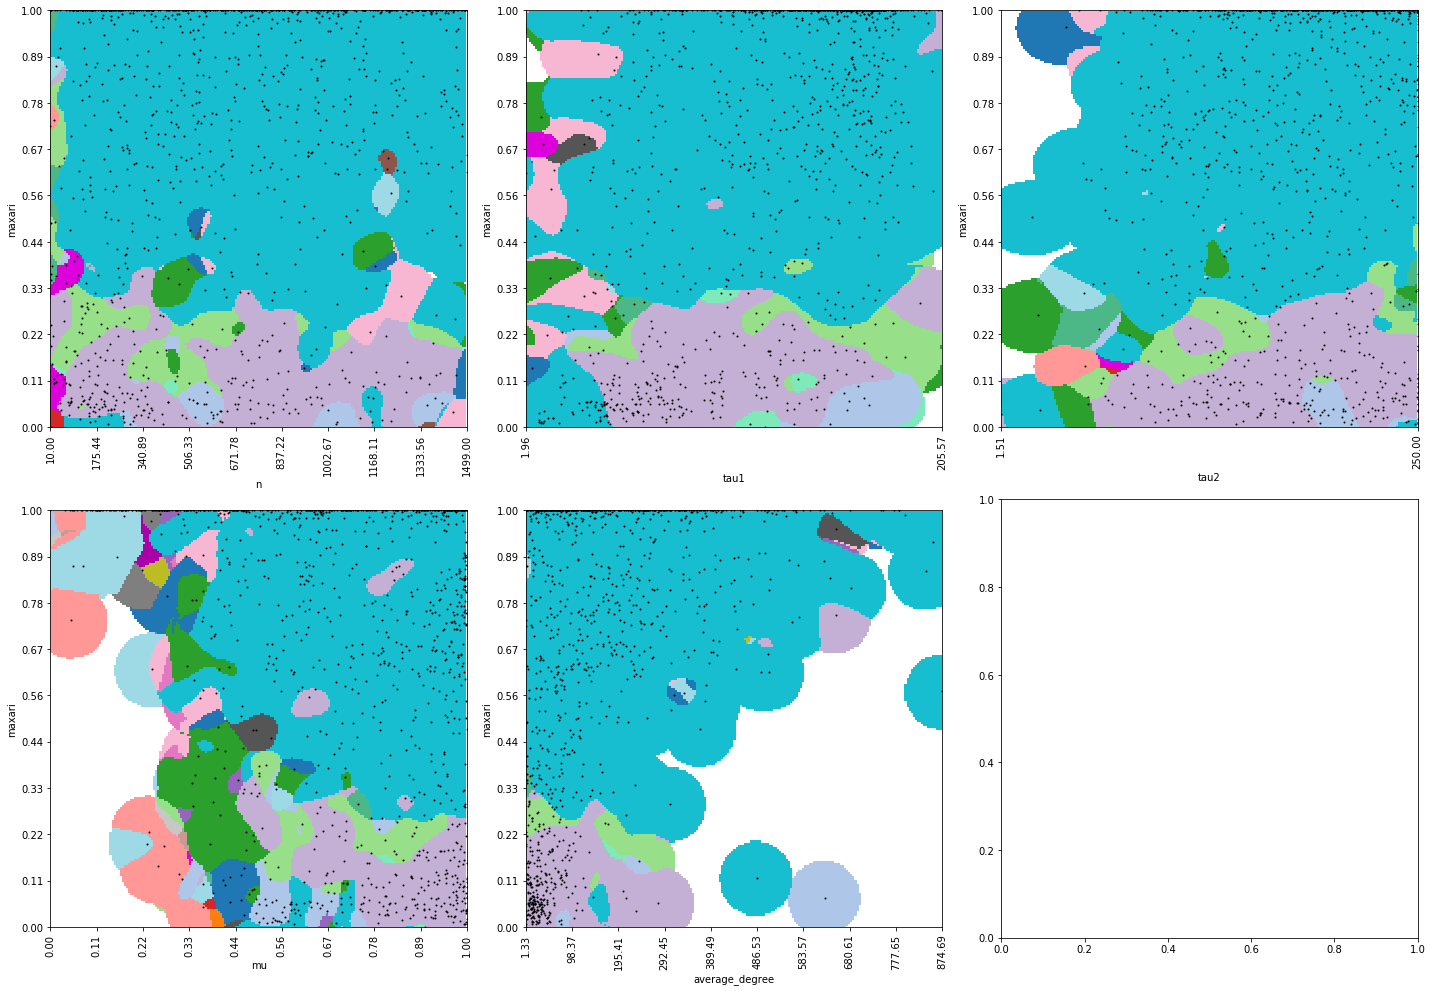

In [17]:
distance = 0.03

fig, ax = plt.subplots(2, 3, figsize=(20, 14))

feature_names = ['maxari', 'n']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[0][0], X, y, plot, feature_names)

feature_names = ['maxari', 'tau1']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[0][1], X, y, plot, feature_names)

feature_names = ['maxari', 'tau2']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[0][2], X, y, plot, feature_names)

feature_names = ['maxari', 'mu']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[1][0], X, y, plot, feature_names)

feature_names = ['maxari', 'average_degree']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[1][1], X, y, plot, feature_names)

plt.tight_layout()

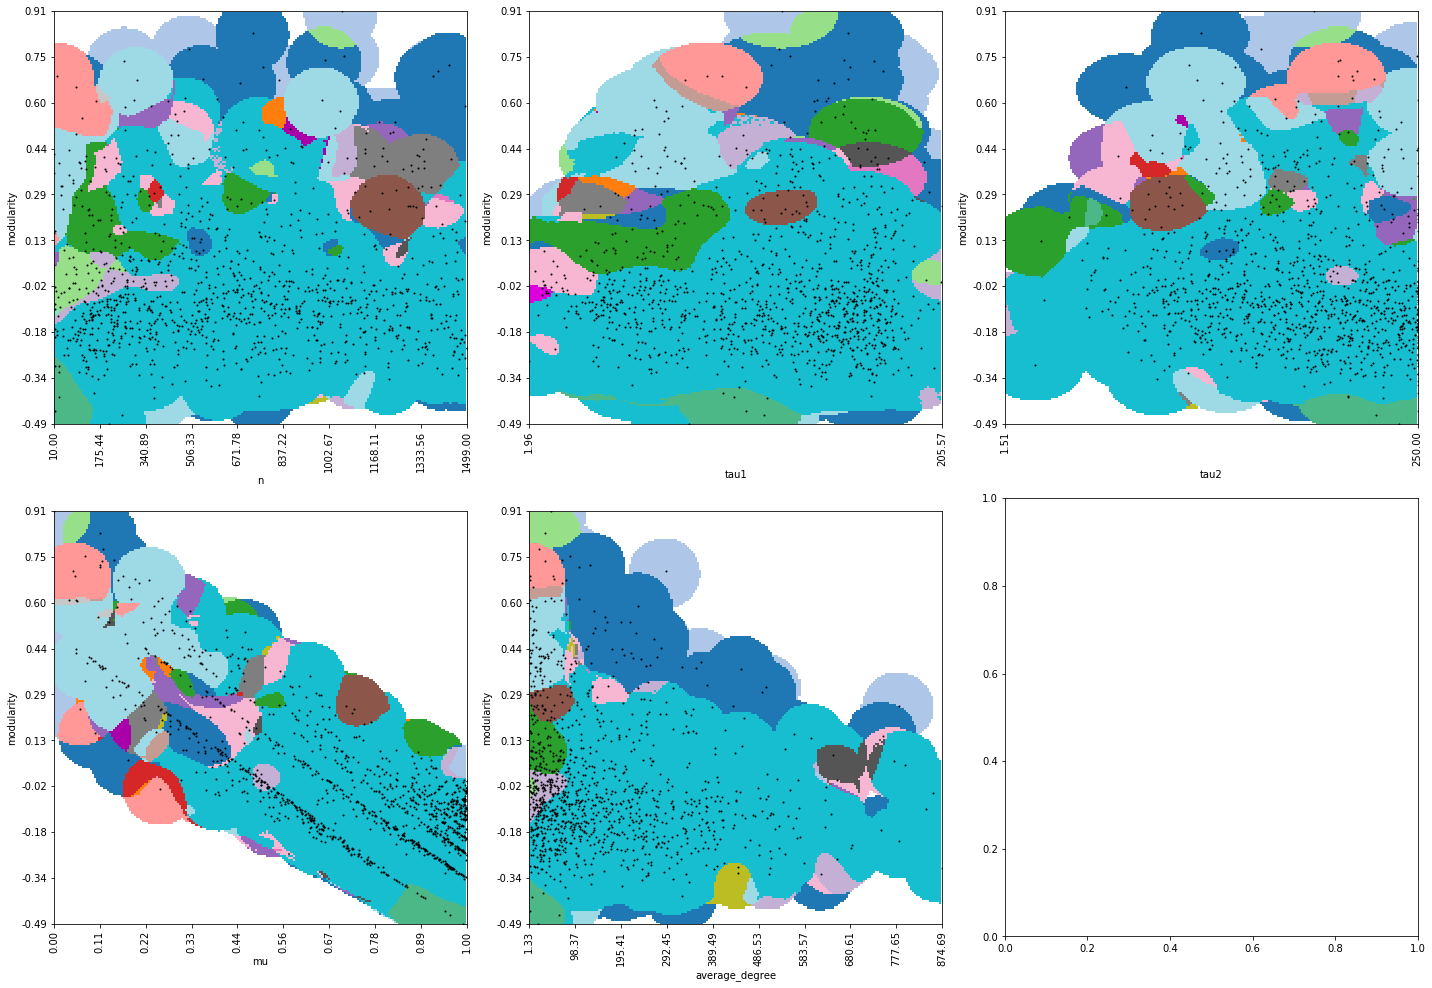

In [18]:
distance = 0.03

fig, ax = plt.subplots(2, 3, figsize=(20, 14))

feature_names = ['modularity', 'n']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[0][0], X, y, plot, feature_names)

feature_names = ['modularity', 'tau1']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[0][1], X, y, plot, feature_names)

feature_names = ['modularity', 'tau2']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[0][2], X, y, plot, feature_names)

feature_names = ['modularity', 'mu']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[1][0], X, y, plot, feature_names)

feature_names = ['modularity', 'average_degree']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[1][1], X, y, plot, feature_names)

plt.tight_layout()

In [19]:
def prepare_plot_filter(dataset, feature_names, distance=0.05):
    X = np.array([[fnc[fname](item[1][fname]) for fname in feature_names] for item in dataset])
    y = np.array([[item[0][kernel] for kernel in kernels_order] for item in dataset])
    
    knn = MyGaussianFilter(sigma=distance)
    knn.fit(X, y)

    plot = np.zeros((resolution, resolution, 3), dtype=np.uint8)
    for xidx, xval in enumerate(np.linspace(limits[feature_names[0]][0], limits[feature_names[0]][1], resolution)):
        for yidx, yval in enumerate(np.linspace(limits[feature_names[1]][0], limits[feature_names[1]][1], resolution)):
            pixels_kernels_results = knn.predict([[xval, yval]])[0] 
#             pixels_kernels_results[11] = 0
            if ~np.all(pixels_kernels_results == 0):
                pixels_kernel_name = kernels_order[np.argmax(pixels_kernels_results)]
                plot[xidx, yidx] = np.array(colors.to_rgb(d3_colors[pixels_kernel_name])) * 255
            else:
                plot[xidx, yidx] = np.array([1, 1, 1]) * 255
            
    return X, y, plot

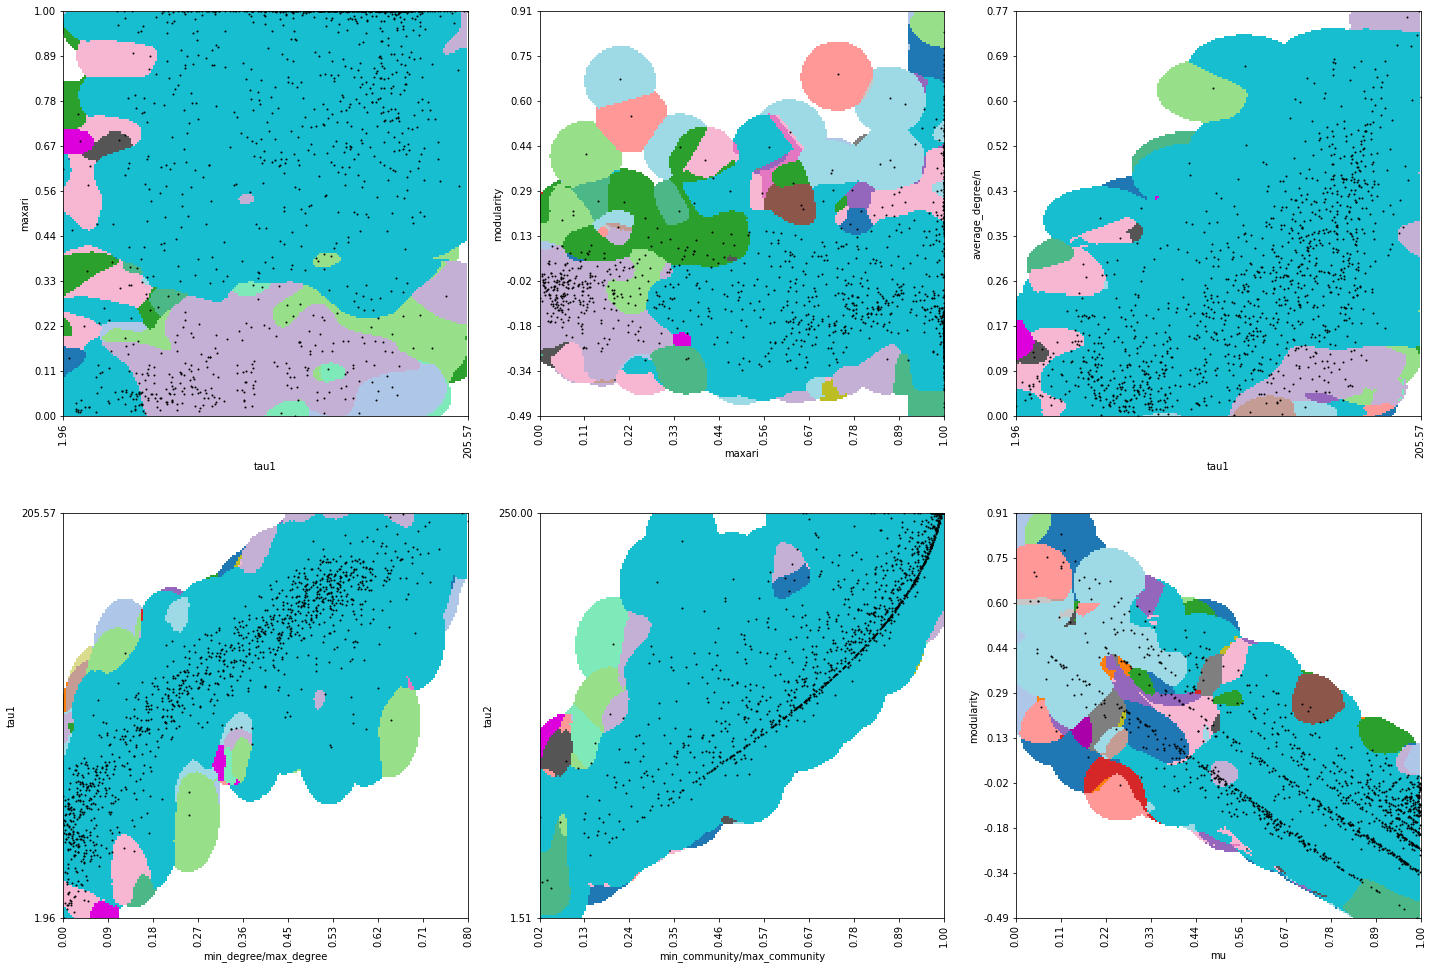

In [20]:
distance = 0.03

fig, ax = plt.subplots(2, 3, figsize=(20, 14))

feature_names = ['maxari', 'tau1']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[0][0], X, y, plot, feature_names)

feature_names = ['modularity', 'maxari']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[0][1], X, y, plot, feature_names)

feature_names = ['average_degree/n', 'tau1']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[0][2], X, y, plot, feature_names)


feature_names = ['tau1', 'min_degree/max_degree']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[1][0], X, y, plot, feature_names)

feature_names = ['tau2', 'min_community/max_community']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[1][1], X, y, plot, feature_names)

feature_names = ['modularity', 'mu']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[1][2], X, y, plot, feature_names)


plt.tight_layout()

In [21]:
def prepare_plot_filter(dataset, feature_names, distance=0.05):
    X = np.array([[fnc[fname](item[1][fname]) for fname in feature_names] for item in dataset])
    y = np.array([[item[0][kernel] for kernel in kernels_order] for item in dataset])
    
    knn = MyGaussianFilter(sigma=distance)
    knn.fit(X, y)

    plot = np.zeros((resolution, resolution, 3), dtype=np.uint8)
    for xidx, xval in enumerate(np.linspace(limits[feature_names[0]][0], limits[feature_names[0]][1], resolution)):
        for yidx, yval in enumerate(np.linspace(limits[feature_names[1]][0], limits[feature_names[1]][1], resolution)):
            pixels_kernels_results = knn.predict([[xval, yval]])[0] 
            pixels_kernels_results[11] = 0
            if ~np.all(pixels_kernels_results == 0):
                pixels_kernel_name = kernels_order[np.argmax(pixels_kernels_results)]
                plot[xidx, yidx] = np.array(colors.to_rgb(d3_colors[pixels_kernel_name])) * 255
            else:
                plot[xidx, yidx] = np.array([1, 1, 1]) * 255
            
    return X, y, plot

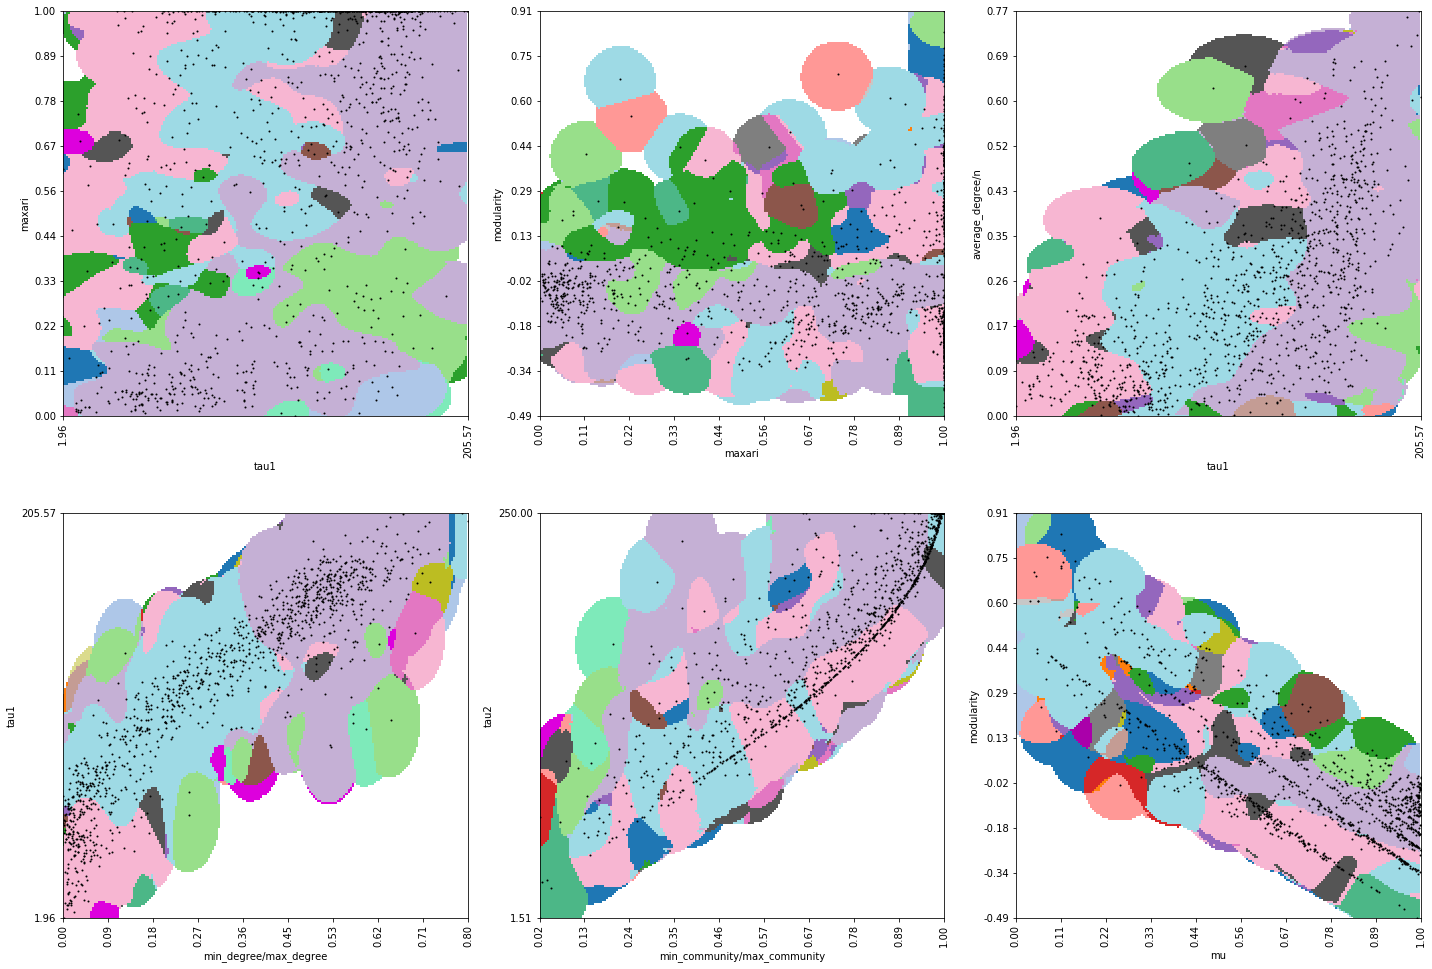

In [22]:
distance = 0.03

fig, ax = plt.subplots(2, 3, figsize=(20, 14))

feature_names = ['maxari', 'tau1']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[0][0], X, y, plot, feature_names)

feature_names = ['modularity', 'maxari']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[0][1], X, y, plot, feature_names)

feature_names = ['average_degree/n', 'tau1']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[0][2], X, y, plot, feature_names)


feature_names = ['tau1', 'min_degree/max_degree']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[1][0], X, y, plot, feature_names)

feature_names = ['tau2', 'min_community/max_community']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[1][1], X, y, plot, feature_names)

feature_names = ['modularity', 'mu']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[1][2], X, y, plot, feature_names)


plt.tight_layout()

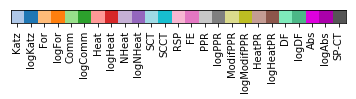

In [23]:
a = np.zeros((1, 25, 3), dtype=np.uint8)
labels = []
for idx, kernel in enumerate(kernels):
    a[0, idx] = np.array(colors.to_rgb(d3_colors[kernel.name])) * 255
    labels.append(kernel.name)
plt.imshow(a)
plt.xticks(range(25), labels, rotation='vertical')
plt.yticks([]);